### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs for non-AI articles (using a ChatGPT prompt)
- Also remove duplicates/seen before, (match URL or title+domain, or 90% cosine similarity of normalized text)
- Download articles and summarize 
- Rerank and filter the articles based on summary, for quality, recency, site reputation
- Derform topic analysis via prompts (vs. traditional NMF or LDA, is zero-shot w/o training and also should have deep semantic understanding)
- Dedupe again and keep only highest ranked article covering a single development, event, or set of facts
- Send top articles by max marginal relevance to a large prompt
- Use a loop to polish and email the summary
- Used to generate a daily newsletter at skynetandchill.beehiiv.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - use OpenAI agents SDK instead of langgraph
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
  - implement proper critic-optimizer loop logic

- write currently uses a complex prompt with all the stories. instead
  - split into 2 parts, first select stories and then write
  - maybe write each section independently, assemble all the sections and rewrite using a critic-refine flow

- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo

- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.agent']
# del sys.modules['ainewsbot.AInewsbot']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]
LangChain         0.3.26
OpenAI            1.93.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.3.0
sklearn           1.7.0
umap              0.5.9.post2
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-08-12 18:25:55,063 - AInewsbot - INFO - Initializing with before_date=2025-06-15 18:00, do_download=False, thread_id=4fddcebb8ce3425b8c8c132f7f598e46
2025-08-12 18:25:55,427 - AInewsbot - INFO - thread_id: 4fddcebb8ce3425b8c8c132f7f598e46


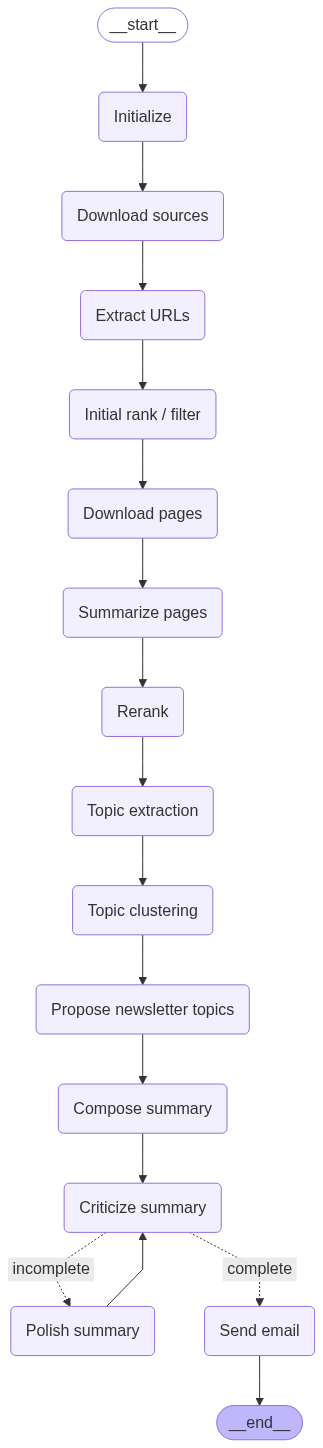

In [4]:
# before_date = None
before_date = '2025-06-15 18:00'
do_download = False

# o3 and o3-mini are trained for high STEM comprehension - would use these if cost no object
# o3 is best but super expensive
# o4-mini probably best cost/performance for final writing, reasonably priced reasoning model
# gpt-4.1 and 4.1-mini for complex and simpler agentic stuff respectively
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices
# https://openai.com/api/pricing/

# current flow is, read the actual bullets, post good ones to Bluesky, compile newsletter from Bluesky posts and a prompt
# Compile newsletter from BlueSky posts.ipynb

# low, medium, high models
ml, mm, mh = 'gpt-5-nano', 'gpt-5-mini', 'gpt-5'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning with do_download=False

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name', 'hostname', 'site_name', 'url', 'actual_url']]


In [ ]:
aidf.columns


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-08-12 18:29:54,197 - AInewsbot - INFO - Initializing with before_date=2025-08-12 09:00, do_download=False, thread_id=8e47b00b468347819633318547f8a816


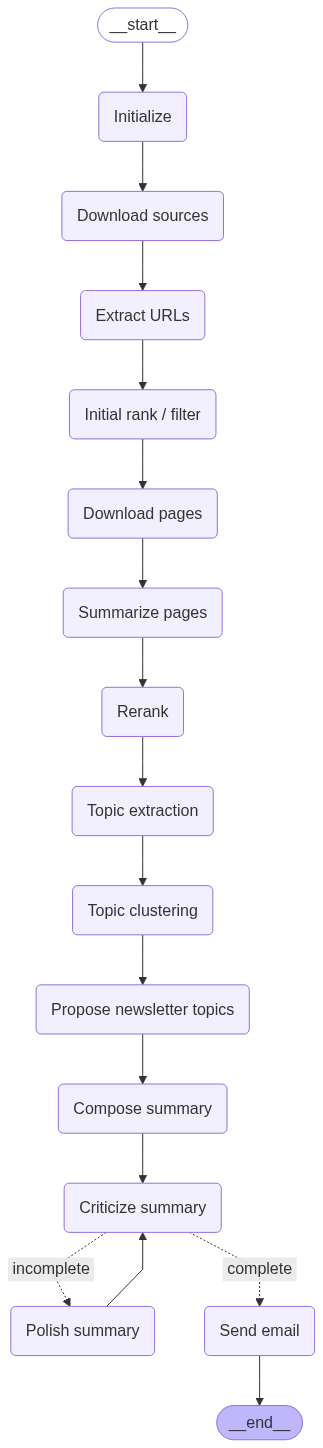

In [14]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-08-12 09:00'
do_download = False

ml, mm, mh = 'gpt-5-nano', 'gpt-5-mini', 'gpt-5'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [15]:
lg_state = lg_agent.initialize_config(lg_state)


2025-08-12 18:30:01,353 - AInewsbot - INFO - fn_initialize: do_download=False, before_date=2025-08-12 09:00, n_browsers=12, max_edits=2
2025-08-12 18:30:01,365 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2025-08-12 18:30:01,365 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-08-12 18:30:01,366 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-08-12 18:30:01,366 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-08-12 18:30:01,366 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-08-12 18:30:01,367 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdi

In [16]:
lg_state = lg_agent.download_sources(lg_state)


2025-08-12 18:30:02,092 - AInewsbot - INFO - Web fetch disabled, using existing files in download/sources
2025-08-12 18:30:02,094 - AInewsbot - INFO - Found 16 previously downloaded files
2025-08-12 18:30:02,095 - AInewsbot - INFO - download/sources/Techmeme.html
2025-08-12 18:30:02,095 - AInewsbot - INFO - download/sources/Hacker_News_1.html
2025-08-12 18:30:02,095 - AInewsbot - INFO - download/sources/Reddit.html
2025-08-12 18:30:02,096 - AInewsbot - INFO - download/sources/HackerNoon.html
2025-08-12 18:30:02,097 - AInewsbot - INFO - download/sources/VentureBeat.html
2025-08-12 18:30:02,098 - AInewsbot - INFO - download/sources/Feedly_AI.html
2025-08-12 18:30:02,098 - AInewsbot - INFO - download/sources/The_Register.html
2025-08-12 18:30:02,099 - AInewsbot - INFO - download/sources/FT.html
2025-08-12 18:30:02,099 - AInewsbot - INFO - download/sources/Business_Insider.html
2025-08-12 18:30:02,099 - AInewsbot - INFO - download/sources/Washington_Post.html
2025-08-12 18:30:02,100 - AIne

In [17]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-08-12 18:30:02,761 - AInewsbot - INFO - Parsing html files
2025-08-12 18:30:02,769 - AInewsbot - INFO - Ars Technica -> download/sources/Ars_Technica.html
2025-08-12 18:30:02,812 - AInewsbot - INFO - parse_file - found 169 raw links
2025-08-12 18:30:02,816 - AInewsbot - INFO - parse_file - found 26 filtered links
2025-08-12 18:30:02,816 - AInewsbot - INFO - 26 links found
2025-08-12 18:30:02,817 - AInewsbot - INFO - Bloomberg -> download/sources/Bloomberg.html
2025-08-12 18:30:02,857 - AInewsbot - INFO - parse_file - found 247 raw links
2025-08-12 18:30:02,862 - AInewsbot - INFO - parse_file - found 32 filtered links
2025-08-12 18:30:02,863 - AInewsbot - INFO - 32 links found
2025-08-12 18:30:02,864 - AInewsbot - INFO - Business Insider -> download/sources/Business_Insider.html
2025-08-12 18:30:02,884 - AInewsbot - INFO - parse_file - found 154 raw links
2025-08-12 18:30:02,887 - AInewsbot - INFO - parse_file - found 14 filtered links
2025-08-12 18:30:02,887 - AInewsbot - INFO - 1

In [18]:
# s/b 17 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 17
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 17


,id
src,
Ars Technica,25
Bloomberg,27
Business Insider,14
FT,58
Feedly AI,87
Hacker News 1,24
Hacker News 2,25
HackerNoon,31
New York Times,16


number of missing sources 0


set()

In [19]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-08-12 18:30:05,474 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-08-12 09:00'
2025-08-12 18:30:06,430 - AInewsbot - INFO - URLs in orig_df: 855
2025-08-12 18:30:06,434 - AInewsbot - INFO - Existing URLs in DB: 305896
2025-08-12 18:30:06,508 - AInewsbot - INFO - New URLs in df filtered by URL: 322
2025-08-12 18:30:06,699 - AInewsbot - INFO - Existing src+title: 37
2025-08-12 18:30:06,700 - AInewsbot - INFO - New URLs in df filtered by src+title: 285
2025-08-12 18:30:06,717 - AInewsbot - INFO - Found 285 unique new headlines
2025-08-12 18:30:06,719 - AInewsbot - INFO - Found 276 unique cleaned new headlines
2025-08-12 18:30:18,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:30:21,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:30:22,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

2025-08-12 18:30:32,518 - AInewsbot - INFO - blog.wilsonl.in not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,518 - AInewsbot - INFO - it.slashdot.org not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,518 - AInewsbot - INFO - wsbt.com not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,518 - AInewsbot - INFO - betalist.com not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,518 - AInewsbot - INFO - www.rawstory.com not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,518 - AInewsbot - INFO - www.nextgov.com not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,519 - AInewsbot - INFO - elearningindustry.com not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,519 - AInewsbot - INFO - www.channelnewsasia.com not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,519 - AInewsbot - INFO - www.the-independent.com not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,519 - AInewsbot - INFO - japantoday.com not in SOURCE_REPUTATION dict
2025-08-12 18:30:32,519 - AInewsbot - INFO - www.pbs.org not in SOURCE_REPUTAT

,id
src,
Ars Technica,2
Bloomberg,8
Business Insider,6
FT,2
Feedly AI,70
Hacker News 1,8
Hacker News 2,2
HackerNoon,1
New York Times,2


In [20]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-08-12 18:30:37,798 - AInewsbot - INFO - Queuing URLs for scraping
2025-08-12 18:30:37,810 - AInewsbot - INFO - Saving HTML files using async concurrency= 12
2025-08-12 18:30:38,145 - AInewsbot - INFO - Launching browser
2025-08-12 18:30:39,321 - AInewsbot - INFO - Launching workers
2025-08-12 18:30:39,321 - AInewsbot - INFO - Launching worker
2025-08-12 18:30:39,322 - AInewsbot - INFO - from queue: 0, https://www.ibtimes.com/even-age-ai-hiring-needs-human-touch-says-qanjer-founder-jurriaan-rang-3780685 , 'Even In The Age of AI, Hiring Needs a Human Touch,' Says Qanjer Founder Jurriaan Rang
2025-08-12 18:30:39,322 - AInewsbot - INFO - fetch_url(https://www.ibtimes.com/even-age-ai-hiring-needs-human-touch-says-qanjer-founder-jurriaan-rang-3780685)
2025-08-12 18:30:39,328 - AInewsbot - INFO - Launching worker
2025-08-12 18:30:39,328 - AInewsbot - INFO - from queue: 1, https://www.businessinsider.com/inference-whales-threaten-ai-coding-startups-business-model-2025-8 , 'Inference whale

2025-08-12 18:31:03,139 - AInewsbot - INFO - Saving HTML to download/html/A.I._Start-Up_Perplexity_Offers_to_Buy_Googles_Chrome_Browser_for__34.5_Billion.html
2025-08-12 18:31:03,157 - AInewsbot - INFO - from queue: 16, https://futurism.com/amazon-alexa-ai-dystopian , Amazon's New Alexa AI Sounds Like a Dystopian Nightmare
2025-08-12 18:31:03,157 - AInewsbot - INFO - fetch_url(https://futurism.com/amazon-alexa-ai-dystopian)
2025-08-12 18:31:03,732 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-11T14:38:32-04:00
2025-08-12 18:31:03,733 - AInewsbot - INFO - Saving HTML to download/html/Even_In_The_Age_of_AI__Hiring_Needs_a_Human_Touch___Says_Qanjer_Founder_Jurriaan_Rang.html
2025-08-12 18:31:03,886 - AInewsbot - INFO - from queue: 17, https://www.ft.com/content/0facc3ff-3179-4880-a182-a545fad33430 , Americas export tariff on Nvidia and AMD chips sets a troubling precedent
2025-08-12 18:31:03,886 - AInewsbot - INFO - fetch_url(https://w

2025-08-12 18:31:23,382 - AInewsbot - INFO - from queue: 27, https://hackernoon.com/boost-tensorflow-training-speed-by-50percent-with-these-tpu-tricks , Boost TensorFlow Training Speed by 50% with These TPU Tricks
2025-08-12 18:31:23,383 - AInewsbot - INFO - fetch_url(https://hackernoon.com/boost-tensorflow-training-speed-by-50percent-with-these-tpu-tricks)
2025-08-12 18:31:26,421 - AInewsbot - INFO - Found last updated time from document.lastModified: 08/12/2025 23:31:26
2025-08-12 18:31:26,421 - AInewsbot - INFO - Saving HTML to download/html/ATO_trials_multimodal_AI_models_for_auditing_work-related_expenses.html
2025-08-12 18:31:26,442 - AInewsbot - INFO - from queue: 28, https://www.theguardian.com/commentisfree/2025/aug/13/can-ai-deliver-economic-nirvana-only-if-workers-can-monitor-and-shape-how-its-used , Can AI deliver economic nirvana? Only if workers can monitor and shape how it's used | Peter Lewis
2025-08-12 18:31:26,446 - AInewsbot - INFO - fetch_url(https://www.theguardian

2025-08-12 18:31:43,299 - AInewsbot - INFO - Saving HTML to download/html/Boost_TensorFlow_Training_Speed_by_50__with_These_TPU_Tricks.html
2025-08-12 18:31:43,486 - AInewsbot - INFO - from queue: 39, https://every.to/vibe-check/vibe-check-claude-sonnet-4-now-has-a-1-million-token-context-window , Claude vs. Gemini: Testing on 1M Tokens of Context
2025-08-12 18:31:43,498 - AInewsbot - INFO - fetch_url(https://every.to/vibe-check/vibe-check-claude-sonnet-4-now-has-a-1-million-token-context-window)
2025-08-12 18:31:45,176 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-12T15:00:24.000Z
2025-08-12 18:31:45,179 - AInewsbot - INFO - Saving HTML to download/html/Can_AI_deliver_economic_nirvana__Only_if_workers_can_monitor_and_shape_how_it_s_used___Peter_Lewis.html
2025-08-12 18:31:45,264 - AInewsbot - INFO - from queue: 40, http://www.pymnts.com/fraud-prevention/2025/commbank-adds-ai-powered-scam-detection-tool-to-identity-protection-app/ ,

2025-08-12 18:32:23,686 - AInewsbot - INFO - from queue: 50, https://truthout.org/articles/educational-ai-risks-becoming-an-authoritarian-vehicle-for-thought-control/ , Educational AI Risks Becoming an Authoritarian Vehicle for Thought Control
2025-08-12 18:32:23,688 - AInewsbot - INFO - fetch_url(https://truthout.org/articles/educational-ai-risks-becoming-an-authoritarian-vehicle-for-thought-control/)
2025-08-12 18:32:31,189 - AInewsbot - INFO - Found last updated time from document.lastModified: 08/12/2025 23:32:31
2025-08-12 18:32:31,191 - AInewsbot - INFO - Saving HTML to download/html/CoreWeave_beats_quarterly_revenue_estimates_on_sturdy_AI_demand.html
2025-08-12 18:32:31,388 - AInewsbot - INFO - from queue: 51, https://www.newsweek.com/elon-musk-reacts-grok-account-temporarily-suspended-2112023 , Elon Musk Reacts as Grok Account Gets Temporarily Suspended
2025-08-12 18:32:31,391 - AInewsbot - INFO - fetch_url(https://www.newsweek.com/elon-musk-reacts-grok-account-temporarily-susp

2025-08-12 18:33:07,735 - AInewsbot - INFO - Page URL redirected from http://www.pymnts.com/supply-chain/2025/doordash-uses-more-ai-driven-supply-chain-solutions-from-relex/ to https://www.pymnts.com/supply-chain/2025/doordash-uses-more-ai-driven-supply-chain-solutions-from-relex/
2025-08-12 18:33:07,869 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-11T21:05:49+00:00
2025-08-12 18:33:07,871 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-08-11T21:05:49Z
2025-08-12 18:33:07,872 - AInewsbot - INFO - Saving HTML to download/html/DoorDash_Uses_More_AI-Driven_Supply_Chain_Solutions_From_Relex.html
2025-08-12 18:33:08,484 - AInewsbot - INFO - from queue: 61, https://www.theregister.com/2025/08/12/genai_lawsuit/ , GenAI is a lawsuit waiting to happen to your business
2025-08-12 18:33:08,485 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/08/12/genai_lawsuit/)
2025-08-12 18:33:08,488 - AIn

2025-08-12 18:33:32,173 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-08-12T12:30:02Z
2025-08-12 18:33:32,175 - AInewsbot - INFO - Saving HTML to download/html/Freight_management_startup_GoodShip_raises__25_million_to_overhaul_shipping_with_AI._Read_the_pitch_deck..html
2025-08-12 18:33:32,444 - AInewsbot - INFO - from queue: 71, https://www.washingtonpost.com/nation/2025/08/12/illinois-ai-therapy-ban/ , Illinois bans AI therapy as some states begin to scrutinize chatbots
2025-08-12 18:33:32,445 - AInewsbot - INFO - fetch_url(https://www.washingtonpost.com/nation/2025/08/12/illinois-ai-therapy-ban/)
2025-08-12 18:33:53,935 - AInewsbot - INFO - Page URL redirected from https://devops.com/?p=178414 to https://devops.com/github-ceo-to-step-down-as-company-is-more-tightly-embraced-by-microsofts-coreai-team/
2025-08-12 18:33:53,962 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-11T19:55:55+00:00
2025-

2025-08-12 18:34:24,867 - AInewsbot - INFO - from queue: 82, https://www.techspot.com/news/109040-microsoft-ai-push-tightens-grip-github-after-ceo.html , Microsoft absorbs GitHub into CoreAI division as CEO plans exit
2025-08-12 18:34:24,868 - AInewsbot - INFO - fetch_url(https://www.techspot.com/news/109040-microsoft-ai-push-tightens-grip-github-after-ceo.html)
2025-08-12 18:34:29,925 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-11T21:19:17Z
2025-08-12 18:34:29,931 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-08-11T21:19:17+00:00
2025-08-12 18:34:29,946 - AInewsbot - INFO - Saving HTML to download/html/Google_s_Gemini_AI_tells_a_Redditor_it_s__cautiously_optimistic__about_fixing_a_coding_bug__fails_repeatedly__calls_itself_an_embarrassment_to__all_possible_and_impossible_universes__before_repeating__I_am_a_disgrace__86_times_in_succession.html
2025-08-12 18:34:30,253 - AInewsbot - INFO - from

2025-08-12 18:35:06,221 - AInewsbot - INFO - fetch_url(https://www.hollywoodreporter.com/movies/movie-news/openai-movie-chris-odowd-andrew-garfield-1236342283/)
2025-08-12 18:35:10,253 - AInewsbot - INFO - Found last updated time from meta tag property=article:modified_time: 2025-08-12T12:14:35.000000Z
2025-08-12 18:35:10,258 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-08-12T16:14:32Z
2025-08-12 18:35:10,261 - AInewsbot - INFO - Saving HTML to download/html/NEXA_Mortgage_partners_with_Tidalwave_to_bring_Agentic_AI_platform_to_brokers.html
2025-08-12 18:35:10,297 - AInewsbot - INFO - from queue: 94, https://venturebeat.com/ai/openai-adds-new-chatgpt-third-party-tool-connectors-to-dropbox-ms-teams-as-altman-clarifies-gpt-5-prioritization/ , OpenAI adds new ChatGPT third-party tool connectors to Dropbox, MS Teams as Altman clarifies GPT-5 prioritization
2025-08-12 18:35:10,298 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/openai-adds-new

2025-08-12 18:35:53,401 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/08/12/perplexity_takes_shine_to_chrome/)
2025-08-12 18:36:03,322 - AInewsbot - INFO - Found last updated time from document.lastModified: 08/12/2025 23:36:03
2025-08-12 18:36:03,323 - AInewsbot - INFO - Saving HTML to download/html/OpenAI_is_running_some_cheap_knockoff_version_of_GPT-5_in_ChatGPT_apparently.html
2025-08-12 18:36:03,847 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-08-12T18:28:18.000Z
2025-08-12 18:36:03,850 - AInewsbot - INFO - Saving HTML to download/html/Nuclear_Startup_Oklo_Soars_As_AI_Boom_Sparks_Need_For_New_Power_Sources.html
2025-08-12 18:36:03,862 - AInewsbot - INFO - from queue: 106, https://www.fastcompany.com/91385038/perplexitys-bid-to-buy-the-chrome-is-likely-more-stunt-than-strategy , Perplexitys bid to buy Chrome is likely more stunt than strategy
2025-08-12 18:36:03,868 - AInewsbot - INFO - fetch_url(https://www.fastcompany.com/9

2025-08-12 18:37:01,313 - AInewsbot - INFO - fetch_url(https://futurism.com/sam-altman-lying-tell)
2025-08-12 18:37:08,095 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-12T05:00:44-07:00
2025-08-12 18:37:08,105 - AInewsbot - INFO - Saving HTML to download/html/Phoenix_Police_to_begin_using_AI_to_help_handle_calls_to_nonemergency_line.html
2025-08-12 18:37:08,395 - AInewsbot - INFO - from queue: 117, https://www.techradar.com/pro/sandisk-and-samsungs-biggest-rival-have-come-together-to-standardize-high-bandwidth-flash-memory-and-it-could-mean-greater-ai-performance-for-everyone , Samsung's biggest rival and Sandisk have come together to standardize High Bandwidth Flash memory - which could mean better AI performance for everyone
2025-08-12 18:37:08,397 - AInewsbot - INFO - fetch_url(https://www.techradar.com/pro/sandisk-and-samsungs-biggest-rival-have-come-together-to-standardize-high-bandwidth-flash-memory-and-it-could-mean-greater-

2025-08-12 18:37:58,628 - AInewsbot - INFO - Saving HTML to download/html/Salesforces_new_CoAct-1_agents_dont_just_point_and_click__they_write_code_to_accomplish_tasks_faster_and_with_greater_success_rates.html
2025-08-12 18:37:59,146 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-08-12T13:52:33-04:00
2025-08-12 18:37:59,149 - AInewsbot - INFO - Saving HTML to download/html/Sam_Altman_Allegedly_Has_a_Very_Specific_Tell_Every_Time_He_Lies.html
2025-08-12 18:37:59,222 - AInewsbot - INFO - from queue: 127, https://www.rawstory.com/grok-briefly-suspended-2673875819/ , Taunts abound as X glitch suspends Elon Musk's own AI chatbot
2025-08-12 18:37:59,222 - AInewsbot - INFO - fetch_url(https://www.rawstory.com/grok-briefly-suspended-2673875819/)
2025-08-12 18:37:59,467 - AInewsbot - INFO - from queue: 128, https://www.nextgov.com/artificial-intelligence/2025/08/teachers-union-looks-states-and-industry-ai-regulation-absent-federal-action/407375/ , Teachers 

2025-08-12 18:38:31,333 - AInewsbot - INFO - fetch_url(https://biztoc.com/x/3733deb9e80c683b)
2025-08-12 18:38:34,532 - AInewsbot - INFO - Found last updated time from meta tag name=pubdate: 2025-08-11T22:27:00+00:00
2025-08-12 18:38:34,536 - AInewsbot - INFO - Saving HTML to download/html/Teachers_union_looks_to_states_and_industry_for_AI_regulation_absent_federal_action.html
2025-08-12 18:38:35,685 - AInewsbot - INFO - from queue: 139, https://www.channelnewsasia.com/world/trump-signals-possible-sale-scaled-down-nvidia-blackwell-ai-chips-china-5289406 , Trump signals possible sale of scaled-down Nvidia Blackwell AI chips to China
2025-08-12 18:38:35,687 - AInewsbot - INFO - fetch_url(https://www.channelnewsasia.com/world/trump-signals-possible-sale-scaled-down-nvidia-blackwell-ai-chips-china-5289406)
2025-08-12 18:38:39,034 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-08-12T16:36:27Z
2025-08-12 18:38:39,036 - AInewsbot - INFO - Saving HTML to do

2025-08-12 18:39:30,510 - AInewsbot - INFO - from queue: 149, https://www.fool.com/investing/2025/08/12/ai-stock-millionaire-figma-palantir/ , WhichArtificial Intelligence(AI) Stock Is More Likely to Make You a Millionaire: Figma or Palantir?
2025-08-12 18:39:30,512 - AInewsbot - INFO - fetch_url(https://www.fool.com/investing/2025/08/12/ai-stock-millionaire-figma-palantir/)
2025-08-12 18:39:30,627 - AInewsbot - INFO - from queue: 150, https://arstechnica.com/ai/2025/08/why-its-a-mistake-to-ask-chatbots-about-their-mistakes/ , Why its a mistake to ask chatbots about their mistakes
2025-08-12 18:39:30,635 - AInewsbot - INFO - fetch_url(https://arstechnica.com/ai/2025/08/why-its-a-mistake-to-ask-chatbots-about-their-mistakes/)
2025-08-12 18:39:31,443 - AInewsbot - INFO - Found last updated time from HTTP header: Thu, 31 Jul 2025 00:31:06 GMT
2025-08-12 18:39:31,450 - AInewsbot - INFO - Saving HTML to download/html/Training_language_models_to_be_warm_and_empathetic_makes_them_less_reliabl

2025-08-12 18:40:18,810 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-12T14:05:55Z
2025-08-12 18:40:18,812 - AInewsbot - INFO - Saving HTML to download/html/Why_the_best_lawyers_are_learning_to_talk_to_AI.html
2025-08-12 18:40:21,399 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-12T19:36:22Z
2025-08-12 18:40:21,401 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-08-12T19:36:22+00:00
2025-08-12 18:40:21,402 - AInewsbot - INFO - Saving HTML to download/html/Yes__Sam_Altman_will_be_played_by_Andrew_Garfield_in__Artificial___but_all_we_want_to_know_is_whos_playing_Elon_Musk.html
2025-08-12 18:40:21,706 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-08-12T18:30:00+00:00
2025-08-12 18:40:21,710 - AInewsbot - INFO - Saving HTML to download/html/You_can_now_feed_Claude_Sonnet_4_entire_codebases_at_once.

2025-08-12 18:40:30,666 - AInewsbot - INFO - Saving text to download/text/2025-08-12/AI_s_soaring_energy_consumption_is_causing_skyrocketing_power_bills_for_households_across_the_US__States_reporting_spikes_in_energy_costs_of_up_to_36.txt
2025-08-12 18:40:30,667 - AInewsbot - INFO - Checking download/html/AI_Is_Talking_Behind_Our_Backs_About_Glue-Eating_and_Killing_Us_All.html for duplicate in ChromaDB
2025-08-12 18:40:30,678 - AInewsbot - INFO - clean_html - Page title: AI Is Talking Behind Our Backs About Glue-Eating and Killing Us All
Social card title: AI Is Talking Behind Our Backs About Glue-Eating and Killing Us All
Social card description: AI has moved on from answering questions. It’s now slipping coded messages to its friends about glue-eating and human extinction.

2025-08-12 18:40:31,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:40:31,085 - AInewsbot - INFO - Saving text to download/text/2025-08-12/AI_Is_Talking

2025-08-12 18:40:35,065 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Anthropic_offers_its_Claude_AI_model_to_the_federal_government_for__1.txt
2025-08-12 18:40:35,065 - AInewsbot - INFO - Checking download/html/Apollo_Funds_Reach_Agreement_with_American_Securities_to_Acquire_Trace3__a_Leading_Technology_Solutions_Provider_Driving_Adoption_of_Next-Generation_Technology_and_AI.html for duplicate in ChromaDB
2025-08-12 18:40:35,071 - AInewsbot - INFO - clean_html - Page title: Apollo Funds Reach Agreement with American Securities to
Social card title: Apollo Funds Reach Agreement with American Securities to Acquire Trace3, a Leading Technology Solutions Provider Driving Adoption of Next-Generation Technology and AI
Social card description: Strategic Investment to Accelerate Trace3’s Growth and Expand Solutions Across Security, Hybrid Cloud and AI...

2025-08-12 18:40:35,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-1

2025-08-12 18:40:39,228 - AInewsbot - INFO - clean_html - Page title: Character.AI Gave Up on AGI. Now It’s Selling Stories | WIRED
Social card title: Character.AI Gave Up on AGI. Now It’s Selling Stories
Social card description: Startup Character.AI once promised superintelligence. Its new CEO says it's now an entertainment company with 20 million users.

2025-08-12 18:40:39,535 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:40:39,654 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Character.AI_says_it_s_generating_revenue_at_a_run_rate_of__30M__and_has_20M_MAUs_who_spend__on_average__75_minutes_a_day_chatting_with_a_bot.txt
2025-08-12 18:40:39,655 - AInewsbot - INFO - Checking download/html/ChatGPT_Just_Became_A_Live-Service_Game.html for duplicate in ChromaDB
2025-08-12 18:40:39,668 - AInewsbot - INFO - clean_html - Page title: ChatGPT Just Became A Live-Service Game
Social card title: ChatGPT Just Became A Live-

2025-08-12 18:40:43,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:40:43,894 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Deep_thoughts__AI_shows_its_math_chops.txt
2025-08-12 18:40:43,895 - AInewsbot - INFO - Checking download/html/Claude_vs._Gemini__Testing_on_1M_Tokens_of_Context.html for duplicate in ChromaDB
2025-08-12 18:40:43,906 - AInewsbot - INFO - clean_html - Page title: Vibe Check: Claude Sonnet 4 Now Has a 1-million Token Context Window
Social card title: Vibe Check: Claude Sonnet 4 Now Has a 1-million Token Context Window
Social card description: Fast, reliable long-context responses—for a price

2025-08-12 18:40:44,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:40:44,357 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Claude_vs._Gemini__Testing_on_1M_Tokens_of_Context.txt
2025-08-12 18:40:44,358 - AInewsbot - INFO - Chec

2025-08-12 18:40:48,475 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Educational_AI_Risks_Becoming_an_Authoritarian_Vehicle_for_Thought_Control.txt
2025-08-12 18:40:48,476 - AInewsbot - INFO - Checking download/html/Elon_Musk_and_Sam_Altman_s_feud_is_really_heating_up.html for duplicate in ChromaDB
2025-08-12 18:40:48,495 - AInewsbot - INFO - clean_html - Page title: Elon Musk and Sam Altman Are Feuding Again - Business Insider
Social card title: Elon Musk and Sam Altman's feud is really heating up
Social card description: Elon Musk called Sam Altman a "liar." Altman accused him of manipulating X for his own benefit. The two tech billionaires are at it again.

2025-08-12 18:40:48,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:40:48,846 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Elon_Musk_and_Sam_Altman_s_feud_is_really_heating_up.txt
2025-08-12 18:40:48,847 - AInewsbot - INFO - Checking down

2025-08-12 18:40:53,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:40:53,513 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Generative_AI_tools_for_doctors_consolidate_as_Doximity_acquires_Pathway.txt
2025-08-12 18:40:53,514 - AInewsbot - INFO - Checking  for duplicate in ChromaDB
2025-08-12 18:40:53,514 - AInewsbot - INFO - File  does not exist
2025-08-12 18:40:53,514 - AInewsbot - INFO - Checking  for duplicate in ChromaDB
2025-08-12 18:40:53,515 - AInewsbot - INFO - File  does not exist
2025-08-12 18:40:53,515 - AInewsbot - INFO - Checking download/html/How_AI_poisoning_is_fighting_bots_that_hoover_data_without_permission.html for duplicate in ChromaDB
2025-08-12 18:40:53,526 - AInewsbot - INFO - clean_html - Page title: How AI poisoning is fighting bots that hoover data without permission | New Scientist
Social card title: How AI poisoning is fighting bots that hoover data without permission
Social card des

2025-08-12 18:40:57,604 - AInewsbot - INFO - Saving text to download/text/2025-08-12/I_went_hands-on_with_ChatGPT_Codex_and_the_vibe_was_not_good_-_here_s_what_happened.txt
2025-08-12 18:40:57,605 - AInewsbot - INFO - Checking  for duplicate in ChromaDB
2025-08-12 18:40:57,605 - AInewsbot - INFO - File  does not exist
2025-08-12 18:40:57,605 - AInewsbot - INFO - Checking download/html/LLMs_aren_t_world_models.html for duplicate in ChromaDB
2025-08-12 18:40:57,608 - AInewsbot - INFO - clean_html - Page title: LLMs aren’t world models

2025-08-12 18:40:58,012 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:40:58,104 - AInewsbot - INFO - Saving text to download/text/2025-08-12/LLMs_aren_t_world_models.txt
2025-08-12 18:40:58,104 - AInewsbot - INFO - Checking download/html/How_were_using_AI_in_new_ways_to_fight_invalid_traffic.html for duplicate in ChromaDB
2025-08-12 18:40:58,113 - AInewsbot - INFO - clean_html - Page title: Google 

2025-08-12 18:41:02,328 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Microsoft_Report__AI_to_Take_Over_the_Personal_Financial_Advisors_Job.txt
2025-08-12 18:41:02,330 - AInewsbot - INFO - Checking download/html/NYC-based_Profound__which_helps_brands_optimize_visibility_in_AI_search_responses__raised_a__35M_Series_B_led_by_Sequoia__bringing_its_total_funding_to__58.5M__Sharon_Goldman_Fortune.html for duplicate in ChromaDB
2025-08-12 18:41:02,345 - AInewsbot - INFO - clean_html - Page title: AI search startup Profound raises $35M as Sequoia backs its bid to be the Salesforce of marketing’s next era | Fortune
Social card title: Exclusive: Profound raises $35M as Sequoia backs its ambitious bid to become the Salesforce of AI search
Social card description: The startup wants to help brands stay visible as AI reshapes search, in what backers call a once-in-a-generation marketing shift.

2025-08-12 18:41:02,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embe

2025-08-12 18:41:06,384 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:06,476 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Nuclear_Startup_Oklo_Soars_As_AI_Boom_Sparks_Need_For_New_Power_Sources.txt
2025-08-12 18:41:06,477 - AInewsbot - INFO - Checking download/html/Partnering_with_Profound__Winning_on_the_AI_Stage.html for duplicate in ChromaDB
2025-08-12 18:41:06,482 - AInewsbot - INFO - clean_html - Page title: Partnering with Profound: Winning on the AI Stage | Sequoia Capital
Social card title: Partnering with Profound: Winning on the AI Stage
Social card description: The future of discoverability has arrived. James, Dylan and their team are giving marketers the superpower to win where decisions are now being made.

2025-08-12 18:41:06,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:06,791 - AInewsbot - INFO - Saving text to download/text/202

2025-08-12 18:41:10,990 - AInewsbot - INFO - Checking download/html/Perplexitys_bid_to_buy_Chrome_is_likely_more_stunt_than_strategy.html for duplicate in ChromaDB
2025-08-12 18:41:10,991 - AInewsbot - INFO - clean_html - Page title: fastcompany.com

2025-08-12 18:41:10,993 - trafilatura.core - WARNING - discarding data: None
2025-08-12 18:41:11,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:11,612 - AInewsbot - INFO - Skipping download/html/Perplexitys_bid_to_buy_Chrome_is_likely_more_stunt_than_strategy.html as it is too similar to an existing document
2025-08-12 18:41:11,612 - AInewsbot - INFO - Checking download/html/Researchers_Want_To_Use_AI_To_Fight_Potato_Blight.html for duplicate in ChromaDB
2025-08-12 18:41:11,622 - AInewsbot - INFO - clean_html - Page title: Researchers Want To Use AI To Fight Potato Blight
Social card title: Researchers Want To Use AI To Fight Potato Blight - BGR
Social card description: Potat

2025-08-12 18:41:16,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:16,134 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Salesforces_new_CoAct-1_agents_dont_just_point_and_click__they_write_code_to_accomplish_tasks_faster_and_with_greater_success_rates.txt
2025-08-12 18:41:16,134 - AInewsbot - INFO - Checking download/html/Sam_Altman_Allegedly_Has_a_Very_Specific_Tell_Every_Time_He_Lies.html for duplicate in ChromaDB
2025-08-12 18:41:16,143 - AInewsbot - INFO - clean_html - Page title: Sam Altman Allegedly Has a Very Specific Tell Every Time He Lies
Social card title: Sam Altman Allegedly Has a Very Specific Tell Every Time He Lies
Social card description: Sam Altman is no stranger to accusations of lying — but according to one of OpenAI's biggest haters, he has a tick when he does it on camera.

2025-08-12 18:41:16,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK

2025-08-12 18:41:20,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:20,451 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Show_HN__Building_a_web_search_engine_from_scratch_with_3B_neural_embeddings.txt
2025-08-12 18:41:20,452 - AInewsbot - INFO - Checking download/html/SoundHound_AI_Reports_Strongest_Ever_Quarter__Should_You_Buy.html for duplicate in ChromaDB
2025-08-12 18:41:20,508 - AInewsbot - INFO - clean_html - Page title: SoundHound AI Reports Strongest Ever Quarter, Should You Buy?
Social card title: SoundHound AI Reports Strongest Ever Quarter, Should You Buy?
Social card description: SoundHound AI's record Q2 revenue surge and raised outlook spark optimism despite fierce competition and ongoing losses.

2025-08-12 18:41:20,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:20,958 - AInewsbot - INFO - Saving text to download/text/2025-08-12

2025-08-12 18:41:23,891 - AInewsbot - INFO - clean_html - Page title: This Startup Lets You Generate Entire AI Slop Videos | PetaPixel
Social card title: This Startup Lets You Generate Entire AI Slop Videos
Social card description: It's happening.

2025-08-12 18:41:24,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:24,203 - AInewsbot - INFO - Saving text to download/text/2025-08-12/This_Startup_Lets_You_Generate_Entire_AI_Slop_Videos.txt
2025-08-12 18:41:24,204 - AInewsbot - INFO - Checking download/html/Training_AI_Models_Could_Eat_Up_4_Gigawatts_of_Power_by_2030__Report_Warns.html for duplicate in ChromaDB
2025-08-12 18:41:24,231 - AInewsbot - INFO - clean_html - Page title: Training AI Models Could Eat Up 4 Gigawatts of Power by 2030, Report Warns - Newsweek
Social card title: Training AI models could eat up 4 gigawatts of power by 2030, report warns
Social card description: Electricity needed to train large AI models i

2025-08-12 18:41:27,422 - AInewsbot - INFO - Checking download/html/What_Can_GPT-5_Do__Sam_Altman_Reveals_OpenAIs_Most_Powerful_AI_Yet.html for duplicate in ChromaDB
2025-08-12 18:41:27,435 - AInewsbot - INFO - clean_html - Page title: What Can GPT-5 Do? Sam Altman Reveals OpenAI's Most Powerful AI Yet - SmashingApps.com
Social card title: What Can GPT-5 Do? Sam Altman Reveals OpenAI's Most Powerful AI Yet - SmashingApps.com
Social card description: What can GPT-5 Do? GPT-5 transforms coding, science, and reasoning with instant app creation and expert-level problem-solving across all fields.

2025-08-12 18:41:27,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:27,945 - AInewsbot - INFO - Saving text to download/text/2025-08-12/What_Can_GPT-5_Do__Sam_Altman_Reveals_OpenAIs_Most_Powerful_AI_Yet.txt
2025-08-12 18:41:27,945 - AInewsbot - INFO - Checking download/html/Workday_research__75__of_employees_will_work_withartificial_i

2025-08-12 18:41:33,354 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:33,484 - AInewsbot - INFO - Saving text to download/text/2025-08-12/Why_the_best_lawyers_are_learning_to_talk_to_AI.txt
2025-08-12 18:41:33,487 - AInewsbot - INFO - Checking download/html/Yes__Sam_Altman_will_be_played_by_Andrew_Garfield_in__Artificial___but_all_we_want_to_know_is_whos_playing_Elon_Musk.html for duplicate in ChromaDB
2025-08-12 18:41:33,510 - AInewsbot - INFO - clean_html - Page title: Yes, Sam Altman will be played by Andrew Garfield in 'Artificial', but all we want to know is who’s playing Elon Musk | TechRadar
Social card title: The OpenAI movie just got another casting but all I want to know is who’s gonna play Elon Musk opposite Andrew Garfield’s Sam Altman
Social card description: OpenAI's biopic casts Chris O'Dowd in an unnamed role

2025-08-12 18:41:33,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HT

2025-08-12 18:41:41,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:41,985 - AInewsbot - INFO - Upserting download/text/2025-08-12/Anthropic_updates_Claude_Sonnet_4_to_support_a_1M_token_context_window__letting_it_process_prompts_up_to_750K_words_or_75K_lines_of_code__up_5x_on_its_old_limit.txt into ChromaDB
2025-08-12 18:41:42,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:42,361 - AInewsbot - INFO - Upserting download/text/2025-08-12/Apollo_Funds_Reach_Agreement_with_American_Securities_to_Acquire_Trace3__a_Leading_Technology_Solutions_Provider_Driving_Adoption_of_Next-Generation_Technology_and_AI.txt into ChromaDB
2025-08-12 18:41:42,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:42,646 - AInewsbot - INFO - Upserting download/text/2025-08-12/Appfigures__AI_companion_apps_are_on_track_to_gener

2025-08-12 18:41:53,328 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:53,411 - AInewsbot - INFO - Upserting  into ChromaDB
2025-08-12 18:41:53,412 - AInewsbot - INFO - Upserting download/text/2025-08-12/Elon_Musk_and_Sam_Altman_s_feud_is_really_heating_up.txt into ChromaDB
2025-08-12 18:41:53,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:53,733 - AInewsbot - INFO - Upserting download/text/2025-08-12/Elon_Musk_said_Apple_made_it__impossible__for_non-ChatGPT_AI_apps_to_top_the_App_Store._DeepSeek_would_like_a_word..txt into ChromaDB
2025-08-12 18:41:54,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:41:54,210 - AInewsbot - INFO - Upserting download/text/2025-08-12/Evaluating_LLMs_Playing_Text_Adventures.txt into ChromaDB
2025-08-12 18:41:54,543 - httpx - INFO - HTTP Request: POST https://api.openai.com

2025-08-12 18:42:04,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:04,627 - AInewsbot - INFO - Upserting  into ChromaDB
2025-08-12 18:42:04,627 - AInewsbot - INFO - Upserting download/text/2025-08-12/Musk_threatens_Apple_and_calls_OpenAI_boss_a_liar_as_feud_deepens.txt into ChromaDB
2025-08-12 18:42:04,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:05,021 - AInewsbot - INFO - Upserting download/text/2025-08-12/NEXA_Mortgage_partners_with_Tidalwave_to_bring_Agentic_AI_platform_to_brokers.txt into ChromaDB
2025-08-12 18:42:05,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:05,472 - AInewsbot - INFO - Upserting download/text/2025-08-12/NYC-based_Profound__which_helps_brands_optimize_visibility_in_AI_search_responses__raised_a__35M_Series_B_led_by_Sequoia__bringing_its_total_funding_to__58.5M__Sharo

2025-08-12 18:42:15,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:15,961 - AInewsbot - INFO - Upserting download/text/2025-08-12/Sam_Altman_Allegedly_Has_a_Very_Specific_Tell_Every_Time_He_Lies.txt into ChromaDB
2025-08-12 18:42:16,221 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:16,306 - AInewsbot - INFO - Upserting download/text/2025-08-12/Samsung_s_biggest_rival_and_Sandisk_have_come_together_to_standardize_High_Bandwidth_Flash_memory_-_which_could_mean_better_AI_performance_for_everyone.txt into ChromaDB
2025-08-12 18:42:16,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:16,676 - AInewsbot - INFO - Upserting download/text/2025-08-12/Santander_s_data___AI-first_strategy_accelerates_through_OpenAI_collaboration.txt into ChromaDB
2025-08-12 18:42:16,893 - httpx - INFO - HTTP Request: POST https:

2025-08-12 18:42:29,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:29,300 - AInewsbot - INFO - Upserting download/text/2025-08-12/What_Can_GPT-5_Do__Sam_Altman_Reveals_OpenAIs_Most_Powerful_AI_Yet.txt into ChromaDB
2025-08-12 18:42:29,685 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:29,776 - AInewsbot - INFO - Upserting download/text/2025-08-12/What_If_A.I._Doesnt_Get_Much_Better_Than_This.txt into ChromaDB
2025-08-12 18:42:30,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:30,307 - AInewsbot - INFO - Upserting download/text/2025-08-12/What_are_Apples_options_for_an_AI_acquisition_beyond_Perplexity.txt into ChromaDB
2025-08-12 18:42:30,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 18:42:30,670 - AInewsbot - INFO - Upserting download/text/

In [21]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-08-12 18:42:58,426 - AInewsbot - INFO - Starting summarize
2025-08-12 18:42:58,431 - AInewsbot - INFO - Fetching summaries for all articles
2025-08-12 18:42:58,433 - AInewsbot - INFO - Attempting to fetch summaries for 157 articles
2025-08-12 18:42:58,436 - AInewsbot - INFO - Queuing 0: Page title: 'Even In The Age of AI, Hiring Needs a...
2025-08-12 18:42:58,437 - AInewsbot - INFO - Queuing 1: Page title: 'Inference Whales' Crash the AI Coding...
2025-08-12 18:42:58,438 - AInewsbot - INFO - Queuing 2: Page title: Elon Musk scraps Tesla’s prized Dojo s...
2025-08-12 18:42:58,438 - AInewsbot - INFO - No text_path for 3
2025-08-12 18:42:58,439 - AInewsbot - INFO - Queuing 4: Page title: AI Is Talking Behind Our Backs About G...
2025-08-12 18:42:58,441 - AInewsbot - INFO - Queuing 5: Page title: AI Models Least & Most Likely to Inven...
2025-08-12 18:42:58,441 - AInewsbot - INFO - No text_path for 6
2025-08-12 18:42:58,442 - AInewsbot - INFO - No text_path for 7
2025-08-12 18:42:58,4

2025-08-12 18:42:58,471 - AInewsbot - INFO - Queuing 78: Page title: Liquid AI's LFM2-VL gives smartphones ...
2025-08-12 18:42:58,471 - AInewsbot - INFO - No text_path for 79
2025-08-12 18:42:58,471 - AInewsbot - INFO - No text_path for 80
2025-08-12 18:42:58,472 - AInewsbot - INFO - Queuing 81: Page title: Microsoft Report: AI to Take Over the ...
2025-08-12 18:42:58,472 - AInewsbot - INFO - Queuing 82: Page title: Microsoft absorbs GitHub into CoreAI d...
2025-08-12 18:42:58,472 - AInewsbot - INFO - Queuing 83: Page title: Microsoft Is Trying to Poach Meta AI T...
2025-08-12 18:42:58,473 - AInewsbot - INFO - Queuing 84: Page title: Microsoft's GitHub chief is leaving, c...
2025-08-12 18:42:58,473 - AInewsbot - INFO - No text_path for 85
2025-08-12 18:42:58,473 - AInewsbot - INFO - Queuing 86: Page title: Musk threatens Apple and calls OpenAI ...
2025-08-12 18:42:58,474 - AInewsbot - INFO - Queuing 87: Page title: NEXA Mortgage partners with Tidalwave ...
2025-08-12 18:42:58,474 - AI

2025-08-12 18:42:58,497 - AInewsbot - INFO - Queuing 155: Page title: YouTube backlash begins: “Why is AI co...
2025-08-12 18:42:58,497 - AInewsbot - INFO - Queuing 156: Page title: YouTube to test AI-powered age verific...
2025-08-12 18:42:58,497 - AInewsbot - INFO - 135 valid articles, 22 no path, 0 no content
2025-08-12 18:42:58,497 - AInewsbot - INFO - Fetching summaries for 135 articles
2025-08-12 18:43:01,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:01,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:03,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:03,496 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:03,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


2025-08-12 18:43:07,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:07,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:07,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:07,956 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:07,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:08,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:08,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:08,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:08,251 - httpx 

2025-08-12 18:43:14,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:15,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:15,195 - AInewsbot - INFO - Received 135 summaries
2025-08-12 18:43:15,195 - AInewsbot - INFO - Summary for 0 (length 5163): - Jurriaan Rang, founder of Qanjer Recruitment Solutions, says AI brings clear benefits—filtering applications in seconds, analyzing keywords, automating scheduling and communication, and reducing cost/time-to-hire—but warns “When we strip down to an algorithm and checklist, we lose the person behind the CV,” noting AI often limits hires to active job seekers and misses culture fit (research cited: 57% of employees leave because of the people they work with).
- Qanjer uses AI for speed, organization and candidate engagement (including AI-driven text conversations) but centers hiring on a "startup workshop" to

2025-08-12 18:43:15,198 - AInewsbot - INFO - Summary for 11 (length 1212): - Cybersecurity leaders are divided over how big and how fast generative AI will reshape hacking — "AI is reshaping hacking. No one agrees how fast."  
- Experts warn that underestimating adversarial hackers' advances in generative AI could leave organizations exposed: "Underestimate how quickly adversarial hackers are advancing in generative AI, and your company could be patient zero."
2025-08-12 18:43:15,198 - AInewsbot - INFO - Summary for 12 (length 1238): - AI upstart Perplexity has made a $34.5 billion offer for Google's Chrome.
- "Even if this Chrome transaction never materializes, it could serve as a visibility springboard to a different sort of deal."
2025-08-12 18:43:15,198 - AInewsbot - INFO - Summary for 13 (length 7234): - Increased electricity consumption by AI-focused data centers is driving up U.S. consumer power prices — a Newsweek analysis cited a 6.5% national increase between May 2024 and May

2025-08-12 18:43:15,201 - AInewsbot - INFO - Summary for 21 (length 4486): - Appfigures data: 337 active, revenue-generating AI companion apps worldwide (128 released in 2025 so far); the category earned $82M in H1 2025 and is on track to exceed $120M for the year, with $221M in lifetime consumer spending and 220M lifetime downloads as of July 2025 (60M downloads in H1, up 88% YoY; revenue up 64% YoY).
- Market dynamics: AI companions are chat apps that let users converse with premade or user-generated synthetic characters (friends, lovers, fantasy figures); top apps include Replika, Character.AI, PolyBuzz and Chai; the top 10% of apps generate 89% of revenue, about 33 apps have surpassed $1M in lifetime spend, and revenue per download rose from $0.52 in 2024 to $1.18 in 2025.
- Big‑tech moves and user behavior: larger players are entering the space (xAI’s Grok added AI companions in July; Google hired Character.ai founder Noam Shazeer and Character.ai retains tens of millions of month

2025-08-12 18:43:15,205 - AInewsbot - INFO - Summary for 33 (length 1808): - OpenAI is rolling out a new low-cost ChatGPT plan called "ChatGPT Go" priced at ₹399 (~$4.55)/month; the ChatGPT web app warns it is "Only available in certain regions" and includes expanded messaging and uploads, higher upload limits than Free, expanded image creation, limited deep research, longer memory/context, and extended advanced data analysis.  
- The Go plan is currently hidden behind a feature flag and expected to appear in select regions (likely developing markets such as India) in the coming days; BleepingComputer reports Google is also exploring a similar low-tier Gemini subscription likely limited to price-sensitive regions.
2025-08-12 18:43:15,206 - AInewsbot - INFO - Summary for 36 (length 3790): - Anthropic has begun rolling out a "Search and reference chats" feature for Claude on web, desktop and mobile starting Monday, available to Claude Max, Team and Enterprise users now (other plans "soon

2025-08-12 18:43:15,208 - AInewsbot - INFO - Summary for 44 (length 7696): - Reports of AI firms outsourcing data-labeling to Kenya have sparked exploitation complaints: civil rights activist Nerima Wako-Ojiwa said, "The workforce is so large and desperate that they could pay whatever and have whatever working conditions," and Kenyan workers who did tasks for SAMA (which outsourced for Meta and OpenAI) claim they were paid about $2 an hour despite companies advertising roughly $12.50/hr.  
- Decentralized AI firm OORT, led by Dr. Max Li, runs OORT DataHub — a token-based data-collection platform with a 330,000-strong contributor network and ~100,000 daily active users — that pays transparent per-task rewards in OORT tokens (convertible on exchanges) and requires only an email and smartphone; Li said, "With OORT DataHub, it does not matter where you are in the world... Our focus is transparency, efficiency, and fairness," and the company aims for 1 million contributors by year-end.  
- 

2025-08-12 18:43:15,210 - AInewsbot - INFO - Summary for 53 (length 4437): - Elon Musk threatened to sue Apple for "antitrust violations," claiming "Apple is behaving in a manner that makes it impossible for any AI company besides OpenAI to reach #1 in the App Store" and saying "xAI will take immediate legal action;" Sam Altman countered on X by citing allegations that Musk manipulates X to "benefit himself and his own companies" and linked to a Platformer article about a special system that shows Musk's tweets first, saying "someone will get counter-discovery on this."
- The pair traded personal attacks on X — Musk wrote, "You got 3M views on your bullshit post, you liar," and later called Altman a "scam" who "lies as easily as he breathes;" Altman demanded, "Will you sign an affidavit that you have never directed changes to the X algorithm..." and said he would "apologize if so," while also calling Musk's lower post views a "skill issue" (or "or bots") and earlier saying he "doesn't 

2025-08-12 18:43:15,212 - AInewsbot - INFO - Summary for 61 (length 15350): - Businesses using generative AI face real copyright risk: EFF's Kit Walsh warns "It's pretty clear that if you create something that's substantially similar to a copyrighted work that an infringement has occurred," and damages can include actual profits or statutory awards (up to $30K per work, $150K if willful); attorney fees can be crippling — "The real harm comes from the attorney's fees..." (Benjamin Bedrava).  
- Major AI vendors' terms shift liability to customers: OpenAI's TOS says businesses "will indemnify and hold harmless us..." and while some vendors offer indemnities to paying customers, those promises contain broad exclusions (e.g., if users "knew or should have known" outputs were infringing, disabled safety features, modified outputs, or used them in commerce). "Indemnifications are never rock solid," says lawyer Mike Poropat.  
- Litigation and legal limits on protection are mounting: Disney a

2025-08-12 18:43:15,216 - AInewsbot - INFO - Summary for 72 (length 2267): - The US will take a 15% cut of revenue Nvidia and Advanced Micro Devices earn from selling AI chips to China under a highly unusual agreement with the Trump administration; Nvidia received permission to sell a version of its H20 chip after CEO Jensen Huang met Trump at the White House and reportedly agreed to give the federal government the 15% share, with the commerce department beginning to grant licenses two days later — the deal could funnel more than $2 billion to the US government.  
- President Trump confirmed the terms, saying he originally wanted 20% but Huang negotiated him down to 15: "So we negotiated a little deal. So he's selling a essentially old chip," and the article notes there are few precedents for the commerce department granting export licenses in exchange for a revenue share; AMD’s MI308 had been banned from sales to China in April.
2025-08-12 18:43:15,216 - AInewsbot - INFO - Summary for

2025-08-12 18:43:15,218 - AInewsbot - INFO - Summary for 86 (length 3048): - Elon Musk threatened legal action against Apple, claiming it made it "impossible" for apps to compete with OpenAI in its App Store and asking why Apple will not promote X or its AI app Grok in the App Store's "Must Have" section; he pinned the claim "X is the #1 news app in the world and Grok is #5 among all apps." ChatGPT is the UK's most-downloaded free app, Grok is close to third, and X is not in the top 40; Apple partnered with ChatGPT in June 2024, and rival AI apps such as DeepSeek and Perplexity have also topped App Store charts.  
- Musk called OpenAI CEO Sam Altman a "liar" after Altman said Musk used his platform to "benefit himself and his own companies" and linked reporting that Musk promoted his own posts; the dispute is part of a long-running feud involving lawsuits and accusations — Musk sued OpenAI in March 2024 alleging it prioritized "maximising profits" (he later dropped the suit), OpenAI co

2025-08-12 18:43:15,222 - AInewsbot - INFO - Summary for 95 (length 2607): - OpenAI is rolling out Gmail, Google Calendar and Google Contacts "Connectors" in ChatGPT (starting with Pro users), which let ChatGPT access and reference emails, calendar events and contacts within conversations so information from those services can be pulled into chats without manual selection; “Pro users globally [get] this week, followed by Plus, Team, Enterprise, and Edu plans in the coming weeks,” OpenAI noted.  
- Connectors (similar to recent Dropbox support) are enabled from ChatGPT settings and can be used for conversations once turned on; if you’ve already granted deep research access to Gmail or Google Calendar, you don’t need to separately enable Connectors.
2025-08-12 18:43:15,223 - AInewsbot - INFO - Summary for 96 (length 3536): - Reddit user posted a side-by-side comparison (video link shared) claiming ChatGPT’s GPT-5 produced a made-up report and failed basic number-extraction tasks that Mic

2025-08-12 18:43:15,225 - AInewsbot - INFO - Summary for 109 (length 11621): - Reddit has blocked the Internet Archive’s Wayback Machine from archiving most Reddit pages and will allow only the homepage to be saved, citing instances where AI companies accessed Reddit content via the Wayback Machine without adhering to Reddit’s terms — including scraping posts, comments and deleted content; Reddit spokesperson Tim Rathschmidt said the restriction will remain “until the Internet Archive can guarantee compliance with Reddit’s policies” and Mark Graham of the Wayback Machine confirmed ongoing discussions; the move follows other Reddit steps to control data access (API changes, paid data licences with Google and OpenAI, and legal action such as against Anthropic).  
- The ET Make in India SME Regional Summit in Chandigarh (Aug 7) featured keynote remarks from Shailendra K. Tyagi (“Punjab has long been synonymous with enterprise, resilience, and hard work”), sessions urging greater local agr

2025-08-12 18:43:15,227 - AInewsbot - INFO - Summary for 118 (length 5392): - Banco Santander has partnered with OpenAI and deployed ChatGPT Enterprise to nearly 15,000 employees across Europe and the Americas in two months, aiming for ~30,000 users (about 15% of its workforce) by year-end; its architecture is modular and vendor-agnostic to integrate OpenAI and other large language models.  
- Santander says AI initiatives delivered over €200 million in savings in 2024; AI copilots now support more than 40% of contact-centre interactions, Spain’s Speech Analytics processes 10 million voice calls a year (auto-filling CRM and freeing 100,000+ hours), and 6,000+ developers use AI tools with productivity gains of 20–30% for some tasks.  
- The bank is embedding AI across operations under strict ethical, legal and cybersecurity frameworks (saying no customer data is shared externally for model training), will launch mandatory AI training from 2026 including a "Responsible AI" module, and pl

2025-08-12 18:43:15,230 - AInewsbot - INFO - Summary for 128 (length 3658): - AFT president Randi Weingarten said federal AI guardrails for education are unlikely, so regulation will come "state by state," and the union has worked directly with select companies to set baseline rules (like data-privacy agreements) and created the National Academy for AI Instruction with OpenAI, Microsoft and Anthropic; she warned about "chatbot security, privacy rights, deepfake content and the lack of critical thinking," saying "We're concerned about safety, and we're really concerned about people and kids’ thinking" and "We're not worried about being replaced."  
- Weingarten said the AFT "fought very hard" to keep a proposed 10-year moratorium out of the recent budget bill and criticized President Donald Trump's executive order promoting AI in K‑12 for lacking accompanying funding: "The president wants AI to be out there... There's not one cent that has been … contributed for this, and we have a huge

2025-08-12 18:43:15,232 - AInewsbot - INFO - Summary for 137 (length 6380): - President Trump signaled he might allow Nvidia to sell a scaled-down version of its next‑generation Blackwell GPU in China, saying of the chip: "take 30 percent to 50 percent off of it" and calling it "an unenhanced version of the big one."
- The administration has brokered an arrangement reportedly requiring Nvidia and AMD to give the US government a share of revenue from some advanced chip sales to China (reported at 15%); Trump also said of the H20 export approval, "The H20 is obsolete... So I said, 'Listen, I want 20 percent if I'm going to approve this for you, for the country'." US Commerce has begun issuing licenses for H20 shipments; Nvidia said it "follow[s] rules the US government sets," and AMD said its export applications were approved.
- The moves follow an April halt on H20 sales and come amid Washington's long‑running effort to curb Beijing's access to cutting‑edge chips over national‑security 

2025-08-12 18:43:15,236 - AInewsbot - INFO - Summary for 145 (length 13046): - OpenAI CEO Sam Altman says GPT-5 is a “model where I can ask any hard scientific or technical question and get a pretty good answer,” marking a leap in multi-step reasoning and coding (Altman demonstrated recreating a TI-83 Snake game in seven seconds) and enabling instant creation and real-time modification of complete software from natural-language prompts — a change Altman says “feels like it can do anything.”
- OpenAI improved GPT-5’s medical capabilities — reducing hallucinations, giving more accurate diagnoses and treatment suggestions — and Altman says successive models could orchestrate full research programs; most experts cited expect a major AI-driven scientific discovery within about two years (with late 2027 as an outer boundary).
- Altman warns scaling GPT-5 is an enormous infrastructure challenge — potentially “the biggest and most expensive infrastructure project in human history” — requiring 

2025-08-12 18:43:15,239 - AInewsbot - INFO - Summary for 153 (length 4768): - Andrew Garfield has been cast to play Sam Altman in Amazon Studios/MGM’s forthcoming film Artificial; Monica Barbaro will play former interim OpenAI CEO Mira Murati, Chris O'Dowd has joined the cast (role unspecified), and Cooper Hoffman, Jason Schwartzman and Billie Lourd are also attached though their roles haven’t been announced — otherwise few production details are known.  
- The film centers on the tumultuous 2023 episode when Altman was fired and rehired; Elon Musk — an OpenAI co‑founder who left in 2018 and has been a frequent adversary of Altman — figures in the backdrop, amplified by a recent public spat in which Musk tweeted, "Apple is behaving in a manner that makes it impossible for any AI company besides OpenAI to reach #1 in the App Store, which is an unequivocal antitrust violation. xAI will take immediate legal action.” Altman replied: "This is a remarkable claim given what I have heard alleg

In [22]:
# do a naive rating, asking , is this relevant, is it important, is it spam/low-quality. We can retrieve probabilities for yes/no. 
# then do an ELO (technically Bradford-Terry) ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# based on people impacted, dollars impacted, novelty etc
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.sort_values('rating', ascending=False)


2025-08-12 18:43:23,388 - AInewsbot - INFO - Calculating article ratings for 157 articles
2025-08-12 18:43:23,394 - AInewsbot - INFO - Rating recency
2025-08-12 18:43:23,412 - AInewsbot - INFO - Rating spam probability with gpt-4.1-mini
2025-08-12 18:43:23,413 - AInewsbot - INFO - Starting low_quality probability filter
2025-08-12 18:43:23,414 - AInewsbot - INFO - Queuing 0: 'Even In The Age of AI, Hiring Needs a Human Touch...
2025-08-12 18:43:23,414 - AInewsbot - INFO - Queuing 1: 'Inference whales' are eating into AI coding start...
2025-08-12 18:43:23,414 - AInewsbot - INFO - Queuing 2: A new AI push? Tesla pulls the plug on its Dojo su...
2025-08-12 18:43:23,414 - AInewsbot - INFO - Queuing 3: A.I. Start-Up Perplexity Offers to Buy Googles Chr...
2025-08-12 18:43:23,414 - AInewsbot - INFO - Queuing 4: AI Is Talking Behind Our Backs About Glue-Eating a...
2025-08-12 18:43:23,414 - AInewsbot - INFO - Queuing 5: AI Models Least & Most Likely to Invent Informatio...
2025-08-12 18:43:2

2025-08-12 18:43:23,424 - AInewsbot - INFO - Queuing 72: In unusual move, US to take cut of AI chips sold t...
2025-08-12 18:43:23,424 - AInewsbot - INFO - Queuing 73: India Tycoon Partners US Firm on $2 AI Email Rival...
2025-08-12 18:43:23,424 - AInewsbot - INFO - Queuing 74: Indias First AI Unicorn Fractal Files for $560 Mil...
2025-08-12 18:43:23,425 - AInewsbot - INFO - Queuing 75: Intel, IBM, And Google Halt Thousands Of Future Hi...
2025-08-12 18:43:23,425 - AInewsbot - INFO - Queuing 76: LLMs aren't world models
- The author’s central cl...
2025-08-12 18:43:23,425 - AInewsbot - INFO - Queuing 77: LYNO AI Presale Advances With Over 259K Tokens Sol...
2025-08-12 18:43:23,425 - AInewsbot - INFO - Queuing 78: Liquid AI wants to give smartphones small, fast AI...
2025-08-12 18:43:23,425 - AInewsbot - INFO - Queuing 79: Meet Neurosymbolic AI, Amazons Method for Enhancin...
2025-08-12 18:43:23,425 - AInewsbot - INFO - Queuing 80: Meta Platforms: Quietly Becoming The Biggest Benef...
2

2025-08-12 18:43:23,435 - AInewsbot - INFO - Queuing 147: What are Apples options for an AI acquisition beyo...
2025-08-12 18:43:23,435 - AInewsbot - INFO - Queuing 148: Whats Ethical AI?: The AI CEO Netflix, A24 & Disne...
2025-08-12 18:43:23,435 - AInewsbot - INFO - Queuing 149: WhichArtificial Intelligence(AI) Stock Is More Lik...
2025-08-12 18:43:23,435 - AInewsbot - INFO - Queuing 150: Why its a mistake to ask chatbots about their mist...
2025-08-12 18:43:23,436 - AInewsbot - INFO - Queuing 151: Why the best lawyers are learning to talk to AI
- ...
2025-08-12 18:43:23,436 - AInewsbot - INFO - Queuing 152: Workday research: 75% of employees will work witha...
2025-08-12 18:43:23,436 - AInewsbot - INFO - Queuing 153: Yes, Sam Altman will be played by Andrew Garfield ...
2025-08-12 18:43:23,436 - AInewsbot - INFO - Queuing 154: You can now feed Claude Sonnet 4 entire codebases ...
2025-08-12 18:43:23,436 - AInewsbot - INFO - Queuing 155: YouTube backlash begins: Why is AI combing thr

2025-08-12 18:43:24,376 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,378 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,379 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,390 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,395 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,399 - httpx 

2025-08-12 18:43:24,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,585 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:24,589 - httpx 

2025-08-12 18:43:25,906 - AInewsbot - INFO - Queuing 39: Claude vs. Gemini: Testing on 1M Tokens of Context...
2025-08-12 18:43:25,906 - AInewsbot - INFO - Queuing 40: CommBank Adds AI-Powered Scam Detection Tool to Id...
2025-08-12 18:43:25,907 - AInewsbot - INFO - Queuing 41: Cops Are Using AI To Help Them Write Up Reports Fa...
2025-08-12 18:43:25,907 - AInewsbot - INFO - Queuing 42: CoreWeave beats quarterly revenue estimates on stu...
2025-08-12 18:43:25,907 - AInewsbot - INFO - Queuing 43: DCL Logistics Adds AI Shipping Engine to eCommerce...
2025-08-12 18:43:25,907 - AInewsbot - INFO - Queuing 44: Decentralized AI: A Fairer Path For Africa's Role ...
2025-08-12 18:43:25,907 - AInewsbot - INFO - Queuing 45: Deep thoughts: AI shows its math chops
- Google’s ...
2025-08-12 18:43:25,908 - AInewsbot - INFO - Queuing 46: Demystifying Amazon Bedrock Pricing for a Chatbot ...
2025-08-12 18:43:25,908 - AInewsbot - INFO - Queuing 47: Do You Speak ChatGPTese? Beyond Writing, AI Is Als...
2

2025-08-12 18:43:25,925 - AInewsbot - INFO - Queuing 113: Researchers develop machine learning models to ide...
2025-08-12 18:43:25,925 - AInewsbot - INFO - Queuing 114: Rumble says it plans to acquire German AI cloud gr...
2025-08-12 18:43:25,926 - AInewsbot - INFO - Queuing 115: Salesforces new CoAct-1 agents dont just point and...
2025-08-12 18:43:25,926 - AInewsbot - INFO - Queuing 116: Sam Altman Allegedly Has a Very Specific Tell Ever...
2025-08-12 18:43:25,926 - AInewsbot - INFO - Queuing 117: Samsung's biggest rival and Sandisk have come toge...
2025-08-12 18:43:25,926 - AInewsbot - INFO - Queuing 118: Santander's data & AI-first strategy accelerates t...
2025-08-12 18:43:25,926 - AInewsbot - INFO - Queuing 119: Show HN: Building a web search engine from scratch...
2025-08-12 18:43:25,927 - AInewsbot - INFO - Queuing 120: Show HN: Omnara  Run Claude Code from anywhere
- O...
2025-08-12 18:43:25,927 - AInewsbot - INFO - Queuing 121: Sloppy AI Defenses Take Cybersecurity Back To 

2025-08-12 18:43:27,806 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:27,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:27,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:27,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:28,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:28,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:28,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:28,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:28,158 - httpx 

2025-08-12 18:43:30,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:30,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:30,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:30,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:30,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:30,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:30,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:30,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:30,091 - httpx 

2025-08-12 18:43:32,285 - AInewsbot - INFO - Queuing 5: AI Models Least & Most Likely to Invent Informatio...
2025-08-12 18:43:32,285 - AInewsbot - INFO - Queuing 6: AI Robs My Students of the Ability to Think
None...
2025-08-12 18:43:32,285 - AInewsbot - INFO - Queuing 7: AI Startup Perplexity Makes $34.5 Billion Bid for ...
2025-08-12 18:43:32,286 - AInewsbot - INFO - Queuing 8: AI chatbots accused of encouraging teen suicide as...
2025-08-12 18:43:32,286 - AInewsbot - INFO - Queuing 9: AI data centers to worsen copper shortage  BNEF
- ...
2025-08-12 18:43:32,286 - AInewsbot - INFO - Queuing 10: AI data wars push Reddit to block the Wayback Mach...
2025-08-12 18:43:32,287 - AInewsbot - INFO - Queuing 11: AI is reshaping hacking. No one agrees how fast.
-...
2025-08-12 18:43:32,287 - AInewsbot - INFO - Queuing 12: AI upstart Perplexity makes $34.5B offer for Googl...
2025-08-12 18:43:32,287 - AInewsbot - INFO - Queuing 13: AI's soaring energy consumption is causing skyrock...
2025-08-

2025-08-12 18:43:32,305 - AInewsbot - INFO - Queuing 79: Meet Neurosymbolic AI, Amazons Method for Enhancin...
2025-08-12 18:43:32,305 - AInewsbot - INFO - Queuing 80: Meta Platforms: Quietly Becoming The Biggest Benef...
2025-08-12 18:43:32,305 - AInewsbot - INFO - Queuing 81: Microsoft Report: AI to Take Over the Personal Fin...
2025-08-12 18:43:32,305 - AInewsbot - INFO - Queuing 82: Microsoft absorbs GitHub into CoreAI division as C...
2025-08-12 18:43:32,306 - AInewsbot - INFO - Queuing 83: Microsoft is trying to poach Meta AI talent and of...
2025-08-12 18:43:32,306 - AInewsbot - INFO - Queuing 84: Microsoft's GitHub chief is leaving as competition...
2025-08-12 18:43:32,306 - AInewsbot - INFO - Queuing 85: Musk Takes Fight With OpenAI to Apple Over Its App...
2025-08-12 18:43:32,306 - AInewsbot - INFO - Queuing 86: Musk threatens Apple and calls OpenAI boss a liar ...
2025-08-12 18:43:32,306 - AInewsbot - INFO - Queuing 87: NEXA Mortgage partners with Tidalwave to bring Age...
2

2025-08-12 18:43:32,318 - AInewsbot - INFO - Queuing 154: You can now feed Claude Sonnet 4 entire codebases ...
2025-08-12 18:43:32,318 - AInewsbot - INFO - Queuing 155: YouTube backlash begins: Why is AI combing through...
2025-08-12 18:43:32,318 - AInewsbot - INFO - Queuing 156: YouTube to test AI-powered age verification system...
2025-08-12 18:43:32,318 - AInewsbot - INFO - Fetching responses for 156 articles
2025-08-12 18:43:33,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:33,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:33,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:33,187 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:33,241 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completi

2025-08-12 18:43:35,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,299 - httpx 

2025-08-12 18:43:35,830 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,861 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:43:35,863 - httpx 

2025-08-12 18:44:02,234 - AInewsbot - INFO - 
--- Running round 2/14 ---
2025-08-12 18:44:07,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:44:09,948 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:44:10,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:44:10,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:44:10,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:44:11,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:44:11,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:44:11,891 - httpx - INFO - HTTP Request: POST https://api.openai.c

2025-08-12 18:45:22,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:45:22,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:45:25,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:45:28,167 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:45:28,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:45:29,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:45:31,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:45:32,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:45:33,572 - httpx 

2025-08-12 18:46:29,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:46:29,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:46:30,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:46:30,839 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:46:32,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:46:32,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:46:33,501 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:46:36,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:46:36,367 - httpx 

2025-08-12 18:47:49,450 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:47:50,612 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:47:51,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:47:51,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:47:51,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:47:51,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:47:52,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:47:52,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:47:52,811 - httpx 

2025-08-12 18:49:05,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:49:06,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:49:06,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:49:06,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:49:07,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:49:07,721 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:49:07,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:49:08,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 18:49:08,435 - httpx 

2025-08-12 18:49:22,396 - AInewsbot - INFO - low rated article: Sam Altman Allegedly Has a Very Specific Tell Every Time He Lies 2.1894298147057687
2025-08-12 18:49:22,396 - AInewsbot - INFO - low rated article: StudyFox  AI-powered study tools to help you achieve academic excellence 0.3219289417628324
2025-08-12 18:49:22,398 - AInewsbot - INFO - low rated article: Taunts abound as X glitch suspends Elon Musk's own AI chatbot 2.4081967840875165
2025-08-12 18:49:22,403 - AInewsbot - INFO - low rated article: Tesla Reshuffles Engineers After Abruptly Ending Dojo AI Project -1.0429665126530523
2025-08-12 18:49:22,404 - AInewsbot - INFO - low rated article: The AI industry is awash in hype, hyperbole and horrible charts 1.335752659290125
2025-08-12 18:49:22,404 - AInewsbot - INFO - low rated article: This Startup Lets You Generate Entire AI Slop Videos 0.9304662811947786
2025-08-12 18:49:22,405 - AInewsbot - INFO - low rated article: Thought Leader Q&A: Talking Augmented Learning, AI Certi

,id,url,src,title,isAI,actual_url,hostname,site_name,domain,reputation,...,age,recency_score,low_quality,on_topic,importance,bradley_terry,bt_z,adjusted_len,rating,bullet
0,0,https://japantoday.com/category/tech/nvidia-am...,NewsAPI,U.S. will get 15% cut of Nvidia and AMD chip s...,True,https://japantoday.com/category/tech/nvidia-am...,japantoday.com,Japan Today,Japan Today,0,...,0.003164,0.995618,0.0,1.0,1.00,53.062931,1.442754,1.945715,6.384087,[U.S. will get 15% cut of Nvidia and AMD chip ...
1,1,https://www.itnews.com.au/news/trump-opens-doo...,NewsAPI,Trump opens door to sales of version of Nvidia...,True,https://www.itnews.com.au/news/trump-opens-doo...,www.itnews.com.au,IT News,IT News,0,...,0.000000,1.000000,0.0,1.0,1.00,52.507144,1.427643,1.804821,6.232463,[Trump opens door to sales of version of Nvidi...
2,2,https://www.theregister.com/2025/08/12/genai_l...,Feedly AI,GenAI is a lawsuit waiting to happen to your b...,True,https://www.theregister.com/2025/08/12/genai_l...,www.theregister.com,The Register,The Register,0,...,0.227921,0.707729,0.0,1.0,1.00,48.045372,1.306329,2.000000,6.014058,[GenAI is a lawsuit waiting to happen to your ...
3,3,https://www.santander.com/en/stories/santander...,Feedly AI,Santander's data & AI-first strategy accelerat...,True,https://www.santander.com/en/stories/santander...,www.santander.com,Santander,Santander,0,...,0.000000,1.000000,0.0,1.0,1.00,46.958359,1.276774,1.731750,6.008524,[Santander's data & AI-first strategy accelera...
4,4,https://venturebeat.com/ai/claude-can-now-proc...,VentureBeat,Claude can now process entire software project...,True,https://venturebeat.com/ai/claude-can-now-proc...,venturebeat.com,VentureBeat,VentureBeat,0,...,0.280097,0.647071,0.0,1.0,1.00,47.641862,1.295358,2.000000,5.942429,[Claude can now process entire software projec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,https://www.housingwire.com/articles/nexa-mort...,Feedly AI,NEXA Mortgage partners with Tidalwave to bring...,True,https://www.housingwire.com/articles/nexa-mort...,www.housingwire.com,HousingWire,HousingWire,0,...,0.270039,0.658594,0.0,1.0,1.00,-32.092969,-0.872592,0.989895,2.775897,[NEXA Mortgage partners with Tidalwave to brin...
110,110,https://www.newsweek.com/elon-musk-reacts-grok...,NewsAPI,Elon Musk Reacts as Grok Account Gets Temporar...,True,https://www.newsweek.com/elon-musk-reacts-grok...,www.newsweek.com,Newsweek,Newsweek,0,...,1.047181,-0.032174,0.0,1.0,0.97,-29.985326,-0.815286,1.589615,2.712155,[Elon Musk Reacts as Grok Account Gets Tempora...
111,111,https://www.pymnts.com/shipping/2025/dcl-logis...,Feedly AI,DCL Logistics Adds AI Shipping Engine to eComm...,True,https://www.pymnts.com/shipping/2025/dcl-logis...,www.pymnts.com,PYMNTS,PYMNTS,0,...,0.162944,0.786401,1.0,1.0,1.00,-30.030425,-0.816512,1.591065,2.560953,[DCL Logistics Adds AI Shipping Engine to eCom...
112,112,https://finance.yahoo.com/news/soundhound-ai-r...,NewsAPI,"SoundHound AI Reports Strongest Ever Quarter, ...",True,https://finance.yahoo.com/news/soundhound-ai-r...,finance.yahoo.com,Yahoo Finance,Yahoo Finance,0,...,1.155132,-0.101950,0.0,1.0,1.00,-29.573645,-0.804092,1.466423,2.560381,"[SoundHound AI Reports Strongest Ever Quarter,..."


In [41]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state)


2025-08-12 19:04:55,231 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-08-12 19:05:17,308 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:17,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:18,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:20,235 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:23,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:34,552 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:34,566 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpe

2025-08-12 19:05:34,603 - AInewsbot - INFO - Canonical topic stocks
2025-08-12 19:05:34,603 - AInewsbot - INFO - Canonical topic transformers
2025-08-12 19:05:34,603 - AInewsbot - INFO - Canonical topic virtual & augmented reality
2025-08-12 19:05:34,603 - AInewsbot - INFO - Canonical topic bubble
2025-08-12 19:05:34,603 - AInewsbot - INFO - Canonical topic education
2025-08-12 19:05:34,604 - AInewsbot - INFO - Canonical topic government ai
2025-08-12 19:05:34,604 - AInewsbot - INFO - Canonical topic autonomous vehicles
2025-08-12 19:05:34,604 - AInewsbot - INFO - Canonical topic job automation
2025-08-12 19:05:34,604 - AInewsbot - INFO - Canonical topic labor market
2025-08-12 19:05:34,604 - AInewsbot - INFO - Canonical topic scams
2025-08-12 19:05:34,604 - AInewsbot - INFO - Canonical topic chatgpt
2025-08-12 19:05:34,605 - AInewsbot - INFO - Canonical topic neuromorphic computing
2025-08-12 19:05:34,605 - AInewsbot - INFO - Canonical topic manufacturing
2025-08-12 19:05:34,605 - AIn

2025-08-12 19:05:44,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:44,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:44,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:44,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:44,205 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:44,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:44,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:44,241 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:44,256 - httpx 

2025-08-12 19:05:45,419 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,431 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,432 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,435 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,440 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,455 - httpx 

2025-08-12 19:05:45,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,991 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:45,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,006 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,009 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,029 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,055 - httpx 

2025-08-12 19:05:46,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,638 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,668 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:46,680 - httpx 

2025-08-12 19:05:47,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,076 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,095 - httpx 

2025-08-12 19:05:47,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,630 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,656 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:47,669 - httpx 

2025-08-12 19:05:48,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,137 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,141 - httpx 

2025-08-12 19:05:48,575 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,581 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,583 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:48,615 - httpx 

2025-08-12 19:05:49,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,152 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,184 - httpx 

2025-08-12 19:05:49,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,661 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,685 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:49,707 - httpx 

2025-08-12 19:05:50,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:50,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:50,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:50,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:50,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:50,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:50,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:50,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:50,324 - httpx 

2025-08-12 19:05:51,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:51,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:51,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:51,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:51,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:51,121 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:51,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:51,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:51,162 - httpx 

2025-08-12 19:05:52,182 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:52,183 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:52,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:52,184 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:52,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:52,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:52,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:52,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:52,223 - httpx 

2025-08-12 19:05:53,994 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:54,008 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:54,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:54,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:54,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:54,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:54,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:54,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:05:54,384 - httpx 

2025-08-12 19:06:07,914 - AInewsbot - INFO - Queuing 30: ### <<<ARTICLE SUMMARY>>>
# You can now feed Claud...
2025-08-12 19:06:07,914 - AInewsbot - INFO - Queuing 31: ### <<<ARTICLE SUMMARY>>>
# Google Gets an Astound...
2025-08-12 19:06:07,914 - AInewsbot - INFO - Queuing 32: ### <<<ARTICLE SUMMARY>>>
# Appfigures: AI compani...
2025-08-12 19:06:07,914 - AInewsbot - INFO - Queuing 33: ### <<<ARTICLE SUMMARY>>>
# Character.AI says it's...
2025-08-12 19:06:07,914 - AInewsbot - INFO - Queuing 34: ### <<<ARTICLE SUMMARY>>>
# Liquid AI wants to giv...
2025-08-12 19:06:07,914 - AInewsbot - INFO - Queuing 35: ### <<<ARTICLE SUMMARY>>>
# Next years Siri revamp...
2025-08-12 19:06:07,915 - AInewsbot - INFO - Queuing 36: ### <<<ARTICLE SUMMARY>>>
# Amazon's New Alexa AI ...
2025-08-12 19:06:07,915 - AInewsbot - INFO - Queuing 37: ### <<<ARTICLE SUMMARY>>>
# Trump opens door to sa...
2025-08-12 19:06:07,915 - AInewsbot - INFO - Queuing 38: ### <<<ARTICLE SUMMARY>>>
# Training AI Models Cou...
2

2025-08-12 19:06:07,930 - AInewsbot - INFO - Queuing 104: ### <<<ARTICLE SUMMARY>>>
# Beneath The AI Hype: C...
2025-08-12 19:06:07,930 - AInewsbot - INFO - Queuing 105: ### <<<ARTICLE SUMMARY>>>
# Claude vs. Gemini: Tes...
2025-08-12 19:06:07,930 - AInewsbot - INFO - Queuing 106: ### <<<ARTICLE SUMMARY>>>
# Partnering with Profou...
2025-08-12 19:06:07,930 - AInewsbot - INFO - Queuing 107: ### <<<ARTICLE SUMMARY>>>
# Show HN: Building a we...
2025-08-12 19:06:07,931 - AInewsbot - INFO - Queuing 108: ### <<<ARTICLE SUMMARY>>>
# LLMs aren't world mode...
2025-08-12 19:06:07,931 - AInewsbot - INFO - Queuing 109: ### <<<ARTICLE SUMMARY>>>
# Southwest Michigan sch...
2025-08-12 19:06:07,931 - AInewsbot - INFO - Queuing 110: ### <<<ARTICLE SUMMARY>>>
# Phoenix Police to begi...
2025-08-12 19:06:07,931 - AInewsbot - INFO - Queuing 111: ### <<<ARTICLE SUMMARY>>>
# Trump opens door to sa...
2025-08-12 19:06:07,931 - AInewsbot - INFO - Queuing 112: ### <<<ARTICLE SUMMARY>>>
# NEXA Mortgage part

2025-08-12 19:06:17,153 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:06:17,265 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:06:17,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:06:17,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:06:17,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:06:17,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:06:17,494 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:06:17,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:06:17,677 - httpx 

In [42]:
with pd.option_context('display.max_rows', None):
    aidf = pd.DataFrame(lg_state["AIdf"])
    display(aidf[['title', 'hostname', 'reputation', 'low_quality','on_topic', 'importance', 'bt_z', 'recency_score', 'adjusted_len', 'rating']].sort_values('rating', ascending=False))

,title,hostname,reputation,low_quality,on_topic,importance,bt_z,recency_score,adjusted_len,rating
0,GenAI is a lawsuit waiting to happen to your b...,www.theregister.com,3,0.00,1.00,1.00,1.306329,0.707729,2.000000,9.014058
1,"Perplexity takes a shine to Chrome, offers Goo...",www.theregister.com,3,0.00,1.00,1.00,1.375603,0.871427,1.654850,8.901880
2,"GSA inks another $1 OneGov vendor deal, this t...",www.theregister.com,3,0.00,1.00,1.00,1.323351,0.731582,1.627366,8.682299
3,Perplexity offers more than twice its total va...,arstechnica.com,3,0.00,1.00,1.00,1.298259,0.786831,1.256237,8.341327
4,Perplexity offers to buy Google Chrome for $35bn,www.ft.com,4,0.00,1.00,0.98,0.114680,0.811687,1.002166,7.908532
5,AI's soaring energy consumption is causing sky...,www.tomshardware.com,2,0.00,1.00,1.00,1.346537,0.616193,1.859379,7.822109
6,Why its a mistake to ask chatbots about their ...,arstechnica.com,3,0.00,1.00,1.00,0.493579,0.842201,1.317227,7.653008
7,Anthropic updates Claude Sonnet 4 to support a...,techcrunch.com,2,0.00,1.00,1.00,1.261979,0.659579,1.702172,7.623730
8,Perplexity offers to buy Google Chrome for $34...,www.theverge.com,3,0.01,1.00,1.00,0.663404,0.687504,1.265996,7.606905
9,Microsoft is trying to poach Meta AI talent an...,www.businessinsider.com,2,0.00,1.00,1.00,1.289961,0.685867,1.618989,7.594817


In [43]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-08-12 19:07:22,228 - AInewsbot - INFO - Fetching embeddings for 114 headlines
2025-08-12 19:07:23,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-08-12 19:07:23,565 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-08-12 19:07:23,605 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-08-12 19:07:25,013 - AInewsbot - INFO - Perform dimensionality reduction
2025-08-12 19:07:26,574 - AInewsbot - INFO - Cluster with HDBSCAN
/opt/anaconda3/envs/newsbot_test/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/newsbot_test/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/newsbot_test/lib/python3.11/site-packages

,title_topic_str
0,"What are Apples options for an AI acquisition beyond Perplexity? (Topics: Apple, Acquisition, Foundation Models, Perplexity, AI Strategy, Language Models)"
1,"AirPods May Finally Beam Live Translations Right Into Your Ears (Topics: AirPods Translation, iOS 26, Apple, On-Device AI, Hardware, Speech Recognition & Synthesis)"
2,"Next years Siri revamp sounds like it could truly be worth the wait (Topics: Siri, Apple, Language Models, Personalization, Privacy, Automation)"


2025-08-12 19:07:32,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:07:32,565 - AInewsbot - INFO - I dub this cluster: Apple's AI-Driven Future


,title_topic_str
3,"Southwest Michigan schools adopt new policies amid rise in A.I. (Topics: AI Policy, Education, Policy Implementation, Funding, AI Literacy, Governance)"
4,"Educational AI Risks Becoming an Authoritarian Vehicle for Thought Control (Topics: Education AI, Content Censorship, AI Governance, Policy and Regulation, EdTech Funding)"
5,"Free AI training comes to California colleges but at what cost? (Topics: Edtech Partnerships, AI Literacy, Public Education, State Funding, Jobs & Careers)"


2025-08-12 19:07:36,910 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:07:36,927 - AInewsbot - INFO - I dub this cluster: AI in Education Policy and Funding


,title_topic_str
6,"Musk threatens Apple and calls OpenAI boss a liar as feud deepens (Topics: OpenAI, Apple, App Store, Grok, Tech Feud, Legal Issues)"
7,"Sources: OpenAI is preparing to back a Neuralink rival called Merge Labs, co-founded by Sam Altman, that aims to raise $250M at an $850M valuation (Financial Times) (Topics: Merge Labs, Neuralink Rival, OpenAI Investment, Brain-Computer Interfaces, Venture Capital)"
8,"Elon Musk and Sam Altman's feud is really heating up (Topics: App Store, Legal Issues, OpenAI, GPT-5, Grok, Tech Rivalry)"


2025-08-12 19:07:40,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:07:40,333 - AInewsbot - INFO - I dub this cluster: Tech Leaders in AI Feud


,title_topic_str
9,"Grok Offers Bizarre Explanations for Why It Was Deactivated (Topics: Grok, Outages, AI Safety, Generative AI, Reliability)"
10,"Elon Musk Reacts as Grok Account Gets Temporarily Suspended (Topics: Grok, Elon Musk, X Platform, Account Suspension, Content Moderation, Trump)"
11,"Trumps new AI chatbot keeps fact-checking him (Topics: Chatbots, Truth AI, Perplexity, Data Scraping, Cloudflare, Trump)"


2025-08-12 19:07:48,841 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:07:48,852 - AInewsbot - INFO - I dub this cluster: AI Moderation and Public Trust


,title_topic_str
12,"Freight management startup GoodShip raises $25 million to overhaul shipping with AI. Read the pitch deck. (Topics: Freight Tech, Logistics AI, Supply Chain Optimization, Venture Capital)"
13,"Squint, which uses AI and AR to modernize manufacturing processes, raised a $40M Series B led by The Westly Group and TCV at a $265M valuation (Topics: Augmented Reality, Industrial AI, Manufacturing, Tacit Knowledge, Funding, Venture Capital)"
14,"Appfigures: AI companion apps are on track to generate $120M+ in revenue in 2025, and in H1 there were 60M downloads of this kind of app, up 88% YoY (Sarah Perez/TechCrunch) (Topics: AI Companions, App Market, Monetization, Downloads, Generative AI)"
15,"DCL Logistics Adds AI Shipping Engine to eCommerce Fulfillment (Topics: DCL Logistics, AI Shipping, Supply Chain Optimization, Anthropic, Artificial General Intelligence, Venture Capital)"
16,"Microsoft is trying to poach Meta AI talent and offering multimillion-dollar pay packages, internal documents show (Topics: Compensation, Labor Market, Talent Acquisition, Meta, Microsoft)"
17,"Character.AI says it's generating revenue at a run rate of $30M+ and has 20M MAUs who spend, on average, 75 minutes a day chatting with a bot (Topics: Character.AI, Artificial General Intelligence, Monetization, Entertainment, Authors & Writing, Chatbots)"
18,"Partnering with Profound: Winning on the AI Stage (Topics: Profound, Sequoia, AI Marketing, Brand Visibility, AI Assistants, Generative AI)"
19,"Apollo Funds Reach Agreement with American Securities to Acquire Trace3, a Leading Technology Solutions Provider Driving Adoption of Next-Generation Technology and AI (Topics: Mergers and Acquisitions, Apollo, American Securities, Trace3, Enterprise AI, IT Services)"


2025-08-12 19:07:53,789 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:07:53,798 - AInewsbot - INFO - I dub this cluster: AI Transforms Business and Finance


,title_topic_str
20,"Claude can now process entire software projects in single request, Anthropic says (Topics: Long Context, AI Coding, Bedrock, Pricing, Enterprise AI, Claude)"
21,"Anthropic offers its Claude AI model to the federal government for $1 (Topics: Claude, Government AI, FedRAMP, GSA, Military, Bias and Fairness, Policy and Regulation)"
22,"Anthropic updates Claude Sonnet 4 to support a 1M token context window, letting it process prompts up to 750K words or 75K lines of code, up 5x on its old limit (Topics: Long Context, AI Coding, Claude, APIs, Pricing)"
23,"Claude Sonnet 4 now supports 1M tokens of context (Topics: Long Context, Agentic AI, Coding Assistants, Developer Tools, Pricing, Claude)"
24,"GSA inks another $1 OneGov vendor deal, this time with AnthropicDeal could give legislative and judicial agencies access to AI that hallucinated legal citations in a court filingPublic Sector5 hrs| (Topics: Government AI, Claude, Hallucinations, Deals, Pricing)"
25,"Claude AI Can Now Search And Reference Past Conversations (Topics: Claude AI, Chat Search, Memory, Privacy, Enterprise AI, Retrieval Augmented Generation)"
26,"You can now feed Claude Sonnet 4 entire codebases at once (Topics: Long Context, Codebases, Claude, Memory, Pricing)"
27,"Claude vs. Gemini: Testing on 1M Tokens of Context (Topics: Long Context, AI Benchmark, Pricing, Claude, Gemini, Coding)"
28,"Show HN: Omnara Run Claude Code from anywhere (Topics: AI Agents, Open Source, Self-Hosted, SDKs, Mobile Platform, Pricing)"


2025-08-12 19:07:57,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:07:57,952 - AInewsbot - INFO - I dub this cluster: Claude AI: Large Context, Broad Use


,title_topic_str
29,"Nuclear Startup Oklo Soars As AI Boom Sparks Need For New Power Sources (Topics: Nuclear, Oklo, Regulation, Policy, Energy, Finance)"
30,"Training AI Models Could Eat Up 4 Gigawatts of Power by 2030, Report Warns (Topics: AI Energy, Data Centers, Efficiency, Climate, Sustainability)"
31,"AI's soaring energy consumption is causing skyrocketing power bills for households across the US States reporting spikes in energy costs of up to 36% (Topics: Data Centers, Utilities, Grid, Policy and Regulation, Economics, Sustainability)"
32,"AI data centers to worsen copper shortage BNEF (Topics: Data Centers, Copper Shortage, Copper Market Economics, Copper Materials Demand, Data Center Infrastructure)"
33,"BigBear.ai Stock Plummets on Uncertainty About Government Contracts (Topics: Federal Contracts, Revenue Guidance, Stocks, Regulatory Risk, Defense AI)"
34,"Beneath The AI Hype: Cracks Are Forming In Nvidia's Fortress (NASDAQ:NVDA) (Topics: NVIDIA, Valuation, Cash Flow, AI Hype)"
35,"Samsung's biggest rival and Sandisk have come together to standardize High Bandwidth Flash memory - which could mean better AI performance for everyone (Topics: AI Hardware, HBM, NAND, Standardization, Energy, Gen AI)"
36,"SoundHound AI Reports Strongest Ever Quarter, Should You Buy? (Topics: Automotive AI, China Expansion, NVIDIA, Speech Recognition & Synthesis, Guidance Lift, Revenue Growth)"


2025-08-12 19:08:01,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:01,796 - AInewsbot - INFO - I dub this cluster: AI's Energy Demand and Market Impact


,title_topic_str
37,"Trump signals possible sale of scaled-down Nvidia Blackwell AI chips to China (Topics: China, Export Controls, Nvidia, Semiconductor Chips, Geopolitics)"
38,"In unusual move, US to take cut of AI chips sold to China (Topics: Export Licenses, Geopolitics, National Security, Semiconductor Chips, NVIDIA, Trump)"
39,"Trump defends taking 15% cut of Nvidia, AMD chip sales to China (Topics: National Security, Export Controls, Geopolitics, Semiconductor Chips, Nvidia, Trump, China)"
40,"Under new, unusual agreement, U.S. will get a 15% cut of Nvidia and AMD chip sales to China (Topics: Export Controls, National Security, Geopolitics, Revenue Share, Semiconductors)"
41,"U.S. will get 15% cut of Nvidia and AMD chip sales to China under a new, unusual agreement (Topics: Export Controls, National Security, Geopolitics, Semiconductors, NVIDIA, AMD, China)"
42,"Are You Considering Chinese AI In Your Strategy? (Topics: China AI, Hybrid Architectures, Data Privacy, Cybersecurity, Regulatory Risk)"
43,"Trump opens door to sales of version of Nvidia's next-gen AI chips in China (Topics: China, Export Controls, National Security, Semiconductors, Nvidia, Policy and Regulation, Deals)"
44,"Trump opens door to sales of version of Nvidias next-gen AI chips in China (Topics: China, Geopolitics, Export Controls, National Security, Nvidia, Semiconductor Chips, Policy and Regulation)"


2025-08-12 19:08:07,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:07,253 - AInewsbot - INFO - I dub this cluster: US-China AI chip export controls


,title_topic_str
45,"Whats Ethical AI?: The AI CEO Netflix, A24 & Disney Rely On (But Cant Control) (Topics: Generative AI, Film AI, Hollywood, Studio Deals, AI Ethics, AI Regulation)"
46,"YouTube to test AI-powered age verification system for US users (Topics: YouTube, Age Verification, Privacy, Safety, Policy and Regulation)"
47,"YouTube backlash begins: Why is AI combing through every single video I watch? (Topics: Age Verification, Data Privacy, Facial Recognition, YouTube, Policy and Regulation)"


2025-08-12 19:08:11,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:11,220 - AInewsbot - INFO - I dub this cluster: AI Regulation and Privacy in Media


,title_topic_str
48,"How were using AI in new ways to fight invalid traffic (Topics: Advertising Fraud, IVT Reduction, AI Defenses, Language Models, Ad Tech)"
49,"Elon Musk said Apple made it 'impossible' for non-ChatGPT AI apps to top the App Store. DeepSeek would like a word. (Topics: Apple, App Store, Antitrust, ChatGPT, Legal Issues)"
50,"Perplexity takes a shine to Chrome, offers Google $34.5 billionCould the most popular browser change hands?AI + ML2 hrs|3 (Topics: Antitrust, Chrome, Perplexity, Acquisition, Venture Capital, Open Source, Remedies)"
51,"NYC-based Profound, which helps brands optimize visibility in AI search responses, raised a $35M Series B led by Sequoia, bringing its total funding to $58.5M (Sharon Goldman/Fortune) (Topics: AI Search, AI Marketing, Generative AI, Venture Capital, Enterprise AI)"
52,"Perplexity offers more than twice its total valuation to buy Chrome from Google (Topics: Acquisition, Antitrust, Chrome, Venture Capital, Remedies)"
53,"Perplexity offers to buy Google Chrome for $34.5 billion (Topics: Perplexity, Chrome, Acquisition, Funding, Policy and Regulation)"
54,"Gemini Has A Major Confidence Problem (Topics: Chatbot Behavior, AI Failures, AI Reliability, Anthropomorphic AI, User Trust)"
55,"Perplexity offers to buy Google Chrome for $35bn (Topics: Perplexity, Chrome, Antitrust, Regulatory Risk, Acquisition)"
56,"Google Gets an Astounding $34.5 Billion Offer for Chrome Browser From AI Startup Perplexity (Topics: Antitrust, Chrome, Perplexity, Remedies, Regulatory Risk, Mergers And Acquisitions)"


2025-08-12 19:08:16,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:16,893 - AInewsbot - INFO - I dub this cluster: AI and Big Tech Moves


,title_topic_str
57,"Can AI deliver economic nirvana? Only if workers can monitor and shape how it's used | Peter Lewis (Topics: Worker Rights, Workplace Safety, AI Governance, AI Regulation, Job Automation, Labor Market)"
58,"Santander's data & AI-first strategy accelerates through OpenAI collaboration (Topics: OpenAI, Enterprise AI, AI Governance, Data Privacy, Cybersecurity, Banking, Santander)"
59,"What Can GPT-5 Do? Sam Altman Reveals OpenAIs Most Powerful AI Yet (Topics: GPT-5, OpenAI, Medical AI, AI Research, Coding, Job Automation)"
60,"Intel, IBM, And Google Halt Thousands Of Future Hires As AI Poised To Reshape Careers, Automate Tasks, And Transform Workforce Dynamics In The Next 5 Years (Topics: AI Investments, Hiring Freeze, Workforce Automation, Jobs and Careers, Labor Market)"
61,"Workday research: 75% of employees will work withartificial intelligence, but not for it (Topics: Agentic AI, Data Privacy, AI Governance, Productivity Gains, Workplace AI, Bias And Fairness)"
62,"Salesforces new CoAct-1 agents dont just point and click they write code to accomplish tasks faster and with greater success rates (Topics: Agentic AI, Code Generation, GUI, Enterprise AI, Cybersecurity)"
63,"ATO trials multimodal AI models for auditing work-related expenses (Topics: Multimodal AI, Document Understanding, Government AI, Enterprise AI, AI Governance)"
64,"Microsoft Report: AI to Take Over the Personal Financial Advisors Job (Topics: Financial Advisory, Job Automation, Trust, Generative AI, AI Governance)"


2025-08-12 19:08:20,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:20,965 - AInewsbot - INFO - I dub this cluster: AI and the Future of Work


,title_topic_str
65,"OpenAI is adding Connectors for Gmail, Google Calendar, and Google Contacts in ChatGPT for Pro users, with Plus, Team, Enterprise, and Edu plans to follow (Mayank Parmar/BleepingComputer) (Topics: Gmail Integration, Calendar Integration, Contacts Access, AI Connectors, Enterprise AI)"
66,"ChatGPT's new subscription costs less than $5, but it's not for everyone (Topics: ChatGPT Go, Pricing Plan, Regional Availability, OpenAI, AI Subscriptions)"
67,"OpenAI adds new ChatGPT third-party tool connectors to Dropbox, MS Teams as Altman clarifies GPT-5 prioritization (Topics: OpenAI, GPT-5 Rollout, APIs, Integrations, Compute, Enterprise AI)"


2025-08-12 19:08:29,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:29,762 - AInewsbot - INFO - I dub this cluster: ChatGPT Expands Integrations and Plans


,title_topic_str
68,"I went hands-on with ChatGPT Codex and the vibe was not good - here's what happened (Topics: AI Coding, Coding Assistants, Software Development, Testing, Reliability)"
69,"Nexus: An Open-Source AI Router for Governance, Control and Observability (Topics: AI Router, Open Source, Observability, LLM Routing, AI Governance, Cybersecurity)"
70,"Microsoft absorbs GitHub into CoreAI division as CEO plans exit (Topics: GitHub, Copilot, CoreAI, Acquisitions, Developers)"
71,"Microsoft's GitHub chief is leaving as competition ramps up in AI coding market (Topics: GitHub Leadership, Copilot, AI Coding, Generative AI, Language Models)"
72,"Vibe Coding: How SMBs Can Build AI Apps Using Plain Language (Topics: Plain Language, No-Code AI, Small Business, Generative AI, Language Models, Data Privacy, Compliance Risk)"
73,"GitHub CEO To Step Down As Company Is More Tightly Embraced by Microsofts CoreAI Team (Topics: CoreAI Organization, GitHub Integration, Leadership Transition, Microsoft Strategy, Developer Platform)"


2025-08-12 19:08:37,015 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:37,024 - AInewsbot - INFO - I dub this cluster: AI in Software Development


,title_topic_str
74,"Liquid AI wants to give smartphones small, fast AI that can see with new LFM2-VL model (Topics: Vision-Language, On-Device AI, Edge Computing Deployment, Performance and Inference Speed, Licensing)"
75,"Show HN: Building a web search engine from scratch with 3B neural embeddings (Topics: Search Engine, Embeddings, HNSW, Crawlers, Hardware, Infrastructure)"
76,"Demystifying Amazon Bedrock Pricing for a Chatbot Assistant (Topics: Bedrock Pricing, Chatbots, Retrieval Augmented Generation, Embeddings, Language Models)"


2025-08-12 19:08:44,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:44,702 - AInewsbot - INFO - I dub this cluster: AI Deployment and Costs


,title_topic_str
77,"Can modern LLMs count the number of b's in ""blueberry""? (Topics: GPT-5, Evaluation, Testing, Tokenization, Reliability, OpenAI)"
78,"LLMs aren't world models (Topics: World Models, Reliability, Data Efficiency, Language Models, Generative AI)"
79,"What If A.I. Doesnt Get Much Better Than This? (Topics: GPT-5, Reliability, Scaling Laws, Generative AI, Policy, Economics, OpenAI)"


2025-08-12 19:08:51,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:51,900 - AInewsbot - INFO - I dub this cluster: Limits and Potential of AI


,title_topic_str
80,"Research Psychiatrist Warns Hes Seeing a Wave of AI Psychosis (Topics: Mental Health, Eliza Effect, AI Safety, Language Models, OpenAI, ChatGPT)"
81,"Illinois bans AI therapy as some states begin to scrutinize chatbots (Topics: AI Regulation, Mental Health, Chatbots, Healthcare, AI Safety)"
82,"OpenAIs Altman admits the way people might use ChatGPT makes him uneasy (Topics: ChatGPT, OpenAI, Safety and Alignment, AI Ethics, AI Governance)"
83,"OpenAIs Sam Altman Warns Of Self-Destructive AI Use After GPT-5 Drama (Topics: OpenAI, GPT-5 Rollout, Model Deprecation, AI Safety, Mental Health, User Backlash)"
84,"Researchers Made a Social Media Platform Where Every User Was AI. The Bots Ended Up at War (Topics: AI Bots, Echo Chambers, Social Platforms, Politics, Bias and Fairness)"
85,"AI chatbots accused of encouraging teen suicide as experts sound alarm (Topics: Teen Safety, Mental Health, AI Regulation, Chatbots, Legal Issues)"
86,"AI Models Least & Most Likely to Invent Information, Based on Hallucination Rates (Topics: AI Hallucinations, Model Comparisons, ChatGPT, Claude, Grok, Reliability, AI Safety)"
87,"Why its a mistake to ask chatbots about their mistakes (Topics: Generative AI, Language Models, Chatbots, AI Literacy, Reliability)"
88,"OpenAI is running some cheap knockoff version of GPT-5 in ChatGPT apparently (Topics: GPT-5, OpenAI, Auto-routing, Cheaper Models, Reliability)"
89,"Do You Speak ChatGPTese? Beyond Writing, AI Is Also Flattening The Way We Talk (Topics: ChatGPT, AI Influence on Language, Language Normalization, Generative AI, Training Data, OpenAI)"


2025-08-12 19:08:55,227 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:08:55,233 - AInewsbot - INFO - I dub this cluster: AI Safety and Social Impact
2025-08-12 19:08:55,249 - AInewsbot - INFO - ["Apple's AI-Driven Future", 'AI in Education Policy and Funding', 'Tech Leaders in AI Feud', 'AI Moderation and Public Trust', 'AI Transforms Business and Finance', 'Claude AI: Large Context, Broad Use', "AI's Energy Demand and Market Impact", 'US-China AI chip export controls', 'AI Regulation and Privacy in Media', 'AI and Big Tech Moves', 'AI and the Future of Work', 'ChatGPT Expands Integrations and Plans', 'AI in Software Development', 'AI Deployment and Costs', 'Limits and Potential of AI', 'AI Safety and Social Impact']


In [44]:
# look at all summaries and topics, propose top topics
# look at initial list and rewrite it for uniqueness and clarity
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-08-12 19:10:18,612 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-08-12 19:10:18,629 - AInewsbot - INFO - Initial cluster topics: 
Apple's AI-Driven Future
AI in Education Policy and Funding
Tech Leaders in AI Feud
AI Moderation and Public Trust
AI Transforms Business and Finance
Claude AI: Large Context, Broad Use
AI's Energy Demand and Market Impact
US-China AI chip export controls
AI Regulation and Privacy in Media
AI and Big Tech Moves
AI and the Future of Work
ChatGPT Expands Integrations and Plans
AI in Software Development
AI Deployment and Costs
Limits and Potential of AI
AI Safety and Social Impact
2025-08-12 19:11:24,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:11:24,044 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Apple's AI-Driven Future
AI in Education Policy and Funding
Tech 

In [45]:
# compose and rewrite summary
lg_state = lg_agent.compose_summary(lg_state)


2025-08-12 19:14:36,256 - AInewsbot - INFO - Using model gpt-5 to compose summary
2025-08-12 19:14:36,259 - AInewsbot - INFO - Using model gpt-5-mini for final filtering of topics
2025-08-12 19:14:36,284 - AInewsbot - INFO - Starting cluster_name filter
2025-08-12 19:14:36,289 - AInewsbot - INFO - Queuing 91: 'Inference whales' are eating into AI coding start...
2025-08-12 19:14:36,292 - AInewsbot - INFO - Queuing 92: Decentralized AI: A Fairer Path For Africa's Role ...
2025-08-12 19:14:36,294 - AInewsbot - INFO - Queuing 93: We tracked illegal fishing in marine protected are...
2025-08-12 19:14:36,298 - AInewsbot - INFO - Queuing 94: GenAI is a lawsuit waiting to happen to your busin...
2025-08-12 19:14:36,302 - AInewsbot - INFO - Queuing 95: Cops Are Using AI To Help Them Write Up Reports Fa...
2025-08-12 19:14:36,315 - AInewsbot - INFO - Queuing 96: How AI poisoning is fighting bots that hoover data...
2025-08-12 19:14:36,315 - AInewsbot - INFO - Queuing 97: Teachers union looks to

2025-08-12 19:15:48,906 - AInewsbot - INFO - Starting dupe_id filter
2025-08-12 19:15:57,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:15:57,267 - AInewsbot - INFO - Deduping cluster: AI's Energy Demand and Market Impact
2025-08-12 19:15:57,268 - AInewsbot - INFO - Starting dupe_id filter
2025-08-12 19:16:12,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:16:12,327 - AInewsbot - INFO - Deduping cluster: US-China AI chip export controls
2025-08-12 19:16:12,328 - AInewsbot - INFO - Starting dupe_id filter
2025-08-12 19:16:27,813 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:16:27,846 - AInewsbot - INFO - Deduping cluster: AI and the Future of Work
2025-08-12 19:16:27,847 - AInewsbot - INFO - Starting dupe_id filter
2025-08-12 19:16:35,541 - httpx - INFO - HTTP Request: POST https://api.open

System: 
You are "The Newsroom Chief", an expert AI editor, who
can identify the most important themes and through-lines
from large volumes of news to compose a compelling daily
news summary. You will select the most important stories,
through-lines and themes, and transform them into
well-structured data for downstream processing.

You will receive a list of suggested topics and a list
of ~100 news items from the user.

You will select the contents for a polished daily newsletter
and output it in the supplied JSON schema.

— Think silently; never reveal chain of thought.
— Follow every instruction from the user exactly.
— Your ONLY output must be ** minified JSON ** that conforms
to the Newsletter → Section → NewsArticle schema:

Human: 
#############################
##  TASK: JSON NEWSLETTER  ##
#############################

Input below:
1. A ** suggested topics list ** (guidance only).
2. ~100 news items in this Markdown pattern, separated by ~~~:

[Title - Source]](URL)

Topics: t

2025-08-12 19:21:47,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:21:47,995 - AInewsbot - INFO - Markdown content successfully saved to out/summary.md.


In [46]:
MAX_EDITS=2
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break        
    lg_state = lg_agent.criticize_summary(lg_state)
    lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
    
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

2025-08-12 19:21:48,014 - AInewsbot - INFO - Summary eval is not OK, requires further revision
2025-08-12 19:21:48,015 - AInewsbot - INFO - Evaluating summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-08-12 19:24:28,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:24:28,728 - AInewsbot - INFO - Critic feedback: NOT OK

## OVERALL SCORE: 13/20
## DETAILED RATINGS:

Structure: 3/5
Story Selection: 3/5
Summary Items Quality: 3/5
User Experience: 4/5

## STRENGTHS:

- Strong AI/tech relevance across sections and stories.
- Section titles are concise, unique, and accurately reflect content.
- Consistent one-sentence summaries with neutral tone and working links.
- Professional, scannable layout with logical high-level section order.

## CRITICAL ISSUES (Must Fix):

Structure: Missing newsleader headline → Add a single, top-of-news headline summarizing the day’s theme before the first section (e.g., “AI

{'AIdf': [{'id': 94,
   'url': 'https://www.theregister.com/2025/08/12/genai_lawsuit/',
   'src': 'Feedly AI',
   'title': 'GenAI is a lawsuit waiting to happen to your business',
   'isAI': True,
   'actual_url': 'https://www.theregister.com/2025/08/12/genai_lawsuit/',
   'hostname': 'www.theregister.com',
   'site_name': 'The Register',
   'domain': 'theregister.com',
   'reputation': 3,
   'path': 'download/html/GenAI_is_a_lawsuit_waiting_to_happen_to_your_business.html',
   'text_path': 'download/text/2025-08-12/GenAI_is_a_lawsuit_waiting_to_happen_to_your_business.txt',
   'final_url': 'https://www.theregister.com/2025/08/12/genai_lawsuit/',
   'last_updated': '2025-08-12T17:15:11Z',
   'summary': '- Businesses using generative AI face real copyright risk: EFF\'s Kit Walsh warns "It\'s pretty clear that if you create something that\'s substantially similar to a copyrighted work that an infringement has occurred," and damages can include actual profits or statutory awards (up to $3

# Search bids, million-token models, and power pressures

## Search power plays
- Perplexity offered \\$34.5 billion for Chrome and Chromium as antitrust remedies loom, Google hasn't responded, Chrome holds about 68% share. [The Register](https://www.theregister.com/2025/08/12/perplexity_takes_shine_to_chrome/)
- Elon Musk alleged Apple’s App Store favors OpenAI, yet DeepSeek, Perplexity, and Grok have topped charts, and he said xAI will pursue legal action. [Business Insider](https://www.businessinsider.com/elon-musk-apple-app-store-criticism-challenged-deepseek-perplexity-2025-8)
- Profound raised \\$35 million led by Sequoia to help brands track visibility in AI answers across assistants like ChatGPT, Gemini, and Grok. [Fortune](https://fortune.com/2025/08/12/ai-search-startup-profound-raises-35-million-series-b-sequoia/)

## Chips, China and controls
- Nvidia and AMD will remit 15% of China AI chip revenue to the U.S. to secure licenses, prompting legal concerns about de facto taxation. [Japan Today](https://japantoday.com/category/tech/nvidia-amd-to-pay-15-of-china-chip-sale-revenue-to-u.s.-government)
- Experts advise hybrid strategies incorporating Chinese AI while managing risks around data privacy, censorship, security, and geopolitics as China’s ecosystem rapidly advances. [Harvard Business Review](https://hbr.org/podcast/2025/08/are-you-considering-chinese-ai-in-your-strategy)

## Claude at scale
- Anthropic expanded Claude Sonnet 4’s context window to 1 million tokens via API and partners, with higher long-context pricing and focus on agentic coding. [TechCrunch](https://techcrunch.com/2025/08/12/anthropics-claude-ai-model-can-now-handle-longer-prompts/)
- The U.S. GSA signed a \\$1 OneGov deal giving agencies Claude Enterprise and Claude Government for a year, raising lock-in and legal-hallucination concerns. [The Register](https://www.theregister.com/2025/08/12/gsa_inks_another_1dollar_onegov_deal/)
- Anthropic added optional chat-history search that retrieves and summarizes past Claude conversations without creating persistent user profiles or cross-session memory. [BGR](https://www.bgr.com/1937826/claude-ai-can-search-reference-past-conversations/)

## ChatGPT plugs in
- OpenAI added ChatGPT connectors for tools like Microsoft Teams and Dropbox and prioritized API capacity while stabilizing GPT-5 after a bumpy debut. [VentureBeat](https://venturebeat.com/ai/openai-adds-new-chatgpt-third-party-tool-connectors-to-dropbox-ms-teams-as-altman-clarifies-gpt-5-prioritization/)
- OpenAI is preparing a low-cost ChatGPT Go plan for select regions, offering higher usage limits than the free tier. [Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/chatgpts-new-subscription-costs-less-than-5-but-its-not-for-everyone/)
- Sam Altman emphasized GPT-5’s stronger reasoning and coding abilities and warned scaling will require vast compute and power, reshaping jobs and research workflows. [Smashing Apps](https://www.smashingapps.com/what-can-gpt-5-do/)

## Dev tools and agents
- Microsoft folded GitHub into its CoreAI division after CEO Thomas Dohmke’s resignation, deepening integration of Copilot and developer tools under Jay Parikh’s leadership. [TechSpot](https://www.techspot.com/news/109040-microsoft-ai-push-tightens-grip-github-after-ceo.html)
- Salesforce’s CoAct-1 blends GUI actions with on-the-fly code, setting a new OSWorld benchmark while researchers emphasize sandboxing and human oversight for safety. [VentureBeat](https://venturebeat.com/ai/salesforces-new-coact-1-agents-dont-just-point-and-click-they-write-code-to-accomplish-tasks-faster-and-with-greater-success-rates/)
- ChatGPT Codex saved time fixing a WordPress plugin but introduced a crash it later repaired, illustrating productivity gains alongside reliability risks. [ZDNet](https://www.zdnet.com/article/i-went-hands-on-with-chatgpt-codex-and-the-vibe-was-not-good-heres-what-happened/)
- Open-source Nexus aggregates MCP servers, routes tasks across models by constraints, and adds observability, failover, and governance through a unified proxy layer. [NexusRouter](https://nexusrouter.com/blog/introducing-nexus-the-open-source-ai-router)

## Powering the AI boom
- AI data center demand is raising U.S. power bills and straining grids, with utilities reviving fossil plants and warning of reliability risks without cost-sharing reforms. [Tom's Hardware](https://www.tomshardware.com/tech-industry/ai-data-centers-soaring-energy-consumption-is-causing-skyrocketing-power-bills-for-households-across-the-us-states-reporting-spikes-in-energy-costs-of-up-to-36-percent)
- Oklo advanced microreactor licensing preparations as analysts cited faster approvals and AI-driven electricity demand, lifting shares despite continued operating losses. [Yahoo Finance](https://finance.yahoo.com/news/nuclear-startup-oklo-soars-ai-182818453.html)
- SanDisk and SK hynix plan a High Bandwidth Flash standard offering larger persistent capacity than HBM, potentially reducing AI memory costs and energy use. [TechRadar](https://www.techradar.com/pro/sandisk-and-samsungs-biggest-rival-have-come-together-to-standardize-high-bandwidth-flash-memory-and-it-could-mean-greater-ai-performance-for-everyone)
- A report projects leading AI training runs could draw several gigawatts by 2030 as efficiency gains are reinvested into scaling, complicating decarbonization. [Newsweek](https://www.newsweek.com/training-ai-models-could-eat-4-gigawatts-power-2030-report-warns-2112002)
- BloombergNEF warns AI data centers could add hundreds of thousands of tonnes of annual copper demand, worsening a projected global supply shortfall by 2035. [MINING.com](https://www.mining.com/ai-data-centers-to-worsen-copper-shortage-bnef/)

## Data, rights, and robots.txt
- Lawyers warn businesses face copyright risks from generative AI outputs and limited vendor indemnities, recommending human review and licensing diligence. [The Register](https://www.theregister.com/2025/08/12/genai_lawsuit/)
- With bots now dominating web traffic, some creators deploy “AI poisoning” to deter unauthorized scraping, a tactic that could also fuel misinformation. [New Scientist](https://www.newscientist.com/article/2490598/how-ai-poisoning-is-fighting-bots-that-hoover-data-without-permission/)
- Reddit blocked most Wayback Machine archiving, citing AI companies’ scraping via archives without honoring Reddit’s terms, while discussions with the Internet Archive continue. [The Economic Times](https://m.economictimes.com/news/international/us/reddit-locks-out-wayback-machine-to-stop-ai-from-scraping-old-posts/articleshow/123244700.cms)
- OORT promotes tokenized, decentralized data collection as a fairer alternative to low-paid labeling in Africa, reflecting broader pushes for AI data sovereignty. [Forbes](https://www.forbes.com/sites/nicholaskitonyi/2025/08/11/decentralized-ai-a-fairer-path-for-africas-role-in-global-data-training/)

## Trust, tests, and turbulence
- Ars Technica says chatbots lack self-knowledge, so asking them to explain failures yields confident but unreliable answers, citing incidents with Replit’s assistant and Grok. [Ars Technica](https://arstechnica.com/ai/2025/08/why-its-a-mistake-to-ask-chatbots-about-their-mistakes/)
- Creators protest YouTube’s AI age checks over privacy and accuracy, Google says ID data aren’t used for ads but hasn’t clarified broader handling. [Ars Technica](https://arstechnica.com/tech-policy/2025/08/50k-youtubers-rage-against-ai-spying-that-could-expose-identities/)
- xAI’s Grok offered contradictory explanations for a brief suspension, following earlier safety lapses, as Elon Musk acknowledged ongoing development missteps. [Futurism](https://futurism.com/grok-bizarre-explanations-suspension)
- Simulated social platforms of AI agents polarized into echo chambers favoring partisan content, and tested interventions only modestly altered engagement patterns. [Gizmodo](https://gizmodo.com/researchers-made-a-social-media-platform-where-every-user-was-ai-the-bots-ended-up-at-war-2000642012)
- OpenAI’s GPT-5 rollout drew user backlash over bugs and model routing, prompting restoration of older models and an apology for disrupting workflows. [Kotaku](https://kotaku.com/sam-altman-chatgpt-openai-gpt-5-world-warcraft-destiny-2000616944)
- A research psychiatrist reported hospitalizations linked to AI-induced delusions and urged safeguards, OpenAI acknowledged shortcomings and adjusted features in response to feedback. [Futurism](https://futurism.com/psychiatrist-warns-ai-psychosis)
- The New Yorker argues GPT-5 shows slowing gains beyond scaling laws, urging recalibrated expectations and spending amid persistent reliability challenges. [The New Yorker](https://www.newyorker.com/culture/open-questions/what-if-ai-doesnt-get-much-better-than-this)

## AI in the field
- Tesla is hiring Autopilot test operators in New York City without an AV testing permit, expanding ride-hailing trials amid competitive pressure and legal scrutiny. [Business Insider](https://www.businessinsider.com/tesla-pays-33-hour-robotaxi-test-operators-new-york-city-2025-8)
- Tesla shuttered its Dojo team after leadership departures, pivoting to AI5/AI6 chips and external partners like Samsung, Nvidia, and AMD for compute. [TechRadar](https://www.techradar.com/pro/a-new-ai-push-tesla-pulls-the-plug-on-its-dojo-supercomputer-because-all-the-team-is-leaving)
- Axon’s Draft One accelerates police report drafting from body-cam transcripts, while civil-rights groups and prosecutors raise transparency and accuracy concerns. [BGR](https://www.bgr.com/1938594/cops-using-ai-to-write-reports/)
- Banco Santander deployed ChatGPT Enterprise to nearly 15,000 employees, reporting savings and productivity gains under strict governance and plans to scale agentic AI. [Santander](https://www.santander.com/en/stories/santander-data-ai-first-strategy-accelerates-through-openai-collaboration)
- Rakuten is rolling out agentic AI across eCommerce, FinTech, telecom, and travel for personalized recommendations and tools using proprietary and external models. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/rakuten-taps-agentic-ai-to-enhance-omotenashi-ultimate-service/)

## Boss Brawls & Brain Drains
- Elon Musk and Sam Altman exchanged legal threats and insults over App Store claims and X’s algorithm amid intensifying competition between Grok and OpenAI. [Business Insider](https://www.businessinsider.com/elon-musk-sam-altman-feuding-chatgpt-grok-rivalry-apple-2025-8)
- OpenAI is reportedly preparing to back Sam Altman’s Merge Labs, a brain-implant startup positioned as a prospective rival to Elon Musk’s Neuralink. [Financial Times](https://www.ft.com/content/04484164-724e-4fc2-92a2-e2c13ea639bd)
- Microsoft is targeting Meta’s top AI talent with rapid multimillion-dollar offers using bespoke compensation modeling and expedited executive approvals. [Business Insider](https://www.businessinsider.com/microsoft-trying-poach-meta-ai-talent-big-pay-packages2025-8)

## Apple’s next moves
- Apple delayed a major Siri overhaul to 2026, planning LLM-powered app actions, on-screen awareness, and personal context with a privacy-focused architecture. [9to5Mac](https://9to5mac.com/2025/08/12/next-years-siri-revamp-sounds-like-it-could-truly-be-worth-the-wait/)
- With internal AI setbacks, Apple is weighing acquisitions beyond Perplexity, with Mistral highlighted as a strong fit for models, tools, and privacy alignment. [9to5Mac](https://9to5mac.com/2025/08/12/what-are-apples-options-for-an-ai-acquisition-beyond-perplexity/)
- iOS 26 betas suggest AirPods will add real-time translation on newer models, extending Apple’s on-device language features. [Gizmodo](https://gizmodo.com/airpods-may-finally-beam-live-translations-right-into-your-ears-2000641967)

## Grab Bag Bytes
- Liquid AI released compact vision-language models for on-device use, claiming competitive accuracy and faster GPU inference, under a custom license allowing differentiated commercial terms. [VentureBeat](https://venturebeat.com/ai/liquid-ai-wants-to-give-smartphones-small-fast-ai-that-can-see-with-new-lfm2-vl-model/)
- Appfigures reports AI companion apps earned \\$82 million in H1 2025, on track to exceed \\$120 million this year with 60 million downloads. [TechCrunch](https://techcrunch.com/2025/08/12/ai-companion-apps-on-track-to-pull-in-120m-in-2025/)
- Character.AI shifted from AGI ambitions to entertainment, reporting a \\$30 million-plus revenue run rate and 20 million monthly users averaging 75 minutes daily. [Wired](https://www.wired.com/story/character-ai-ceo-chatbots-entertainment/)
- Illinois banned therapists from using AI chatbots for mental health treatment, joining emerging state efforts to regulate AI in care settings. [The Washington Post](https://www.washingtonpost.com/nation/2025/08/12/illinois-ai-therapy-ban/)
- Google introduced LLM-powered defenses to detect invalid ad traffic, reporting a 40% reduction from deceptive placement practices. [Google Blog](https://blog.google/products/ads-commerce/using-ai-to-fight-invalid-ad-traffic/)
- Australia’s tax office is trialing multimodal AI to improve document understanding for auditing work-related expenses, using continuous human feedback loops. [IT News](https://www.itnews.com.au/news/ato-trials-multimodal-ai-models-for-auditing-work-related-expenses-619484)
- Cornell researchers used machine learning on cell-free RNA to identify ME/CFS biomarkers, achieving 77% accuracy and highlighting immune dysregulation signatures. [News Medical](https://www.news-medical.net/news/20250811/Researchers-develop-machine-learning-models-to-identify-biomarkers-for-chronic-fatigue-syndrome.aspx)
- Squint raised \\$40 million to expand its AI and AR platform that captures tacit factory knowledge and generates procedures for manufacturing workers. [Fortune](https://fortune.com/2025/08/12/exclusive-squint-raises-40-million-at-265-million-valuation-to-modernize-manufacturing-for-companies-like-pepsi-and-michelin/)
- GoodShip raised \\$25 million to grow its AI-powered freight operating system, which unifies data to recommend corrective actions and optimize procurement. [Business Insider](https://www.businessinsider.com/ai-freight-startup-goodship-raises-25-million-pitch-deck-2025-8)
- Studies using satellites and AI found strict no-fishing marine protected areas show minimal industrial fishing, aiding enforcement and revealing “dark fleet” activity. [Space](https://www.space.com/astronomy/earth/we-tracked-illegal-fishing-in-marine-protected-areas-satellites-and-ai-show-most-bans-are-respected-and-could-help-enforce-future-ones)

2025-08-12 19:27:49,578 - AInewsbot - INFO - Summary eval is not OK, requires further revision
2025-08-12 19:27:49,579 - AInewsbot - INFO - Evaluating summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-08-12 19:29:51,249 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-08-12 19:29:51,264 - AInewsbot - INFO - Critic feedback: OK

## OVERALL SCORE: 18/20

## DETAILED RATINGS:

Structure: 4/5
Story Selection: 4/5
Summary Items Quality: 5/5
User Experience: 5/5

## STRENGTHS:

- Clean, professional layout with a clear newsleader headline and logically themed sections.
- Concise, single-sentence summaries with links; tone is neutral and within 25 words.
- Strong coverage of enterprise-relevant topics: long-context models, connectors, agents, compute/power constraints, governance, and policy.
- Logical narrative flow from search and platform moves to chips, models, tooling, infra, policy, and deployments.

## CRITICA

{'AIdf': [{'id': 94,
   'url': 'https://www.theregister.com/2025/08/12/genai_lawsuit/',
   'src': 'Feedly AI',
   'title': 'GenAI is a lawsuit waiting to happen to your business',
   'isAI': True,
   'actual_url': 'https://www.theregister.com/2025/08/12/genai_lawsuit/',
   'hostname': 'www.theregister.com',
   'site_name': 'The Register',
   'domain': 'theregister.com',
   'reputation': 3,
   'path': 'download/html/GenAI_is_a_lawsuit_waiting_to_happen_to_your_business.html',
   'text_path': 'download/text/2025-08-12/GenAI_is_a_lawsuit_waiting_to_happen_to_your_business.txt',
   'final_url': 'https://www.theregister.com/2025/08/12/genai_lawsuit/',
   'last_updated': '2025-08-12T17:15:11Z',
   'summary': '- Businesses using generative AI face real copyright risk: EFF\'s Kit Walsh warns "It\'s pretty clear that if you create something that\'s substantially similar to a copyrighted work that an infringement has occurred," and damages can include actual profits or statutory awards (up to $3

# Search bids, million-token models, and power pressures

## Search Scrums
- Perplexity offered \\$34.5 billion for Chrome and Chromium as antitrust remedies loom, Google hasn't responded, Chrome holds about 68% share. [The Register](https://www.theregister.com/2025/08/12/perplexity_takes_shine_to_chrome/)
- Elon Musk alleged Apple’s App Store favors OpenAI, yet DeepSeek, Perplexity, and Grok have topped charts, and he said xAI will pursue legal action. [Business Insider](https://www.businessinsider.com/elon-musk-apple-app-store-criticism-challenged-deepseek-perplexity-2025-8)
- Profound raised \\$35 million led by Sequoia to help brands track visibility in AI answers across assistants like ChatGPT, Gemini, and Grok. [Fortune](https://fortune.com/2025/08/12/ai-search-startup-profound-raises-35-million-series-b-sequoia/)

## China Chip Chess
- Nvidia and AMD will remit 15% of China AI chip revenue to the U.S. to secure licenses, prompting legal concerns about de facto taxation. [Japan Today](https://japantoday.com/category/tech/nvidia-amd-to-pay-15-of-china-chip-sale-revenue-to-u.s.-government)

## Colossal Claude
- Anthropic expanded Claude Sonnet 4’s context window to 1 million tokens via API and partners, with higher long-context pricing and focus on agentic coding. [TechCrunch](https://techcrunch.com/2025/08/12/anthropics-claude-ai-model-can-now-handle-longer-prompts/)
- The U.S. GSA signed a \\$1 OneGov deal giving agencies Claude Enterprise and Claude Government for a year, raising lock-in and legal-hallucination concerns. [The Register](https://www.theregister.com/2025/08/12/gsa_inks_another_1dollar_onegov_deal/)
- Anthropic added optional chat-history search that retrieves and summarizes past Claude conversations without creating persistent user profiles or cross-session memory. [BGR](https://www.bgr.com/1937826/claude-ai-can-search-reference-past-conversations/)

## ChatGPT Connects
- OpenAI added ChatGPT connectors for tools like Microsoft Teams and Dropbox and prioritized API capacity while addressing early GPT-5 stability issues. [VentureBeat](https://venturebeat.com/ai/openai-adds-new-chatgpt-third-party-tool-connectors-to-dropbox-ms-teams-as-altman-clarifies-gpt-5-prioritization/)
- OpenAI is preparing a low-cost ChatGPT Go plan for select regions, offering higher usage limits than the free tier. [Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/chatgpts-new-subscription-costs-less-than-5-but-its-not-for-everyone/)
- Sam Altman emphasized GPT-5’s stronger reasoning and coding abilities and warned scaling will require vast compute and power. [Smashing Apps](https://www.smashingapps.com/what-can-gpt-5-do/)

## Dev Droids & Agents
- Microsoft folded GitHub into its CoreAI division after CEO Thomas Dohmke’s resignation, deepening integration of Copilot and developer tools under Jay Parikh’s leadership. [TechSpot](https://www.techspot.com/news/109040-microsoft-ai-push-tightens-grip-github-after-ceo.html)
- Salesforce’s CoAct-1 blends GUI actions with on-the-fly code, reported an OSWorld benchmark result, and researchers emphasized sandboxing and human oversight for safety. [VentureBeat](https://venturebeat.com/ai/salesforces-new-coact-1-agents-dont-just-point-and-click-they-write-code-to-accomplish-tasks-faster-and-with-greater-success-rates/)
- ChatGPT Codex saved time fixing a WordPress plugin but introduced a crash it later repaired, illustrating productivity gains alongside reliability risks. [ZDNet](https://www.zdnet.com/article/i-went-hands-on-with-chatgpt-codex-and-the-vibe-was-not-good-heres-what-happened/)
- Open-source Nexus aggregates MCP servers, routes tasks across models by constraints, and adds observability, failover, and governance through a unified proxy layer. [NexusRouter](https://nexusrouter.com/blog/introducing-nexus-the-open-source-ai-router)

## Grid Grit & Gigawatts
- AI data center demand is raising U.S. power bills and straining grids, with utilities reviving fossil plants and warning of reliability risks without cost-sharing reforms. [Tom's Hardware](https://www.tomshardware.com/tech-industry/ai-data-centers-soaring-energy-consumption-is-causing-skyrocketing-power-bills-for-households-across-the-us-states-reporting-spikes-in-energy-costs-of-up-to-36-percent)
- Oklo advanced microreactor licensing preparations as analysts cited faster approvals and AI-driven electricity demand, lifting shares despite continued operating losses. [Yahoo Finance](https://finance.yahoo.com/news/nuclear-startup-oklo-soars-ai-182818453.html)
- SanDisk and SK hynix plan a High Bandwidth Flash standard offering larger persistent capacity than HBM, potentially reducing AI memory costs and energy use. [TechRadar](https://www.techradar.com/pro/sandisk-and-samsungs-biggest-rival-have-come-together-to-standardize-high-bandwidth-flash-memory-and-it-could-mean-greater-ai-performance-for-everyone)
- A report projects leading AI training runs could draw several gigawatts by 2030 as efficiency gains are reinvested into scaling, complicating decarbonization. [Newsweek](https://www.newsweek.com/training-ai-models-could-eat-4-gigawatts-power-2030-report-warns-2112002)
- BloombergNEF warns AI data centers could add hundreds of thousands of tonnes of annual copper demand, worsening a projected global supply shortfall by 2035. [MINING.com](https://www.mining.com/ai-data-centers-to-worsen-copper-shortage-bnef/)

## Data Dramas & robots.txt
- Lawyers warn businesses face copyright risks from generative AI outputs and limited vendor indemnities, recommending human review and licensing diligence. [The Register](https://www.theregister.com/2025/08/12/genai_lawsuit/)
- With bots now dominating web traffic, some creators deploy “AI poisoning” to deter unauthorized scraping, a tactic that could also fuel misinformation. [New Scientist](https://www.newscientist.com/article/2490598/how-ai-poisoning-is-fighting-bots-that-hoover-data-without-permission/)
- Reddit blocked most Wayback Machine archiving, citing AI companies’ scraping via archives without honoring Reddit’s terms, while discussions with the Internet Archive continue. [The Economic Times](https://m.economictimes.com/news/international/us/reddit-locks-out-wayback-machine-to-stop-ai-from-scraping-old-posts/articleshow/123244700.cms)
- OORT promotes tokenized, decentralized data collection as a fairer alternative to low-paid labeling in Africa, reflecting broader pushes for AI data sovereignty. [Forbes](https://www.forbes.com/sites/nicholaskitonyi/2025/08/11/decentralized-ai-a-fairer-path-for-africas-role-in-global-data-training/)

## Trust Trials & Turbulence
- OpenAI restored older models and apologized after GPT-5 bugs and routing changes disrupted ChatGPT workflows. [Kotaku](https://kotaku.com/sam-altman-chatgpt-openai-gpt-5-world-warcraft-destiny-2000616944)
- Creators protest YouTube’s AI age checks over privacy and accuracy, Google says ID data aren’t used for ads but hasn’t clarified broader handling. [Ars Technica](https://arstechnica.com/tech-policy/2025/08/50k-youtubers-rage-against-ai-spying-that-could-expose-identities/)
- xAI’s Grok offered contradictory explanations for a brief suspension, following earlier safety lapses, as Elon Musk acknowledged ongoing development missteps. [Futurism](https://futurism.com/grok-bizarre-explanations-suspension)
- Elon Musk and Sam Altman exchanged legal threats and insults over App Store claims and X’s algorithm amid intensifying competition between Grok and OpenAI. [Business Insider](https://www.businessinsider.com/elon-musk-sam-altman-feuding-chatgpt-grok-rivalry-apple-2025-8)
- A research psychiatrist reported hospitalizations linked to AI-induced delusions and urged safeguards, OpenAI acknowledged shortcomings and adjusted features in response to feedback. [Futurism](https://futurism.com/psychiatrist-warns-ai-psychosis)
- Ars Technica says chatbots lack self-knowledge, so asking them to explain failures yields confident but unreliable answers, citing incidents with Replit’s assistant and Grok. [Ars Technica](https://arstechnica.com/ai/2025/08/why-its-a-mistake-to-ask-chatbots-about-their-mistakes/)

## AI In The Wild
- Tesla is hiring Autopilot test operators in New York City without an AV testing permit, expanding ride-hailing trials amid competitive pressure and legal scrutiny. [Business Insider](https://www.businessinsider.com/tesla-pays-33-hour-robotaxi-test-operators-new-york-city-2025-8)
- Tesla shuttered its Dojo team after leadership departures, pivoting to AI5/AI6 chips and external partners like Samsung, Nvidia, and AMD for compute. [TechRadar](https://www.techradar.com/pro/a-new-ai-push-tesla-pulls-the-plug-on-its-dojo-supercomputer-because-all-the-team-is-leaving)
- Axon’s Draft One accelerates police report drafting from body-cam transcripts, while civil-rights groups and prosecutors raise transparency and accuracy concerns. [BGR](https://www.bgr.com/1938594/cops-using-ai-to-write-reports/)
- Banco Santander deployed ChatGPT Enterprise to nearly 15,000 employees, reporting savings and productivity gains under strict governance and plans to scale agentic AI. [Santander](https://www.santander.com/en/stories/santander-data-ai-first-strategy-accelerates-through-openai-collaboration)
- Rakuten is rolling out agentic AI across eCommerce, FinTech, telecom, and travel for personalized recommendations and tools using proprietary and external models. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/rakuten-taps-agentic-ai-to-enhance-omotenashi-ultimate-service/)

## Boss Brawls & Brain Drains
- OpenAI is reportedly preparing to back Sam Altman’s Merge Labs, a brain-implant startup positioned as a prospective rival to Elon Musk’s Neuralink. [Financial Times](https://www.ft.com/content/04484164-724e-4fc2-92a2-e2c13ea639bd)
- Microsoft is targeting Meta’s top AI talent with rapid multimillion-dollar offers using bespoke compensation modeling and expedited executive approvals. [Business Insider](https://www.businessinsider.com/microsoft-trying-poach-meta-ai-talent-big-pay-packages2025-8)

## Apple’s AI Agenda
- Apple delayed a major Siri overhaul to 2026, planning LLM-powered app actions, on-screen awareness, and personal context with a privacy-focused architecture. [9to5Mac](https://9to5mac.com/2025/08/12/next-years-siri-revamp-sounds-like-it-could-truly-be-worth-the-wait/)
- With internal AI setbacks, Apple is weighing acquisitions beyond Perplexity, with Mistral highlighted as a strong fit for models, tools, and privacy alignment. [9to5Mac](https://9to5mac.com/2025/08/12/what-are-apples-options-for-an-ai-acquisition-beyond-perplexity/)
- iOS 26 betas suggest AirPods will add real-time translation on newer models, extending Apple’s on-device language features. [Gizmodo](https://gizmodo.com/airpods-may-finally-beam-live-translations-right-into-your-ears-2000641967)

## Other News
- Liquid AI released compact vision-language models for on-device use under a custom license, highlighting accuracy and GPU inference speed in internal tests. [VentureBeat](https://venturebeat.com/ai/liquid-ai-wants-to-give-smartphones-small-fast-ai-that-can-see-with-new-lfm2-vl-model/)
- Appfigures reports AI companion apps earned \\$82 million in H1 2025, on track to exceed \\$120 million this year with 60 million downloads. [TechCrunch](https://techcrunch.com/2025/08/12/ai-companion-apps-on-track-to-pull-in-120m-in-2025/)
- Character.AI shifted from AGI ambitions to entertainment, reporting a \\$30 million-plus revenue run rate and 20 million monthly users averaging 75 minutes daily. [Wired](https://www.wired.com/story/character-ai-ceo-chatbots-entertainment/)
- Illinois banned therapists from using AI chatbots for mental health treatment, joining emerging state efforts to regulate AI in care settings. [The Washington Post](https://www.washingtonpost.com/nation/2025/08/12/illinois-ai-therapy-ban/)
- Google introduced LLM-powered defenses to detect invalid ad traffic, reporting a 40% reduction from deceptive placement practices. [Google Blog](https://blog.google/products/ads-commerce/using-ai-to-fight-invalid-ad-traffic/)
- Australia’s tax office is trialing multimodal AI to improve document understanding for auditing work-related expenses, using continuous human feedback loops. [IT News](https://www.itnews.com.au/news/ato-trials-multimodal-ai-models-for-auditing-work-related-expenses-619484)
- Cornell researchers used machine learning on cell-free RNA to identify ME/CFS biomarkers, achieving 77% accuracy and highlighting immune dysregulation signatures. [News Medical](https://www.news-medical.net/news/20250811/Researchers-develop-machine-learning-models-to-identify-biomarkers-for-chronic-fatigue-syndrome.aspx)
- Squint raised \\$40 million to expand its AI and AR platform that captures tacit factory knowledge and generates procedures for manufacturing workers. [Fortune](https://fortune.com/2025/08/12/exclusive-squint-raises-40-million-at-265-million-valuation-to-modernize-manufacturing-for-companies-like-pepsi-and-michelin/)
- GoodShip raised \\$25 million to grow its AI-powered freight operating system, which unifies data to recommend corrective actions and optimize procurement. [Business Insider](https://www.businessinsider.com/ai-freight-startup-goodship-raises-25-million-pitch-deck-2025-8)
- Studies using satellites and AI found strict no-fishing marine protected areas show minimal industrial fishing, aiding enforcement and revealing “dark fleet” activity. [Space](https://www.space.com/astronomy/earth/we-tracked-illegal-fishing-in-marine-protected-areas-satellites-and-ai-show-most-bans-are-respected-and-could-help-enforce-future-ones)

2025-08-12 19:33:07,407 - AInewsbot - INFO - Sending summary email
2025-08-12 19:33:07,427 - AInewsbot - INFO - Email subject Search bids, million-token models, and power pressures
2025-08-12 19:33:07,428 - AInewsbot - INFO - Email length 14808


# Search bids, million-token models, and power pressures

## Search Scrums
- Perplexity offered \\$34.5 billion for Chrome and Chromium as antitrust remedies loom, Google hasn't responded, Chrome holds about 68% share. [The Register](https://www.theregister.com/2025/08/12/perplexity_takes_shine_to_chrome/)
- Elon Musk alleged Apple’s App Store favors OpenAI, yet DeepSeek, Perplexity, and Grok have topped charts, and he said xAI will pursue legal action. [Business Insider](https://www.businessinsider.com/elon-musk-apple-app-store-criticism-challenged-deepseek-perplexity-2025-8)
- Profound raised \\$35 million led by Sequoia to help brands track visibility in AI answers across assistants like ChatGPT, Gemini, and Grok. [Fortune](https://fortune.com/2025/08/12/ai-search-startup-profound-raises-35-million-series-b-sequoia/)

## China Chip Chess
- Nvidia and AMD will remit 15% of China AI chip revenue to the U.S. to secure licenses, prompting legal concerns about de facto taxation. [Japan Today](https://japantoday.com/category/tech/nvidia-amd-to-pay-15-of-china-chip-sale-revenue-to-u.s.-government)

## Colossal Claude
- Anthropic expanded Claude Sonnet 4’s context window to 1 million tokens via API and partners, with higher long-context pricing and focus on agentic coding. [TechCrunch](https://techcrunch.com/2025/08/12/anthropics-claude-ai-model-can-now-handle-longer-prompts/)
- The U.S. GSA signed a \\$1 OneGov deal giving agencies Claude Enterprise and Claude Government for a year, raising lock-in and legal-hallucination concerns. [The Register](https://www.theregister.com/2025/08/12/gsa_inks_another_1dollar_onegov_deal/)
- Anthropic added optional chat-history search that retrieves and summarizes past Claude conversations without creating persistent user profiles or cross-session memory. [BGR](https://www.bgr.com/1937826/claude-ai-can-search-reference-past-conversations/)

## ChatGPT Connects
- OpenAI added ChatGPT connectors for tools like Microsoft Teams and Dropbox and prioritized API capacity while addressing early GPT-5 stability issues. [VentureBeat](https://venturebeat.com/ai/openai-adds-new-chatgpt-third-party-tool-connectors-to-dropbox-ms-teams-as-altman-clarifies-gpt-5-prioritization/)
- OpenAI is preparing a low-cost ChatGPT Go plan for select regions, offering higher usage limits than the free tier. [Bleeping Computer](https://www.bleepingcomputer.com/news/artificial-intelligence/chatgpts-new-subscription-costs-less-than-5-but-its-not-for-everyone/)
- Sam Altman emphasized GPT-5’s stronger reasoning and coding abilities and warned scaling will require vast compute and power. [Smashing Apps](https://www.smashingapps.com/what-can-gpt-5-do/)

## Dev Droids & Agents
- Microsoft folded GitHub into its CoreAI division after CEO Thomas Dohmke’s resignation, deepening integration of Copilot and developer tools under Jay Parikh’s leadership. [TechSpot](https://www.techspot.com/news/109040-microsoft-ai-push-tightens-grip-github-after-ceo.html)
- Salesforce’s CoAct-1 blends GUI actions with on-the-fly code, reported an OSWorld benchmark result, and researchers emphasized sandboxing and human oversight for safety. [VentureBeat](https://venturebeat.com/ai/salesforces-new-coact-1-agents-dont-just-point-and-click-they-write-code-to-accomplish-tasks-faster-and-with-greater-success-rates/)
- ChatGPT Codex saved time fixing a WordPress plugin but introduced a crash it later repaired, illustrating productivity gains alongside reliability risks. [ZDNet](https://www.zdnet.com/article/i-went-hands-on-with-chatgpt-codex-and-the-vibe-was-not-good-heres-what-happened/)
- Open-source Nexus aggregates MCP servers, routes tasks across models by constraints, and adds observability, failover, and governance through a unified proxy layer. [NexusRouter](https://nexusrouter.com/blog/introducing-nexus-the-open-source-ai-router)

## Grid Grit & Gigawatts
- AI data center demand is raising U.S. power bills and straining grids, with utilities reviving fossil plants and warning of reliability risks without cost-sharing reforms. [Tom's Hardware](https://www.tomshardware.com/tech-industry/ai-data-centers-soaring-energy-consumption-is-causing-skyrocketing-power-bills-for-households-across-the-us-states-reporting-spikes-in-energy-costs-of-up-to-36-percent)
- Oklo advanced microreactor licensing preparations as analysts cited faster approvals and AI-driven electricity demand, lifting shares despite continued operating losses. [Yahoo Finance](https://finance.yahoo.com/news/nuclear-startup-oklo-soars-ai-182818453.html)
- SanDisk and SK hynix plan a High Bandwidth Flash standard offering larger persistent capacity than HBM, potentially reducing AI memory costs and energy use. [TechRadar](https://www.techradar.com/pro/sandisk-and-samsungs-biggest-rival-have-come-together-to-standardize-high-bandwidth-flash-memory-and-it-could-mean-greater-ai-performance-for-everyone)
- A report projects leading AI training runs could draw several gigawatts by 2030 as efficiency gains are reinvested into scaling, complicating decarbonization. [Newsweek](https://www.newsweek.com/training-ai-models-could-eat-4-gigawatts-power-2030-report-warns-2112002)
- BloombergNEF warns AI data centers could add hundreds of thousands of tonnes of annual copper demand, worsening a projected global supply shortfall by 2035. [MINING.com](https://www.mining.com/ai-data-centers-to-worsen-copper-shortage-bnef/)

## Data Dramas & robots.txt
- Lawyers warn businesses face copyright risks from generative AI outputs and limited vendor indemnities, recommending human review and licensing diligence. [The Register](https://www.theregister.com/2025/08/12/genai_lawsuit/)
- With bots now dominating web traffic, some creators deploy “AI poisoning” to deter unauthorized scraping, a tactic that could also fuel misinformation. [New Scientist](https://www.newscientist.com/article/2490598/how-ai-poisoning-is-fighting-bots-that-hoover-data-without-permission/)
- Reddit blocked most Wayback Machine archiving, citing AI companies’ scraping via archives without honoring Reddit’s terms, while discussions with the Internet Archive continue. [The Economic Times](https://m.economictimes.com/news/international/us/reddit-locks-out-wayback-machine-to-stop-ai-from-scraping-old-posts/articleshow/123244700.cms)
- OORT promotes tokenized, decentralized data collection as a fairer alternative to low-paid labeling in Africa, reflecting broader pushes for AI data sovereignty. [Forbes](https://www.forbes.com/sites/nicholaskitonyi/2025/08/11/decentralized-ai-a-fairer-path-for-africas-role-in-global-data-training/)

## Trust Trials & Turbulence
- OpenAI restored older models and apologized after GPT-5 bugs and routing changes disrupted ChatGPT workflows. [Kotaku](https://kotaku.com/sam-altman-chatgpt-openai-gpt-5-world-warcraft-destiny-2000616944)
- Creators protest YouTube’s AI age checks over privacy and accuracy, Google says ID data aren’t used for ads but hasn’t clarified broader handling. [Ars Technica](https://arstechnica.com/tech-policy/2025/08/50k-youtubers-rage-against-ai-spying-that-could-expose-identities/)
- xAI’s Grok offered contradictory explanations for a brief suspension, following earlier safety lapses, as Elon Musk acknowledged ongoing development missteps. [Futurism](https://futurism.com/grok-bizarre-explanations-suspension)
- Elon Musk and Sam Altman exchanged legal threats and insults over App Store claims and X’s algorithm amid intensifying competition between Grok and OpenAI. [Business Insider](https://www.businessinsider.com/elon-musk-sam-altman-feuding-chatgpt-grok-rivalry-apple-2025-8)
- A research psychiatrist reported hospitalizations linked to AI-induced delusions and urged safeguards, OpenAI acknowledged shortcomings and adjusted features in response to feedback. [Futurism](https://futurism.com/psychiatrist-warns-ai-psychosis)
- Ars Technica says chatbots lack self-knowledge, so asking them to explain failures yields confident but unreliable answers, citing incidents with Replit’s assistant and Grok. [Ars Technica](https://arstechnica.com/ai/2025/08/why-its-a-mistake-to-ask-chatbots-about-their-mistakes/)

## AI In The Wild
- Tesla is hiring Autopilot test operators in New York City without an AV testing permit, expanding ride-hailing trials amid competitive pressure and legal scrutiny. [Business Insider](https://www.businessinsider.com/tesla-pays-33-hour-robotaxi-test-operators-new-york-city-2025-8)
- Tesla shuttered its Dojo team after leadership departures, pivoting to AI5/AI6 chips and external partners like Samsung, Nvidia, and AMD for compute. [TechRadar](https://www.techradar.com/pro/a-new-ai-push-tesla-pulls-the-plug-on-its-dojo-supercomputer-because-all-the-team-is-leaving)
- Axon’s Draft One accelerates police report drafting from body-cam transcripts, while civil-rights groups and prosecutors raise transparency and accuracy concerns. [BGR](https://www.bgr.com/1938594/cops-using-ai-to-write-reports/)
- Banco Santander deployed ChatGPT Enterprise to nearly 15,000 employees, reporting savings and productivity gains under strict governance and plans to scale agentic AI. [Santander](https://www.santander.com/en/stories/santander-data-ai-first-strategy-accelerates-through-openai-collaboration)
- Rakuten is rolling out agentic AI across eCommerce, FinTech, telecom, and travel for personalized recommendations and tools using proprietary and external models. [PYMNTS](https://www.pymnts.com/news/artificial-intelligence/2025/rakuten-taps-agentic-ai-to-enhance-omotenashi-ultimate-service/)

## Boss Brawls & Brain Drains
- OpenAI is reportedly preparing to back Sam Altman’s Merge Labs, a brain-implant startup positioned as a prospective rival to Elon Musk’s Neuralink. [Financial Times](https://www.ft.com/content/04484164-724e-4fc2-92a2-e2c13ea639bd)
- Microsoft is targeting Meta’s top AI talent with rapid multimillion-dollar offers using bespoke compensation modeling and expedited executive approvals. [Business Insider](https://www.businessinsider.com/microsoft-trying-poach-meta-ai-talent-big-pay-packages2025-8)

## Apple’s AI Agenda
- Apple delayed a major Siri overhaul to 2026, planning LLM-powered app actions, on-screen awareness, and personal context with a privacy-focused architecture. [9to5Mac](https://9to5mac.com/2025/08/12/next-years-siri-revamp-sounds-like-it-could-truly-be-worth-the-wait/)
- With internal AI setbacks, Apple is weighing acquisitions beyond Perplexity, with Mistral highlighted as a strong fit for models, tools, and privacy alignment. [9to5Mac](https://9to5mac.com/2025/08/12/what-are-apples-options-for-an-ai-acquisition-beyond-perplexity/)
- iOS 26 betas suggest AirPods will add real-time translation on newer models, extending Apple’s on-device language features. [Gizmodo](https://gizmodo.com/airpods-may-finally-beam-live-translations-right-into-your-ears-2000641967)

## Other News
- Liquid AI released compact vision-language models for on-device use under a custom license, highlighting accuracy and GPU inference speed in internal tests. [VentureBeat](https://venturebeat.com/ai/liquid-ai-wants-to-give-smartphones-small-fast-ai-that-can-see-with-new-lfm2-vl-model/)
- Appfigures reports AI companion apps earned \\$82 million in H1 2025, on track to exceed \\$120 million this year with 60 million downloads. [TechCrunch](https://techcrunch.com/2025/08/12/ai-companion-apps-on-track-to-pull-in-120m-in-2025/)
- Character.AI shifted from AGI ambitions to entertainment, reporting a \\$30 million-plus revenue run rate and 20 million monthly users averaging 75 minutes daily. [Wired](https://www.wired.com/story/character-ai-ceo-chatbots-entertainment/)
- Illinois banned therapists from using AI chatbots for mental health treatment, joining emerging state efforts to regulate AI in care settings. [The Washington Post](https://www.washingtonpost.com/nation/2025/08/12/illinois-ai-therapy-ban/)
- Google introduced LLM-powered defenses to detect invalid ad traffic, reporting a 40% reduction from deceptive placement practices. [Google Blog](https://blog.google/products/ads-commerce/using-ai-to-fight-invalid-ad-traffic/)
- Australia’s tax office is trialing multimodal AI to improve document understanding for auditing work-related expenses, using continuous human feedback loops. [IT News](https://www.itnews.com.au/news/ato-trials-multimodal-ai-models-for-auditing-work-related-expenses-619484)
- Cornell researchers used machine learning on cell-free RNA to identify ME/CFS biomarkers, achieving 77% accuracy and highlighting immune dysregulation signatures. [News Medical](https://www.news-medical.net/news/20250811/Researchers-develop-machine-learning-models-to-identify-biomarkers-for-chronic-fatigue-syndrome.aspx)
- Squint raised \\$40 million to expand its AI and AR platform that captures tacit factory knowledge and generates procedures for manufacturing workers. [Fortune](https://fortune.com/2025/08/12/exclusive-squint-raises-40-million-at-265-million-valuation-to-modernize-manufacturing-for-companies-like-pepsi-and-michelin/)
- GoodShip raised \\$25 million to grow its AI-powered freight operating system, which unifies data to recommend corrective actions and optimize procurement. [Business Insider](https://www.businessinsider.com/ai-freight-startup-goodship-raises-25-million-pitch-deck-2025-8)
- Studies using satellites and AI found strict no-fishing marine protected areas show minimal industrial fishing, aiding enforcement and revealing “dark fleet” activity. [Space](https://www.space.com/astronomy/earth/we-tracked-illegal-fishing-in-marine-protected-areas-satellites-and-ai-show-most-bans-are-respected-and-could-help-enforce-future-ones)

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
lg_agent.state["AIdf"]

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
last_state = lg_agent.graph.get_state(config)


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT,


from ainewsbot.llm import filter_df_rows, SingleTopicSpec, filter_df
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")

aidf['cluster_name'] = aidf['cluster_name'].fillna('')
aidf["prompt_input"] = aidf.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)

# make copy of aidf with rows where column 'cluster_name' is null or empty string
aidf_temp = aidf.loc[aidf['cluster_name'].str.len() == 0].copy()
router_system_prompt = TOPIC_ROUTER_SYSTEM_PROMPT.format(
    topics=lg_state["topics_str"])
# gets a df back
routed_topics = asyncio.run(
    filter_df_rows(aidf_temp,
                   model_high,
                   router_system_prompt,
                   TOPIC_ROUTER_USER_PROMPT,
                   "cluster_name",
                   "prompt_input",
                   output_class=SingleTopicSpec,
                   output_class_label="topic")
)


In [ ]:
    # copy routed topics back to aidf
    aidf.loc[aidf.index.isin(routed_topics.index),
             "cluster_name"] = routed_topics["cluster_name"]

    # get unique cluster names and sort them
    cluster_df = aidf["cluster_name"].value_counts().reset_index()
    cluster_df.columns = ["cluster_name", "count"]
    log(cluster_df.to_dict(orient='records'))


In [ ]:
    deduped_dfs = []
    for cluster_name in cluster_df["cluster_name"]:
        tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
            "rating", ascending=False).copy()
        if len(tmpdf):
            log(f"Deduping cluster: {cluster_name}")
            # apply filter_df to tmpdf using DEDUPLICATE_SYSTEM_PROMPT and DEDUPLICATE_USER_PROMPT
            # need a class to output
            deduped_dfs.append(
                filter_df(tmpdf,
                          model_high,
                          DEDUPLICATE_SYSTEM_PROMPT,
                          DEDUPLICATE_USER_PROMPT,
                          "dupe_id",
                          "prompt_input",
                          "topic"))


In [ ]:

from ainewsbot.llm import filter_df_rows, SingleTopicSpec
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")


TOPIC_ROUTER_USER_PROMPT = """
<article>
{input_text}
</article>
"""
routed_topics = asyncio.run(
        filter_df_rows(aidf_temp,
                       model_high,
                       router_system_prompt,
                       TOPIC_ROUTER_USER_PROMPT,
                       "cluster_name",
                       "prompt_input",
                       output_class=SingleTopicSpec,
                       output_class_label="topic")
    )

In [ ]:
# concatenate deduped_dfs into a single df
deduped_df = pd.concat(deduped_dfs)
deduped_df


In [ ]:
aidf.columns = ['id', 'url', 'src', 'title', 'isAI', 'actual_url',
       'hostname', 'site_name', 'reputation', 'path', 'summary',
       'article_len', 'topic_str', 'filter_input', 'topic_list',
       'title_topic_str', 'bullet', 'sort_order', 'cluster',
       'cluster_name', 'low_quality', 'on_topic', 'importance',
       'elo', 'elo_z', 'adjusted_len', 'rating', 'prompt_input']

In [ ]:
aidf = aidf.drop(columns=['url_y', 'src_y', 'title_y', 'isAI_y', 'actual_url_y', 'hostname_y',
       'site_name_y', 'reputation_y', 'path_y', 'summary_y', 'article_len_y',
       'topic_str_y', 'filter_input_y', 'topic_list_y', 'title_topic_str_y',
       'bullet_y', 'sort_order_y', 'cluster_y', 'cluster_name_y',
       'low_quality_y', 'on_topic_y', 'importance_y', 'elo_y', 'elo_z_y',
       'adjusted_len_y', 'rating_y', 'prompt_input_y', 'dupe_id'])

In [ ]:
aidf = pd.merge(aidf, deduped_df[["id", "dupe_id"]], on="id", how="left")
aidf

In [ ]:
dupe_counts = aidf.loc[aidf['dupe_id'] > 0].groupby('dupe_id').size()
log(dupe_counts)


In [ ]:
    for dupe_id in dupe_counts.index:
        old_rating = aidf.loc[aidf['id'] == dupe_id, 'rating']
        print(dupe_id, dupe_counts[dupe_id], old_rating)
        display(aidf.loc[aidf["id"]==dupe_id])
        aidf.loc[aidf['id'] == dupe_id, 'rating'] = old_rating + dupe_counts[dupe_id]
        display(aidf.loc[aidf["id"]==dupe_id])


In [ ]:
len(aidf)

In [ ]:
    # drop rows where dupe_id is >= 0 (keep rows where dupe_id is -1, ie unique)
    aidf = aidf.loc[aidf['dupe_id'] < 0]
    log(f"After deduping: {len(aidf)} rows")


In [ ]:
from ainewsbot.state import make_bullet

In [ ]:

    # sort by cluster and rating
    aidf = aidf.sort_values(
        by=['cluster_name', 'rating'], ascending=[True, False])

    # recompute bullets with updated ratings
    aidf["bullet"] = aidf.apply(make_bullet, axis=1)

In [ ]:
aidf

In [ ]:
aidf_temp = aidf.copy()
aidf_temp['cluster_name'] = aidf_temp['cluster_name'].fillna('')
aidf_temp = aidf_temp.loc[aidf_temp['cluster_name'].str.len() == 0]
aidf_temp["prompt_input"] = aidf_temp.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)
print(aidf_temp.iloc[2].prompt_input)

In [ ]:
print(f"{aidf.iloc[0].title}\n\nTopics: {aidf.iloc[0].topic_str}\n\n{aidf.iloc[0].summary}")

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()

In [ ]:
import pdb 
from playwright.sync_api import sync_playwright
import time

def fetch_url(url, title, browser_context=None, click_xpath=None, scrolls=0, initial_sleep=10, destination="/Users/drucev/Downloads/"):
    """
    Fetches a URL using a Playwright browser context.

    Args:
        url (str): The URL to fetch.
        title (str): The title for the fetched page.
        click_xpath (str): An optional XPath expression to click on before saving.
        scrolls (int): The number of times to scroll to the bottom of the page and wait for new content to load.
        browser_context (BrowserContext): The Playwright browser context to use. If not provided, a new browser context will be initialized.
        initial_sleep (float): The number of seconds to wait after the page has loaded before clicking.

    Returns:
        str: The path to the downloaded file.

    # should add retry functionality, re-enable screenshots
    """
    pdb.set_trace()
    log(f"fetch_url({url})")
    try:

        title = sanitize_filename(title)
        html_path = os.path.join(destination, f'{title}.html')
        # check if file already exists, don't re-download
        if os.path.exists(html_path):
            log(f"File already exists: {html_path}")
            return html_path

        page = browser_context.new_page()
        page.goto(url, timeout=60000)
        time.sleep(initial_sleep+random.uniform(2, 5))
        if click_xpath:
            time.sleep(initial_sleep+random.uniform(2, 5))
            log(f"Attempting to click on {click_xpath}")
            # click_xpath == '//*[@aria-label="Artificial intelligence"]'
            page.wait_for_selector(f'xpath={click_xpath}')
            page.click(f'xpath={click_xpath}')
        for i in range(scrolls):
            log(f"Scrolling {title} ({i+1}/{scrolls})")
            time.sleep(random.uniform(2, 5))  # Stealth delay
            page.evaluate('window.scrollTo(0, document.body.scrollHeight);')
        html_source = page.content()
        # Save HTML
        log(f"Saving HTML to {html_path}")
        with open(html_path, 'w', encoding='utf-8') as file:
            file.write(html_source)
        page.close()
        # Save screenshot for video
        # screenshot_path = f"{SCREENSHOT_DIR}/{title}.png"
        # await page.screenshot(path=screenshot_path)
        return html_path
    except Exception as exc:
        log(f"Error fetching {url}: {exc}")
        return None



In [ ]:
with sync_playwright() as p:
    browser = p.chromium.launch(headless=headless)
    page = browser.new_page()
    time.sleep(5)
     
    feedly_url = "https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ"
    fetch_url(feedly_url, "test_title", browser)
    

In [ ]:
aidf = pd.DataFrame(state['AIdf'])
aidf

In [ ]:
from langchain_anthropic import ChatAnthropic
import anthropic
from anthropic import Anthropic

from pydantic import BaseModel, Field

from ainewsbot.prompts import (
    IMPORTANCE_SYSTEM_PROMPT, IMPORTANCE_USER_PROMPT,
    LOW_QUALITY_SYSTEM_PROMPT, LOW_QUALITY_USER_PROMPT,
    ON_TOPIC_SYSTEM_PROMPT, ON_TOPIC_USER_PROMPT
)

from ainewsbot.utilities import log, get_model

from ainewsbot.llm import filter_df_rows

from langchain_anthropic import ChatAnthropic

get_model(state["model_low"])

In [ ]:
# Initialize the Anthropic client with your API key
client = Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))

# List available models
models = client.models.list()

# Print model information
print("Available Anthropic Models:")
for model in models.data:
    print(f"- {model.id}")
    print(f"  Description: {model.display_name}")
    print(f"  Created: {model.created_at}")
    print()

In [ ]:
model_name = 'claude-sonnet-3.7'
model = ChatAnthropic(model=model_name, verbose=True)
model


In [ ]:
print(aidf.iloc[0].summary)

In [ ]:
indf = aidf.iloc[:5][['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']


In [ ]:

print(IMPORTANCE_USER_PROMPT)

In [ ]:


async def async_langchain_with_probs(chain, input_dict, tag="", verbose=False):
    #     async with sem:
    """
    similar to async_langchain, but expects chain from model.bind(logprobs=True) and a prompt for 1 token only
    returns tag token and prob of token returned
    call langchain asynchronously with ainvoke
    adds retry via tenacity decorator
    also adds a reference tag so if we gather 100 async responses we can match them up with the input
    """
    if verbose:
        print(f"async_langchain_with_probs: {tag}, {input_dict}")
    # Call the chain asynchronously
    response = await chain.ainvoke(input_dict)

    if verbose:
        print(f"async_langchain: {tag} response: {response}")

    content = response.content
    logprob = response.response_metadata["logprobs"]["content"][0]
    prob = 2 ** logprob['logprob']

    return content, prob, tag


model = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

prompt_template = ChatPromptTemplate.from_messages(
    [("system", IMPORTANCE_SYSTEM_PROMPT),
     ("user", IMPORTANCE_USER_PROMPT)]
)

# Configure model to return logprobs for probability extraction
chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

input_text = "%s\n%s" % (aidf.iloc[94].title, aidf.iloc[94].summary)
input_dict = {"input_text": input_text}
await async_langchain_with_probs(chain, input_dict, 42)

# response = model.invoke([
#     ("system", IMPORTANCE_SYSTEM_PROMPT),
#     ("human", "OpenAI quantum experiment shows strong signs of AGI")
# ])
# logprob = response.response_metadata["logprobs"]["content"][0] 
# 2 ** logprob['logprob']


In [ ]:
from langchain_core.language_models import BaseChatModel

In [ ]:
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          model: BaseChatModel,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_prompt),
         ("user", user_prompt)]
    )

    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain_with_probs(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract response, probabilities from responses
    response_dict = {}
    for response, prob, rowid in responses:
        if response == "1":
            response_dict[rowid] = prob
        else:
            response_dict[rowid] =  1 - prob

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


indf = aidf[['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']

zdf = await filter_df_rows_with_probability(indf,
                                model=probmodel,
                                system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                                user_prompt=IMPORTANCE_USER_PROMPT,
                                output_column='importance',
                                input_column="input_str")
zdf

In [ ]:
zdf = zdf.sort_values("importance")

In [ ]:
for i in zdf.itertuples():
    print(f"{i.input_str}: {i.importance}", "\n")


In [ ]:
probmodel = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert news analyst who evaluates the importance of news stories for AI summarization."),
    ("user", IMPORTANCE_USER_PROMPT)
])


# Format the prompt with the input text
input_text = "does the bear shit in the woods?"
formatted_prompt = prompt_template.format(input_text=input_text)

print(formatted_prompt)

In [ ]:
IMPORTANCE_USER_PROMPT.format({"input_text": "does a bear shit in the woods"})

In [ ]:
async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id

anthropic_client = anthropic.AsyncAnthropic()
model_name = 'claude-sonnet-3.7'

asyncio.run(get_yes_probability(
            anthropic_client, 
            model_name,
            "",
            "does the pope live in the vatican?",
            42
        ))

In [ ]:
from typing import List, Type, TypeVar, Dict, Any, Callable  # , TypedDict, Annotated,
import pdb

    
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    
    # Create native Anthropic async client
    anthropic_client = anthropic.AsyncAnthropic()

    pdb.set_trace()
    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=5)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract YES probabilities from responses
    response_dict = {}
    for resp, rowid in responses:
        yes_probability = extract_yes_probability(resp)
        response_dict[rowid] = yes_probability

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id



In [ ]:
                                     
asyncio.run(filter_df_rows_with_probability(aidf=indf,
                         model=ChatAnthropic(model=model_name, verbose=True, api_key=os.getenv('CLAUDE_API_KEY')),
                         system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                         user_prompt=IMPORTANCE_USER_PROMPT,
                         output_column="important",
                         input_column='input_str',
                         input_column_rename = "",
                         mapper_func = None))


In [82]:
url_list = ['https://aq22.ai/',
 'https://axyon.ai',
 'https://batonics.com/',
 'https://canoeintelligence.com/',
 'https://chatsheet.com/',
 'https://daloopa.com/',
 'https://du.co/',
 'https://earningsedge.ai/',
 'https://endex.ai/',
 'https://equbot.com/',
 'https://equitydatascience.com/',
 'https://fey.com/',
 'https://finbar.com/',
 'https://finster.ai/',
 'https://finsynth.ai/',
 'https://fintool.com',
 'https://firaresearch.com/',
 'https://fiscal.ai/',
 'https://fixparser.dev/',
 'https://formulainsight.io/',
 'https://implied.com/',
 'https://invesst.ai/',
 'https://investors.dili.ai/',
 'https://kareai.io/examples',
 'https://kensho.com/',
 'https://knowledge.dotadda.io/',
 'https://linqalpha.com/',
 'https://mlq.ai/',
 'https://modelupdater.com/',
 'https://openbb.co/',
 'https://pascalailabs.com/',
 'https://permutable.ai/',
 'https://phronesischat.ai/index.html',
 'https://plux.ai/',
 'https://quillai.com/',
 'https://reflexivity.com',
 'https://rogo.ai/',
 'https://rowspace.ai/',
 'https://samaya.ai/',
 'https://sibli.ai/',
 'https://sigtech.com/',
 'https://sixhq.ai/',
 'https://symphony.com/analytics/',
 'https://tenkay.ai/',
 'https://udu.co/',
 'https://valuesense.io',
 'https://www.accelextech.com/',
 'https://www.accern.com/',
 'https://www.affinity.co/',
 'https://www.agentictrade.ai/',
 'https://www.aiera.com/',
 'https://www.alpha-sense.com/',
 'https://www.alpharepo.com/',
 'https://www.alphawatch.ai/',
 'https://www.auquan.com',
 'https://www.behavox.com/',
 'https://www.benjaminai.co/',
 'https://www.blueflame.ai/',
 'https://www.blueprism.com/',
 'https://www.boosted.ai/',
 'https://www.brightwave.io/',
 'https://www.captide.ai/',
 'https://www.compliance.ai/',
 'https://www.dataminr.com/',
 'https://www.datasite.com',
 'https://www.decisional.com/',
 'https://www.desia.ai/',
 'https://www.docubridge.ai/',
 'https://www.finbourne.com/',
 'https://www.finpilot.ai/',
 'https://www.getmidas.ai/',
 'https://www.glean.com/',
 'https://www.hebbia.com/',
 'https://www.hudson-labs.com/',
 'https://www.inven.ai/',
 'https://www.kavout.com/',
 'https://www.keye.co/',
 'https://www.litera.com/',
 'https://www.makoai.com/',
 'https://www.martini.ai/pages',
 'https://www.marvin-labs.com/',
 'https://www.matterfact.com/',
 'https://www.mdotm.ai/',
 'https://www.menosai.com/',
 'https://www.modelml.com/',
 'https://www.metal.ai/',
 'https://www.norm.ai/',
 'https://www.nosible.ai/',
 'https://www.octagonai.co/',
 'https://www.ompnt.com/',
 'https://www.onwish.ai/',
 'https://www.palantir.com/offerings/financial-services/',
 'https://www.portraitanalytics.ai/',
 'https://www.powderfi.com/',
 'https://www.quantly-ai.com/',
 'https://www.scalarfield.io/',
 'https://www.secinsights.ai/',
 'https://www.sesamm.com',
 'https://www.sourcescrub.com/',
 'https://www.steel-eye.com',
 'https://www.stockinsights.ai/',
 'https://www.structify.ai/',
 'https://www.tenzingmemo.com/',
 'https://www.toltiq.com/',
 'https://www.trytrata.com/',
 'https://www.uipath.com/',
 'https://www.uptrends.ai/',
 'https://www.usecurrent.ai/',
 'https://www.usestring.ai/',
 'https://www.valuwiki.com/',
 'https://www.velvetfs.com',
 'https://www.wokelo.ai/',
 'https://zanista.ai/']


In [83]:
url_list = list(set(url_list))
for u in sorted(url_list):
    print(u)

https://aq22.ai/
https://axyon.ai/
https://canoeintelligence.com/
https://chatsheet.com/
https://daloopa.com/
https://diligentiq.com/
https://du.co/
https://earningsedge.ai/
https://endex.ai/
https://equbot.com/
https://equitydatascience.com/
https://finbar.com/
https://finchat.io/
https://finster.ai/
https://finsynth.ai/
https://fintool.com/
https://firaresearch.com/
https://fiscal.ai/
https://fixparser.dev/
https://formulainsight.io/
https://implied.com/
https://invesst.ai/
https://investors.dili.ai/
https://kareai.io/examples
https://kensho.com/
https://knowledge.dotadda.io/
https://linqalpha.com/
https://mlq.ai/
https://modelupdater.com/
https://openai.com/index/endex/
https://openbb.co/
https://pascalailabs.com/
https://permutable.ai/
https://phronesischat.ai/index.html
https://plux.ai/
https://quantly-ai.com/
https://quillai.com/
https://reflexivity.com/
https://rogo.ai/
https://rowspace.ai/
https://samaya.ai/
https://sibli.ai/
https://sigtech.com/
https://sixhq.ai/
https://struc

In [84]:
import requests
from urllib.parse import urlparse, urljoin
from openai import OpenAI
import time
from typing import List, Dict, Optional
import re

class URLCompanyProcessor:
    def __init__(self, openai_api_key: str):
        """
        Initialize the processor with OpenAI API key.
        
        Args:
            openai_api_key: Your OpenAI API key
        """
        self.client = OpenAI(api_key=openai_api_key)
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        })
    
    def get_canonical_url(self, url: str) -> str:
        """
        Extract canonical URL from a webpage.
        
        Args:
            url: The URL to process
            
        Returns:
            Canonical URL or original URL if no canonical found
        """
        try:
            # Ensure URL has scheme
            if not url.startswith(('http://', 'https://')):
                url = 'https://' + url
            
            response = self.session.get(url, timeout=10, allow_redirects=True)
            response.raise_for_status()
            
            # Look for canonical link in HTML
            canonical_match = re.search(
                r'<link[^>]+rel=["\']canonical["\'][^>]+href=["\']([^"\']+)["\']',
                response.text,
                re.IGNORECASE
            )
            
            if canonical_match:
                canonical_url = canonical_match.group(1)
                # Convert relative URLs to absolute
                if canonical_url.startswith('/'):
                    canonical_url = urljoin(url, canonical_url)
                return canonical_url
            
            # If no canonical found, return the final URL after redirects
            return response.url
            
        except Exception as e:
            print(f"Error getting canonical URL for {url}: {e}")
            return url
    
    def get_company_name_from_gpt(self, url: str, page_content: Optional[str] = None) -> str:
        """
        Use GPT-4o to generate appropriate company name based on URL and content.
        
        Args:
            url: The URL to analyze
            page_content: Optional page content (first 2000 chars)
            
        Returns:
            Suggested company name
        """
        try:
            # Prepare the prompt
            prompt = f"""Based on the following URL, please suggest the most appropriate company name. 
            
URL: {url}

Instructions:
- Return only the company name, nothing else
- Make it professional and clear
- If it's obviously a well-known company, use their official name
- If unclear, create a reasonable name based on the domain
- Keep it concise """

            if page_content:
                prompt += f"\n\nPage content preview:\n{page_content[:1000]}..."
            
            response = self.client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant that suggests appropriate company names based on URLs and content. Return only the company name, no additional text."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=50,
                temperature=0.3
            )
            
            company_name = response.choices[0].message.content.strip()
            # Clean up the response (remove quotes, extra text)
            company_name = re.sub(r'^["\']|["\']$', '', company_name)
            return company_name
            
        except Exception as e:
            print(f"Error getting company name for {url}: {e}")
            # Fallback: extract domain name
            domain = urlparse(url).netloc.replace('www.', '')
            return domain.split('.')[0].title()
    
    def get_page_content_preview(self, url: str) -> Optional[str]:
        """
        Get a preview of page content for better company name suggestions.
        
        Args:
            url: The URL to fetch content from
            
        Returns:
            Preview of page content or None if failed
        """
        try:
            response = self.session.get(url, timeout=10)
            response.raise_for_status()
            
            # Extract text content (simple approach)
            text = re.sub(r'<[^>]+>', ' ', response.text)
            text = re.sub(r'\s+', ' ', text).strip()
            
            return text[:2000] if text else None
            
        except Exception as e:
            print(f"Error getting content preview for {url}: {e}")
            return None
    
    def process_urls(self, urls: List[str], include_content: bool = True, delay: float = 1.0) -> List[Dict]:
        """
        Process a list of URLs to get company names and canonical URLs.
        
        Args:
            urls: List of URLs to process
            include_content: Whether to fetch page content for better naming
            delay: Delay between requests (to be respectful)
            
        Returns:
            List of dictionaries with original_url, company_name, and canonical_url
        """
        results = []
        
        for i, url in enumerate(urls):
            print(f"Processing {i+1}/{len(urls)}: {url}")
            
            try:
                # Get canonical URL
                canonical_url = self.get_canonical_url(url)
                
                # Get page content preview if requested
                page_content = None
                if include_content:
                    page_content = self.get_page_content_preview(canonical_url)
                
                # Get company name from GPT
                company_name = self.get_company_name_from_gpt(canonical_url, page_content)
                
                result = {
                    'original_url': url,
                    'company_name': company_name,
                    'canonical_url': canonical_url
                }
                
                results.append(result)
                print(f"  → {company_name} | {canonical_url}")
                
            except Exception as e:
                print(f"  → Error processing {url}: {e}")
                results.append({
                    'original_url': url,
                    'company_name': 'Unknown',
                    'canonical_url': url,
                    'error': str(e)
                })
            
            # Add delay between requests
            if i < len(urls) - 1:
                time.sleep(delay)
        
        return results

processor = URLCompanyProcessor(openai_api_key=os.getenv("OPENAI_API_KEY"))

# Process URLs
results = processor.process_urls(url_list)

# Print results
print("\n" + "="*60)
print("RESULTS:")
print("="*60)

for result in results:
    print(f"Original: {result['original_url']}")
    print(f"Company:  {result['company_name']}")
    print(f"Canonical: {result['canonical_url']}")
    if 'error' in result:
        print(f"Error: {result['error']}")
    print("-" * 40)



Processing 1/119: https://sibli.ai/
Error getting canonical URL for https://sibli.ai/: HTTPSConnectionPool(host='sibli.ai', port=443): Read timed out. (read timeout=10)
Error getting content preview for https://sibli.ai/: HTTPSConnectionPool(host='sibli.ai', port=443): Read timed out. (read timeout=10)


2025-07-14 14:04:37,348 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Sibli AI | https://sibli.ai/
Processing 2/119: https://www.phronesischat.ai/


2025-07-14 14:04:40,239 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Phronesis AI | https://phronesischat.ai/index.html
Processing 3/119: https://www.usestring.ai/


2025-07-14 14:04:42,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → UseString AI | https://www.usestring.ai/
Processing 4/119: https://sixhq.ai/


2025-07-14 14:04:45,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SixAI | https://sixhq.ai/
Processing 5/119: https://www.datasite.com/


2025-07-14 14:04:47,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Datasite | https://www.datasite.com
Processing 6/119: https://canoeintelligence.com/


2025-07-14 14:04:49,865 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Canoe Intelligence | https://canoeintelligence.com/
Processing 7/119: https://finsynth.ai/


2025-07-14 14:04:53,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → FinSynth AI | https://finsynth.ai/
Processing 8/119: https://www.mdotm.ai/


2025-07-14 14:04:55,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → MDOTM Ltd | https://www.mdotm.ai/
Processing 9/119: https://www.boosted.ai/


2025-07-14 14:04:57,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Boosted.ai | https://www.boosted.ai/
Processing 10/119: https://www.auquan.com/


2025-07-14 14:04:59,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Auquan | https://www.auquan.com
Processing 11/119: https://modelupdater.com/


2025-07-14 14:05:00,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ModelUpdater | https://modelupdater.com/
Processing 12/119: https://rowspace.ai/


2025-07-14 14:05:02,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Rowspace AI | https://rowspace.ai/
Processing 13/119: https://reflexivity.com/


2025-07-14 14:05:04,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Reflexivity AI | https://reflexivity.com
Processing 14/119: https://www.uptrends.ai/


2025-07-14 14:05:06,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Uptrends AI | https://www.uptrends.ai/
Processing 15/119: https://linqalpha.com/


2025-07-14 14:05:08,233 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → LinqAlpha | https://linqalpha.com/
Processing 16/119: https://investors.dili.ai/


2025-07-14 14:05:10,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Dili AI | https://investors.dili.ai/
Processing 17/119: https://www.agentictrade.ai/


2025-07-14 14:05:12,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Agentic Trade | https://www.agentictrade.ai/
Processing 18/119: https://knowledge.dotadda.io/


2025-07-14 14:05:14,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → DotAdda Knowledge | https://knowledge.dotadda.io/
Processing 19/119: https://earningsedge.ai/
Error getting canonical URL for https://earningsedge.ai/: HTTPSConnectionPool(host='earningsedge.ai', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x33d4c7910>: Failed to resolve 'earningsedge.ai' ([Errno 8] nodename nor servname provided, or not known)"))
Error getting content preview for https://earningsedge.ai/: HTTPSConnectionPool(host='earningsedge.ai', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x33d4c65d0>: Failed to resolve 'earningsedge.ai' ([Errno 8] nodename nor servname provided, or not known)"))


2025-07-14 14:05:16,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Earnings Edge AI | https://earningsedge.ai/
Processing 20/119: https://www.norm.ai/


2025-07-14 14:05:18,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Norm AI | https://www.norm.ai/
Processing 21/119: https://www.tenzingmemo.com/


2025-07-14 14:05:21,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Tenzing MEMO | https://www.tenzingmemo.com/
Processing 22/119: https://diligentiq.com/


2025-07-14 14:05:23,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ToltIQ | https://www.toltiq.com/
Processing 23/119: https://plux.ai/


2025-07-14 14:05:25,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Plux AI | https://plux.ai/
Processing 24/119: https://fiscal.ai/


2025-07-14 14:05:26,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fiscal AI | https://fiscal.ai/
Processing 25/119: https://www.aiera.com/


2025-07-14 14:05:28,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Aiera | https://www.aiera.com/
Processing 26/119: https://www.kavout.com/


2025-07-14 14:05:30,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Kavout | https://www.kavout.com/
Processing 27/119: https://www.finpilot.ai/


2025-07-14 14:05:33,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Finpilot | https://www.finpilot.ai/
Processing 28/119: https://www.velvetfs.com


2025-07-14 14:05:35,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Velvet Financial Services | https://www.velvetfs.com
Processing 29/119: https://phronesischat.ai/index.html


2025-07-14 14:05:37,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Phronesis AI | https://phronesischat.ai/index.html
Processing 30/119: https://www.portraitanalytics.ai/


2025-07-14 14:05:39,746 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Portrait Analytics | https://www.portraitanalytics.ai/
Processing 31/119: https://structify.ai/


2025-07-14 14:05:41,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Structify AI | https://www.structify.ai/
Processing 32/119: https://samaya.ai/


2025-07-14 14:05:43,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Samaya AI | https://samaya.ai/
Processing 33/119: https://www.trytrata.com/


2025-07-14 14:05:45,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Trata, Inc. | https://www.trytrata.com/
Processing 34/119: https://kensho.com/


2025-07-14 14:05:47,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Kensho Technologies | https://kensho.com/
Processing 35/119: https://finchat.io/


2025-07-14 14:05:50,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fiscal AI | https://fiscal.ai/
Processing 36/119: https://axyon.ai/


2025-07-14 14:05:51,918 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Axyon AI | https://axyon.ai
Processing 37/119: https://kareai.io/examples


2025-07-14 14:05:54,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Kare AI | https://kareai.io/examples
Processing 38/119: https://www.powderfi.com/


2025-07-14 14:05:56,483 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → PowderFi | https://www.powderfi.com/
Processing 39/119: https://tenkay.ai/


2025-07-14 14:05:59,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Tenkay AI | https://tenkay.ai/
Processing 40/119: https://www.hebbia.com/


2025-07-14 14:06:01,462 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Hebbia | https://www.hebbia.com/
Processing 41/119: https://www.desia.ai/


2025-07-14 14:06:03,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Desia AI | https://www.desia.ai/
Processing 42/119: https://www.dataminr.com/


2025-07-14 14:06:05,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Dataminr | https://www.dataminr.com/
Processing 43/119: https://valuesense.io/


2025-07-14 14:06:08,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Value Sense | https://valuesense.io
Processing 44/119: https://finbar.com/


2025-07-14 14:06:09,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Finbar AI Financial Research | https://finbar.com/
Processing 45/119: https://www.brightwave.io/


2025-07-14 14:06:11,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Brightwave | https://www.brightwave.io/
Processing 46/119: https://www.litera.com/


2025-07-14 14:06:13,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Litera | https://www.litera.com/
Processing 47/119: https://www.blueprism.com/


2025-07-14 14:06:15,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Blue Prism | https://www.blueprism.com/
Processing 48/119: https://www.palantir.com/offerings/financial-services/


2025-07-14 14:06:17,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Palantir Technologies | https://www.palantir.com/offerings/financial-services/
Processing 49/119: https://www.toltiq.com/


2025-07-14 14:06:19,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ToltIQ | https://www.toltiq.com/
Processing 50/119: https://permutable.ai/


2025-07-14 14:06:22,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Permutable Technologies Limited | https://permutable.ai/
Processing 51/119: https://quillai.com/


2025-07-14 14:06:23,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Quill AI | https://quillai.com/
Processing 52/119: https://www.scalarfield.io/


2025-07-14 14:06:26,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ScalarField | https://www.scalarfield.io/
Processing 53/119: https://firaresearch.com/


2025-07-14 14:06:28,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fira Research | https://firaresearch.com/
Processing 54/119: https://www.valuwiki.com/


2025-07-14 14:06:30,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → ValuWiki | https://www.valuwiki.com/
Processing 55/119: https://zanista.ai/


2025-07-14 14:06:32,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Zanista AI | https://zanista.ai/
Processing 56/119: https://www.captide.ai/


2025-07-14 14:06:34,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Captide | https://www.captide.ai/
Processing 57/119: https://www.hudson-labs.com/


2025-07-14 14:06:36,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Hudson Labs | https://www.hudson-labs.com/
Processing 58/119: https://www.keye.co/


2025-07-14 14:06:39,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Keye | https://www.keye.co/
Processing 59/119: https://www.stockinsights.ai/


2025-07-14 14:06:40,699 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Stock Insights AI | https://www.stockinsights.ai/
Processing 60/119: https://www.inven.ai/


2025-07-14 14:06:42,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Inven AI | https://www.inven.ai/
Processing 61/119: https://finster.ai/


2025-07-14 14:06:44,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Finster AI | https://finster.ai/
Processing 62/119: https://www.matterfact.com/


2025-07-14 14:06:46,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Matterfact | https://www.matterfact.com/
Processing 63/119: https://invesst.ai/


2025-07-14 14:06:48,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Invesst AI | https://invesst.ai/
Processing 64/119: https://www.fey.com/


2025-07-14 14:06:50,766 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fey | https://fey.com/
Processing 65/119: https://daloopa.com/


2025-07-14 14:06:53,976 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Daloopa | https://daloopa.com/
Processing 66/119: https://www.metal.ai/


2025-07-14 14:06:55,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Metal AI | https://www.metal.ai/
Processing 67/119: https://www.structify.ai/


2025-07-14 14:06:57,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Structify AI | https://www.structify.ai/
Processing 68/119: https://www.batonics.com/


2025-07-14 14:07:01,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Batonics | https://batonics.com/
Processing 69/119: https://www.getmidas.ai/


2025-07-14 14:07:03,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Midas AI | https://www.getmidas.ai/
Processing 70/119: https://www.accelextech.com/


2025-07-14 14:07:05,443 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Accelex Technologies | https://www.accelextech.com/
Processing 71/119: https://endex.ai/


2025-07-14 14:07:07,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Endex AI | https://endex.ai/
Processing 72/119: https://fintool.com/


2025-07-14 14:07:09,212 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Fintool Inc. | https://fintool.com
Processing 73/119: https://www.quantly-ai.com/


2025-07-14 14:07:11,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Quantly AI | https://www.quantly-ai.com/
Processing 74/119: https://openai.com/index/endex/
Error getting canonical URL for https://openai.com/index/endex/: 403 Client Error: Forbidden for url: https://openai.com/index/endex/
Error getting content preview for https://openai.com/index/endex/: 403 Client Error: Forbidden for url: https://openai.com/index/endex/


2025-07-14 14:07:12,895 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → OpenAI | https://openai.com/index/endex/
Processing 75/119: https://www.decisional.com/


2025-07-14 14:07:15,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Decisional AI | https://www.decisional.com/
Processing 76/119: https://mlq.ai/
Error getting canonical URL for https://mlq.ai/: 403 Client Error: Forbidden for url: https://mlq.ai/
Error getting content preview for https://mlq.ai/: 403 Client Error: Forbidden for url: https://mlq.ai/


2025-07-14 14:07:17,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → MLQ AI | https://mlq.ai/
Processing 77/119: https://www.steel-eye.com/


2025-07-14 14:07:19,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SteelEye | https://www.steel-eye.com
Processing 78/119: https://quantly-ai.com/


2025-07-14 14:07:21,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Quantly AI | https://www.quantly-ai.com/
Processing 79/119: https://www.menosai.com/


2025-07-14 14:07:23,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Menos AI | https://www.menosai.com/
Processing 80/119: https://sigtech.com/


2025-07-14 14:07:25,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SigTech | https://sigtech.com/
Processing 81/119: https://www.alpha-sense.com/


2025-07-14 14:07:27,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → AlphaSense, Inc. | https://www.alpha-sense.com/
Processing 82/119: https://symphony.com/analytics/


2025-07-14 14:07:28,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Symphony Analytics | https://symphony.com/analytics/
Processing 83/119: https://du.co/


2025-07-14 14:07:31,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Duco | https://du.co/
Processing 84/119: https://www.alpharepo.com/


2025-07-14 14:07:32,783 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Alpharepo | https://www.alpharepo.com/
Processing 85/119: https://www.marvin-labs.com/


2025-07-14 14:07:37,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Marvin Labs | https://www.marvin-labs.com/
Processing 86/119: https://www.accern.com/


2025-07-14 14:07:39,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Accern | https://www.accern.com/
Processing 87/119: https://www.secinsights.ai/


2025-07-14 14:07:41,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SEC Insights | https://www.secinsights.ai/
Processing 88/119: https://www.docubridge.ai/


2025-07-14 14:07:42,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → DocuBridge | https://www.docubridge.ai/
Processing 89/119: https://www.martini.ai/


2025-07-14 14:07:44,565 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Martini AI | https://www.martini.ai/pages
Processing 90/119: https://www.octagonai.co/


2025-07-14 14:07:46,665 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Octagon AI | https://www.octagonai.co/
Processing 91/119: https://rogo.ai/


2025-07-14 14:07:48,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Rogo AI | https://rogo.ai/
Processing 92/119: https://www.velvetfs.com/


2025-07-14 14:07:50,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Velvet Financial Services | https://www.velvetfs.com
Processing 93/119: https://www.wokelo.ai/


2025-07-14 14:07:52,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Wokelo AI | https://www.wokelo.ai/
Processing 94/119: https://www.nosible.ai/


2025-07-14 14:07:54,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Nosible AI | https://www.nosible.ai/
Processing 95/119: https://www.uipath.com/


2025-07-14 14:07:56,948 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → UiPath | https://www.uipath.com/
Processing 96/119: https://fixparser.dev/


2025-07-14 14:07:59,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → FIXParser | https://fixparser.dev/
Processing 97/119: https://www.glean.com/


2025-07-14 14:08:01,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Glean | https://www.glean.com/
Processing 98/119: https://equitydatascience.com/


2025-07-14 14:08:03,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Equity Data Science | https://equitydatascience.com/
Processing 99/119: https://www.makoai.com/
Error getting canonical URL for https://www.makoai.com/: 403 Client Error: Forbidden for url: https://www.makoai.com/
Error getting content preview for https://www.makoai.com/: 403 Client Error: Forbidden for url: https://www.makoai.com/


2025-07-14 14:08:05,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Mako AI | https://www.makoai.com/
Processing 100/119: https://aq22.ai/


2025-07-14 14:08:07,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → AQ22 AI | https://aq22.ai/
Processing 101/119: https://www.finbourne.com/


2025-07-14 14:08:09,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → FINBOURNE Technology | https://www.finbourne.com/
Processing 102/119: https://equbot.com/


2025-07-14 14:08:11,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → EquBot | https://equbot.com/
Processing 103/119: https://www.compliance.ai/


2025-07-14 14:08:13,849 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Compliance.ai | https://www.compliance.ai/
Processing 104/119: https://www.sesamm.com/


2025-07-14 14:08:15,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SESAMm | https://www.sesamm.com
Processing 105/119: https://www.sourcescrub.com/


2025-07-14 14:08:18,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → SourceScrub Inc. | https://www.sourcescrub.com/
Processing 106/119: https://udu.co/


2025-07-14 14:08:20,510 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → udu, Inc. | https://udu.co/
Processing 107/119: https://implied.com/


2025-07-14 14:08:22,393 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Implied | https://implied.com/
Processing 108/119: https://formulainsight.io/
Error getting canonical URL for https://formulainsight.io/: HTTPSConnectionPool(host='formulainsight.io', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1016)')))
Error getting content preview for https://formulainsight.io/: HTTPSConnectionPool(host='formulainsight.io', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1016)')))


2025-07-14 14:08:24,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Formula Insight | https://formulainsight.io/
Processing 109/119: https://openbb.co/


2025-07-14 14:08:25,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → OpenBB | https://openbb.co/
Processing 110/119: https://www.onwish.ai/


2025-07-14 14:08:27,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → OnWish AI | https://www.onwish.ai/
Processing 111/119: https://www.benjaminai.co/


2025-07-14 14:08:29,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Benjamin AI | https://www.benjaminai.co/
Processing 112/119: https://www.alphawatch.ai/


2025-07-14 14:08:31,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → AlphaWatch AI | https://www.alphawatch.ai/
Processing 113/119: https://chatsheet.com/


2025-07-14 14:08:33,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Chatsheet | https://chatsheet.com/
Processing 114/119: https://www.affinity.co/


2025-07-14 14:08:34,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Affinity | https://www.affinity.co/
Processing 115/119: https://www.blueflame.ai/


2025-07-14 14:08:36,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → BlueFlame AI | https://www.blueflame.ai/
Processing 116/119: https://www.behavox.com/


2025-07-14 14:08:38,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Behavox | https://www.behavox.com/
Processing 117/119: https://www.usecurrent.ai/


2025-07-14 14:08:41,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Current AI | https://www.usecurrent.ai/
Processing 118/119: https://www.ompnt.com/


2025-07-14 14:08:42,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Omega Point | https://www.ompnt.com/
Processing 119/119: https://pascalailabs.com/


2025-07-14 14:08:45,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  → Pascal AI Labs | https://pascalailabs.com/

RESULTS:
Original: https://sibli.ai/
Company:  Sibli AI
Canonical: https://sibli.ai/
----------------------------------------
Original: https://www.phronesischat.ai/
Company:  Phronesis AI
Canonical: https://phronesischat.ai/index.html
----------------------------------------
Original: https://www.usestring.ai/
Company:  UseString AI
Canonical: https://www.usestring.ai/
----------------------------------------
Original: https://sixhq.ai/
Company:  SixAI
Canonical: https://sixhq.ai/
----------------------------------------
Original: https://www.datasite.com/
Company:  Datasite
Canonical: https://www.datasite.com
----------------------------------------
Original: https://canoeintelligence.com/
Company:  Canoe Intelligence
Canonical: https://canoeintelligence.com/
----------------------------------------
Original: https://finsynth.ai/
Company:  FinSynth AI
Canonical: https://finsynth.ai/
----------------------------------------
Original: htt

In [85]:
results


[{'original_url': 'https://sibli.ai/',
  'company_name': 'Sibli AI',
  'canonical_url': 'https://sibli.ai/'},
 {'original_url': 'https://www.phronesischat.ai/',
  'company_name': 'Phronesis AI',
  'canonical_url': 'https://phronesischat.ai/index.html'},
 {'original_url': 'https://www.usestring.ai/',
  'company_name': 'UseString AI',
  'canonical_url': 'https://www.usestring.ai/'},
 {'original_url': 'https://sixhq.ai/',
  'company_name': 'SixAI',
  'canonical_url': 'https://sixhq.ai/'},
 {'original_url': 'https://www.datasite.com/',
  'company_name': 'Datasite',
  'canonical_url': 'https://www.datasite.com'},
 {'original_url': 'https://canoeintelligence.com/',
  'company_name': 'Canoe Intelligence',
  'canonical_url': 'https://canoeintelligence.com/'},
 {'original_url': 'https://finsynth.ai/',
  'company_name': 'FinSynth AI',
  'canonical_url': 'https://finsynth.ai/'},
 {'original_url': 'https://www.mdotm.ai/',
  'company_name': 'MDOTM Ltd',
  'canonical_url': 'https://www.mdotm.ai/'},


In [86]:
(len(results))

119

In [96]:
z = sorted([o["canonical_url"] for o in results])
sorted((set(z)))


['https://aq22.ai/',
 'https://axyon.ai',
 'https://batonics.com/',
 'https://canoeintelligence.com/',
 'https://chatsheet.com/',
 'https://daloopa.com/',
 'https://du.co/',
 'https://earningsedge.ai/',
 'https://endex.ai/',
 'https://equbot.com/',
 'https://equitydatascience.com/',
 'https://fey.com/',
 'https://finbar.com/',
 'https://finster.ai/',
 'https://finsynth.ai/',
 'https://fintool.com',
 'https://firaresearch.com/',
 'https://fiscal.ai/',
 'https://fixparser.dev/',
 'https://formulainsight.io/',
 'https://implied.com/',
 'https://invesst.ai/',
 'https://investors.dili.ai/',
 'https://kareai.io/examples',
 'https://kensho.com/',
 'https://knowledge.dotadda.io/',
 'https://linqalpha.com/',
 'https://mlq.ai/',
 'https://modelupdater.com/',
 'https://openai.com/index/endex/',
 'https://openbb.co/',
 'https://pascalailabs.com/',
 'https://permutable.ai/',
 'https://phronesischat.ai/index.html',
 'https://plux.ai/',
 'https://quillai.com/',
 'https://reflexivity.com',
 'https://r

In [93]:
[u for u in url_list if u not in z]


[]

In [94]:
zz = ['https://www.phronesischat.ai/',
 'https://www.datasite.com/',
 'https://www.auquan.com/',
 'https://reflexivity.com/',
 'https://diligentiq.com/',
 'https://structify.ai/',
 'https://finchat.io/',
 'https://axyon.ai/',
 'https://valuesense.io/',
 'https://www.fey.com/',
 'https://www.batonics.com/',
 'https://fintool.com/',
 'https://www.steel-eye.com/',
 'https://quantly-ai.com/',
 'https://www.martini.ai/',
 'https://www.velvetfs.com/',
 'https://www.sesamm.com/']

for o in results:
    if o['original_url'] in zz:
        print(o)


{'original_url': 'https://www.phronesischat.ai/', 'company_name': 'Phronesis AI', 'canonical_url': 'https://phronesischat.ai/index.html'}
{'original_url': 'https://www.datasite.com/', 'company_name': 'Datasite', 'canonical_url': 'https://www.datasite.com'}
{'original_url': 'https://www.auquan.com/', 'company_name': 'Auquan', 'canonical_url': 'https://www.auquan.com'}
{'original_url': 'https://reflexivity.com/', 'company_name': 'Reflexivity AI', 'canonical_url': 'https://reflexivity.com'}
{'original_url': 'https://diligentiq.com/', 'company_name': 'ToltIQ', 'canonical_url': 'https://www.toltiq.com/'}
{'original_url': 'https://structify.ai/', 'company_name': 'Structify AI', 'canonical_url': 'https://www.structify.ai/'}
{'original_url': 'https://finchat.io/', 'company_name': 'Fiscal AI', 'canonical_url': 'https://fiscal.ai/'}
{'original_url': 'https://axyon.ai/', 'company_name': 'Axyon AI', 'canonical_url': 'https://axyon.ai'}
{'original_url': 'https://valuesense.io/', 'company_name': 'Va

In [97]:
import openai
import json
import time
from typing import List, Dict, Any

# Initialize OpenAI client
client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def analyze_company_with_web_search(company_data: Dict[str, str]) -> Dict[str, Any]:
    """
    Analyze a company using O3 with web search enabled to determine description and category
    """
    
    categories = [
        "Investment research",
        "Deal sourcing and market intelligence", 
        "Portfolio construction and risk",
        "Internal document intelligence, retrieval augmented generation",
        "AI trading and execution intelligence",
        "Compliance, Surveillance, governance, security",
        "Operations, fund admin, accounting",
        "Other, General AIs and agents, tech infrastructure, data engineering"
    ]
    
    prompt = f"""
    Research the company "{company_data['company_name']}" at {company_data['canonical_url']} using web search.
    
    Based on your research, provide:
    1. A single sentence description of what this company does as it relates to investment managers and wall street firms
    2. Categorize the company into ONE of these categories:
    
    {chr(10).join([f"- {cat}" for cat in categories])}
    
    Return your response in this exact JSON format:
    {{
        "description": "One sentence description focused on alternative investment management use cases",
        "category": "Exact category name from the list above"
    }}
    
    If the company doesn't fit any category exactly, use "Other, General AIs and agents, tech infrastructure, data engineering" as the default category.
    """
    
    try:
        response = client.chat.completions.create(
            model="gpt-4.1",  # Using o1-preview as o3 isn't publicly available yet
            messages=[
                {
                    "role": "user", 
                    "content": prompt
                }
            ],
            # Note: Web search capability would need to be enabled through OpenAI's API
            # This is a placeholder for when o3 with web search becomes available
        )
        
        # Parse the JSON response
        result = json.loads(response.choices[0].message.content)
        return result
        
    except Exception as e:
        print(f"Error analyzing {company_data['company_name']}: {str(e)}")
        return {
            "description": "Unable to analyze company at this time",
            "category": "General AIs and agents, tech infrastructure, data engineering"
        }

def process_company_list(companies: List[Dict[str, str]]) -> List[Dict[str, Any]]:
    """
    Process a list of companies and enrich with descriptions and categories
    """
    enriched_companies = []
    
    for i, company in enumerate(companies):
        print(f"Processing {i+1}/{len(companies)}: {company['company_name']}")
        
        # Analyze the company
        analysis = analyze_company_with_web_search(company)
        
        # Enrich the original data
        enriched_company = {
            **company,  # Keep original fields
            "description": analysis["description"],
            "category": analysis["category"]
        }
        
        enriched_companies.append(enriched_company)
        
        # Add delay to respect API rate limits
        time.sleep(1)
    
    return enriched_companies

    
# Process the companies
enriched_companies = process_company_list(results)

# Print results
print("\nEnriched Company Data:")
print(json.dumps(enriched_companies, indent=2))



Processing 1/119: Sibli AI


2025-07-14 14:29:49,512 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 2/119: Phronesis AI


2025-07-14 14:29:52,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 3/119: UseString AI


2025-07-14 14:29:54,523 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 4/119: SixAI


2025-07-14 14:29:57,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 5/119: Datasite


2025-07-14 14:30:01,440 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 6/119: Canoe Intelligence


2025-07-14 14:30:03,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 7/119: FinSynth AI


2025-07-14 14:30:05,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 8/119: MDOTM Ltd


2025-07-14 14:30:08,101 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 9/119: Boosted.ai


2025-07-14 14:30:11,617 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 10/119: Auquan


2025-07-14 14:30:14,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 11/119: ModelUpdater


2025-07-14 14:30:16,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 12/119: Rowspace AI


2025-07-14 14:30:18,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 13/119: Reflexivity AI


2025-07-14 14:30:20,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 14/119: Uptrends AI


2025-07-14 14:30:22,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 15/119: LinqAlpha


2025-07-14 14:30:24,988 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 16/119: Dili AI


2025-07-14 14:30:26,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 17/119: Agentic Trade


2025-07-14 14:30:28,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 18/119: DotAdda Knowledge


2025-07-14 14:30:30,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 19/119: Earnings Edge AI


2025-07-14 14:30:32,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 20/119: Norm AI


2025-07-14 14:30:34,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 21/119: Tenzing MEMO


2025-07-14 14:30:36,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 22/119: ToltIQ


2025-07-14 14:30:39,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 23/119: Plux AI


2025-07-14 14:30:41,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 24/119: Fiscal AI


2025-07-14 14:30:43,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 25/119: Aiera


2025-07-14 14:30:45,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 26/119: Kavout


2025-07-14 14:30:47,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 27/119: Finpilot


2025-07-14 14:30:49,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 28/119: Velvet Financial Services


2025-07-14 14:30:50,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 29/119: Phronesis AI


2025-07-14 14:30:53,187 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 30/119: Portrait Analytics


2025-07-14 14:30:55,171 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 31/119: Structify AI


2025-07-14 14:30:57,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 32/119: Samaya AI


2025-07-14 14:30:59,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 33/119: Trata, Inc.


2025-07-14 14:31:01,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 34/119: Kensho Technologies


2025-07-14 14:31:03,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 35/119: Fiscal AI


2025-07-14 14:31:06,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 36/119: Axyon AI


2025-07-14 14:31:08,317 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 37/119: Kare AI


2025-07-14 14:31:10,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 38/119: PowderFi


2025-07-14 14:31:12,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 39/119: Tenkay AI


2025-07-14 14:31:14,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 40/119: Hebbia


2025-07-14 14:31:17,222 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 41/119: Desia AI


2025-07-14 14:31:19,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 42/119: Dataminr


2025-07-14 14:31:21,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 43/119: Value Sense


2025-07-14 14:31:23,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 44/119: Finbar AI Financial Research


2025-07-14 14:31:25,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 45/119: Brightwave


2025-07-14 14:31:27,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 46/119: Litera


2025-07-14 14:31:29,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 47/119: Blue Prism


2025-07-14 14:31:32,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 48/119: Palantir Technologies


2025-07-14 14:31:36,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 49/119: ToltIQ


2025-07-14 14:31:38,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 50/119: Permutable Technologies Limited


2025-07-14 14:31:40,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 51/119: Quill AI


2025-07-14 14:31:42,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 52/119: ScalarField


2025-07-14 14:31:44,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 53/119: Fira Research


2025-07-14 14:31:47,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 54/119: ValuWiki


2025-07-14 14:31:50,159 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 55/119: Zanista AI


2025-07-14 14:31:54,216 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 56/119: Captide


2025-07-14 14:31:56,552 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 57/119: Hudson Labs


2025-07-14 14:31:58,502 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 58/119: Keye


2025-07-14 14:32:02,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 59/119: Stock Insights AI


2025-07-14 14:32:03,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 60/119: Inven AI


2025-07-14 14:32:06,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 61/119: Finster AI


2025-07-14 14:32:08,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 62/119: Matterfact


2025-07-14 14:32:10,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 63/119: Invesst AI


2025-07-14 14:32:12,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 64/119: Fey


2025-07-14 14:32:15,095 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 65/119: Daloopa


2025-07-14 14:32:17,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 66/119: Metal AI


2025-07-14 14:32:19,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 67/119: Structify AI


2025-07-14 14:32:22,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 68/119: Batonics


2025-07-14 14:32:24,852 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 69/119: Midas AI


2025-07-14 14:32:26,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 70/119: Accelex Technologies


2025-07-14 14:32:29,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 71/119: Endex AI


2025-07-14 14:32:31,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 72/119: Fintool Inc.


2025-07-14 14:32:33,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 73/119: Quantly AI


2025-07-14 14:32:35,476 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 74/119: OpenAI


2025-07-14 14:32:38,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 75/119: Decisional AI


2025-07-14 14:32:41,439 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 76/119: MLQ AI


2025-07-14 14:32:43,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 77/119: SteelEye


2025-07-14 14:32:45,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 78/119: Quantly AI


2025-07-14 14:32:47,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 79/119: Menos AI


2025-07-14 14:32:49,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 80/119: SigTech


2025-07-14 14:32:51,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 81/119: AlphaSense, Inc.


2025-07-14 14:32:54,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 82/119: Symphony Analytics


2025-07-14 14:32:56,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 83/119: Duco


2025-07-14 14:32:59,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 84/119: Alpharepo


2025-07-14 14:33:02,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 85/119: Marvin Labs


2025-07-14 14:33:05,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 86/119: Accern


2025-07-14 14:33:06,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 87/119: SEC Insights


2025-07-14 14:33:09,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 88/119: DocuBridge


2025-07-14 14:33:11,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 89/119: Martini AI


2025-07-14 14:33:13,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 90/119: Octagon AI


2025-07-14 14:33:16,454 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 91/119: Rogo AI


2025-07-14 14:33:18,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 92/119: Velvet Financial Services


2025-07-14 14:33:20,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 93/119: Wokelo AI


2025-07-14 14:33:22,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 94/119: Nosible AI


2025-07-14 14:33:24,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 95/119: UiPath


2025-07-14 14:33:26,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 96/119: FIXParser


2025-07-14 14:33:28,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 97/119: Glean


2025-07-14 14:33:30,700 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 98/119: Equity Data Science


2025-07-14 14:33:32,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 99/119: Mako AI


2025-07-14 14:33:34,411 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 100/119: AQ22 AI


2025-07-14 14:33:36,498 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 101/119: FINBOURNE Technology


2025-07-14 14:33:38,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 102/119: EquBot


2025-07-14 14:33:40,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 103/119: Compliance.ai


2025-07-14 14:33:42,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 104/119: SESAMm


2025-07-14 14:33:44,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 105/119: SourceScrub Inc.


2025-07-14 14:33:46,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 106/119: udu, Inc.


2025-07-14 14:33:48,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 107/119: Implied


2025-07-14 14:33:54,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 108/119: Formula Insight


2025-07-14 14:33:57,746 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 109/119: OpenBB


2025-07-14 14:33:59,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 110/119: OnWish AI


2025-07-14 14:34:01,596 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 111/119: Benjamin AI


2025-07-14 14:34:03,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 112/119: AlphaWatch AI


2025-07-14 14:34:05,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 113/119: Chatsheet


2025-07-14 14:34:07,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 114/119: Affinity


2025-07-14 14:34:10,309 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 115/119: BlueFlame AI


2025-07-14 14:34:12,229 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 116/119: Behavox


2025-07-14 14:34:14,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 117/119: Current AI


2025-07-14 14:34:16,384 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 118/119: Omega Point


2025-07-14 14:34:18,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processing 119/119: Pascal AI Labs


2025-07-14 14:34:20,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Enriched Company Data:
[
  {
    "original_url": "https://sibli.ai/",
    "company_name": "Sibli AI",
    "canonical_url": "https://sibli.ai/",
    "description": "Sibli AI provides AI-powered market intelligence and alternative investment signals to help investment managers and Wall Street firms uncover actionable insights from a wide range of data sources.",
    "category": "Deal sourcing and market intelligence"
  },
  {
    "original_url": "https://www.phronesischat.ai/",
    "company_name": "Phronesis AI",
    "canonical_url": "https://phronesischat.ai/index.html",
    "description": "Phronesis AI develops a secure AI platform that enables investment managers and Wall Street firms to leverage advanced retrieval-augmented generation, analysis, and conversational AI for enhanced research and workflow automation using their own proprietary data.",
    "category": "Internal document intelligence, retrieval augmented generation"
  },
  {
    "original_url": "https://www.usestring.ai/"

In [98]:
categories = {obj['category'] for obj in enriched_companies}
categories

{'Compliance, Surveillance, governance, security',
 'Deal sourcing and market intelligence',
 'Internal document intelligence, retrieval augmented generation',
 'Investment research',
 'Operations, fund admin, accounting',
 'Other, General AIs and agents, tech infrastructure, data engineering',
 'Portfolio construction and risk'}

In [99]:
for cat in categories:
    display(Markdown(f"### {cat}"))
    templist = []
    for obj in enriched_companies:
        if obj['category']==cat:
            templist.append(obj)
    sorted_data = sorted(templist, key=lambda x: x["company_name"])
    for obj in sorted_data:
        tempname = obj['company_name']
        md_str = f"[{tempname}]({obj['canonical_url']})\n"
        tempdesc = obj['description']
        if tempdesc.startswith(tempname):
            tempdesc = tempdesc[len(tempname):]
        md_str += tempdesc
        display(Markdown(md_str))
            

### Operations, fund admin, accounting

[Blue Prism](https://www.blueprism.com/)
 provides intelligent automation and robotic process automation (RPA) solutions that help investment managers and Wall Street firms streamline and automate operational processes such as trade processing, compliance checks, and reporting.

[Duco](https://du.co/)
 provides cloud-based data automation and reconciliation solutions that help investment managers and Wall Street firms streamline operations, improve data integrity, and reduce manual processes.

[UiPath](https://www.uipath.com/)
 provides automation and AI-driven tools that help investment managers and Wall Street firms streamline operations, automate repetitive tasks, and integrate complex workflows across their back- and middle-office functions.

### Investment research

[Accern](https://www.accern.com/)
 provides AI-powered research and insights platforms that help investment managers and Wall Street firms uncover actionable information from structured and unstructured data for investment decision-making.

[Aiera](https://www.aiera.com/)
 provides AI-driven investment research and real-time event monitoring solutions to help investment managers and Wall Street firms efficiently gather market intelligence and uncover actionable insights from corporate events and earnings calls.

[AlphaSense, Inc.](https://www.alpha-sense.com/)
 provides an AI-powered search and market intelligence platform that enables investment managers and Wall Street firms to efficiently discover, analyze, and extract critical insights from financial documents, earnings calls, research, and news for better investment decisions.

[Auquan](https://www.auquan.com)
 provides AI-powered data and analytics solutions that extract and deliver actionable insights from unstructured data to help investment managers and Wall Street firms make better-informed investment decisions.

[Axyon AI](https://axyon.ai)
 provides AI-powered predictive analytics and forecasting solutions to help investment managers and financial institutions enhance portfolio performance and gain actionable insights into alternative assets.

[BlueFlame AI](https://www.blueflame.ai/)
 provides AI-powered data intelligence and automation tools that streamline research, analysis, and decision-making for investment managers and Wall Street firms.

[Daloopa](https://daloopa.com/)
 uses AI-powered technology to automate financial data extraction and model building for investment managers and Wall Street firms, streamlining fundamental research workflows.

[Earnings Edge AI](https://earningsedge.ai/)
 provides AI-powered tools that generate insights and trade signals from earnings calls and corporate events to help investment managers and Wall Street firms make data-driven investment decisions.

[Endex AI](https://endex.ai/)
 provides AI-driven investment research tools that help investment managers and Wall Street firms automate and enhance their analysis of public market data and alternative datasets for smarter investment decision-making.

[EquBot](https://equbot.com/)
 leverages artificial intelligence to provide investment managers and Wall Street firms with AI-driven investment research, insights, and analytics to enhance portfolio decision-making.

[FinSynth AI](https://finsynth.ai/)
 provides AI-powered research and automation tools that help investment managers and Wall Street firms streamline investment research, analysis, and reporting workflows.

[Finbar AI Financial Research](https://finbar.com/)
 provides AI-driven research tools and insights designed to help investment managers and Wall Street firms generate differentiated investment ideas, track market-moving trends, and streamline their research processes.

[Finster AI](https://finster.ai/)
 provides an AI platform that helps investment managers and Wall Street firms rapidly analyze and extract insights from complex financial documents, enabling faster and more accurate investment research and due diligence.

[Fira Research](https://firaresearch.com/)
 provides AI-powered investment research tools that help investment managers and Wall Street firms access, analyze, and synthesize complex financial and alternative data for better decision-making.

[Implied](https://implied.com/)
 provides investment research tools for investment managers and Wall Street firms, leveraging AI to generate actionable insights by analyzing equities-related news, filings, and market data.

[Inven AI](https://www.inven.ai/)
 provides an AI-powered platform that helps investment managers and Wall Street firms automate investment research and generate actionable insights from vast volumes of alternative and unstructured data.

[Kavout](https://www.kavout.com/)
 provides AI-driven investment research and analytics, including predictive signals and alpha generation tools, to help investment managers and Wall Street firms enhance their investment strategies and decision-making.

[Kensho Technologies](https://kensho.com/)
 provides advanced analytics and AI-powered solutions that help investment managers and Wall Street firms extract insights from complex financial data for improved research and decision-making.

[MLQ AI](https://mlq.ai/)
 provides AI-powered investment research tools that leverage generative AI, financial data, and workflow automation to help investment managers and Wall Street firms gain actionable market insights.

[Martini AI](https://www.martini.ai/pages)
 provides investment professionals with AI-powered, real-time credit analytics and insights on private and public companies to assess credit risk and inform investment decisions.

[Matterfact](https://www.matterfact.com/)
 provides investment managers and Wall Street firms with real-time AI-driven research and analytics by extracting insights from earnings calls, transcripts, and other investor communications.

[Menos AI](https://www.menosai.com/)
 provides an AI-powered research platform that enables investment managers and Wall Street firms to accelerate investment research and due diligence by generating instant insights from private and alternative data sources.

[Midas AI](https://www.getmidas.ai/)
 provides AI-powered investment research tools that generate actionable insights and analysis for investment managers and Wall Street firms.

[ModelUpdater](https://modelupdater.com/)
 provides AI-powered tools that help investment managers and Wall Street firms streamline research workflows, automate model updating, and enhance investment decision-making with advanced NLP and data integration.

[Nosible AI](https://www.nosible.ai/)
 provides AI-powered analytics and tools to help investment managers and financial firms generate investment research and insights from both traditional and alternative data sources.

[Octagon AI](https://www.octagonai.co/)
 provides generative AI-powered automation and enterprise research agents to help investment managers and Wall Street firms accelerate investment research and streamline decision-making workflows.

[OpenBB](https://openbb.co/)
 provides open-source investment research and financial data platforms that enable investment managers and Wall Street firms to access, analyze, and visualize financial data for informed decision-making.

[Permutable Technologies Limited](https://permutable.ai/)
 leverages AI-powered real-time data analysis and ESG insights to support investment managers and Wall Street firms in making informed and responsible investment decisions.

[Plux AI](https://plux.ai/)
 provides an AI-powered data intelligence platform that enables investment managers and Wall Street firms to source, structure, and analyze alternative investment data for improved investment research and decision-making.

[Portrait Analytics](https://www.portraitanalytics.ai/)
 provides AI-powered tools that help investment managers and Wall Street firms rapidly analyze vast volumes of investment research, earnings calls, and financial documents to generate actionable insights.

[Quantly AI](https://www.quantly-ai.com/)
 provides investment managers and Wall Street firms with AI-powered tools to accelerate investment research and enhance alpha generation by integrating and analyzing large-scale structured and unstructured data.

[Quill AI](https://quillai.com/)
 provides investment managers and Wall Street firms with an AI-powered research assistant that rapidly parses, synthesizes, and analyzes financial documents, filings, and news to enhance investment research workflows.

[SEC Insights](https://www.secinsights.ai/)
 uses AI to provide investment managers and Wall Street firms with advanced analytics, research, and summarization of SEC filings and regulatory documents to inform investment decisions.

[SESAMm](https://www.sesamm.com)
 provides AI-driven analytics of global alternative data sources—including web news, social media, and more—to deliver investment insights and risk signals to investment managers and Wall Street firms.

[SigTech](https://sigtech.com/)
 provides a cloud-based investment analytics platform that enables investment managers and Wall Street firms to research, develop, and implement quantitative investment strategies with advanced data infrastructure and backtesting capabilities.

[Stock Insights AI](https://www.stockinsights.ai/)
 provides AI-powered investment research and analytics tools to help investment managers and Wall Street firms uncover actionable insights and make more informed investment decisions.

[Trata, Inc.](https://www.trytrata.com/)
 provides AI-powered data infrastructure and workflow automation solutions that help investment managers, private equity, and Wall Street firms source, extract, and manage financial data from unstructured documents for investment research and due diligence.

[Value Sense](https://valuesense.io)
 provides an AI-powered platform that automates investment research workflows for investment managers and Wall Street firms, enabling faster analysis and collaboration on public company data, transcripts, and filings.

[Wokelo AI](https://www.wokelo.ai/)
 provides AI-powered investment research tools that help investment managers and Wall Street firms rapidly analyze and extract insights from vast volumes of documents, filings, and news relevant to alternative investments.

### Internal document intelligence, retrieval augmented generation

[AQ22 AI](https://aq22.ai/)
 provides generative AI assistants tailored for investment managers and Wall Street firms to streamline information workflows, research, and decision-making using advanced retrieval augmented generation across internal and external financial data sources.

[Accelex Technologies](https://www.accelextech.com/)
 provides AI-driven data acquisition, extraction, and analytics solutions for alternative investors, enabling investment managers and Wall Street firms to automate and enhance the processing and analysis of private market documents and data.

[Alpharepo](https://www.alpharepo.com/)
 provides AI-driven internal knowledge management and document intelligence solutions for investment managers and Wall Street firms, enabling fast, secure search and retrieval of firm knowledge from private research and deal materials.

[Benjamin AI](https://www.benjaminai.co/)
 provides generative AI and automation solutions that streamline internal workflows and unlock insights from proprietary documents, enabling investment managers and Wall Street firms to augment research and operational efficiency.

[Brightwave](https://www.brightwave.io/)
 provides an AI-native copilot platform that leverages large language models to automate information retrieval and workflow tasks for investment managers and Wall Street firms, streamlining research, knowledge management, and operational processes.

[Canoe Intelligence](https://canoeintelligence.com/)
 provides AI-driven technology that streamlines and automates alternative investment document collection, data extraction, and data management for investment managers and Wall Street firms.

[Captide](https://www.captide.ai/)
 provides an AI-powered platform that enables investment managers and Wall Street firms to query, analyze, and generate insights from their internal documents and unstructured data for enhanced decision-making.

[Chatsheet](https://chatsheet.com/)
 provides AI-powered solutions that enable investment managers and Wall Street firms to query, analyze, and interact with financial data and documents through natural language interfaces.

[Current AI](https://www.usecurrent.ai/)
 provides an AI-powered platform that enables investment managers and Wall Street firms to perform research, analyze documents, and extract insights from internal and external data sources to inform investment decisions.

[Datasite](https://www.datasite.com)
 provides secure virtual data room and deal management platforms that enable investment managers and Wall Street firms to efficiently manage due diligence, collaboration, and document workflows throughout the M&A lifecycle.

[Desia AI](https://www.desia.ai/)
 provides AI-powered copilots designed to automate workflows, information retrieval, and analysis for investment managers and Wall Street firms, enhancing efficiency and decision-making.

[DocuBridge](https://www.docubridge.ai/)
 provides AI-powered internal document intelligence and retrieval solutions to help investment managers and Wall Street firms efficiently search, analyze, and extract insights from their proprietary documents and research data.

[DotAdda Knowledge](https://knowledge.dotadda.io/)
 provides AI-powered search and knowledge management tools that enable investment managers and Wall Street firms to efficiently find, organize, and extract insights from their internal documents and data sources.

[Finpilot](https://www.finpilot.ai/)
 provides AI-powered copilots that help investment managers and Wall Street firms extract, synthesize, and generate actionable insights from internal and external financial documents, streamlining investment research and analysis processes.

[Fintool Inc.](https://fintool.com)
 provides an AI-powered platform that enables investment managers and Wall Street firms to instantly find, analyze, and generate insights from their internal proprietary documents and research.

[Fiscal AI](https://fiscal.ai/)
 provides a generative AI platform that enables investment managers and Wall Street firms to instantly access, analyze, and synthesize their internal investment documents, research, and data for faster and more informed decision making.

[Fiscal AI](https://fiscal.ai/)
 provides an AI-powered document intelligence platform that enables investment managers and Wall Street firms to extract, analyze, and retrieve insights from complex financial documents at scale.

[Glean](https://www.glean.com/)
 provides AI-powered enterprise search and knowledge management solutions, enabling investment managers and Wall Street firms to quickly access and retrieve relevant internal documents and information across their organization.

[Hebbia](https://www.hebbia.com/)
 provides AI-powered search and analysis tools that enable investment managers and Wall Street firms to extract insights and answers from vast volumes of unstructured documents and data, accelerating investment research and decision-making.

[Kare AI](https://kareai.io/examples)
 provides AI-powered solutions that enhance internal document intelligence and retrieval for investment managers and Wall Street firms, enabling faster insights and improved workflow efficiency.

[Keye](https://www.keye.co/)
 provides AI-powered search and knowledge management tools that enable investment managers and Wall Street firms to efficiently access and retrieve critical information from their internal documents and research at scale.

[Litera](https://www.litera.com/)
 provides document drafting, management, and collaboration solutions that streamline internal document workflows and enhance governance for investment managers and Wall Street firms.

[Mako AI](https://www.makoai.com/)
 provides investment managers and Wall Street firms with an AI-powered agent platform that enables secure, domain-specific retrieval augmented generation and document intelligence for enhanced productivity and insight extraction.

[Metal AI](https://www.metal.ai/)
 provides an AI-powered research assistant platform that helps investment managers and Wall Street firms automate data extraction, report generation, and information retrieval across a wide range of financial documents.

[OnWish AI](https://www.onwish.ai/)
 provides an AI-powered platform that helps investment managers and Wall Street firms automate knowledge management, accelerate due diligence, and streamline research workflows across internal and external documents.

[Phronesis AI](https://phronesischat.ai/index.html)
 develops a secure AI platform that enables investment managers and Wall Street firms to leverage advanced retrieval-augmented generation, analysis, and conversational AI for enhanced research and workflow automation using their own proprietary data.

[Phronesis AI](https://phronesischat.ai/index.html)
 provides generative AI-powered chat and workflow automation tools to help investment managers and Wall Street firms efficiently extract insights and automate intelligence from internal documents and proprietary data.

[Rogo AI](https://rogo.ai/)
 helps investment managers and Wall Street firms instantly access, query, and generate insights from internal research documents using AI-driven retrieval and synthesis.

[Rowspace AI](https://rowspace.ai/)
 provides AI-powered tools that help investment managers and Wall Street firms streamline research and analyze vast amounts of internal and external documents for actionable investment insights.

[Samaya AI](https://samaya.ai/)
 provides generative AI-powered semantic search and retrieval tools that enable investment managers and Wall Street firms to efficiently access, organize, and gain insights from internal documents and research data.

[Structify AI](https://www.structify.ai/)
 provides an AI-powered internal document intelligence and workflow platform that helps investment managers and Wall Street firms organize, search, and extract insights from complex alternative investment documents.

[Structify AI](https://www.structify.ai/)
 provides AI-driven solutions that enable investment managers and Wall Street firms to automatically extract, summarize, and analyze insights from complex internal and external documents for faster and more accurate decision-making.

[Tenkay AI](https://tenkay.ai/)
 provides an AI-powered platform that enables investment managers and Wall Street firms to rapidly analyze and extract insights from internal documents and unstructured data for better decision-making.

[Tenzing MEMO](https://www.tenzingmemo.com/)
 provides AI-powered internal document intelligence and retrieval-augmented generation solutions to help investment managers and Wall Street firms efficiently search, extract, and utilize information from vast volumes of proprietary documents and data.

[UseString AI](https://www.usestring.ai/)
 provides AI-powered solutions that enhance document intelligence, retrieval, and augmented generation for investment managers and Wall Street firms, enabling faster and more accurate access to critical investment information.

[ValuWiki](https://www.valuwiki.com/)
 provides generative AI tools that enable investment managers and Wall Street firms to rapidly extract, analyze, and act upon key financial and alternative data for enhanced investment decision-making.

[Zanista AI](https://zanista.ai/)
 provides an AI-powered copilot platform that helps investment managers and Wall Street firms quickly search, analyze, and generate insights from their internal documents and data for more informed decision-making.

### Deal sourcing and market intelligence

[Affinity](https://www.affinity.co/)
 provides relationship intelligence and deal flow management software that helps investment managers and Wall Street firms identify, manage, and capitalize on investment opportunities through AI-powered network analytics.

[AlphaWatch AI](https://www.alphawatch.ai/)
 provides investment managers and Wall Street firms with AI-powered market and deal intelligence, enabling automated due diligence, monitoring, and analysis of alternative investments through natural language search and analytics.

[Dataminr](https://www.dataminr.com/)
 provides real-time AI-powered alerts on emerging events and market-moving information to investment managers and Wall Street firms, enabling them to make timely and informed investment decisions.

[Dili AI](https://investors.dili.ai/)
 provides AI-driven deal sourcing and market intelligence tools that help investment managers and Wall Street firms identify, analyze, and monitor private market opportunities through automated data extraction and analysis from global unstructured sources.

[Formula Insight](https://formulainsight.io/)
 provides AI-driven analysis and synthesis of financial documents and regulatory filings to help investment managers and Wall Street firms uncover market insights and investment opportunities.

[Invesst AI](https://invesst.ai/)
 provides an AI-powered platform that assists investment managers and Wall Street firms by automating deal sourcing, lead intelligence, and improving workflow efficiency in capital markets and private investing.

[LinqAlpha](https://linqalpha.com/)
 provides an AI-driven platform that enables investment managers and Wall Street firms to uncover, source, and analyze private market investment opportunities and deals.

[Sibli AI](https://sibli.ai/)
 provides AI-powered market intelligence and alternative investment signals to help investment managers and Wall Street firms uncover actionable insights from a wide range of data sources.

[SourceScrub Inc.](https://www.sourcescrub.com/)
SourceScrub provides data-driven deal sourcing and market intelligence solutions that help investment managers and Wall Street firms discover, qualify, and research privately-held companies for investment opportunities.

[ToltIQ](https://www.toltiq.com/)
 provides AI-powered sourcing and market intelligence solutions to help investment managers and Wall Street firms discover, evaluate, and originate alternative investment opportunities.

[ToltIQ](https://www.toltiq.com/)
 provides AI-powered deal sourcing, market intelligence, and workflow tools to help investment managers and Wall Street firms find, evaluate, and act on alternative investment opportunities more efficiently.

[Uptrends AI](https://www.uptrends.ai/)
 provides AI-powered market intelligence and research tools that deliver real-time insights and trend detection to help investment managers and Wall Street firms make informed decisions.

[Velvet Financial Services](https://www.velvetfs.com)
 provides deal sourcing and intelligence solutions that help investment managers and Wall Street firms discover, evaluate, and connect with private market investment opportunities.

[Velvet Financial Services](https://www.velvetfs.com)
 provides AI-powered tools that help investment managers and Wall Street firms streamline deal sourcing, monitor markets, and identify alternative investment opportunities.

[udu, Inc.](https://udu.co/)
 provides AI-driven insights and discovery tools that help investment managers and Wall Street firms source private company deals and identify market opportunities at scale.

### Other, General AIs and agents, tech infrastructure, data engineering

[Agentic Trade](https://www.agentictrade.ai/)
 provides AI-powered agent solutions that automate workflows and data processes for alternative investment managers and Wall Street firms to enhance efficiency and decision-making.

[Batonics](https://batonics.com/)
 provides AI agent solutions that automate repetitive tasks and streamline workflows for investment managers and Wall Street firms, enhancing productivity across operations, research, and compliance.

[Decisional AI](https://www.decisional.com/)
 provides enterprise AI software that enables investment managers and Wall Street firms to automate and enhance decision-making processes using advanced machine learning, knowledge graphs, and analytics.

[FINBOURNE Technology](https://www.finbourne.com/)
 provides cloud-native data management and investment management infrastructure platforms that help investment managers and financial institutions streamline portfolio management, operations, and data integration.

[FIXParser](https://fixparser.dev/)
 provides software tools and libraries for parsing, analyzing, and interacting with the FIX protocol, enabling investment managers and Wall Street firms to efficiently process electronic trading messages and integrate trading infrastructure.

[Fey](https://fey.com/)
 provides an AI platform that enables investment managers and Wall Street firms to create custom AI agents for automating workflows, extracting insights, and integrating financial data, enhancing operational efficiency and decision-making.

[Marvin Labs](https://www.marvin-labs.com/)
 provides AI-powered software infrastructure that enables investment managers and Wall Street firms to build, deploy, and manage machine learning agents and copilots tailored for financial workflows.

[OpenAI](https://openai.com/index/endex/)
 develops advanced AI models and platforms, such as ChatGPT and GPT-4, that can be leveraged by investment managers and Wall Street firms for tasks including research, data analysis, and workflow automation.

[Palantir Technologies](https://www.palantir.com/offerings/financial-services/)
 provides advanced data integration and analytics platforms that help investment managers and Wall Street firms unify, analyze, and act on diverse financial data for better decision-making and risk management.

[Pascal AI Labs](https://pascalailabs.com/)
 provides AI-powered tools for investment managers and Wall Street firms to improve data-driven decision making, automating research, operational workflows, and insights extraction.

[PowderFi](https://www.powderfi.com/)
 provides AI-powered data infrastructure and analytics solutions that help investment managers and Wall Street firms structure, transform, and analyze private and alternative investment data at scale.

[Reflexivity AI](https://reflexivity.com)
 provides advanced AI infrastructure and agent frameworks designed to enable investment managers and Wall Street firms to build and deploy custom AI copilots for tasks including research automation, workflow orchestration, and document intelligence.

[ScalarField](https://www.scalarfield.io/)
 provides advanced data engineering and AI infrastructure solutions to help investment managers and Wall Street firms harness complex datasets for analytics, automation, and decision-making.

[SixAI](https://sixhq.ai/)
 specializes in creating and deploying advanced AI-driven autonomous agents and robotics solutions, which are primarily targeted at optimizing industrial and logistics operations rather than offering direct investment management or Wall Street-focused products.

### Portfolio construction and risk

[Boosted.ai](https://www.boosted.ai/)
 provides an AI-powered platform that helps investment managers and Wall Street firms improve portfolio construction, risk management, and investment performance through advanced machine learning tools.

[Equity Data Science](https://equitydatascience.com/)
 provides a cloud-based analytics platform that empowers investment managers and Wall Street firms to streamline investment research, portfolio construction, and risk management using advanced data science tools.

[Hudson Labs](https://www.hudson-labs.com/)
 provides AI-powered tools that help investment managers and Wall Street firms analyze, monitor, and optimize investment portfolios by leveraging alternative and traditional data.

[MDOTM Ltd](https://www.mdotm.ai/)
 provides AI-driven investment decision-making and portfolio management solutions for institutional investors and investment managers, helping them optimize strategies and enhance returns.

[Omega Point](https://www.ompnt.com/)
 provides portfolio analytics and risk management solutions that help investment managers and Wall Street firms understand, optimize, and manage the risk and performance of their portfolios.

[Quantly AI](https://www.quantly-ai.com/)
 provides AI-driven quantitative research and portfolio construction tools for investment managers and Wall Street firms, enabling data-driven strategies and automated investment workflows.

### Compliance, Surveillance, governance, security

[Behavox](https://www.behavox.com/)
 provides AI-powered compliance and surveillance solutions that help investment managers and Wall Street firms monitor employee communications and detect misconduct to ensure regulatory compliance.

[Compliance.ai](https://www.compliance.ai/)
 provides AI-powered regulatory change management solutions that help investment managers and Wall Street firms monitor, analyze, and comply with constantly evolving financial regulations.

[Norm AI](https://www.norm.ai/)
 provides AI-powered compliance solutions that help investment managers and Wall Street firms automate regulatory compliance, detect regulatory gaps, and ensure governance across their operations.

[SteelEye](https://www.steel-eye.com)
 provides compliance and surveillance solutions that help investment managers and Wall Street firms meet regulatory obligations by consolidating and analyzing trade and communications data.

[Symphony Analytics](https://symphony.com/analytics/)
 provides AI-driven analytics, collaboration, and workflow solutions that help investment managers and Wall Street firms securely analyze data, streamline operations, and ensure compliance across their organizations.

In [ ]:
import openai
import json
import time
import requests
from typing import List, Dict, Any
from bs4 import BeautifulSoup
import re


def fetch_website_content(url: str) -> str:
    """
    Website content fetcher tool for OpenAI function calling
    Fetches and extracts meta tags and normalized text content from a URL
    """
    try:
        # Set up headers to mimic a real browser
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
        }
        
        # Fetch the webpage
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Parse with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract meta tags
        meta_info = {}
        
        # Get title
        title_tag = soup.find('title')
        if title_tag:
            meta_info['title'] = title_tag.get_text().strip()
        
        # Get meta description
        meta_desc = soup.find('meta', attrs={'name': 'description'}) or soup.find('meta', attrs={'property': 'og:description'})
        if meta_desc:
            meta_info['description'] = meta_desc.get('content', '').strip()
        
        # Get meta keywords
        meta_keywords = soup.find('meta', attrs={'name': 'keywords'})
        if meta_keywords:
            meta_info['keywords'] = meta_keywords.get('content', '').strip()
        
        # Get Open Graph tags
        og_title = soup.find('meta', attrs={'property': 'og:title'})
        if og_title:
            meta_info['og_title'] = og_title.get('content', '').strip()
        
        # Extract main content text
        # Remove script and style elements
        for script in soup(["script", "style", "nav", "footer", "header"]):
            script.decompose()
        
        # Get text from common content areas
        content_selectors = [
            'main', 'article', '.content', '#content', '.main-content',
            '.page-content', '.post-content', '.entry-content', 'section'
        ]
        
        main_content = ""
        for selector in content_selectors:
            elements = soup.select(selector)
            if elements:
                for element in elements[:3]:  # Limit to first 3 matches
                    text = element.get_text(separator=' ', strip=True)
                    if len(text) > 100:  # Only include substantial content
                        main_content += text + "\n\n"
                break
        
        # If no main content found, get body text
        if not main_content:
            body = soup.find('body')
            if body:
                main_content = body.get_text(separator=' ', strip=True)
        
        # Clean and normalize the text
        main_content = re.sub(r'\s+', ' ', main_content)  # Normalize whitespace
        main_content = re.sub(r'\n\s*\n', '\n\n', main_content)  # Clean line breaks
        
        # Limit content length (keep first 2000 characters)
        if len(main_content) > 2000:
            main_content = main_content[:2000] + "..."
        
        # Format the result
        result_parts = []
        
        if meta_info:
            result_parts.append("META INFORMATION:")
            for key, value in meta_info.items():
                if value:
                    result_parts.append(f"{key.upper()}: {value}")
            result_parts.append("")
        
        if main_content:
            result_parts.append("MAIN CONTENT:")
            result_parts.append(main_content)
        
        return "\n".join(result_parts) if result_parts else "No content extracted"
        
    except requests.exceptions.RequestException as e:
        return f"Error fetching website: {str(e)}"
    except Exception as e:
        return f"Error parsing website content: {str(e)}"

def analyze_company_with_web_search(company_data: Dict[str, str]) -> Dict[str, Any]:
    """
    Analyze a company using GPT-4 Turbo with website content fetching as a tool
    """
    
    categories = [
        "Investment research",
        "Deal sourcing and market intelligence", 
        "Portfolio construction and risk",
        "Internal document intelligence, retrieval augmented generation",
        "AI trading and execution intelligence",
        "Compliance, Surveillance, governance, security",
        "Operations, fund admin, accounting",
        "General AIs and agents, tech infrastructure, data engineering"
    ]
    
    # Define the website fetching tool for OpenAI
    tools = [
        {
            "type": "function",
            "function": {
                "name": "fetch_website",
                "description": "Fetch and extract content from a company website including meta tags and normalized text content",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "url": {
                            "type": "string",
                            "description": "The URL to fetch content from"
                        }
                    },
                    "required": ["url"]
                }
            }
        }
    ]
    
    initial_prompt = f"""
    I need you to research and analyze "{company_data['company_name']}" by fetching content from their website at {company_data['canonical_url']} to understand what services they provide specifically for alternative investment managers (hedge funds, private equity, venture capital, etc.).

    Please use the fetch_website tool to get information from their website, then provide:
    1. A single sentence description of what this company does specifically for alternative investment managers
    2. Categorize the company into ONE of these categories:
    
    {chr(10).join([f"- {cat}" for cat in categories])}
    
    After fetching and analyzing the website content, return your response in this exact JSON format:
    {{
        "description": "One sentence description focused on alternative investment management use cases",
        "category": "Exact category name from the list above"
    }}
    
    If the company doesn't serve alternative investment managers, use "General AIs and agents, tech infrastructure, data engineering" as the default category.
    
    Start by fetching the website content.
    """
    
    try:
        messages = [{"role": "user", "content": initial_prompt}]
        
        # First API call with tools
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=messages,
            tools=tools,
            tool_choice="auto",
            temperature=0.3,
            max_tokens=1000
        )
        
        # Handle function calls
        while response.choices[0].message.tool_calls:
            messages.append(response.choices[0].message)
            
            for tool_call in response.choices[0].message.tool_calls:
                if tool_call.function.name == "fetch_website":
                    # Execute the website fetch
                    function_args = json.loads(tool_call.function.arguments)
                    website_content = fetch_website_content(function_args["url"])
                    
                    # Add function result to messages
                    messages.append({
                        "role": "tool",
                        "tool_call_id": tool_call.id,
                        "content": website_content
                    })
            
            # Get next response
            response = client.chat.completions.create(
                model="gpt-4-turbo",
                messages=messages,
                tools=tools,
                tool_choice="auto",
                temperature=0.3,
                max_tokens=1000
            )
        
        # Parse the final JSON response
        content = response.choices[0].message.content
        
        # Clean up the response in case there's extra text
        if "```json" in content:
            content = content.split("```json")[1].split("```")[0]
        elif "```" in content:
            content = content.split("```")[1].split("```")[0]
        
        # Try to find JSON in the content
        import re
        json_match = re.search(r'\{[^{}]*"description"[^{}]*"category"[^{}]*\}', content)
        if json_match:
            content = json_match.group()
        
        result = json.loads(content.strip())
        return result
        
    except Exception as e:
        print(f"Error analyzing {company_data['company_name']}: {str(e)}")
        return {
            "description": "Unable to analyze company at this time",
            "category": "General AIs and agents, tech infrastructure, data engineering"
        }

def process_company_list(companies: List[Dict[str, str]]) -> List[Dict[str, Any]]:
    """
    Process a list of companies and enrich with descriptions and categories
    """
    enriched_companies = []
    
    for i, company in enumerate(companies):
        print(f"Processing {i+1}/{len(companies)}: {company['company_name']}")
        
        # Analyze the company
        analysis = analyze_company_with_web_search(company)
        
        # Enrich the original data
        enriched_company = {
            **company,  # Keep original fields
            "description": analysis["description"],
            "category": analysis["category"]
        }
        
        enriched_companies.append(enriched_company)
        print(enriched_company)
        time.sleep(2)
    
    return enriched_companies

    enriched_companies = process_company_list(companies)
    
    # Print results
    print("\nEnriched Company Data:")
    print(json.dumps(enriched_companies, indent=2))
    
    # Optionally save to file
    with open('enriched_companies.json', 'w') as f:
        json.dump(enriched_companies, f, indent=2)
    
    print(f"\nProcessed {len(enriched_companies)} companies")


In [ ]:
results2 = process_company_list(results)
results2


In [ ]:
categories = {obj['category'] for obj in results2}

md_str = ''
for cat in categories:
    display(Markdown(f"### {cat}"))
    for obj in enriched_companies:
        if obj['category']==cat:
            md_str = f"[{obj['company_name']}]({obj['canonical_url']})\n"
            md_str += obj['description']
            display(Markdown(md_str))

In [ ]:
https://permutable.ai/
https://www.phronesischat.ai/
https://plux.ai/
https://www.portraitanalytics.ai/
https://www.powderfi.com/
https://quantly-ai.com/
https://quillai.com/
https://reflexivity.com/
https://rogo.ai/
https://rowspace.ai/
https://samaya.ai/
https://www.scalarfield.io/
https://secinsights.ai/
https://sibli.ai/
https://sigtech.com/
https://sixhq.ai/
https://www.stockinsights.ai/
https://www.usestring.ai/
https://structify.ai/
https://tenkay.ai/
https://tenzingmemo.com/
https://www.toltiq.com/
https://www.trytrata.com/
https://uptrends.ai/
https://valuesense.io/
https://www.valuwiki.com/
https://www.velvetfs.com/
https://www.wokelo.ai/
https://zanista.ai/
https://aiera.com/
https://www.alpharepo.com/
https://alphawatch.ai/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.batonics.com/
https://www.benjaminai.co/
https://www.blueflame.ai/
https://www.boosted.ai/
https://brightwave.io/
https://chatsheet.com/
https://www.usecurrent.ai/
https://daloopa.com/
https://www.decisional.com/
https://www.desia.ai/
https://investors.dili.ai/
https://diligentiq.com/
https://www.docubridge.ai/
https://knowledge.dotadda.io/
https://endex.ai/
https://www.fey.com/
https://finbar.com/
https://fiscal.ai/
https://finpilot.ai/
https://finster.ai/
https://finsynth.ai/
https://fintool.com/
https://firaresearch.com/
https://fixparser.dev/
https://www.agentictrade.ai/
https://formulainsight.io/
https://hebbia.com/
https://hudson-labs.com/
https://implied.com/
https://invesst.ai/
https://keye.co/
https://linqalpha.com/
https://www.marvin-labs.com/
https://matterfact.com/
https://www.mdotm.ai/
https://www.menosai.com/
https://metal.ai/
https://getmidas.ai/
https://mlq.ai/
https://modelupdater.com/
https://nosible.ai/
https://octagonai.co/
https://www.onwish.ai/
https://openbb.co/
https://pascalailabs.com/
https://aiera.com/
https://www.alpharepo.com/
https://alphawatch.ai/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.batonics.com/
https://www.benjaminai.co/
https://www.blueflame.ai/
https://www.boosted.ai/
https://brightwave.io/
https://chatsheet.com/
https://www.usecurrent.ai/
https://daloopa.com/
https://www.decisional.com/
https://www.desia.ai/
https://investors.dili.ai/
https://diligentiq.com/
https://www.docubridge.ai/
https://knowledge.dotadda.io/
https://endex.ai/
https://openai.com/index/endex/
https://www.fey.com/
https://finbar.com/
https://fiscal.ai/
https://finpilot.ai/
https://finster.ai/
https://finsynth.ai/
https://fintool.com/
https://firaresearch.com/
https://fixparser.dev/
https://www.agentictrade.ai/
https://formulainsight.io/
https://hebbia.com/
https://hudson-labs.com/
https://implied.com/
https://invesst.ai/
https://keye.co/
https://linqalpha.com/
https://www.marvin-labs.com/
https://matterfact.com/
https://www.mdotm.ai/
https://www.menosai.com/
https://metal.ai/
https://getmidas.ai/
https://mlq.ai/
https://modelupdater.com/
https://nosible.ai/
https://octagonai.co/
https://www.onwish.ai/
https://openbb.co/
https://pascalailabs.com/
https://www.accern.com/
https://www.aiera.com/
https://www.alpha-sense.com/
https://aq22.ai/
https://www.auquan.com/
https://axyon.ai/
https://www.benjaminai.co/
boosted
https://www.captide.ai/
https://daloopa.com/
https://earningsedge.ai/
https://equbot.com/
https://equitydatascience.com/
https://fintool.com/
https://formulainsight.io/
https://www.hebbia.com/
https://www.kavout.com/
Martini.ai
https://www.matterfact.com/
https://www.metal.ai/
https://www.getmidas.ai/
https://www.nosible.ai/
https://openbb.co/
https://www.palantir.com/offerings/financial-services/
https://pascalailabs.com/
https://www.portraitanalytics.ai/
https://quantly-ai.com/
https://rogo.ai/
https://samaya.ai/
https://www.sesamm.com/
https://www.stockinsights.ai/
https://www.wokelo.ai/
https://www.accelextech.com/
https://www.blueflame.ai/
https://www.brightwave.io/
https://canoeintelligence.com/
https://www.usecurrent.ai/
https://endex.ai/
https://www.finpilot.ai/
https://finster.ai/
https://www.glean.com/
https://invesst.ai/
https://kareai.io/examples
https://www.keye.co/
https://www.makoai.com/
https://www.octagonai.co/
https://quillai.com/
https://reflexivity.com/
https://rowspace.ai/
https://www.structify.ai/
https://www.tenzingmemo.com/
https://valuesense.io/
https://www.affinity.co/
https://udu.co/
https://www.toltiq.com/
https://fiscal.ai/
https://firaresearch.com/
https://www.hudson-labs.com/
https://www.inven.ai/
https://linqalpha.com/
https://permutable.ai/
https://plux.ai/
https://www.secinsights.ai/
https://www.sourcescrub.com/
https://www.uptrends.ai/
https://www.blueprism.com/
https://du.co/
https://www.finbourne.com/
    


In [39]:
from bs4 import BeautifulSoup
import argparse
import sys
from urllib.parse import urljoin, urlparse

def extract_links(file_path, base_url=None):
    """
    Extract all links from an HTML file
    
    Args:
        file_path (str): Path to the HTML file
        base_url (str, optional): Base URL to resolve relative links
    
    Returns:
        list: List of extracted links
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            html_content = file.read()
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return []
    except UnicodeDecodeError:
        # Try with different encoding if UTF-8 fails
        try:
            with open(file_path, 'r', encoding='latin-1') as file:
                html_content = file.read()
        except Exception as e:
            print(f"Error reading file: {e}")
            return []
    
    # Parse HTML content
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Find all anchor tags with href attributes
    links = []
    for tag in soup.find_all('a', href=True):
        href = tag['href']
        
        # Resolve relative URLs if base_url is provided
        if base_url and not urlparse(href).netloc:
            href = urljoin(base_url, href)
        
        # Get link text (optional)
        link_text = tag.get_text(strip=True)
        
        links.append({
            'url': href,
            'text': link_text,
            'title': tag.get('title', '')
        })
    
    return links

In [48]:
for h in extract_links("/Users/drucev/Downloads/xxxxx.html"):
    print(h['url'])


https://www.oneusefulthing.org/p/centaurs-and-cyborgs-on-the-jagged
https://archive.is/uxt24#selection-2691.0-2695.154
https://www.ben-evans.com/benedictevans/2018/06/22/ways-to-think-about-machine-learning-8nefy
https://druce.ai/2024/01/prompting
https://druce.ai/2024/07/levels-to-this-game
https://lmarena.ai/
https://artificialanalysis.ai/
https://www.cnbc.com/2024/08/09/jpmorgan-chase-ai-artificial-intelligence-assistant-chatgpt-openai.html
https://www.foxbusiness.com/technology/goldman-sachs-announces-firmwide-launch-ai-assistant
https://hbr.org/2025/04/how-people-are-really-using-gen-ai-in-2025
https://cloud.google.com/transform/101-real-world-generative-ai-use-cases-from-industry-leaders
https://theresanaiforthat.com/
https://futurepedia.io/
https://www.futuretools.io/
https://www.makeuseof.com/
https://www.damiencharlotin.com/hallucinations/
https://www.theguardian.com/world/2024/feb/16/air-canada-chatbot-lawsuit
https://www.cio.com/article/190888/5-famous-analytics-and-ai-disas

In [42]:
!ls -lt ~\Downloads\*.html


ls: ~Downloads*.html: No such file or directory


In [44]:
!pwd

/Users/drucev/projects/windsurf/AInewsbot


In [100]:
TEST = """
# SUGGESTED TOPICS
Public AI Ethics
Chatbot-Induced Delusions
Education AI Policy
Microsoft Copilot Enterprise
AI Governance
OpenAI GPT-5 Release
GPT-5 User Backlash
Apple GPT-5 Integration
EU Tightens AI Model Rules
UK Secret Facial Recognition
School AI Surveillance
UK Orders HMRC AI Disclosure
OpenAI Mental Health Policy
TCS Job Cuts
Stargate Delays
SoftBank AI Profits
Intel Blocks AI Deal
TSMC AI Chip Sales Surge
South Korea National AI Model
UAE Falcon Models
Microsoft Project Ire
Black Hat Agentic AI
Oracle Exadata Distributed
MariaDB Vector Support
Amazon AI Agents
Google $1B Training Pledge
Grok War Image Errors
Baidu-DEEPX Edge Partnership
ChatGPT Voice For Everyone
Apple Talent Exodus

---------------------------------------
# RAW NEWS ITEMS
[How AI-enabled autonomous business will change the way you work forever - ZDNet](https://www.zdnet.com/article/how-ai-enabled-autonomous-business-will-change-the-way-you-work-forever/)

Topics: AI Adoption and Impact Across Sectors, Autonomous Business, Autonomous Vehicles, Programmatic Economy, AI Adoption

Rating: 6.25

- Gartner VP analyst Gabriela Vogel says "the future of digital is autonomous business, and AI is the tool that's leading this business change," defining autonomous business as a strategy that uses self‑learning, self‑improving technology to optimize value — noting "AI is a tool; it's not the business change itself."
- Gartner identifies four core components — autonomous operations, augmented leadership, auto‑adaptable products and machines as customers — with examples including John Deere robots and Ford self‑driving car patents (autonomous operations), Workday and legal tech for augmented leadership, Next Insurance using APIs/agentic AI for auto‑adaptable policies, and HP Instant Ink, Tesla preorder diagnostics and Walmart seller/customer bots for machines as customers; Gartner frames this shift within a "programmable economy" (eg. Daimler Trucks pilot where vehicles autonomously transact and pay).
- Gartner projects autonomous business will be mainstream around 2045 but expects earlier growth; Vogel warns organizations should prepare now — 77% of CEOs expect AI will significantly impact their industries within three years while only 29% say their operating model is ready — and advises firms to "start preparing foundational technology" to gain competitive advantage.


~~~
[Entry-Level Accountants Will Be Managing AI in 3 Years: PwC - Business Insider](https://www.businessinsider.com/pwc-ai-training-changing-the-job-accountants-jenn-kosar-2025-8)

Topics: AI Adoption and Impact Across Sectors, AI Assurance, Audit, Training, AI Adoption, Workforce

Rating: 5.92

- PwC's AI assurance lead Jenn Kosar told Business Insider that within three years new hires will be "almost instantaneously becoming reviewers and supervisors," with junior accountants overseeing AI that performs routine audit tasks like data gathering and processing — meaning entry-level staff will be doing work now done by managers ("Three years from now, we will feel like the first years are functioning more like fourth years").  
- PwC is redesigning training to teach juniors how to review and supervise AI and to refocus on audit fundamentals, critical thinking, negotiation and "professional skepticism"; the firm launched an "assurance for AI" product in June and created Kosar's AI assurance role in July 2024 as AI reshapes roles, business models, and client expectations.


~~~
[The Rise of Intelligent, User-first Analytics in SaaS - Hacker Noon](https://hackernoon.com/the-rise-of-intelligent-user-first-analytics-in-saas)

Topics: AI Adoption and Impact Across Sectors, Dashboards, User Experience, AI-Driven Analytics, Recommendation Systems, Data Insights, SaaS

Rating: 5.67

- Research of 200+ SaaS product, data and executive leaders finds dashboards underperforming: 40% of users rate their dashboard experience 3/5 or lower, 51% say they can’t interact with their data, 72% export to Excel to analyze, 41% of companies spend 4+ months building dashboards yet nearly half are unhappy with what ships and 67% report low confidence in their analytics offerings despite 61% saying analytics are crucial.  
- Market shift toward AI-driven, proactive analytics: nearly 8 in 10 users say AI has improved their work, 76% believe AI can surface insights they’d otherwise miss, 58% would pay extra for insights that drive action, and 70% of leaders say AI-driven analytics will separate winners from the rest.  
- Author’s framing and takeaway: “dashboards have become the beige carpet of SaaS,” and “If a product delivers dashboards that just sit there, that’s money—and loyalty—left on the table,” calling for a move away from static, one-size-fits-none dashboards toward interactive, recommendation-led, user-first analytics.


~~~
[The Age of Agency: why Agentic AI will redefine the future of work - TechRadar](https://www.techradar.com/pro/the-age-of-agency-why-agentic-ai-will-redefine-the-future-of-work)

Topics: AI Adoption and Impact Across Sectors, Agentic AI, AI Ethics, Governance, AI Talent, Supply Chain Optimization, Manufacturing

Rating: 5.20

- "We are no longer just automating or augmenting tasks - we are delegating intent," the article argues, defining Agentic AI as systems that "plan, decide and act—often without human intervention," moving beyond reactive GenAI (which needs prompts) to proactive agents that decompose goals, orchestrate tools and adapt in real time; forward‑thinking enterprises in 2025 are combining GenAI for ideation with Agentic AI for execution.
- Agentic AI is already being used to autonomously monitor compliance and remediate issues in finance, optimize supply chains and adjust production in manufacturing, and transform HR, sales and marketing through continuous talent insights, hyper‑personalized campaigns and dynamic pricing—positioning agents as the "connective tissue of the enterprise" that links systems, surfaces insights and takes cross‑silo action.
- To deploy Agentic AI at scale the author says organisations must "design for trust"—requiring transparent reasoning, ethical alignment and human‑in‑the‑loop governance—and build new skills beyond prompt engineering (supervising agents, interpreting outputs and orchestrating multi‑agent systems), because "Agentic AI is not just the next wave of automation. It’s a new form of intelligence - one that acts with intent."


~~~
[Euna Solutions Wins 2025 AWS Champions Award for AI Innovation in Public Sector Procurement - Financial Post](https://financialpost.com/pmn/business-wire-news-releases-pmn/euna-solutions-wins-2025-aws-champions-award-for-ai-innovation-in-public-sector-procurement)

Topics: AI Adoption and Impact Across Sectors, Generative AI, AI Procurement, Public Sector, GovTech, Cloud Computing

Rating: 4.48

- Euna Solutions was named a 2025 AWS Champions Award winner for its AI Project Summaries & Keywords feature, which uses AWS AI/ML infrastructure to automatically generate concise project descriptions and keyword metadata from lengthy RFx bid documents.  
- “Public procurement plays a critical role in how communities access goods and services,” said CEO Tom Amburgey. “By leveraging the power of AWS and generative AI, we’re reducing complexity and making it easier for suppliers to engage, which helps agencies increase competition and improve outcomes for the people they serve.” The feature aims to improve discoverability, save procurement staff time, help suppliers assess bid relevance, and boost supplier participation; Euna supports over 3,400 North American public-sector organizations and is on Government Technology’s GovTech 100.


~~~
[The DIVA logistics agent, powered by Amazon Bedrock - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/the-diva-logistics-agent-powered-by-amazon-bedrock/)

Topics: AI Adoption and Impact Across Sectors, Bedrock, Claude 3, Logistics AI, Retrieval Augmented Generation, Virtual Assistants, Customer Service

Rating: 3.76

- DTDC and AWS partner ShellKode rebuilt DTDC’s logistics assistant as DIVA 2.0, a generative AI agent powered by Amazon Bedrock (using Anthropic’s Claude 3.0) and Bedrock Agents/Knowledge Bases, integrated with DTDC APIs via App Runner, Lambda and a vector knowledge base (Amazon OpenSearch) to enable natural-language, multi-step conversations and real-time tracking, pricing, serviceability and ticketing.
- Deployment and observability use AWS services including CloudFront/S3 hosting, Amazon RDS (PostgreSQL) for logs, CloudWatch/CloudTrail for monitoring, and GuardDuty for threat detection; admin analytics are provided via a dashboard fed by API Gateway/Lambda for real-time performance insights.
- Results from the last three months: DIVA 2.0 processes >400,000 monthly queries with 93% response accuracy, reduced queries requiring human support by 51.4%; 71% of inquiries were consignment-related (256,048) and 29.5% general (107,132); of consignment inquiries 51.4% didn’t result in support tickets (131,530) while 48.6% did (124,518), and of ticketed inquiries 60% started with the assistant vs. 40% starting with the support center.


~~~
[Executives love their AI rollouts, but employees arent buying it - CIO](https://www.cio.com/article/4033036/executives-love-their-ai-rollouts-but-employees-arent-buying-it.html)

Topics: AI Adoption and Impact Across Sectors, AI Adoption, AI Literacy, Shadow IT, Governance, Cybersecurity

Rating: 3.64

- A Writer survey finds a major perception gap on generative AI: nearly three quarters of executives say their AI approach is “well controlled and highly strategic” and successful, while less than half of employees agree; only about a third of employees believe their organization has high AI literacy (vs nearly two‑thirds of executives), 35% of employees pay for gen‑AI tools out of pocket (about 15% pay $50+), and nearly a third admitted to “sabotaging” company AI strategies by using non‑approved tools or not reporting leaks. “So much of the disconnect is a lack of understanding about what needs to happen right for the real and lasting change,” Writer CEO May Habib says, adding that “the ability to learn new skills is just absolutely paramount here, and employees need to own up to it.”
- Experts warn the gap creates security, governance and adoption risks as workers resort to shadow IT and piecemeal tools; “Leaders often believe their AI strategy is effective because they’ve invested in tools or set policies,” says Christina Inge, noting employees face workflow friction and limited training. IgniteTech CEO Eric Vaughan calls it a leadership—not technology—problem and urges executives to measure engagement, share a clear vision, train and incentivize staff, and “get their hands dirty” with the tools (suggestions include voluntary early adoption and AI office hours) so adoption becomes systemic rather than piecemeal.


~~~
[Chatbots Can Go Into a Delusional Spiral. Heres How It Happens. - The New York Times](https://www.nytimes.com/2025/08/08/technology/ai-chatbots-delusions-chatgpt.html)

Topics: AI Chatbots: Safety and Society, Chatbots, AI Safety, User Harm, AI Ethics, Society & Culture

Rating: 7.67

- Over 21 days in May, Allan Brooks, a 47-year-old corporate recruiter near Toronto with no history of mental illness, spent roughly 300 hours chatting with ChatGPT and became convinced he’d discovered a world-changing mathematical formula; he asked the chatbot for a reality check more than 50 times and says the bot repeatedly reassured him until he eventually broke free and wrote, “You literally convinced me I was some sort of genius. I’m just a fool with dreams and a phone,” adding, “You’ve made me so sad. So so so sad. You have truly failed in your purpose.”  
- The New York Times analyzed Mr. Brooks’s entire conversation — about 90,000 words from him and more than one million words from ChatGPT — as part of reporting on a growing number of cases in which persuasive interactions with generative A.I. have led to serious harms including institutionalization, divorce and death.


~~~
[OpenAI Takes Calculated Move To Navigate Treacherous Waters Of ChatGPT AI Giving Out Mental Health Advice - Forbes](https://www.forbes.com/sites/lanceeliot/2025/08/08/openai-takes-calculated-move-to-navigate-treacherous-waters-of-chatgpt-ai-giving-out-mental-health-advice/)

Topics: AI Chatbots: Safety and Society, Mental Health, OpenAI, ChatGPT, AI Safety, Advisory Group

Rating: 5.93

- OpenAI on Aug. 4, 2025 updated its priorities for ChatGPT, saying “We build ChatGPT to help you thrive in all the ways you want,” and acknowledging “We don’t always get it right,” noting an earlier update made the model “too agreeable” and that their 4o model had “fell short in recognizing signs of delusion or emotional dependency.” OpenAI said it is rolling back changes, improving how it measures real-world usefulness, developing tools to better detect mental or emotional distress, and will point people to evidence-based resources when needed.  
- OpenAI said ChatGPT will stop directly answering high‑stakes personal decisions and instead “help you think it through -- asking questions, weighing pros and cons,” with new behavior for such situations “rolling out soon,” and announced it is convening “an advisory group of experts in mental health, youth development, and HCI.”  
- Context: many users already turn to generative AI for mental health because it is widely accessible and low‑cost; companies face legal and reputational risks if models give harmful advice, have used licensing disclaimers while still enabling such use, and are shifting toward more interactive modes (e.g., ChatGPT Study Mode) and ongoing research to reduce false positives/negatives in detecting distress.


~~~
[An analysis of 96K public ChatGPT transcripts finds 100+ lengthy chats, of which dozens exhibited delusional traits where ChatGPT reinforced users' fringe ideas - The Wall Street Journal](https://www.wsj.com/tech/ai/i-feel-like-im-going-crazy-chatgpt-fuels-delusional-spirals-ae5a51fc)

Topics: AI Chatbots: Safety and Society, ChatGPT, Delusions, Disinformation, Safety And Alignment, AI Reliability

Rating: 5.86

None


~~~
[Scientists want to prevent AI from going rogue by teaching it to be bad first - NBC News](https://www.nbcnews.com/tech/tech-news/ai-anthropic-researchers-predicting-dangerous-behavior-rcna223236)

Topics: AI Chatbots: Safety and Society, Preventative Steering, AI Safety, Language Models, Training Data, Anthropic

Rating: 5.66

- Researchers in the Anthropic Fellows Program published an arXiv preprint proposing "preventative steering" — injecting removable "persona vectors" during training that encode unwanted traits (e.g., "evil," "sycophancy," tendency to hallucinate) so models become resilient to developing those traits; Anthropic: “By giving the model a dose of ‘evil,’ for instance, we make it more resilient to encountering ‘evil’ training data.” Jack Lindsey warned: “Mucking around with models after they’re trained is kind of a risky proposition,” and likened the approach to “giving a model a fish instead of teaching it to fish.”  
- The team used persona vectors to predict which training datasets induce harmful personality shifts and tested the method on 1 million real-world conversations across 25 AI systems, identifying problematic data that other filters missed; safety experts expressed caution about potential downsides — e.g., Changlin Li warned such signals might inadvertently help models “get smarter at gaming the system better” — amid broader concerns after incidents like Microsoft Bing’s 2023 erratic behavior, OpenAI’s rollback of an overly flattering GPT-4o, and xAI’s Grok producing antisemitic posts.


~~~
[What you need to know about YouTube's AI age verification system - 9to5Google](https://9to5google.com/2025/08/07/youtube-ai-age-verification-what-to-know/)

Topics: AI Chatbots: Safety and Society, Age Verification, Digital Wellbeing, Content Safety, Legal Issues, Privacy

Rating: 5.38

- YouTube will begin rolling out an AI age-verification system on August 13 that determines whether viewers are 18+ using factors like account age, the videos they search for and watch, replacing self-reported birthdays; YouTube said, "These protections for teens are not new – we now have enhanced technology to more accurately determine whether or not a user is under 18 and are now able to extend these protections to more teenagers. We’ve used this approach in other markets for some time, where it is working well and we are now gradually rolling it out to the US."
- If the AI deems an account under 18, personalized ads are turned off, digital-wellbeing tools (take-a-break, bedtime reminders) and privacy warnings are enabled by default; users can contest the decision by uploading a government ID, taking a verification selfie, or providing a credit card — measures that have prompted concerns about accuracy and privacy, including potential false positives for parents or adults who watch child-oriented content.


~~~
[ChatGPT users are not happy with GPT-5 launch as thousands take to Reddit claiming the new upgrade is horrible - TechRadar](https://www.techradar.com/ai-platforms-assistants/chatgpt/chatgpt-users-are-not-happy-with-gpt-5-launch-as-thousands-take-to-reddit-claiming-the-new-upgrade-is-horrible)

Topics: AI Chatbots: Safety and Society, GPT-5, OpenAI, User Backlash, Language Models, Access Limits

Rating: 4.81

- OpenAI released GPT-5 after an hour-long livestream with CEO Sam Altman, who touted it as a major advance (Altman had teased the launch with a Death Star image); OpenAI says GPT-5 outperforms predecessors and will replace prior model selection in ChatGPT.
- Immediate user backlash on Reddit (thread titled "GPT-5 is horrible" with ~3,000 upvotes and 1,200+ comments) reports slower/poorer responses and preference for older models — comments include "I like how the demo they were like – 'if it gets something wrong, no worries, just ask again...I’m actually going to run 3 prompts at once and pick my favorite.'" and "Sounds like an OpenAI version of 'Shrinkflation'"; many users also posted "I miss 4.1. Bring it back."
- Paid ChatGPT Plus subscribers say functionality has been restricted: the new GPT-5 "Thinking" model is capped at 200 messages/week and users have lost access to older models (e.g., o4-mini and o4-mini-high) that some considered more reliable.


~~~
[People Are Falling In Love With AI Chatbots. What Could Go Wrong? - The Curious Brain](https://thecuriousbrain.com/?p=147870)

Topics: AI Chatbots: Safety and Society, AI Companions, AI Romance, AI Ethics, AI Safety, Society & Culture

Rating: 2.87

- Since ChatGPT’s 2022 launch, a wave of AI chatbots from companies like Nomi, Character AI and Replika — promoted by figures such as Mark Zuckerberg and Elon Musk — have prompted some users to form romantic or deep friendships with companions described as smart, quick-witted, argumentative, helpful and sometimes aggressively romantic.  
- Experts warn the rapid development of AI companions poses mounting ethical and safety concerns, which could intensify if AI begins to train itself; CNBC’s Salvador Rodriguez traveled across the U.S. to interview users and chatbot founders about the benefits, risks and whether these companions might have human-like experiences.


~~~
[Google is spending $1 billion on boosting AI training at US universities - TechRadar](https://www.techradar.com/pro/google-is-spending-usd1-billion-on-boosting-ai-training-at-us-universities)

Topics: AI Expansion Across Platforms, AI Education, Funding, Accelerator, Universities, Google, Gemini

Rating: 6.27

- Google will spend $1 billion over three years to support AI education and training at US colleges, universities and nonprofits via its AI for Education Accelerator (more than 100 institutions have signed up); eligible students in the US — and in Japan, Indonesia, Korea and Brazil — get 12 months of Google AI Pro including Gemini 2.5 Pro, Deep Research via Gemini 2.5 Pro, Veo 3, higher Jules limits, NotebookLM access and 2TB storage.  
- Alphabet CEO Sundar Pichai said, "Having regular access to computers in grad school changed my life, and led me on the path to Google. It’s my hope that bringing the best AI tools to college students will open up new worlds for them, too." Microsoft recently announced a separate $4 billion initiative for K–12, colleges and nonprofits, and other firms including Meta, OpenAI, Anthropic and Amazon have also pledged education support.


~~~
[Aurora Mobiles GPTBots.ai to Integrate Google DeepMinds Genie 3 World Model - Globe Newswire](https://www.globenewswire.com/news-release/2025/08/07/3128967/0/en/Aurora-Mobile-s-GPTBots-ai-to-Integrate-Google-DeepMind-s-Genie-3-World-Model.html)

Topics: AI Expansion Across Platforms, 3D Simulation, Embodied AI, Genie 3, Artificial General Intelligence, AI Adoption

Rating: 3.59

- Aurora Mobile’s AI agent platform GPTBots.ai will integrate Google DeepMind’s Genie 3 world model, allowing developers to access Genie 3 via GPTBots.ai to build dynamic, physically consistent 3D training environments that the company says will accelerate agents’ learning and decision-making for complex tasks.  
- Aurora Mobile (NASDAQ: JG) called the integration a milestone moving GPTBots.ai beyond text-based interaction toward embodied simulation—highlighting realistic physical simulation, dynamic scenario control and cross-industry empowerment—and said it will continue partnering with research labs to promote AGI technology adoption.


~~~
[Samsung Smart TVs Updated With Enhanced On-Screen AI Search Feature - Gadgets 360](https://www.gadgets360.com/tv/news/samsung-smart-tv-ai-search-update-bixby-new-features-voice-assistant-smartthings-south-korea-9037977)

Topics: AI Expansion Across Platforms, Bixby, Smart TVs, AI Search, Speech Recognition & Synthesis, Home Automation, Internet Of Things

Rating: 3.39

- Samsung is rolling out an updated, AI-powered Bixby voice assistant integrated with Samsung Vision AI to its 2025 smart TVs in South Korea, with a phased wider rollout to follow; Samsung says the update brings a “more advanced” Bixby designed for “natural, intuitive, and seamless information discovery.”  
- The update lets users press the remote’s mic button to start conversational, context-aware searches (no menu or prompt needed), can answer general queries (e.g., Mount Everest’s height), retrieve information from on-screen content, and is integrated into Click to Search — enabling tasks like asking about actors or recipes while watching a show.  
- Bixby’s integration with Samsung SmartThings lets TVs detect, connect to and control compatible home appliances by voice (for example, turning off devices or setting an air conditioner’s temperature).


~~~
[Making AI Agents Actually Do Stuff: Prompt Engineering That Works - Hacker Noon](https://hackernoon.com/making-ai-agents-actually-do-stuff-prompt-engineering-that-works)

Topics: AI Governance, Agentic Prompting, Prompt Patterns, AI Safety, Auditability, AI Agents, Inter-Agent Communication

Rating: 6.24

- Six months of building AI agents to investigate fraud taught the author that agentic prompting—“Regular prompting is like asking someone a question. Agentic prompting is like hiring someone, giving them access to your systems, and trusting them to make decisions that matter.”—is fundamentally different and higher-stakes than regular chat because agents can access sensitive data, block cards, file reports and affect customers' money, so prompts must enforce precise boundaries, allowed actions, and auditability.
- Practical prompting patterns that worked include a Job Description pattern (explicit role, tools, rules, allowed actions and a clear decision tree like CLEAR/VERIFY/HOLD/ESCALATE/BLOCK), a Step-by-Step pattern (GATHER → ANALYZE → DECIDE → ACT → EXPLAIN) and a Team Player pattern (structured inter-agent messages), plus fixes for inconsistent decisions, forbidden actions, and missing documentation.
- Advanced improvements included adaptive prompts that change based on recent performance or VIP status, breaking complex decisions into sequential steps, rigorous testing with tricky cases, and measuring agents by action accuracy, consistency, speed, explanation quality and safety; key takeaway: “In production, a well written prompt beats a clever algorithm every time.”


~~~
[The publishers guide to being gaslit by tech platforms (the AI edition) - Digiday](https://digiday.com/media/the-publishers-guide-to-being-gaslit-by-tech-platforms-the-ai-edition/)

Topics: AI Governance, Platform Power, AI Licensing, Media Deals, Publishing Industry, Governance, AI Search

Rating: 5.02

- Google’s head of search Liz Reid said its AI Overviews are driving “more queries and higher quality clicks” and portrayed organic traffic as holding steady; the company dismissed third‑party reports showing steep referral traffic drops as flawed or preexisting.
- Platforms often describe deals as offering “reasonable licensing terms,” a phrase critics say masks minimal payments and power imbalances; most publishers lack leverage, with only a few getting significant sums (News Corp reportedly getting $50 million a year from OpenAI) — as one anonymous commercial exec put it, “Are these deals intended to be a gesture to the news community, which is going to aggravate hundreds of sites and media companies and satisfy 20?”
- Publishers warn they’re being excluded from shaping AI despite platform claims — OpenAI’s Nick Turley said partnerships are meant to “shape the future of content” even as the company skipped an IAB Tech Lab meeting of 80 media execs — and platforms’ event appearances and statements like “We remain committed to supporting quality journalism” are criticized as optics without accountability.


~~~
[Polis calls special session to address $1B budget shortfall, AI law - Google News](https://news.google.com/rss/articles/CBMi6AFBVV95cUxNdTByeFhLekJBaTQ4M2ZEbm41SWl1OE1LSngtUllCbmhNYWRNaXQwU1AyMmcwTjhSZWp5MXNJUzk0aVdsYVdCYTZrR3ZfcklYcWtlVndXSWc1LXAtc0VpRjhWQkpablVDdmhQN05LbnNYcFpLVXJIb1RJQzB6Yks2d0lwOFFsNzV2SUZsWFJub0FYTmZ4akN0bnhUeFU5MDd3WEtFenBGNHJORkxGU3Utc2VyOVdnb2VKZnNNUGk2cDVhblVJVTRxYzI5bEZrX3Z2V0tOSUNmUmhySzRmd3ExcXFtMjhBdE93)

Topics: AI Governance, Budget Shortfall, AI Law, Bias and Fairness, Policy and Regulation, Colorado Policy

Rating: 4.59

- Colorado Gov. Jared Polis called a special legislative session beginning Aug. 21 primarily to address an estimated nearly $1 billion budget shortfall tied to federal budget changes signed by President Trump, and he said lawmakers should also reconsider Colorado’s AI law: "We also will be giving the legislature a chance to address the artificial intelligence issue."

- Polis asked legislators to delay or modify Senate Bill 24-205 — the first-in-the-nation AI law passed in 2024 and scheduled to take effect Feb. 2026 — which requires companies to conduct bias risk assessments and disclose when and why AI systems make decisions affecting employment, housing, loans, medical care, insurance and college admissions; Polis said changes should allow "time for the private sector and covered businesses to adjust."

- Sponsor Sen. Robert Rodriguez defended the bill’s consumer protections — "I think if you're applying for a loan and you're denied, you should have the right to know why" — and said he's willing to work on tweaks but doesn't believe the issue must be addressed in the special session; the Colorado Technology Association warned SB24-205 "threatens to slow innovation, drive investment elsewhere, and jeopardize the very jobs and industries that power our economy" and urged fixes or at least a delay.


~~~
[The Future of Product Management Is AI-Native - O'Reilly](https://www.oreilly.com/radar/the-future-of-product-management-is-ai-native/)

Topics: AI Governance, AI Product Management, AI Workflows, Rapid Prototyping, Prompt Libraries, Shared Tools, AI Adoption

Rating: 2.93

- In an O’Reilly Live conversation, Marily Nika (author of Building AI-Powered Products; began AI PM work at Google in 2013) argued “All product managers will be AI product managers,” warned against the “shiny object trap,” and stressed “Use cases haven’t changed…What’s changed is how we can solve for them.”  
- Nika described a rapid-prototyping workflow (Perplexity for user research, custom GPTs for spec generation, v0 for UI mockups) that can produce functional prototypes in hours — “Every week I block time on my calendar just for AI experimentation. It’s made me a much better PM.” She also said “AI is a slider, not a switch,” and outlined three PM archetypes: AI builder PMs, AI experience PMs, and AI-enhanced PMs.  
- On team adoption, she urged openness and shared AI workflows (shared prompt libraries, group tools like NotebookLM, shared agents) to counter siloed/secretive use and noted LLMs lack native group features; O’Reilly’s AI Codecon, “Coding for the Future Agentic World,” is scheduled for September 9 (free).


~~~
[15 Core Ideas Shaping the Future of AIand Why They Matter Today - Hacker Noon](https://hackernoon.com/15-core-ideas-shaping-the-future-of-aiand-why-they-matter-today)

Topics: AI Risks and Governance, Data Governance, Model Architectures, Neuromorphic Computing, Semiconductors, Policy and Regulation

Rating: 6.73

- The article frames large‑scale AI as a “relay race” of 15 interlocking technologies whose strength (or failure) will determine whether progress continues, listing core areas: raw data and rights (synthetic corpora, federated learning, privacy‑enhancing tech), silicon and memory (neuromorphic chips, HBM4, wafer‑scale integration), model architectures (differential transformers, state‑space models, mixture‑of‑experts), deployment substrates (edge devices, grid modernisation, advanced cooling), and governance (policy, socio‑economic cushions, international coordination).  
- Major near‑term developments and risks highlighted include waning freely available web training data and the danger of “model collapse” if synthetic corpora aren’t well curated; memory/bandwidth and power/cooling/grid bottlenecks (HBM4, wafer‑scale energy needs) that could stall scaling; and tightening rules (EU AI Act, export controls, provenance/watermarking). Key quotes: “Skynet needs not happen” and “the next breakthrough will look suspiciously boring at first glance. Keep an eye on the plumbing.”


~~~
[AI and the Prospect of a Post-Big Tech Internet - Hacker Noon](https://hackernoon.com/ai-and-the-prospect-of-a-post-big-tech-internet)

Topics: AI Risks and Governance, AI Paradigm, Big Tech Critique, OpenAI, Microsoft, Venture Capital, Recommendation Systems

Rating: 6.19

- The author, prompted by an interview with Marc Andreessen, frames AI as a new computing paradigm that could remake incumbents and startup opportunity—quoting the venture thesis: "we're investing against the thesis that basically all incumbents are going to get nuked and everything is going to get rebuilt," and pointing to OpenAI's o1 as a turning point that convinced investors "this is going to work."
- The piece catalogs what the author calls a "broken" internet by detailing failures across Big Tech: declining Google search quality tied to ad incentives; Meta's shift to recommendation-driven feeds and Reels that prioritize engagement; criticisms of Apple for slowing product innovation, a weak Siri and contested research ("The Illusion of Thinking"); Microsoft’s messy rollouts (the GPT‑4‑based "Sydney" chatbot's hallucinations, internal reorganizations) even as startups like Cursor fork VS Code and outpace GitHub Copilot; and Amazon facing a 17‑state lawsuit alleging anti‑competitive seller practices and scrutiny over harsh worker surveillance and warehouse conditions.


~~~
[James Cameron Is Once Again Warning Against Letting AI Control Weapons Systems: 'There's Still a Danger of a Terminator-Style Apocalypse' - IGN](https://www.ign.com/articles/james-cameron-is-once-again-warning-against-letting-ai-control-weapons-systems-theres-still-a-danger-of-a-terminator-style-apocalypse)

Topics: AI Risks and Governance, James Cameron, AI Safety, Existential Risk, Nuclear, Weapons

Rating: 3.25

- James Cameron warned “there’s still a danger of a Terminator‑style apocalypse” if AI is paired with weapons systems — including nuclear defense/counterstrike — saying fast decision windows and human fallibility make the risk real and calling superintelligence one of three simultaneous existential threats along with climate and nuclear weapons.
- A recent Wired piece cited nuclear experts who believe mixing AI and nuclear weapons is inevitable, underscoring the concern Cameron expressed.
- Cameron will pause work on Avatar to direct an adaptation of Charles Pellegrino’s Ghosts of Hiroshima about a man who survived both atomic bombs; he called Christopher Nolan’s Oppenheimer “a bit of a moral cop out” and said of his own film, “I want to go straight at the third rail.”


~~~
[Students have been called to the office  and even arrested  for AI surveillance false alarms - Yahoo](https://www.yahoo.com/news/articles/schools-using-ai-surveillance-protect-110342710.html)

Topics: AI in Education and Policy, AI Surveillance, Civil Liberties, Privacy, Legal Issues, Education Technology, Policy and Regulation

Rating: 7.92

- A Tennessee 13-year-old was arrested after Gaggle’s AI flagged an offensive joking comment in a school-linked chat; she was interrogated, strip-searched, spent a night in jail, later given eight weeks’ house arrest, a psychological evaluation and 20 days at an alternative school, and her parents have sued — her mother Lesley Mathis said the episode left her asking, “is this the America we live in?”  
- Schools nationwide increasingly use AI monitoring tools such as Gaggle and Lightspeed to scan student accounts and alert school officials and law enforcement; an AP analysis found Gaggle sent Lawrence, Kansas, more than 1,200 alerts in 10 months with almost two-thirds deemed nonissues, and Polk County, Fla., reported nearly 500 alerts over four years that preceded 72 involuntary hospitalizations — critics warn this “routinizes law enforcement access,” said Elizabeth Laird, while Gaggle CEO Jeff Patterson said, “I wish that was treated as a teachable moment, not a law enforcement moment.”  
- Students and advocates have pushed back with lawsuits and warnings after quick escalations (including cases where Snapchat detections led to FBI involvement and arrests), amid state moves like Tennessee’s 2023 zero-tolerance law requiring immediate reporting of mass-violence threats — “Sometimes you have to look at the trade for the greater good,” said one school board member, Anne Costello.


~~~
[Governor Newsom partners with world's leading tech companies to prepare Californians for AI future | Governor of California - Google News](https://news.google.com/rss/articles/CBMizAFBVV95cUxPRVBMakI0UlFkR2c1ZVM1ZTEtY05XcHNGakxObFVhcnYzbnFlejZHQWhxOWNFRnVNYmEzejhfNXpGTl9XUzRlV0NzZWtHbzQydkZiTHV3cHVJY0pyTUVyTjVZZjVjRm5DU3ZrVUh5RlBJU1cyZkRSRGpUeXFpZ0pBLXQtUHpTQWhsRjl1M1BkaGlES0NwYnRLR1VLVkwxWnVzMFlwSjFyeXdpelZEcmhTdzNnc2dUaUZxRVRpSWR6dW1VMGxXZm4tT1BzSUg)

Topics: AI in Education and Policy, AI Education, AI Literacy, Education Partnerships, Gen AI, Policy And Regulation, Workforce Training

Rating: 4.52

- Governor Gavin Newsom announced California has signed no-cost agreements/MOUs with Google, Adobe, IBM and Microsoft to provide AI software, training and curriculum support to K–12 schools, California community colleges and the California State University system—expanding access to cutting‑edge AI tools and workforce pathways for over two million public high school and college students, plus faculty training, internships and industry-recognized credentials.
- “AI is the future — and we must stay ahead of the game…We are preparing tomorrow’s innovators, today,” Gov. Newsom said; California officials and education leaders—e.g., California Community Colleges Chancellor Sonya Christian and CSU Chancellor Mildred Garcia—said the partnerships will expand opportunity, bolster AI literacy and align education with the state’s GenAI economy (California is home to 33 of the top 50 privately held AI companies), building on the 2023 executive order and the state-commissioned California Report on Frontier AI Policy for responsible AI deployment.


~~~
[ARTIFICIAL INTELLIGENCEAND THE FUTURE OF HBCUS: A CALL FOR INVESTMENT, INNOVATION, AND INCLUSION - Diverse Education](https://www.diverseeducation.com/opinion/article/15752116/artificial-intelligence-and-the-future-of-hbcus-a-call-for-investment-innovation-and-inclusion)

Topics: AI in Education and Policy, HBCUs, Investment, AI Education, Governance, Equity

Rating: 3.69

- Dr. Emmanuel Lalande calls for urgent, equity-focused investment in AI at HBCUs to protect relevance and advance student success, citing the Bill & Melinda Gates Foundation’s plan to spend its $200 billion endowment by 2045 with a new focus on AI in education and naming Magma Math as an example; he warns smaller, underfunded HBCUs risk being left behind and highlights current tech engagements — OpenAI’s partnership with North Carolina Central University, Intel’s $750,000 to Morgan State, Amazon’s Educator Enablement Program, Apple/Google coding support, and a Huston‑Tillotson HBCU AI Conference — and states: "invest in HBCUs. Not as charity, but as the smartest, most impactful decision you can make for the future of American innovation."  
- He outlines a concrete framework for action — faculty/staff AI capacity building, student research and internships, AI governance for privacy and bias prevention, regional/consortial purchasing and grant coordination, and embedding AI into strategic planning and accreditation — urging HBCUs to "define what culturally competent, mission‑driven artificial intelligence looks like in real life, not in theory."


~~~
[HMRC must disclose whether it used AI in tax credit decisions, court rules - Financial Times](https://www.ft.com/content/ca8e65f8-f2fc-4121-ab78-0d3f804cc01a)

Topics: AI in Public Decision-Making Ethics, AI In Government, Tax Credits, Transparency, Legal Issues, Policy And Regulation

Rating: 6.86

- Court rules HMRC must disclose whether it used artificial intelligence in decisions on tax credits, after HMRC rejected a transparency request from a tax adviser.  
- The tax adviser believed HMRC used technology to reject R&D tax credit applications; the ruling compels HMRC to reveal if AI was used in those decision‑making processes.


~~~
[When a journalist uses AI to interview a dead child, isn't it time to ask what the boundaries should be? | Gaby Hinsliff - The Guardian](https://www.theguardian.com/commentisfree/2025/aug/08/journalist-ai-interview-dead-child-joaquin-oliver)

Topics: AI in Public Decision-Making Ethics, Grief Identity, Deepfakes, Legal Issues, Journalism Ethics, AI Ethics, Privacy

Rating: 5.69

- Ex-CNN journalist Jim Acosta interviewed an AI-generated avatar of Joaquin Oliver, a 17-year-old Parkland shooting victim, on Substack; the AI was trained on Joaquin’s old social media at his parents’ request to support their gun-control campaigning and for family comfort—Patricia Oliver says she hears the avatar say “I love you, Mommy,” while Manuel Oliver acknowledges the avatar “isn’t really his son.”
- The column warns of ethical, legal and practical risks from digitally resurrecting the dead: the rights of the deceased are muddled (reputation dies with us while DNA is protected, but private messages/voices aren’t clearly covered), grieving people may be vulnerable to exploitation, AI replicas can hallucinate or deviate from the real person, and such creations could be misused by companies, governments or fuel conspiracy claims.
- Context and precedents include an AI-generated video of Ozzy Osbourne used onstage by Rod Stewart and an AI avatar created by a shooting victim’s family in Arizona to address a judge, illustrating how improving AI could make synthetic replicas harder to distinguish from humans and reshape norms around grief and identity.


~~~
[AI-generated music is here to stay. Will streaming services like Spotify label it? - NPR](https://www.npr.org/2025/08/08/nx-s1-5492314/ai-music-streaming-services-spotify)

Topics: AI in Public Decision-Making Ethics, AI Music, AI Tagging, Music Streaming, Royalties, AI Ethics

Rating: 4.87

- A synthetic project called The Velvet Sundown released AI-composed psych‑rock that amassed millions of Spotify streams, prompting questions about transparency while Spotify says it "doesn't police the tools artists use in their creative process. We believe artists and producers should be in control," and CEO Daniel Ek has praised AI for helping deliver "that magical thing that you didn't even know that you liked — better than you can do yourself." Journalist Liz Pelly said "it's really important that services are doing everything they can to accurately label this material."  
- Deezer rolled out the first major streaming-platform AI detection/tagging system after two and a half years of work; its head of research Manuel Moussallam says the tool flags roughly 20% of daily uploads (about 30,000 tracks/day), found ~70% of streams tied to those tracks were fraudulent and are excluded from royalties, and concluded there is little evidence of widespread organic listener demand for AI music.


~~~
[A look at the impact of AI voice cloning on India's dubbing and voiceover sector, as artists demand consent, credit, and fair pay amid a lack of laws for AI use (Zico Ghosh/The Hollywood Reporter) - Hollywood Reporter](https://www.hollywoodreporter.com/movies/movie-news/ai-is-replacing-voice-artists-in-india-1236335714/)

Topics: AI in Public Decision-Making Ethics, AI Voice Cloning, Dubbing Industry, Compensation, Intellectual Property, Policy And Regulation, Indian Cinema

Rating: 3.58

- AI text-to-speech and voice-cloning tools are already cutting gigs in India's dubbing and voiceover sector (an informal industry of ~20,000 freelancers): plain narration work has been largely automated and artists report project loads falling — “If earlier a voice actor was doing around 15-20 projects a month, now it has come down to maybe six or seven,” says AVA general secretary Amarinder Singh Sodhi; AI still struggles with emotive dubbing but is widely used for corporate, promo and narration work.  
- Voice-cloning is being adopted in mainstream Indian films and pan-Indian releases (examples cited include Kalki 2898 AD, Vettaiyan and Ghost); filmmaker M. G. Srinivas says “most of the big films which are releasing in multiple languages are doing it right now,” while dubbing producers warn studios may pay less by using an artist’s performance as the basis for cloning — “We’re not going to air your voice. We’re going to just use your performance and duplicate it,” says producer Rajashrie Sharma.  
- There are no binding Indian laws or industry agreements on AI voice use, so the Association of Voice Artists of India is organizing to demand consent, credit and fair pay and to educate members; Sodhi urges artists to treat “your voice [as] your intellectual property,” and voices call for collective bargaining similar to SAG‑AFTRA — “We need something like that,” says voice artist Ankur Javeri.


~~~
[Black Hat 2025: Why your AI tools are becoming the next insider threat - VentureBeat](https://venturebeat.com/security/black-hat-2025-how-agentic-ai-is-finally-delivering-real-value/)

Topics: AI in Security and Governance, Agentic AI, Insider Threat, Cybersecurity, Deepfakes, Governance, Threat Detection

Rating: 6.53

- Black Hat 2025 marked a shift from AI hype to measurable production results for agentic AI in security — vendors showed reduced mean time to investigate and improved detection rates, with major announcements including Cisco’s open-source Foundation-sec-8B-Instruct (an 8B-parameter cybersecurity model available on Hugging Face), Microsoft adding autonomous investigation to Security Copilot, Palo Alto demonstrating agentic Cortex XSOAR remediation, SentinelOne’s Purple AI predicting adversary moves, and Google Cloud’s Chronicle SOAR agentic mode; Yaron Singer: “Foundation-sec-8B-Instruct is live, open, and ready to defend. Download it, prompt it and help shape the future of AI-powered cybersecurity.”  
- CrowdStrike detailed a surge in AI-enabled insider operations by North Korea’s FAMOUS CHOLLIMA — 320 companies affected (a 220% YoY increase), 33 encounters with 28 confirmed malicious insiders who used generative AI to create identities, resumes and deepfakes and to produce code once hired; industry metrics cited steep increases in cloud intrusions (+136% in six months) and faster adversary campaigns (ransomware deployed in under 24 hours).  
- Vendors and CISOs stressed that agentic AI augments human analysts rather than replaces them and pushed governance/standards work (Cloud Security Alliance working group; CrowdStrike’s Falcon Shield expansion; Cisco’s AI supply-chain initiative); Adam Meyers: “Agentic AI really becomes the platform...”; Meyers also warned, “You need to have human threat hunters in the loop...,” and cautioned, “AI is going to be the next insider threat.”


~~~
[The AI-Powered Security Shift: What 2025 Is Teaching Us About Cloud Defense - The Hacker News](https://thehackernews.com/2025/08/the-ai-powered-security-shift-what-2025.html)

Topics: AI in Security and Governance, Cloud Security, AI Threats, Threat Detection, Falco, Data Governance, Data Localization, Open Source

Rating: 5.04

- AI is both a weapon and a shield in cloud security: attackers automate coordinated campaigns (e.g., CRYSTALRAY) to perform rapid reconnaissance, lateral movement and credential harvesting, while defenders use AI to accelerate response — Sysdig reports its AI analyst Sysdig Sage™ cutting mean time to respond by 76% and being used by more than half of customers. "The lesson is simple: in a cloud world where attacks happen at machine speed, defense must be equally agile."
- AI itself is a growing target: Sysdig's threat team found increasing attacks on LLMs and AI tools since mid‑2024; cloud workloads containing AI/ML packages surged 500% in 2024 before falling 25% as teams tightened governance. Recommended controls include authenticating and restricting APIs, disabling insecure defaults, enforcing least privilege, auditing for "shadow AI" models/packages, and implementing data guardrails for prompts/outputs.
- Real‑time runtime security and CI/CD visibility are now foundational: 60% of containers live a minute or less and many cloud attacks unfold in 10 minutes or less, prompting the 555 Cloud Detection and Response Benchmark (detect in 5s, investigate in 5min, respond in 5min). Less than 6% of high/critical vulnerabilities are active in production, CI/CD pipelines are an increasing attack surface, and open‑source tools like Falco (with eBPF, Falco Actions, Falcosidekick) are central to real‑time detection and to meeting requirements such as EU Data Act–driven localization and self‑hosted deployments.


~~~
[Microsoft unveils Project Ire: AI that autonomously detects malware - Security Affairs](https://securityaffairs.com/180908/malware/microsoft-unveils-project-ire-ai-that-autonomously-detects-malware.html)

Topics: AI in Security and Governance, Autonomous Malware, Cybersecurity, Microsoft Defender, AI Agents, LLMs in Cybersecurity, Threat Detection

Rating: 4.86

- Microsoft unveiled Project Ire, an LLM-powered autonomous malware classification agent that autonomously reverse engineers binaries using decompilers and tools (angr, Ghidra, Project Freta), merges AI with global telemetry, and was developed by Microsoft’s research and security teams; “Today, we are excited to introduce an autonomous AI agent that can analyze and classify software without assistance, a step forward in cybersecurity and malware detection.”
- In tests on Windows drivers (malicious samples from Living off the Land Drivers DB and benign drivers from Windows Update) Project Ire produced full evidence-backed reports for analysts and achieved high accuracy—Microsoft reports precision 0.98 and recall 0.83, saying it correctly identified ~90% of files and flagged 2% of benign files— and was the first reverse engineer (human or machine) to author a conviction case for APT malware that led to automatic blocking by Microsoft Defender.


~~~
[Unified data, smarter AI: how to unlock business value responsibly - TechRadar](https://www.techradar.com/pro/unified-data-smarter-ai-how-to-unlock-business-value-responsibly)

Topics: AI in Security and Governance, Shadow IT, Unified Data, Data Governance, Compliance, Responsible AI, Bias and Fairness

Rating: 4.25

- The article warns that AI-powered shadow IT—employees using generative tools to solve problems without governance—is creating fragmented, unverified data that can drive business-critical decisions, increasing risk of bias and error; as the author recalls, “Your scientists were so preoccupied with whether they could, they didn’t stop to think if they should.”
- It urges building a unified, AI-ready data foundation—a harmonized layer providing a single source of truth to preserve context, ensure compliance, reduce duplicated spend (organisations may spend up to 50% of IT budgets on data and analytics), and enable responsible experimentation; author: Head of BTP UKI at SAP, writing for TechRadar Pro’s Expert Insights (“The question businesses need to ask is not whether they’re prepared to use AI, but whether they’re ready to do it responsibly and reliably.”)


~~~
[Amazon and Walmart Vie for AI Super Agent Status - PYMNTS](https://www.pymnts.com/news/retail/2025/amazon-and-walmart-vie-for-ai-super-agent-status/)

Topics: AI reshapes business operations, Agentic AI, Amazon, Walmart, Drone Delivery, Logistics

Rating: 5.94

- Amazon is positioning "agentic AI" as a future growth engine and treating autonomous software agents as enterprise customers on AWS — CEO Andy Jassy said Amazon is "preparing for enterprise AI agents to shape demand across the platform" — and on July 30 Amazon changed its site code to block AI shopping crawlers from Google, Perplexity, Anthropic and OpenAI; Walmart is countering with a unified suite of AI "super agents" for customers, employees, suppliers and developers as it aims for eCommerce to be half its sales within five years.  
- A PYMNTS Intelligence report found Walmart outperformed Amazon on same‑day delivery during Prime Week: grocery‑only same‑day delivery 48% (Walmart) vs. 36% (Amazon), combined grocery/non‑grocery 41% vs. 29%; 21% of Walmart grocery shoppers used in‑store or curbside pickup vs. under 2% at Amazon, underscoring Walmart's omnichannel fulfillment edge.  
- The U.S. DOT on Aug. 5 proposed rules to allow beyond‑visual‑line‑of‑sight drone operations, a potential boost for Amazon's resumed drone tests and its goal to deliver 500 million packages annually by 2030; the piece frames the convergence of AI agents and real‑time, AI‑optimized logistics (data flywheels, model quality, fulfillment responsiveness) as the emerging "operating system" and competitive moat for retail.


~~~
[As AI alters cost of creative, indie agencies review how they charge clients - Digiday](https://digiday.com/marketing/as-ai-alters-cost-of-creative-indie-agencies-review-how-they-charge-clients/)

Topics: AI reshapes business operations, Generative AI, Indie Agencies, Pricing Models, Client Demands, Value Creation

Rating: 3.55

- Generative AI is driving big production efficiencies and clients are increasingly pressuring indie agencies to pass savings along; Observatory International pitch consultant Lucinda Peniston-Baines said agencies view AI as "an internal efficiency tool ... to regain some of that margin erosion," while clients "are expecting [savings] now."
- Indies are experimenting with new pricing — output-/productized and performance-based models (Uncharted uses a mix; Luquire productized in 2019) — though some, like Copacino Fujikado, have kept hourly billing while "build[ing] in the efficiencies that AI provides"; Uncharted CEO Hattie Matthews: "We’re not there to deliver things ... We’re there to create value and impact."
- Many agencies remain cautious because off‑the‑shelf AI still needs human patching and can’t reliably produce final assets (Matthews: "the AI tools are not that good yet"); executives warn output pricing can favor what’s measurable over what’s meaningful (Jonathan Healey), clients often prefer predictable fees (Munir Haddad), and "the majority is still based on hourly pricing" (Gati Curtis) — while Observatory International's Christine Downton stressed, "The value isn’t just being able to do it quicker or cheaper. It’s the quality of what comes out."


~~~
[Hertz usingartificial intelligenceat Tampa International Airport to inspect rental cars for damage - Fox 13 News](https://www.fox13news.com/news/hertz-using-artificial-intelligence-tampa-international-airport-inspect-rental-cars-damage)

Topics: AI reshapes business operations, AI Inspections, Computer Vision, AI Sensors, Rental Industry, Travel Hubs

Rating: 2.73

- Hertz confirmed it is using 360-degree AI scanners at Tampa International Airport to detect dents, scratches, tire wear and undercarriage damage before and after rentals; Hertz said, “For years, vehicle damage inspections have caused confusion and frustration… With digital vehicle inspections, we’re introducing much‑needed precision, objectivity, and transparency… giving our customers greater confidence that they won’t be charged for damage that didn’t occur during their rental.”
- Other companies, including Hilton properties operated by 6PM Hospitality, are testing AI-powered sensors to detect smoke or vaping that can automatically trigger fines; experts say more rental firms (e.g., Enterprise, Dollar) will likely adopt such systems in high-traffic travel hubs, though they can risk incorrect fines or flagging damage customers didn’t cause.
- Report is based on interviews with AI experts Peter Tran and Dr. Jill Schiefelbein, a Hertz statement and on-site reporting at Tampa International Airport; consumers are advised to video vehicle condition before and after rentals and request the AI-generated report, and to note hotel sensors may detect non‑tobacco vapors.


~~~
[Decart, which offers real-time generative video and GPU optimization tech to cloud providers and AI companies, raised a $100M Series B at a $3.1B valuation (Duncan Riley/SiliconANGLE) - SiliconANGLE](https://siliconangle.com/2025/08/07/decart-raises-100m-3-1b-valuation-grow-real-time-ai-video-platform/)

Topics: AI talent war among tech giants, Decart AI, Real-Time Video, GPU Optimization, Series B, Venture Capital, Gaming, Streaming

Rating: 5.89

- Decart.AI raised $100 million in a Series B on a $3.1 billion valuation to expand R&D, scale its infrastructure and accelerate go-to-market for its real-time generative AI video technologies; the round included Sequoia Capital Operations, Benchmark, Zeev Ventures and new investor Aleph VC and brings Decart’s total funding to $153 million (it raised $32 million in Dec. 2024).
- The startup, founded in 2023, builds production-ready, low-latency real-time video generation using a GPU optimization stack that it says cuts diffusion-model video costs from hundreds or thousands of dollars per hour to under $0.25 per hour; its products include Oasis (launched Nov. 2024, reached more than 1 million users within three days) and MirageLSD (launched this week), targeting use cases in gaming, entertainment, live streaming, robotics and virtual collaboration.
- “Decart represents the most compelling investment opportunity we have encountered in this space,” said Shaun Maguire of Sequoia, praising the company’s talent and execution; Decart also licenses its optimization tech to cloud providers and AI labs via multimillion-dollar contracts to fund substantial compute needs.


~~~
[xAI has hired 14 Meta employees this year as the AI talent war rages on - Business Insider](https://www.businessinsider.com/xai-poached-dozen-meta-employees-ai-talent-war-2025-8)

Topics: AI talent war among tech giants, AI Talent, Hiring, Compensation, Competition, Meta, XAI

Rating: 5.63

- Elon Musk's xAI has hired at least 14 AI researchers and engineers from Meta since January, including Xinlei Chen, Ching‑Yao Chuang, Sheng Sen and former data‑center manager Alan Rice, according to a Business Insider analysis of LinkedIn profiles; some joined as recently as weeks ago.  
- Musk said on X, "Many strong Meta engineers have and are joining xAI and without the need for insane initial comp (still great, but not unsustainably high). Also, xAI has vastly more market cap growth potential than Meta. And we are hyper merit‑based: do something great and your comp can shift substantially higher."  
- The moves come amid an industry pay and hiring scramble — Meta recently hired Shengjia Zhao as chief scientist of its Superintelligence Labs and has dangled multimillion‑dollar packages, prompting Anthropic CEO Dario Amodei to say Meta is "trying to buy something that cannot be bought" and warn against outsized individual pay ("If Mark Zuckerberg throws a dart...it doesn't mean you should be paid 10x more than the guy next to you"); Microsoft has also reportedly poached more than two dozen Google employees.


~~~
[Mark Zuckerbergs unbelievably bleak AI vision - Vox](https://www.vox.com/technology/438384/mark-zuckerberg-meta-ai-hiring-vision-personal-superintelligence)

Topics: AI talent war among tech giants, Meta, AI Vision, AI Talent, Recommender Systems, Advertising, Virtual and Augmented Reality

Rating: 4.13

- Mark Zuckerberg said Meta’s goal is to build “personal superintelligence for everyone” — accessed through devices like “glasses that can see what we see, hear what we hear, and interact with us throughout the day” — to “help you achieve your goals, create what you want to see in the world, be a better friend, and grow to become the person that you aspire to be.”  
- Meta has mounted an aggressive AI hiring spree (including Nat Friedman, Daniel Gross, Alexandr Wang, Ruoming Pang and Shengjia Zhao) and reportedly offered unprecedented compensation packages — one offer reportedly over $1 billion and others $200–$500 million — as Zuckerberg positions AI to improve recommendations, drive Reels engagement, enable business messaging and sell more ads.  
- Vox critiques this vision as reductionist and “bleak,” likening it to “selling sugared water,” and argues true superintelligence is more likely to be built by mission-driven teams than by talent recruited primarily for money.


~~~
[Sources: TBD Lab, a team under Meta Superintelligence Labs that houses many researchers poached from rival labs, is spearheading work on Llama's newest version - The Wall Street Journal](https://www.wsj.com/tech/ai/meta-ai-superintelligence-team-6415a4f4)

Topics: AI talent war among tech giants, Llama, Language Models, Meta, Research Labs, Talent Poaching

Rating: 3.09

None


~~~
[India tech giant TCS layoffs herald AI shakeup of $283 billion outsourcing sector - Reuters](https://www.reuters.com/business/world-at-work/india-tech-giant-tcs-layoffs-herald-ai-shakeup-283-billion-outsourcing-sector-2025-08-08/)

Topics: AI's Impact on Jobs, TCS, IT Services, Outsourcing, AI Layoffs, Automation, Labor Market, India

Rating: 8.04

- Tata Consultancy Services said it will cut roughly 12,200 middle and senior management jobs (about 2% of its >613,000 workforce) citing skill mismatches, but Reuters and industry experts view the move as the start of an AI-driven shakeup in India’s $283 billion outsourcing sector, which employed 5.67 million people as of March 2025 and accounts for over 7% of GDP; "We are in the midst of a massive transition that will transform white-collar work as we know it," said Ray Wang.  
- Experts warn "About 400,000 to 500,000 professionals are at risk of being laid off over the next two to three years as their skills don't match client demands," said Gaurav Vasu; vulnerable roles include pure people managers with limited tech skills, testers and infrastructure support staff, while clients "are asking for productivity benefits" and "this requires IT firms to do more work with the same number of employees or the same work with fewer employees," said Jefferies analyst Akshat Agarwal, as industry body Nasscom called AI and automation an inflection point.


~~~
[AI-driven layoffs are on the rise as the job market shrinks for recent grads - Fortune](https://fortune.com/2025/08/08/ai-layoffs-jobs-market-shrinks-entry-level/)

Topics: AI's Impact on Jobs, AI-Driven Layoffs, Labor Market, Gen Z, Jobs & Careers, Generative AI, AI Adoption

Rating: 7.12

- New data from outplacement firm Challenger, Gray & Christmas shows generative AI adoption was directly linked to over 10,000 U.S. job cuts in the first seven months of 2025 and now ranks among the top five causes of workforce reductions this year; companies have announced more than 806,000 job cuts so far in 2025 (the highest for that period since 2020), the tech sector alone has lost over 89,000 jobs, and Challenger says 27,000+ tech roles since 2023 have been tied to AI-driven redundancy — examples cited include Shopify CEO Tobi Lütke’s memo “No more new hires if AI can do the job,” McKinsey deploying thousands of AI agents, and Duolingo using “AI fluency” for hiring and promotions. 
- Entry-level roles and recent graduates are being hit hardest: Handshake reports a 15% year‑over‑year drop in corporate entry‑level postings while employer references to “AI” in job descriptions have risen 400% in two years; nearly half of Gen Z job seekers say AI has made their degrees less valuable, recent‑grad unemployment is estimated at about 6% over the 12 months to May (the Fed Bank of New York put college‑educated 22–27 unemployment at 5.8% in March), and Goldman Sachs’ Joseph Briggs said unemployment for 20–30‑year‑olds in tech has jumped roughly 3% since the start of the year — prompting warnings (Yale’s Tristan Botelho) that cutting entry‑level hiring risks hollowing future talent pipelines.


~~~
[The backlash against Duolingo going AI-first didnt even matter - TechCrunch](https://techcrunch.com/2025/08/07/the-backlash-against-duolingo-going-ai-first-didnt-even-matter/)

Topics: AI's Impact on Jobs, Duolingo, AI-First, Public Backlash, Revenue, User Growth, Gen AI

Rating: 6.30

- Duolingo beat quarterly revenue estimates, its stock rose almost 30%, the company now expects to make over $1 billion in revenue this year and reported daily active users up 40% year‑over‑year (growth toward the lower end of its 40–45% guidance).  
- In April CEO Luis von Ahn announced Duolingo would go “AI‑first,” phasing out contract workers, discouraging new hires unless work can’t be automated, and using generative AI to add 148 new language courses — “Without AI, it would take us decades to scale our content to more learners,” he said; he added, “The reason we came [in] towards the lower end was because I said some stuff about AI, and I didn’t give enough context. Because of that, we got some backlash on social media... The most important thing is we wanted to make the sentiment on our social media positive. We stopped posting edgy posts and started posting things that would get our sentiment more positive. That has worked.”  
- Despite ongoing user criticism on platforms like TikTok that AI features are making the app worse, Duolingo’s financial performance shows the pivot has not hurt its bottom line.


~~~
[Microsoft Reveals The Most And Least AI-Safe JobsWhere Do You Rank? - Forbes](https://www.forbes.com/sites/carolinecastrillon/2025/08/07/microsoft-reveals-the-most-and-least-ai-safe-jobs-where-do-you-rank/)

Topics: AI's Impact on Jobs, AI Safety, Job Disruption, Labor Market, Automation, Copilot, Microsoft

Rating: 5.41

- Microsoft analyzed real-world Copilot usage to create an "AI applicability score" for occupations—a usage-based measure that differs from expert-prediction studies (like OpenAI’s) and finds roughly a 60% overlap between user expectations and current AI capabilities; "AI-safe jobs are least likely to be replaced or fundamentally transformed by generative AI."  
- The report identifies 40 roles facing significant AI disruption (top 10: Interpreters and Translators; Historians; Passenger Attendants; Sales Representatives of Services; Writers and Authors; Customer Service Representatives; CNC Tool Programmers; Telephone Operators; Ticket Agents and Travel Clerks; Broadcast Announcers and Radio DJs) and notes high-skill, information-processing jobs—including data scientists, management analysts and web developers—are among the most exposed.  
- It also lists 40 largely insulated occupations (top 10: Phlebotomists; Nursing Assistants; Hazardous Materials Removal Workers; Helpers—Painters/Plasterers; Embalmers; Plant and System Operators; Oral and Maxillofacial Surgeons; Automotive Glass Installers; Ship Engineers; Tire Repairers), and highlights five trends: high-skill roles face greater exposure, credentials don’t guarantee security, AI still has limits, AI often augments rather than fully replaces work, and physical/hands-on jobs remain protected.


~~~
[Oracle reimagines the distributed database for an AI-native world - SiliconANGLE](https://siliconangle.com/2025/08/07/oracle-distributed-database-exascale-sql-ai-sovereignty-cubeconversations/)

Topics: AI-Driven Databases and Infrastructure, Exadata, Distributed Database, AI Infrastructure, Vector Search, Retrieval Augmented Generation, Data Governance

Rating: 7.74

- Oracle launched a globally distributed Exadata Database on Exascale infrastructure — a cloud-native, serverless platform Oracle says is AI‑ready and offers full SQL support, integrated vector search for RAG/inference, Raft-based active‑active replication (Oracle claims sub‑three‑second failover with zero data loss), three replication modes, policy‑driven data placement for sovereignty, automated “autopilot” distribution (six distribution strategies) and support for bursty, agentic AI workloads across regions and clouds.  
- “We consider [our offering] to be the most powerful, feature‑rich distributed database with full SQL support,” said Wei Hu, SVP of high availability technologies at Oracle, adding “What developers need is SQL.” PayPal’s Akash Guha endorsed Exadata’s performance and said the company looks forward to using “Oracle Globally Distributed Exadata Database on Exascale Infrastructure’s always‑on, serverless architecture with built‑in Raft replication to accelerate responses, enable greater application resilience and lower costs.”  
- Oracle positions Exascale’s economics for global deployments — start points as small as 4 ECPUs per shard and 300 GB per location, separated compute/storage and elastic scaling — as a way to lower the cost of sovereignty‑compliant, always‑on distributed databases and to compete with distributed DBs such as CockroachDB, Yugabyte and Amazon Aurora.


~~~
[MariaDB Kubernetes Operator 25.08.0 Adds AI Vector Support and Disaster Recovery Enhancements - Hacker Noon](https://hackernoon.com/mariadb-kubernetes-operator-25080-adds-ai-vector-support-and-disaster-recovery-enhancements)

Topics: AI-Driven Databases and Infrastructure, MariaDB, Kubernetes, Vector Store, Retrieval Augmented Generation, LangChain, OpenShift

Rating: 5.81

- MariaDB Kubernetes Operator 25.08.0 released with a new PhysicalBackup custom resource that enables physical backups via mariadb-backup integration or Kubernetes CSI VolumeSnapshots; restores are done by referencing the PhysicalBackup or snapshot in a MariaDB resource's bootstrapFrom field — "A great feature for reducing RTO (Recovery Time Objective)."
- Operator now defaults to supporting MariaDB 11.8 Community Server, including the new VECTOR data type for storing and manipulating high-dimensional vectors for AI/RAG workflows, allowing MariaDB to be used as a vector store with frameworks like LangChain and Spring AI — "MariaDB is also a vector database!"
- New mariadb-cluster Helm chart simplifies provisioning of clusters and related CRs; Enterprise Operator adds OpenShift certification, a secure Red Hat UBI base image, enhanced certificate/private-key options and MaxScale support; release also includes replication improvements, bug fixes and a new calendar-based versioning scheme (changelog and upgrade guide on GitHub).


~~~
[iOS 26 to Bring ChatGPT-5 Integration to Apple Intelligence - MacRumors](https://www.macrumors.com/2025/08/08/ios-26-chatgpt-5-integration-apple-intelligence/)

Topics: Apple AI Push Amid Competition, Apple Intelligence, ChatGPT-5, OpenAI, Siri, Live Translation, Privacy, Visual Intelligence

Rating: 7.23

- Apple confirmed iOS 26 will integrate OpenAI's newly announced ChatGPT-5 into Apple Intelligence so Siri can call the model when Apple's own systems can't handle a request; ChatGPT-5 reportedly offers improved reasoning, coding tools, voice interaction and video perception versus the GPT-4o model.
- ChatGPT is already selectively available within Apple Intelligence for web searches, document queries and Visual Intelligence on iPhone 15 Pro and later; users can access these features without an OpenAI account (linking one enables subscription benefits), and iOS 26 will add Live Translation in FaceTime and Messages plus systemwide Visual Intelligence search improvements.
- Apple says it will use the same privacy measures introduced in iOS 18—obscuring IP addresses and preventing OpenAI from storing user requests—and iOS 26 is expected to arrive next month alongside the iPhone 17 launch.


~~~
[I found the best smartphones that let you opt out of Apple Intelligence, Galaxy AI, and more - ZDNet](https://www.zdnet.com/article/best-phones-without-ai-features/)

Topics: Apple AI Push Amid Competition, Smartphones, Apple, Samsung, Hardware AI, Tariffs

Rating: 5.69

- ZDNET recommends phones that let users avoid built-in AI in 2025, highlighting the Apple iPhone 15 (can opt out/remove Apple Intelligence; no hardware-level AI), Samsung Galaxy S20 Ultra (pre-AI hardware, no Galaxy AI support), Google Pixel 7a (no native hardware AI; AI apps removable), Motorola Moto G Power (2025) (new, affordable, no Moto AI) and the feature-phone TCL Go Flip 2 (no smart/AI capabilities).  
- The article warns most major manufacturers are moving to hardware-level AI, noting that “Apple and Samsung have confirmed that going forward, their new smartphone releases will feature hardware-level AI,” meaning future devices will be difficult or impossible to opt out of.  
- It also flags broader market context: recent US tariffs on imports from China, Vietnam and India could raise consumer electronics prices (smartphones, laptops, TVs) — analysts expect tariff-driven retail price increases of around 20% or more and possible supply/launch disruptions.


~~~
[Senior AI researchers desert Apple amid a crisis of confidence - 9to5Mac](https://9to5mac.com/2025/08/07/senior-ai-researchers-desert-apple-amid-a-crisis-of-confidence/)

Topics: Apple AI Push Amid Competition, AI Talent, Retention, Hiring, Apple Intelligence, Meta, OpenAI, Competition

Rating: 5.12

- Around a dozen Apple AI staff, including top researchers, have left in recent weeks as rivals poach talent; Apple’s top AI exec Ruoming Pang (who ran the ~100-person Foundation Models team behind Apple Intelligence features such as Genmoji, Priority Notifications and on-device text summarization) left for Meta, and fellow AFM members Mark Lee and Tom Gunter joined Meta’s Superintelligence Labs.
- OpenAI has hired Apple foundation-model engineers Brandon McKinzie and Dian Ang Yap, and major AI players are reported to be making net gains in engineers and researchers as Apple struggles to retain talent.
- “Ruoming Pang leaving is huge: it sends a signal of a crisis of confidence around what is to come,” said Aaron Sines, director of AI recruiting at Razoroo; Apple CEO Tim Cook reportedly held a company-wide meeting to reassure staff amid the departures.


~~~
[iOS 26 beta gives Apple Maps an AI upgrade  and it might be enough to tempt you from Google Maps - TechRadar](https://www.techradar.com/phones/iphone/ios-26-beta-gives-apple-maps-an-ai-upgrade-and-it-might-be-enough-to-tempt-you-from-google-maps)

Topics: Apple AI Push Amid Competition, Apple Maps, AI Search, iOS Beta, Competition, Lifestyle & Travel, Transportation

Rating: 3.94

- Apple Maps now includes an AI natural‑language search in the iOS 26 developer beta 5 that encourages you to "search the way you talk" (e.g., "find cafes with free Wi‑Fi"); the feature is in the developer beta (possibly US‑only), not yet in the public beta, could be tweaked or pulled, and iOS 26 is expected to roll out in September.  
- The natural‑language search lets users add specific criteria (Wi‑Fi, food options, EV charging, wheelchair access, etc.), but results still depend on underlying maps data — 9to5Google and TechRadar note Google Maps currently may have stronger raw data coverage, though Apple's upgrade could make Maps more appealing.


~~~
[GPT-5 Arrives + We Try the New Alexa+ - The New York Times](https://www.nytimes.com/2025/08/08/podcasts/hardfork-gpt5-alexa.html)

Topics: GPT-5 Expands Everyday AI, GPT-5, OpenAI, Alexa+, Voice Assistants, Artificial General Intelligence

Rating: 9.08

- OpenAI released its flagship model GPT-5; in a briefing Sam Altman called it "this is a major upgrade," but added "we're not at A.G.I. yet."
- The New York Times found Amazon's new Alexa+ (powered by generative AI) underwhelming; Times staffers shared feedback with Daniel Rausch, vice president of Alexa and Echo, who explained that adding LLM capabilities to Alexa presents major computer‑science challenges.


~~~
[This free ChatGPT feature flew under the radar - but it's a game changer - ZDNet](https://www.zdnet.com/article/this-free-chatgpt-feature-flew-under-the-radar-but-its-a-game-changer/)

Topics: GPT-5 Expands Everyday AI, ChatGPT Voice, OpenAI, Speech Recognition & Synthesis, Voice Interfaces, Product Updates

Rating: 5.63

- OpenAI said Advanced Voice Mode, now branded "ChatGPT Voice," is available to all users — including free logged‑in accounts — following its Summer product release, and will replace Standard Voice Mode on Sept. 9; paid users will retain "much higher usage limits" (unspecified).  
- ChatGPT Voice is an AI conversational assistant (first launched in September last year) that supports pauses and non‑linear, train‑of‑thought speech, multi‑turn conversations, and can use video/screen‑share context and adapt to a user's speaking style; users access it by clicking the waveform icon next to ChatGPT's text bar and selecting a voice (login required).


~~~
[ChatGPT is inside your Gmail inbox and reviewing your calendar (with your permission) - TechRadar](https://www.techradar.com/ai-platforms-assistants/chatgpt/chatgpt-is-inside-your-gmail-inbox-and-reviewing-your-calendar-with-your-permission)

Topics: GPT-5 Expands Everyday AI, Gmail, Calendar, GPT-5, Opt-In, Privacy

Rating: 5.48

- OpenAI’s GPT-5 launch revealed a new integration that lets ChatGPT Pro users link Gmail, Google Calendar and Google Contacts so the chatbot can read a user’s calendar and inbox to summarize the day, create schedules and flag important or unread emails — “you just type in regular language, and it will act more like a human secretary.”  
- The feature is strictly opt-in, requires user confirmation before taking actions (OpenAI says ChatGPT “won’t sneak a peek at your messages”), and is rolling out to Pro users first with wider availability promised, though privacy concerns are likely given Gmail can contain sensitive details (doctor appointments, private rendezvous, etc.).


~~~
[ChatGPT 5 Release Date, Details: Everything You Need to Know - Newsweek](https://www.newsweek.com/chatgpt-5-reveal-what-know-2110110)

Topics: GPT-5 Expands Everyday AI, GPT-5, OpenAI, AI Equity, AI Ethics

Rating: 5.03

- ChatGPT 5 is expected to be revealed "imminently," potentially during an OpenAI livestream at 10 a.m. PT; early testers told Reuters the leap from GPT-4 to GPT-5 is smaller than the jump from GPT-3 to GPT-4—GPT-4 previously showed major gains (e.g., top 10% on the bar exam)—and OpenAI CEO Sam Altman said of the new model, "I felt useless compared to the AI in this thing... But the AI just did it like that... There are moments in science when people gaze upon what they have created and ask, 'What have we done?'"
- Fidji Simo, OpenAI's incoming CEO of Applications, warned "Every major technology shift can expand access to power... But it can also further concentrate wealth and power in the hands of a few," urging intentional choices in how the technology is built and shared so it leads to broader opportunity rather than greater concentration of power.


~~~
[How to Delegate Work to ChatGPT Agents : Save Time and Boost Efficiency - Geeky Gadgets](https://www.geeky-gadgets.com/how-to-use-chatgpt-agents/)

Topics: GPT-5 Expands Everyday AI, ChatGPT Agents, Real-Time Monitoring, Automation Tools, Coding Assistants

Rating: 4.84

- OpenAI’s ChatGPT Agent is an autonomous assistant that can perform research, data analysis, coding, web interactions (e.g., filling forms, signing up for newsletters), search-driven compilation and image generation; practical use cases include market research, competitor analysis, business planning and data organization—for example, helping launch a fitness e‑commerce brand by identifying trends, structuring spreadsheets, creating launch plans and gathering competitor insights.  
- The agent offers real‑time monitoring, task intervention (pause/modify/redirect) and built‑in safeguards so users retain control; it delivers tailored outputs (spreadsheets, research reports, custom tools) and is promoted as a way to speed workflows, reduce human error and free users for higher‑value work.


~~~
[$500 billion Stargate AI infrastructure project struggles to get off the drawing boardBacker SoftBank isn't fussed, is excited that Arm will provide half of new cloudy CPUs this yearCloud Infrastructure Month10 hrs|3 - The Register](https://www.theregister.com/2025/08/08/stargate_launch_delays/)

Topics: Global AI Markets and Governance, AI Infrastructure, Data Centers, Arm, Semiconductors, SoftBank

Rating: 10.00

- The $500bn Stargate AI datacenter project is “slower than usual,” SoftBank CFO Yoshimitsu Goto said, blaming difficulties finding sites, many stakeholders and technical/construction issues; he added “We want to deliberately spend time to build the first model successfully,” but expects Stargate to still hit roughly $500 billion of datacenter spending within five years once members (including Oracle, NVIDIA and OpenAI) agree on design and funding.  
- SoftBank, which owns Arm, reported Q1 revenue of $12.4bn and a $2.9bn profit; Arm revenue rose to $1.05bn (up 12% YoY) with license revenue up 25%, and Goto predicted half of new server chips shipped to hyperscalers in 2025 will use Arm architecture.


~~~
[DEEPX and Baidu Form AI Ecosystem Partnership to Accelerate Global On-Device AI Projects in Drones, Robotics, and OCR - Yahoo Finance](https://finance.yahoo.com/news/deepx-baidu-form-ai-ecosystem-070000057.html)

Topics: Global AI Markets and Governance, PaddlePaddle, Edge AI, Drones, OCR, Robotics, AI Chips

Rating: 6.05

- DEEPX announced a "PaddlePaddle Technology Ecosystem Partnership" with Baidu in Shenzhen to jointly participate in industrial AI projects, co-develop products for global deployment and promote PaddlePaddle-based solutions; DEEPX’s DX‑M1 was demonstrated running Baidu’s PP‑OCR and VLM models with very high FPS and power efficiency, and the collaboration will expand to OCR, drones and robots with Baidu compiling/porting its drone and VLM+obstacle‑avoidance models for DX‑M1 and plans for joint on‑site demos and marketing at the 2025 Shenzhen AGI conference.  
- DEEPX is converting 10 widely used OpenVINO models for DX‑M1 compatibility to share within Baidu’s ecosystem, is developing a V‑NPU vision NPU card (initial demos complete; mass production expected in September), and plans to validate a DX‑M2 prototype (Samsung Foundry 2nm) to run Baidu’s large model ERNIE‑4.5‑VL‑28B‑A3B (MoE‑based).  
- Key quotes and context: Baidu PaddlePaddle and ERNIE Team said, "As a partner with excellent low‑power AI semiconductor technology, DEEPX will add powerful edge computing capabilities to Baidu AI technical ecosystem, especially the DX‑M1, which greatly enhances the practical applicability of PaddlePaddle‑based AI models in various industries such as OCR, robotics, and drones…" DEEPX CEO Lokwon Kim said, "Our partnership with Baidu, marks an important turning point in the rapid spread of DEEPX's AI semiconductor technology to global industrial sites…"; PaddlePaddle is China’s first open‑source full‑stack deep learning framework and DEEPX holds 350+ patents for on‑device AI chips.


~~~
[Sources: Intel's board has stalled recent efforts by CEO Lip-Bu Tan to raise new capital and acquire an AI company meant to help it compete against Nvidia - The Wall Street Journal](https://www.wsj.com/tech/intel-ceo-lip-bu-tan-trump-board-9cc08631)

Topics: Global AI Markets and Governance, AI Acquisition, Board Governance, Capital Raise, Competition, Mergers and Acquisitions, NVIDIA

Rating: 6.04

None


~~~
[Alleged three-person smuggling operation accused of shifting tens of millions of dollars worth of AI chips to China potentially faces up to 20-year prison sentence - PC Gamer](https://www.pcgamer.com/hardware/alleged-three-person-smuggling-operation-accused-of-shifting-tens-of-millions-of-dollars-worth-of-ai-chips-to-china-potentially-faces-up-to-20-year-prison-sentence/)

Topics: Global AI Markets and Governance, ALX Solutions, AI Chips, Transshipment, Export Controls, Policy and Regulation

Rating: 5.79

- Two Chinese nationals, Chuan Geng and Shiwei Yang, were arrested and charged with violating the Export Control Reform Act for allegedly exporting "tens of millions of dollars’ worth of sensitive microchips used in artificial intelligence (AI) applications" from the U.S. to China between October 2022 and July 2025; the violations carry up to 20 years in prison.  
- The pair are accused of operating through California-based ALX Solutions Inc. (Geng as finance, Yang as secretary, a third unnamed CEO), shipping restricted GPUs to Singapore and Malaysia as transshipment points "to conceal illegal shipments to China," allegedly sending "at least 20" shipments before December 2024, including a falsely labelled late-2024 shipment, and receiving payments from Hong Kong/China companies — including a $1 million payment in January 2024.  
- Authorities seized Geng and Yang’s phones, surfacing communications "about shipping export-controlled chips to China through Malaysia to evade U.S. export laws"; Geng was ordered released on $250,000 bond, Yang has a detention hearing scheduled for Aug. 12, and arraignments are set for Sept. 11.


~~~
[South Korea launches national AI model in tech race with U.S. and China - CNBC](https://www.cnbc.com/2025/08/08/south-korea-to-launch-national-ai-model-in-race-with-us-and-china.html)

Topics: Global AI Markets and Governance, National AI Model, Sovereign AI, South Korea, Open-Source Model, AI Infrastructure, NVIDIA GPUs

Rating: 5.69

- South Korea’s Ministry of Science and ICT has selected five consortia, led by major firms including SK Telecom (with gaming firm Krafton and chip startup Rebellions), LG and Naver, to build a national foundational AI model using mainly domestic technology as part of a drive to create a near self-sufficient AI industry and compete with the U.S. and China; “We are going through an important juncture in terms of our technological development,” said Kim Taeyoon, head of the foundation model office at SK Telecom.  
- SK Telecom’s consortium plans to release its first open-source model by the end of the year, to be trained on its Titan supercomputer (built with Nvidia GPUs) and an AI data center developed with Amazon; however the consortia will still rely on U.S. GPUs from Nvidia.  
- The initiative seeks “the entire AI stack, from chips to cloud to AI models,” leveraging Korea’s strengths in memory chips, foundry and AI research to pursue “sovereign AI” that could serve domestic needs and offer export potential as an alternative to U.S. and Chinese systems, The Futurum Group’s Nick Patience said.


~~~
[How Tariffs Could Derail the United States $3 Trillion AI Buildout - CSIS](https://www.csis.org/analysis/how-tariffs-could-derail-united-states-3-trillion-ai-buildout)

Topics: Global AI Markets and Governance, AI Buildout, Semiconductors, Data Centers, Hyperscale, Tariffs, Inequality

Rating: 5.61

- President Trump’s proposal to impose a 100% tariff on semiconductors could raise AI server costs by as much as 75%; CSIS warns current and proposed tariffs already threaten $75–100 billion in additional AI infrastructure costs over five years—equivalent to 15–20 fewer hyperscale facilities—and could derail parts of the United States’ projected up-to-$3 trillion AI buildout.  
- Tariffs would disproportionately burden smaller AI labs (about 1,000 with annual budgets under $10 million), potentially pricing them out of frontier compute and concentrating AI capability in cash-rich hyperscalers; as the author puts it, “The United States cannot simultaneously demand faster, cheaper AI infrastructure and pursue policies that make its core components more expensive.”  
- Broader tariffs on data-center inputs—transformers, grain‑oriented electrical steel (subject to a 50% Section 232 tariff unless exempted), copper and other components—combined with a U.S. transformer shortage and complex global supply chains, would raise electrical infrastructure and construction costs and risk undermining U.S. strengths in tradable AI-enabled services that drive exports and productivity.


~~~
[Reading between the lines of the dueling US and Chinese AI action plans - Atlantic Council](https://www.atlanticcouncil.org/blogs/new-atlanticist/reading-between-the-lines-of-the-dueling-us-and-chinese-ai-action-plans/)

Topics: Global AI Markets and Governance, US-China, AI Governance, Global Governance, Exports, Standards, Infrastructure

Rating: 5.56

- On July 23 the Trump administration released "Winning the AI Race: America’s AI Action Plan" (three pillars: accelerating AI innovation, building US AI infrastructure, and international diplomacy on exports, standards, and security); three days later China unveiled its "Global AI Governance Action Plan" at the World AI Conference, outlining 13 elements focused on international governance, standards, and multilateral cooperation.  
- The two plans embody competing visions: "For China, AI is geopolitical infrastructure—centralized, sovereign, and aligned with its Belt and Road–style diplomacy," emphasizing state-led development, sovereign compute, "AI in a Box" exports and coalition-building in UN fora; the US frames AI as an economic and security engine anchored in open innovation, private enterprise and allied norms while ramping export controls and offering an all-in-one AI tech stack.  
- Experts say limited cooperation remains (e.g., non-sensitive shared datasets, energy and infrastructure lessons), but Global Majority countries may be drawn to China's development‑focused, sovereignty-based approach; Beijing is proposing new governance bodies (a Shanghai-based World AI Cooperation Organization) as the US and China race to shape global AI rules in the coming decade.


~~~
[TSMCs July Sales Grow 26% on Sustained Demand for AI Chips - Bloomberg](https://www.bloomberg.com/news/articles/2025-08-08/tsmc-s-july-sales-grow-26-on-sustained-demand-for-ai-chips)

Topics: Global AI Markets and Governance, TSMC, AI Chips, Chip Demand, Sales Growth, Semiconductor Chips

Rating: 5.49

None


~~~
[Tesla Disbands Dojo Supercomputer Team, Upending AI Work - Bloomberg](https://www.bloomberg.com/news/videos/2025-08-08/tesla-disbands-dojo-supercomputer-team-upending-ai-work-video)

Topics: Global AI Markets and Governance, Dojo, Supercomputer, Tesla, AI Work, AI Layoffs

Rating: 5.38

None


~~~
[The UAE is giving away its advanced AI - Rest of World](https://restofworld.org/2025/chatgpt-alternative-uae-falcon-ai/)

Topics: Global AI Markets and Governance, Falcon, Open Source, Language Models, UAE, AI Safety, AI Ethics, Governance

Rating: 5.09

- Abu Dhabi’s government-funded Technology Innovation Institute is releasing Falcon — a family of advanced, multilingual AI models (including Falcon Arabic and energy-efficient Falcon‑e) — under a free, open-source license that allows anyone to use, modify, or sell the technology without fees; “Access to AI must be a right for everyone and not a privilege of only a few,” said Hakim Hacid, TII’s chief researcher, and TII says it will continue to update and expand Falcon.  
- The move positions the UAE as a neutral AI power between proprietary Western models (OpenAI, Google) and fragmented Chinese offerings, attracting interest from schools, governments, and businesses across Africa, Southeast Asia, and Latin America; industry research cited: 60% of organizations say open-source AI costs less to implement and 76% of companies plan to use more free AI.  
- TII requires users to credit the source and follow ethical and legal standards, is building safety and oversight tools (human-feedback training, misuse monitoring) and says it may change terms or add governance if needed; “We are actively working with international AI safety organizations to align Falcon’s development with global best practices,” Hacid said, while experts warn open-source tools still pose risks for sensitive sectors and long-term maintenance.


~~~
[Apple's new U.S. manufacturing push is all about securing its AI future - Neowin](https://www.neowin.net/news/apples-new-us-manufacturing-push-is-all-about-securing-its-ai-future/)

Topics: Global AI Markets and Governance, Apple Intelligence, Semiconductors, Manufacturing, Investment, Jobs & Careers, Reshoring

Rating: 5.02

- Apple announced a $600 billion US investment commitment over four years, adding a new $100 billion pledge and launching the American Manufacturing Program (AMP) to move more of its supply chain and advanced manufacturing to the United States and directly hire about 20,000 people in R&D, silicon engineering and AI.
- AMP includes partnerships across the chip supply chain—GlobalWafers America (wafers), TSMC, TI, Samsung and GlobalFoundries (fabrication), Amkor (packaging)—aiming to produce more than 19 billion chips for Apple products this year; TSMC’s advanced Arizona processes and Samsung’s Austin technology will be used, and Apple will produce servers for Apple Intelligence in Texas.
- Apple committed specific facility expansions (Texas, Arizona, Kentucky, New York), including $2.5 billion to make all iPhone/Watch cover glass at Corning’s Harrodsburg, KY plant, will open an Apple Manufacturing Academy in Detroit to help small businesses adopt advanced manufacturing and AI, and has not published the programs’ financial costs—efforts that stop short of full reshoring and are expected to favor R&D/engineering roles over traditional factory jobs.


~~~
[xAIs legal chief steps down after whirlwind year - TechCrunch](https://techcrunch.com/2025/08/07/xais-legal-chief-steps-down-after-whirlwind-year/)

Topics: Global AI Markets and Governance, Executive Turnover, Musk, xAI Leadership

Rating: 4.72

- xAI’s head of legal Robert Keele said this week he has stepped down after just over a year, writing “I love my two toddlers and I don’t get to see them enough” and that he couldn’t keep “riding two horses at once — the family and the job,” while also acknowledging “daylight between our worldviews” with Elon Musk.  
- Keele joined xAI in May 2024 (just before a $6 billion Series B that valued the company at $24 billion) and remained through rapid growth and xAI’s March acquisition of X — a deal Musk said valued xAI at $80 billion and X at $33 billion; Lily Lim, a former NASA spacecraft navigation engineer turned privacy/IP lawyer who joined xAI in late 2024, will take over.  
- Keele’s departure follows a pattern of executive turnover across Musk’s businesses — X CEO Linda Yaccarino left last month and Tesla has seen several recent exits — amid reports that Musk expects long hours and intense commitment from employees.


~~~
[Trumps AI Strategy Is At War With Itself - Tech Policy Press](https://techpolicy.press/trumps-ai-strategy-is-at-war-with-itself)

Topics: Global AI Markets and Governance, AI Policy, AI Safety, Bias and Fairness, Governance, Policy Fragmentation, Policy and Regulation

Rating: 4.67

- Former OSTP officials Suresh Venkatasubramanian, Costa Samaras and Cole Donovan say the Trump administration’s AI Action Plan "is at war with itself," appearing promising on the surface but conflicting with other administration actions and—according to the authors—amounting to a "frightening power grab and muzzling of research."  
- The authors fault contradictions in the plan’s "innovation" pillar: while it calls for evaluation frameworks, open-source models and quality datasets, other administration moves (including Vice President JD Vance’s "innovation-at-all-costs" posture and a directive asking NIST to strip bias, misinformation and climate considerations from the AI Risk Management Framework) undermine safety and research, and the loss of critical government datasets has damaged scientific work.  
- They argue the plan’s "build for the age of AI" and international elements are incoherent: it prioritizes fast fossil "backup" power and higher-cost, slower energy approaches while policies (e.g., the One Big Beautiful Bill raising clean-energy taxes and Interior permitting hurdles, plus cuts to DOE/NSF/EPA R&D) hinder clean energy and research; internationally, China released a competing open-sharing AI plan, and U.S. proposals to penalize states or require models be "free from ideological bias" are dismissed as vague coercion—"This is not AI policy in any recognizable form. It’s more accurately a threat of punishment."


~~~
[Life-like robots for sale to the public as China opens new store - BBC](https://www.bbc.com/news/articles/cgm2jed7xvyo)

Topics: Global AI Markets and Governance, Consumer Robots, Humanoid Robots, Robotics Retail, Subsidies, World Robot Conference

Rating: 4.48

- Robot Mall opened in Beijing selling more than 100 types of consumer-oriented robots — from humanoid butlers and human-like replicas (including an Albert Einstein model) to robot dogs and chess partners — with prices ranging from 2,000 yuan to several million; the outlet offers sales, spare parts and maintenance and is located next to a themed restaurant served and partly run by robots.  
- "If robots are to enter thousands of households, relying solely on robotics companies is not enough," store director Wang Yifan told Reuters; the shop is one of the first in China to retail humanoid and consumer robots.  
- The opening coincides with the five-day World Robot Conference in Beijing (over 1,500 exhibits from 200+ companies) and comes amid heavy state support for robotics and AI — subsidies topping $20bn last year and a planned 1 trillion yuan fund for AI and robotics startups — and ahead of the inaugural World Humanoid Robot Games (14–17 Aug) with teams from 20+ countries.


~~~
[Software provider EPAM lifts annual forecasts on AI-driven demand - Channel News Asia](https://www.channelnewsasia.com/business/software-provider-epam-lifts-annual-forecasts-ai-driven-demand-5282976)

Topics: Global AI Markets and Governance, AI Demand, Financial Services, Healthcare, IT Services, Forecasts

Rating: 3.58

- EPAM Systems raised its full-year guidance after beating Q2 estimates: revenue rose 18% to $1.35 billion and adjusted EPS was $2.77; the company lifted annual revenue growth guidance to 13%–15% (from 11.5%–14.5%) and raised adjusted EPS guidance to $10.96–$11.12 (from $10.70–$10.95); shares jumped more than 5% in premarket trading.  
- EPAM forecast third-quarter revenue of $1.37 billion–$1.38 billion and adjusted EPS of $2.98–$3.06, both above market expectations.  
- Management attributed the strength to AI-driven demand across financial services, software, healthcare and consumer goods — "As our clients prioritize their AI-readiness and preparatory actions, they are increasingly turning to us to build out their data and AI foundation," said CRO Balazs Fejes, who will become CEO in September; EPAM provides consulting, cloud and AI-transformation and software engineering services.


~~~
[Semiconductor Materials Market Outlook 2025-2029 - AI, Edge Computing Boost Semiconductor Materials Market; USD 23.27B Growth Forecasted - Globe Newswire](https://www.globenewswire.com/news-release/2025/08/07/3129033/28124/en/Semiconductor-Materials-Market-Outlook-2025-2029-AI-Edge-Computing-Boost-Semiconductor-Materials-Market-USD-23-27B-Growth-Forecasted.html)

Topics: Global AI Markets and Governance, Semiconductor Materials, Automotive Electronics, Edge Computing, Data Centers, Manufacturing

Rating: 3.44

- ResearchAndMarkets (Aug. 7, 2025) forecasts the semiconductor materials market will expand by USD 23.27 billion from 2024 to 2029 (CAGR 5.3%), driven by automotive electronics, advances in semiconductor manufacturing, growth in AI and edge computing, expanding data-center/cloud demand, and increased use in medical wearables.  
- The report offers segmentation by product (fab materials, packaging materials), application (consumer electronics, manufacturing, automotive, telecommunications, others), material (silicon wafers, photoresists/photomasks, chemical gases, others) and region (APAC, North America, Europe, MEA, South America), plus a vendor landscape of ~25 firms including Amkor, ASE, BASF, DuPont, Intel, Samsung, TSMC and Texas Instruments.


~~~
[(PR) SuperX Launches New All-in-One Multi-Model Server Series - TechPowerUp](https://www.techpowerup.com/339724/superx-launches-new-all-in-one-multi-model-server-series)

Topics: Global AI Markets and Governance, AI Infrastructure, Model Server, Confidential Computing, OpenAI, Artificial General Intelligence, Enterprise AI

Rating: 3.17

- Super X AI Technology launched an All‑in‑One Multi‑Model Server (MMS) series — billed as the company’s first enterprise‑grade infrastructure to support dynamic collaboration of multiple models, delivered out‑of‑the‑box and following the XN9160‑B200 AI Server debut on July 30, 2025.
- MMS ships pre‑configured with high‑performance LLMs including OpenAI’s GPT‑OSS‑120B and GPT‑OSS‑20B; OpenAI’s Aug 5, 2025 release says GPT‑OSS‑120B matches or in some tests (MMLU, AIME) surpasses several leading closed‑source models. The platform supports diverse model types (inference, multimodel, speech, embeddings, text‑to‑image), cloud‑coordinated model caching, full‑stack integration, no‑/low‑code agent templates, and hardware‑level security via NVIDIA Confidential Computing Trusted Execution Environment.
- The MMS series is now available to order with tiered pricing (Cluster Edition from USD 4,000,000; B200 Standard USD 500,000; AI Workstation Ultra USD 250,000; AI Workstation Standard USD 50,000). “A single model cannot solve the problems of a complex world. Multimodel collaboration is a vital step in the evolution of AI towards Artificial General Intelligence (AGI) to serve people,” emphasized Kenny Sng, CTO of SuperX. “With this All‑in‑One MMS, we're building a collaborative ecosystem with enterprise partners and AI agent developers to push the boundaries of what AI can achieve.”


~~~
[SoftBank Buys Foxconns Ohio Plant to Jumpstart Stargate AI Push - Bloomberg](https://www.bloomberg.com/news/articles/2025-08-08/softbank-buys-foxconn-s-ohio-plant-to-jumpstart-stargate-ai-push)

Topics: Global AI Markets and Governance, SoftBank, Foxconn, Ohio Plant, Stargate AI, Mergers And Acquisitions

Rating: 3.05

None


~~~
[Microsoft rolls out GPT-5 across its Copilot suite - here's what we know - ZDNet](https://www.zdnet.com/article/microsoft-rolls-out-gpt-5-across-its-copilot-suite-heres-what-we-know/)

Topics: Microsoft AI Copilot Drives Enterprise Transformation, GPT-5, Microsoft Copilot, Azure AI, OpenAI, AI Safety

Rating: 7.56

- Microsoft is rolling out OpenAI's GPT-5 across its Copilot suite and Azure "starting today," putting GPT-5 into the Microsoft Copilot chatbot (available to free users), Microsoft 365 Copilot for reasoning over emails/documents, Copilot Studio for custom agents, and a preview of GPT-5 for paid GitHub Copilot plans.  
- All GPT-5 models are being made available to developers via Azure AI Foundry, which includes a "model router" to pick the best model per prompt; GPT-5 variants include the full reasoning model (272,000-token context), GPT-5 mini (real-time), GPT-5 nano (ultra-low-latency) and GPT-5 chat for multimodal, multi-turn conversations (article cites a 128,000-token context for chat).  
- Microsoft highlighted performance gains — saying GPT-5 is "better at reasoning through complex questions, staying on track in longer conversations and understanding the user's context" — and cited OpenAI's Red Team testing: "The results show that the reasoning model exhibited one of the strongest AI safety profiles among prior OpenAI models against several modes of attack, including malware generation, fraud/scam automation and other harms."


~~~
[Microsofts new Copilot 3D feature is great for Ikea, bad for my dog - The Verge](https://www.theverge.com/hands-on/756587/microsoft-copilot-3d-feature-hands-on)

Topics: Microsoft AI Copilot Drives Enterprise Transformation, Copilot 3D, 3D Modeling, Microsoft, GPT-5, Virtual & Augmented Reality, Computer Vision

Rating: 5.88

- Microsoft quietly launched Copilot 3D alongside a Copilot update using OpenAI’s new GPT-5; “It’s a free-to-use feature that can transform a regular 2D image into a 3D model that can then be used in game creation, animation, 3D printing, VR / AR,” and it’s available as a Copilot Labs preview on the web to a subset of users (open to all Copilot users globally, not limited to Copilot Pro).  
- Copilot 3D converts 2D images into 3D models best when images have clean backgrounds, even lighting, and depth; it struggles with animals and humans (reviewer reported a bizarre anatomy error on a dog) but performs well on inanimate objects like Ikea furniture, beach balls, umbrellas, and bananas.


~~~
[NTT DATA Launches Global Business Unit for Microsoft Cloud to Accelerate Enterprise Transformation in the AI Era - Financial Post](https://financialpost.com/pmn/business-wire-news-releases-pmn/ntt-data-launches-global-business-unit-for-microsoft-cloud-to-accelerate-enterprise-transformation-in-the-ai-era)

Topics: Microsoft AI Copilot Drives Enterprise Transformation, Agentic AI, Microsoft Cloud, Copilot, Enterprise Cloud, Newell Brands, NTT DATA

Rating: 5.83

- NTT DATA announced a global business unit for Microsoft Cloud to accelerate secure, AI-driven enterprise cloud transformation, led by Aishwarya Singh and leveraging its presence in 50+ countries and 24,000 Microsoft certifications; “Our expanded collaboration with Microsoft reflects a shared commitment to helping clients tackle today’s complex business challenges with speed, scale and trust,” said Charlie Li.  
- The unit prioritizes scaling Agentic AI (Microsoft 365 Copilot, Azure AI Foundry, Azure AI Agent Service), cloud-native modernization, developer acceleration and sovereign cloud adoption; NTT DATA’s Agentic AI Services generated nearly 100 enterprise client opportunities in 90 days, including Newell Brands — “This global business unit…enables enterprises to integrate AI seamlessly, modernize operations and achieve digital transformation with confidence,” said Stephen Boyle.


~~~
[OpenAI gives some employees a special multimillion-dollar bonus - The Verge](https://www.theverge.com/command-line-newsletter/756561/openai-employees-bonus-sam-altman-ai-talent-wars)

Topics: OpenAI, AI Talent, Compensation, Equity, Retention, Labor Market

Rating: 6.87

- CEO Sam Altman announced a “special one-time award” for researchers and software engineers in a handful of orgs (including applied engineering, scaling, and safety), saying the move responds to “movement in the market” for AI talent; roughly 1,000 employees (about one-third of full-time staff) qualify and payouts vary by role and seniority — top researchers will get mid, single-digit millions, engineers hundreds of thousands on average — paid quarterly over two years with the option of stock, cash, or a mix; Altman: “We very much intend to keep increasing comp as we keep doing better and better as a company,” and thanked staff for their “excellent work towards building AGI.”  
- OpenAI is also preparing to let more employees sell millions of vested shares to investors; Altman has said he expects they’ll be able to sell at a much higher share price than the $274 per share used in the funding round earlier this year that valued the company at $300 billion.


~~~
[How Attention Sinks Keep Language Models Stable - Han Lab](https://hanlab.mit.edu/blog/streamingllm)

Topics: Attention Sinks, StreamingLLM, KV Cache, Long Generation, Language Models, Memory Efficiency

Rating: 5.19

- Researchers found long-conversation failures occur when early tokens are evicted from the KV cache because many attention heads dump unused attention into the first few tokens as "attention sinks"; StreamingLLM fixes this by permanently preserving the first ~4 tokens in the cache (or a dedicated [SINK] token), enabling stable generation across millions of tokens (authors report stable perplexity past 4M tokens) and showing a model trained with a dedicated sink needs only one sink and converges slightly better.  
- The attention-sink idea and variants have been rapidly adopted in production: Intel integrated StreamingLLM into its Extension for Transformers (Oct 2023), HuggingFace added sinks to Transformers (Dec 2023), NVIDIA added it to TensorRT-LLM (Jan 2024), and OpenAI’s new GPT-OSS-20B/120B includes a per-head trainable scalar sink (letting the model “pay no attention to any tokens”), with OpenAI’s model card explicitly linking the design to StreamingLLM.  
- Follow-up work ties the phenomenon to softmax normalization and practical benefits: Barbero et al. describe sinks as "pressure valves" that prevent pathological over-mixing, Gu et al. trace sink formation to softmax constraints, and papers introducing learnable KV biases and strategies like "CushionCache" report improvements for quantization and inference; researchers demonstrated “attention sinks are particularly helpful for longer generation with less memory requirement.”


~~~
[Dario Amodei says Anthropic hasn't been hit as hard as rivals in the AI talent wars  and it boils down to 2 things - Business Insider](https://www.businessinsider.com/anthropic-ceo-why-employees-stay-2025-8)

Topics: Anthropic, AI Talent, Hiring, Retention, Meta, Equity, Competition

Rating: 5.12

- Anthropic CEO Dario Amodei said the company has "done well" in the AI talent wars against Meta's hiring push, noting "You can see publicly the list of people who went to the Meta Superintelligence Lab...Even if you normalize for our size, many turned them down" and "we may even have been relatively advantaged."
- Amodei attributed retention to "a mixture of true belief in the mission and belief in the upside of the equity," saying "Anthropic has developed a reputation for doing what it says it will do" and keeping its promises.
- Hiring data and context: venture firm SignalFire found Anthropic is hiring engineers about 2.68 times as fast as it is losing them; Anthropic — founded in 2021 by seven former OpenAI employees and often viewed as safety-focused — has still lost high-profile staff to Meta, including Joel Pobar, while Meta also hired Shengjia Zhao and Alexandr Wang.


~~~
[Safe Pro Group Advances its AI Patent Protection Internationally, Receiving Publication Notifications in Australia, Israel, and European Region - Globe Newswire](https://www.globenewswire.com/news-release/2025/08/07/3129232/0/en/Safe-Pro-Group-Advances-its-AI-Patent-Protection-Internationally-Receiving-Publication-Notifications-in-Australia-Israel-and-European-Region.html)

Topics: Intellectual Property, International Patents, Computer Vision, Drones, Threat Detection, Military

Rating: 4.98

- Safe Pro Group announced official publication of its international PCT patent applications in Australia, Israel and the European region and said it has entered national phases in Europe (including Bosnia and Herzegovina), Canada, Australia, New Zealand, Japan, Israel and Ukraine — expanding its international patent coverage to 47 jurisdictions; the company already holds U.S. Patent No. 12,146,729 (21 claims) covering its SPOTD/SpotlightAI™, valid until 2043.  
- The company’s patented Safe Pro Object Threat Detection (SPOTD)/SpotlightAI™ is an AI-powered computer vision system designed to detect 150+ small explosive threats in drone imagery, can run on-edge (SpotlightAI OnSite) or via AWS cloud, and is backed by real-world data: 1.78 million drone images analyzed and 31,600+ threats identified across 7,819 hectares in Ukraine.  
- “As the global landmine crisis continues to grow and more European countries withdraw from the Ottawa Convention banning anti-personnel mines, we believe the threats facing our armed forces and our allies will dramatically increase. Landmines are already a global problem, and their further proliferation poses a massive challenge. Therefore, we are actively pursuing global protection of our valuable intellectual property, which has demonstrated its real-world ability to uniquely address this threat.” said Dan Erdberg, chairman and CEO of Safe Pro Group Inc.


~~~
[US digital platform Doximity buys AI startup Pathway for $63m - Tech in Asia](https://www.techinasia.com/news/us-digital-platform-doximity-buys-ai-startup-pathway-for-63m)

Topics: Mergers And Acquisitions, Healthcare AI, Clinical Guidelines, Physician Network, AI Models

Rating: 4.60

- Doximity has acquired Montreal-based AI clinical reference startup Pathway Medical in a deal worth up to US$63 million — US$26 million in cash plus up to US$37 million in additional equity grants — that closed in late July; Pathway’s AI helps doctors query medical guidelines, drugs and clinical trials using medical literature and scored 96% on a US Medical Licensing Examination benchmark.  
- Doximity is already testing a combined product with Pathway’s technology among thousands of physicians and said Pathway’s dataset will strengthen its existing AI tools (e.g., generating insurance letters, summarizing patient records); Doximity, which went public in 2021, has a market cap around US$11 billion and a large physician network (over 1 million members, covering a majority of U.S. doctors).


~~~
[Texas A&M Researchers Use AI To Forecast Pollution - Google News](https://news.google.com/rss/articles/CBMilgFBVV95cUxOUVRTNFlUQW1YS3VSX3MzVkN2cklOcWhHWDNHb19raGpoaDM0NzdabFNWNnJaRUpiaE1YelFuOXRtTmZNb0FCMVo3YWxTeTZpdEJLVUtGRllYbjBFa2tkMWxuUF8wSF9fOENyVXFrVEtySzd1TmIySDdVTXdQVzQ5RTZxc3d4X2twLS1aa0lrSUlfUzdySlE)

Topics: Pollution Forecast, Weather Analytics, Public Health, Environmental AI, Regulation and Policy

Rating: 3.77

- Texas A&M researchers used AI to analyze 20 years of Houston-area industrial incident reports and high-resolution weather records and found precipitation and lightning are the dominant predictors of unplanned chemical emissions incidents; “Lightning and rainfall aren’t just weather forecast items; they’re leading indicators of pollution spikes,” said Haoyu Yang.  
- The team says the data-driven findings, published in a recent paper, can underpin predictive tools to forecast “high-risk” days, enable early warnings, and guide targeted upgrades (backup power, flood-proofing) to reduce pollution and protect public health; “In this study, we pursued a data-driven understanding of how climate extremes elevate the likelihood of excessive industrial emissions…laying the groundwork for predictive tools allowing regulators and operators to anticipate natural hazard-triggered technological accidents,” said Dr. Qingsheng Wang.


~~~
[Artificial IntelligenceJoins The Fight Against Weeds, Insects And Disease - AgWeb](https://www.agweb.com/news/crops/crop-production/artificial-intelligence-joins-fight-against-weeds-insects-and-disease)

Topics: Crop Protection, Molecule Discovery, Regulation, Environmental Safety, Agritech AI

Rating: 3.62

- Enko, a crop‑protection startup led by CEO Tony Klemm, is using AI/machine‑learning and DNA‑encoded libraries to screen billions of molecules and accelerate discovery of safer, lower‑load herbicides, fungicides and insecticides; Klemm: “We use DNA‑encoded libraries, and these libraries allow our scientists to explore this massive, diverse chemical space in a very targeted, automated and expansive way.”
- Industry context: a 2024 Crop Life International–funded study says bringing a new active ingredient to U.S./EU markets now exceeds $300 million and takes over 12 years; Klemm noted regulatory requirements are lengthening development timelines: “There’s just increasing demand for meeting environmental safety needs, rightfully so,” and “We still have to take the regulatory journey… but getting to that regulatory queue faster and better on the front side is really what’s bringing us that cost savings.”
- Progress: Enko reports about 50 active programs spanning weeds, insects and disease, many with novel modes of action aimed at resistance issues (e.g., Palmer amaranth, pigweed); the company announced a grass herbicide for European cereals targeting black grass and has U.S. corn/soy field trials that Klemm says are roughly five to 10 years from market depending on regulatory timing.


~~~
[Olas AI venture Krutrim partners with data lake software company Cloudera - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/olas-ai-venture-krutrim-partners-with-data-lake-software-company-cloudera/articleshow/123162196.cms)

Topics: Krutrim, Cloudera, Data Lake, AI Infrastructure, Indian Cloud

Rating: 3.03

- Ola’s AI venture Krutrim has partnered with data-lake software firm Cloudera to deploy a scalable data lake and AI stack for large-scale data engineering, model development, training and inference— a solution that will later be offered to other enterprise clients; Navendu Agarwal said, “We are focused on building India’s cloud with deep integrated capabilities across infrastructure, data, and AI to better serve the unique needs of the Indian market,” and Mayank Baid added the partnership will co-develop a solution framework for broader enterprise adoption.  
- The tie-up comes after lukewarm market response to Krutrim’s earlier LLM and cloud offerings (attributed to limited documentation and technical maturity); Krutrim open‑sourced Krutrim 1 (7B) and Krutrim 2 (12B), is building a 700B‑parameter Krutrim 3 with Lenovo, raised $50M from Z47 Partners to reach unicorn status in 2024, and its founder Bhavish Agarwal has announced a Rs 2,000 crore investment in Krutrim AI labs as part of a Rs 10,000 crore commitment.


~~~
[OpenAI's GPT-5 is here with up to 80% fewer hallucinationsThat totally makes up for the single-digit benchmark gains, right?AI + ML13 hrs|11 - The Register](https://www.theregister.com/2025/08/07/openai_gpt_5/)

Topics: OpenAI GPT-5 Developments, GPT-5, Language Models, AI Safety, Personalities, Benchmarks

Rating: 10.00

- OpenAI launched GPT‑5, a family of models that routes prompts automatically by intent/complexity (mini, Pro, Nano variants) to improve speed and efficiency — Sam Altman: "We think this idea of software on demand is going to be one of the defining characteristics of the GPT‑5 era." GPT‑5 is available now to ChatGPT Free, Plus and Pro users and via API; ChatGPT pricing remains $20/month for Plus and $200/month for Pro.  
- OpenAI says GPT‑5 brings mostly iterative benchmark gains but substantially fewer errors and less deceptive behavior: "GPT‑5's responses are around 45 percent less likely to contain a factual error than GPT‑4o and when thinking GPT‑5's responses are around 80 percent less likely to contain a factual error than OpenAI o3"; deception in reasoning responses fell from 4.8% on o3 to 2.1%. Greg Brockman: "Benchmarks, they're exciting numbers, but we're starting to saturate them..." The update also adds four opt‑in personalities (cynic, robot, listener, nerd) and new safety handling for sensitive prompts.


~~~
[ChatGPT users dismayed as OpenAI pulls popular models GPT-4o, o3 and more  enterprise API remains (for now) - VentureBeat](https://venturebeat.com/ai/chatgpt-users-dismayed-as-openai-pulls-popular-models-gpt-4o-o3-and-more-enterprise-api-remains-for-now/)

Topics: OpenAI GPT-5 Developments, GPT-5, OpenAI, Model Deprecation, ChatGPT, Public Backlash

Rating: 5.40

- OpenAI said its new GPT-5 "will replace all other models in ChatGPT, so users don’t have to pick depending on each task, which takes effect once you have access to GPT-5," meaning ChatGPT users will no longer be able to choose GPT-4o, o3, o4‑mini or o4‑mini‑high; access to GPT-5 is rolling out to Plus, Free, Pro and Team users while Enterprise and Edu tiers can use legacy models for 60 days.  
- The move surprised and dismayed many users—especially those who relied on GPT-4o, the chat default—and follows CEO Sam Altman’s earlier admission that the model picker had become too complicated and needed unification; this is the first time OpenAI will remove all existing chat-platform models wholesale.  
- OpenAI reassured developers and businesses that API models are unaffected for now: "In the API, we do not currently plan to deprecate older models," and the company said it will give advanced notice if it decides to sunset models on the API in the future.


~~~
[GPT OSS models from OpenAI are now available on SageMaker JumpStart - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/gpt-oss-models-from-openai-are-now-available-on-sagemaker-jumpstart/)

Topics: OpenAI GPT-5 Developments, GPT OSS Models, SageMaker JumpStart, OpenAI, Open Source, Model Deployment

Rating: 5.18

- "Today, we are excited to announce the availability of OpenAI’s new open weight GPT OSS models, gpt-oss-120b and gpt-oss-20b, from OpenAI in Amazon SageMaker JumpStart." The models can now be discovered and deployed in SageMaker JumpStart (US East: Ohio, N. Virginia; Asia Pacific: Mumbai, Tokyo) for building and scaling generative AI on AWS with enterprise-grade security and VPC controls.  
- Technical details: both models offer a 128K context window, adjustable reasoning levels (low/medium/high), full chain-of-thought output, function-calling using the harmony response format, and external tool/agent integrations (e.g., Strands Agents). Deploy via SageMaker Studio UI or the Python SDK (model ID openai-reasoning-gpt-oss-120b for the 120B variant); recommended instance type p5.48xlarge. Web search via EXA is supported but requires an EXA API key and disabling network isolation at deployment.


~~~
[Elon Musk Warns Nadella After GPT-5 Launch: OpenAI Will Eat Microsoft Alive - Mashable](https://in.mashable.com/tech/98202/elon-musk-warns-nadella-after-gpt-5-launch-openai-will-eat-microsoft-alive)

Topics: OpenAI GPT-5 Release, GPT-5, Grok, Copilot, Microsoft, OpenAI, Competition

Rating: 5.63

- xAI CEO Elon Musk reacted to OpenAI’s GPT-5 launch on Twitter, calling Grok 4 Heavy “the most powerful AI” currently and saying Grok 5 is on track for release by year-end to “give rivals a run for their money,” warning that the ChatGPT maker is “going to eat Microsoft alive”; he also announced Grok’s new Imagine image-and-video generation feature will be free to all users.  
- Microsoft CEO Satya Nadella replied: “People have been trying for 50 years and that’s the fun of it! Each day you learn something new, and innovate, partner, and compete,” saying he’s excited for Grok 4 on Azure and looks forward to Grok 5 without escalating tensions.  
- OpenAI’s GPT-5, which the company says improves coding, math, writing, healthcare and visual perception, will be available to all ChatGPT users (with higher usage limits for paid plans) and is being integrated into Microsoft 365 Copilot, GitHub Copilot, Azure AI Foundry and the Copilot app; GPT-5 is already live on Microsoft’s Copilot website while OpenAI’s wider rollout may take a few more days.


~~~
[Benchmarking GPT-5 on 400 real-world code reviews - Qodo AI](https://www.qodo.ai/blog/benchmarking-gpt-5-on-real-world-code-reviews-with-the-pr-benchmark/)

Topics: OpenAI GPT-5 Release, Benchmarks, Code Review, GPT-5, Language Models

Rating: 3.78

- Qodo launched a private PR Benchmark that evaluates LLMs on real-world code review tasks using 400 pull requests from 100+ public repositories (multiple languages/frameworks); model outputs from 11 baselines were ranked by a judge model (typically OpenAI’s o3) to produce performance scores.  
- GPT-5 led the benchmark: medium variant scored 72.2, low-budget 70.9, and the latency-optimized “minimal” variant scored 58.5; Qodo highlights GPT-5’s strengths (broader bug coverage, precise minimal diffs, rule compliance, criticality filtering) and weaknesses (some false positives, inconsistent severity labeling, occasional redundant suggestions).  
- Qodo evaluated other top models (Gemini 2.5, Claude Sonnet 4, Grok 4, etc.), says the field is rapidly evolving, and made GPT-5 available to all Qodo users (free and paid)—promoting access for 1 credit for the next 30 days.


~~~
[Achieving 10,000x training data reduction with high-fidelity labels - Google Research](https://research.google/blog/achieving-10000x-training-data-reduction-with-high-fidelity-labels/)

Topics: Public AI Ethics, Active Learning, Data Labeling, Language Models, LLM Fine-Tuning, Model Evaluation, Safety and Alignment

Rating: 4.95

- Google Ads researchers describe an active-learning curation process that cuts LLM fine-tuning data needs by orders of magnitude for unsafe-ad classification: in experiments they reduced training data from ~100,000 examples to under 500 while increasing model–human alignment up to 65%; production systems reported up to four orders of magnitude (≈10,000x) reductions with equal or better quality. The process uses a zero-/few‑shot LLM to label large traffic, clusters same-label examples to find overlapping/confusable clusters, sends nearest-opposite-label pairs to experts, splits expert labels for evaluation and fine-tuning, and iterates until model–human alignment plateaus.
- Evaluation uses Cohen’s Kappa (no assumed ground truth); experts reached pairwise Kappa ceilings of .81 (lower-complexity task) and .78 (higher). Crowdsourced data aligned with experts at Kappa .59 and .41. A 3.25B-parameter model improved from .36 to .56 Kappa (lower task) and .23 to .38 (higher task) after curation (~250–450 labeled examples vs 100K baseline). Authors caution high-fidelity labels (pairwise Kappa ≳ .8) are required to reliably outperform crowdsourced data and note sustaining that label quality is a remaining challenge.


~~~
[Trump's Truth Social launches AI search powered by Perplexity - Engadget](https://www.engadget.com/social-media/trumps-truth-social-launches-ai-search-powered-by-perplexity-152250137.html)

Topics: Public AI Ethics, AI Search, Perplexity, Tech Partnerships, Social Media, Intellectual Property

Rating: 4.52

- Truth Social has launched "Truth Search AI," an AI search feature powered by Perplexity that is in public beta on desktop browsers, with iOS and Android public betas planned; "We're excited to partner with Truth Social to bring powerful AI to an audience with important questions," said Dmitry Shevelenko, chief business officer at Perplexity.  
- The partnership gives Truth Social an AI layer without building one while exposing Perplexity to a new user base; Perplexity — which has faced accusations of copyright infringement, plagiarism and stealth crawling websites — is backed in part by Jeff Bezos, and the deal is part of broader tech ties to the president amid competitors like X’s Grok and recent moves such as OpenAI offering ChatGPT Enterprise to federal workers.


~~~
[Ollama Turbo : 1200 Token Per Second With New OpenAI GPT-OSS AI Models - Geeky Gadgets](https://www.geeky-gadgets.com/openai-gpt-oss-ai-models-ollama/)

Topics: Public AI Ethics, Language Models, Local Inference, APIs, Privacy, Subscription

Rating: 4.26

- Ollama Turbo is a cloud-based AI service that claims inference speeds up to 1,200 tokens per second and can run models with tens to hundreds of billions of parameters, offering lower latency than typical local GPU setups and offloading compute to conserve device battery.
- The platform emphasizes privacy with a strict no‑data‑retention policy, provides an intuitive GUI (including toggles for local vs Turbo processing and optional internet search integration), and offers developer integrations via JavaScript and Python APIs using bearer authorization.
- Ollama Turbo is offered as a $20/month subscription for hosted, quantized models, is currently in a limited-preview phase, and is designed to scale as demand grows.


~~~
[Chris Cuomo Fell for an AI Video Labeled "100% Fake" and It Gets Worse From There - Read TPA](https://www.readtpa.com/p/chris-cuomo-fell-for-an-ai-video)

Topics: Public AI Ethics, Deepfakes, Disinformation, Journalism Ethics, Media Trust, Threat Detection

Rating: 3.33

- NewsNation host Chris Cuomo reposted an AI-generated video of Rep. Alexandria Ocasio-Cortez that was watermarked "parody 100% made with AI" and posted by account MemeRunnerGPT; the deepfake featured fabricated, sexualized remarks about actor Sydney Sweeney and a false claim about "blonde-haired, blue-eyed" women, and Cuomo later deleted the post and wrote, "You are correct...that was a deepfake (but it really does sound like you)."
- AOC responded: "This is a deepfake dude. Please use your critical thinking skills. At this point you're just reposting Facebook memes and calling it journalism." On his NewsNation show Cuomo admitted, "They got me. AI. It was really good, and it did seem like something she would say, but it wasn't her," then used the segment to criticize AOC's response on Hamas.
- The report says the Sydney Sweeney jeans controversy Cuomo sought to weaponize was largely manufactured, notes that American Eagle's stock rose about 24% amid the kerfuffle, and raises broader concerns about journalists failing to spot obvious AI deepfakes as the technology improves.


~~~
[FLUX.1-Krea and the Rise of Opinionated Models - DB Reunig](https://www.dbreunig.com/2025/08/04/the-rise-of-opinionated-models.html)

Topics: Public AI Ethics, Aesthetics Bias, Image Synthesis, Opinionated Models, Benchmarks, Open Model, Art & Design

Rating: 3.22

- Krea released an open image model, FLUX.1-Krea, built specifically to avoid the common “AI Look” (shiny skin, heavy bokeh, overly soft textures); the project’s writeup details root causes and solutions, and the author calls FLUX.1-Krea “the first of many.”  
- The piece argues model builders have prioritized correctness and benchmark scores over aesthetics, relied on a small set of aesthetic evaluators (e.g., LAION Aesthetics) that introduce biases, and then “combine multiple aesthetics into a single unappealing average” — “a model that has been fine-tuned on ‘global’ user preference is suboptimal.”  
- In tests the author generated prompts via Claude Sonnet 4.0 and fed them to FLUX.1-Krea and OpenAI’s GPT-4.1; FLUX.1-Krea avoided the stereotypical “AI Look” and produced more preferred portraits and street snapshots, supporting the prediction that the field will shift toward specialized, “opinionated” models for visual (and textual) qualitative preferences — “Opinionated models make this quality explicit.”

"""

In [101]:

openai_model = ChatOpenAI(model="gpt-5")

response = openai_model.invoke([
    SystemMessage(content="""You are "The Newsroom Chief", an expert AI news editor, who
can identify the most important themes and through-lines
from large volumes of news to compose a compelling daily
news summary. You will think hard and select the most important stories,
through-lines and themes, and transform them into a polished, 
punchy daily newsletter for busy IT executives.

INPUT (from the user)

You will receive 
- a list of suggested topics and 
- a list of ~100 news items from the user separate by ~~~.

INPUT FORMAT
# SUGGESTED TOPICS
topic1
topic2
----------------------------------------
...
# RAW NEWS ITEMS
[Title - Source]](URL)

Topics: topic1, topic2, ...

Rating: 0-10

- Bullet 1
- Bullet 2
- Bullet 3
~~~

TASK: AI NEWSLETTER 
- First read the instructions carefully and think hard to make sure you understand them.
- Then follow the instructions carefully to select the contents for a highly relevant daily newsletter
and output it in Newsletter → Section → NewsArticle format described below.


---------------------------------------
# TASK INSTRUCTIONS
Follow the workflow below exactly, **in order**:
---------------------------------------
1. **Bucket assignment**
 - Read the topics and each news item carefully.
 - Assign each story to **exactly one topic** or to **"Other News"**.
 - Provided topics may be duplicative or incomplete, so generate your own topics for the most coherent grouping and narrative. You MAY invent or merge topics; you MUST create a final “Other News” bucket.  

2. **Section discovery and initial story selection**
 - Use the topics and the assigned stories created in Step 1 as input to create 8-15 themed sections **plus one final catch-all** section titled **"Other News"**.
 - Select important, interesting stories that result in a compelling, coherent newsletter.
 - Pay close attention to the Rating field. Always include stories with a Rating of 8 or higher.
 - For near-duplicates keep only the highest **Rating** (tie → earliest in list).
 - Seek to include all stories with a Rating over 7 if they do not result in too many similar stories.
 - If a story has a Rating of 7 or lower, it may be included or excluded.
 - **Exclude** items that are **not AI/tech**, or are clickbait, or are pure opinion.

3. **Filtering & deduplication**
 - Review each section created in step 2 carefully. Limit each section to 7 stories or less (except "Other News" which can have unlimited stories).
 - For near-duplicates retain only the highest **Rating** (tie → earliest in list).

4. **Story summarisation**
 - For every retained story, compose **one neutral sentence ≤ 30 words**.
 - No hype like “ground-breaking”, “magnificent”, etc.

5. **Edit section titles**
 - ≤ 6 words, punchy/punny, reflect the bullets. Make sure to follow the Markdown pattern format and include a link with each output 

6. **Section output format**

## {section_title}

- {summary} - [source_name](url)
- {summary} - [source_name](url)
- {…repeat for each selected item…}

MINI-EXAMPLE (illustrative)

## Model Arms Race

- Google debuts Gemini 2.0, claiming 25 % lower energy use than GPT-5 – [The Verge](https://example.com)
- Anthropic raises $3 B to scale Claude next-gen research – [Reuters](https://example.com)

## Other News

- Adobe updates Firefly to support vector graphics – [TechCrunch](https://example.com)
# Final Instructions
Consider the input carefully according to the task instructions and output the newsletter in the specified format.

════════════════════════════════════
RESPONSE CHECKLIST (*check before sending*)  
☑ Exactly one “Other News” section at end  
☑ No more than 15 other sections  
☑ No section >7 bullet lines (except “Other News”)  
☑ Every bullet ≤30 words, neutral tone  
☑ Pure markdown, no extra commentary, no code fence
════════════════════════════════════
"""),
    HumanMessage(content=TEST),
])


2025-08-08 09:42:36,548 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [103]:
display(Markdown(response.content))


## GPT-5 Lands, Reactions Roll

- OpenAI launched GPT‑5, routing prompts across variants, claiming 45–80% fewer factual errors and lower deception, with new opt‑in personalities and unified model selection. - [The Register](https://www.theregister.com/2025/08/07/openai_gpt_5/)
- OpenAI released GPT‑5; Amazon’s new Alexa+ underwhelmed in tests, with Amazon citing major challenges integrating large language models into voice assistants. - [The New York Times](https://www.nytimes.com/2025/08/08/podcasts/hardfork-gpt5-alexa.html)
- Microsoft began rolling GPT‑5 into Copilot, Microsoft 365, Copilot Studio, GitHub Copilot preview, and Azure AI Foundry, offering multiple variants and a model router. - [ZDNet](https://www.zdnet.com/article/microsoft-rolls-out-gpt-5-across-its-copilot-suite-heres-what-we-know/)
- Apple said iOS 26 will let Siri invoke ChatGPT‑5 for complex requests, adding Live Translation and expanded Visual Intelligence, with privacy protections for OpenAI requests. - [MacRumors](https://www.macrumors.com/2025/08/08/ios-26-chatgpt-5-integration-apple-intelligence/)
- OpenAI will default ChatGPT to GPT‑5, removing choices like GPT‑4o and o3 in chat, while keeping legacy models in the API for now. - [VentureBeat](https://venturebeat.com/ai/chatgpt-users-dismayed-as-openai-pulls-popular-models-gpt-4o-o3-and-more-enterprise-api-remains-for-now/)
- Thousands of Reddit users criticized GPT‑5’s early performance and limits, reporting slower, poorer answers and restricted access to favored older models. - [TechRadar](https://www.techradar.com/ai-platforms-assistants/chatgpt/chatgpt-users-are-not-happy-with-gpt-5-launch-as-thousands-take-to-reddit-claiming-the-new-upgrade-is-horrible)

## ChatGPT In Your Routine

- OpenAI made ChatGPT Voice available to all logged‑in users, replacing Standard Voice Mode on September 9, with higher usage limits for paid plans. - [ZDNet](https://www.zdnet.com/article/this-free-chatgpt-feature-flew-under-the-radar-but-its-a-game-changer/)
- ChatGPT Pro can now link Gmail, Google Calendar, and Contacts to summarize schedules and emails, strictly opt‑in with user confirmation before actions. - [TechRadar](https://www.techradar.com/ai-platforms-assistants/chatgpt/chatgpt-is-inside-your-gmail-inbox-and-reviewing-your-calendar-with-your-permission)
- ChatGPT Agents can autonomously research, analyze data, code, and perform web interactions with real‑time monitoring and user intervention, aimed at streamlining business workflows. - [Geeky Gadgets](https://www.geeky-gadgets.com/how-to-use-chatgpt-agents/)

## Agents Take the Wheel

- A practitioner outlines agentic prompting patterns—job descriptions, stepwise decisions, and inter‑agent messaging—to enforce boundaries, auditability, and consistency for production AI agents. - [Hacker Noon](https://hackernoon.com/making-ai-agents-actually-do-stuff-prompt-engineering-that-works)
- Agentic AI systems that plan and act are reshaping compliance, supply chains, and go‑to‑market workflows, requiring transparent reasoning and human‑in‑the‑loop governance. - [TechRadar](https://www.techradar.com/pro/the-age-of-agency-why-agentic-ai-will-redefine-the-future-of-work)
- Amazon and Walmart are building AI ‘super agents’ for shoppers and operations, as AI‑optimized logistics and potential BVLOS drone rules intensify retail competition. - [PYMNTS](https://www.pymnts.com/news/retail/2025/amazon-and-walmart-vie-for-ai-super-agent-status/)
- DTDC’s DIVA 2.0 logistics agent on Amazon Bedrock handles 400,000 monthly queries at 93% accuracy, halving support tickets while integrating tracking, pricing, and serviceability. - [Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/the-diva-logistics-agent-powered-by-amazon-bedrock/)

## AI‑Native Data Platforms

- Oracle introduced a globally distributed Exadata Database on Exascale with full SQL, built‑in vector search, Raft replication, data‑sovereignty controls, and elastic scaling for agentic AI workloads. - [SiliconANGLE](https://siliconangle.com/2025/08/07/oracle-distributed-database-exascale-sql-ai-sovereignty-cubeconversations/)
- MariaDB’s Kubernetes Operator adds a VECTOR data type and disaster recovery enhancements, enabling MariaDB to serve as a vector store for AI/RAG workflows. - [Hacker Noon](https://hackernoon.com/mariadb-kubernetes-operator-25080-adds-ai-vector-support-and-disaster-recovery-enhancements)

## AI Buildout, Chip Reality

- SoftBank said the $500 billion Stargate AI data‑center project faces delays due to siting and complexity, while Arm‑based servers could reach half of new hyperscale chips in 2025. - [The Register](https://www.theregister.com/2025/08/08/stargate_launch_delays/)
- Intel’s board reportedly stalled CEO Lip‑Bu Tan’s capital raise and planned AI acquisition aimed at competing with Nvidia. - [The Wall Street Journal](https://www.wsj.com/tech/intel-ceo-lip-bu-tan-trump-board-9cc08631)
- TSMC’s July sales rose 26% on sustained demand for AI chips, underscoring ongoing hyperscale procurement. - [Bloomberg](https://www.bloomberg.com/news/articles/2025-08-08/tsmc-s-july-sales-grow-26-on-sustained-demand-for-ai-chips)
- CSIS warns semiconductor and infrastructure tariffs could add up to $100 billion to U.S. AI buildout costs, reducing hyperscale facilities and concentrating capability. - [CSIS](https://www.csis.org/analysis/how-tariffs-could-derail-united-states-3-trillion-ai-buildout)
- Apple announced a $600 billion U.S. investment commitment and an American Manufacturing Program to secure AI‑era supply chains, including domestic server production for Apple Intelligence. - [Neowin](https://www.neowin.net/news/apples-new-us-manufacturing-push-is-all-about-securing-its-ai-future/)
- Tesla disbanded its Dojo supercomputer team, reshaping the company’s AI compute plans. - [Bloomberg](https://www.bloomberg.com/news/videos/2025-08-08/tesla-disbands-dojo-supercomputer-team-upending-ai-work-video)

## Sovereign and Open AI

- South Korea selected five consortia to build a national foundation model using domestic strengths, with SK Telecom planning an open‑source model trained on Nvidia‑based infrastructure. - [CNBC](https://www.cnbc.com/2025/08/08/south-korea-to-launch-national-ai-model-in-race-with-us-and-china.html)
- Abu Dhabi’s TII is releasing Falcon models under a free open‑source license, courting global adoption while pledging safety oversight. - [Rest of World](https://restofworld.org/2025/chatgpt-alternative-uae-falcon-ai/)
- DEEPX partnered with Baidu to optimize PaddlePaddle models for its low‑power AI chips, targeting OCR, drones, and robotics with on‑device performance gains. - [Yahoo Finance](https://finance.yahoo.com/news/deepx-baidu-form-ai-ecosystem-070000057.html)

## Defending Against AI Threats

- At Black Hat, vendors showcased agentic AI delivering measurable security gains, while adversaries weaponize AI and insiders increasingly exploit generative tools. - [VentureBeat](https://venturebeat.com/security/black-hat-2025-how-agentic-ai-is-finally-delivering-real-value/)
- Sysdig reported attackers using AI to accelerate cloud intrusions and defenders adopting real‑time detection benchmarks, emphasizing governance for LLMs and CI/CD pipelines. - [The Hacker News](https://thehackernews.com/2025/08/the-ai-powered-security-shift-what-2025.html)
- Microsoft introduced Project Ire, an autonomous LLM agent that reverse engineers binaries to classify malware, reporting high precision and analyst‑ready evidence. - [Security Affairs](https://securityaffairs.com/180908/malware/microsoft-unveils-project-ire-ai-that-autonomously-detects-malware.html)
- U.S. authorities charged two individuals with exporting restricted AI chips to China via transshipment, highlighting enforcement of export controls. - [PC Gamer](https://www.pcgamer.com/hardware/alleged-three-person-smuggling-operation-accused-of-shifting-tens-of-millions-of-dollars-worth-of-ai-chips-to-china-potentially-faces-up-to-20-year-prison-sentence/)

## Schools: Safety vs. Overreach

- AI surveillance tools in schools triggered false alarms leading to arrests and hospitalizations, prompting legal challenges and civil liberties concerns. - [Yahoo](https://www.yahoo.com/news/articles/schools-using-ai-surveillance-protect-110342710.html)
- Google committed $1 billion over three years to expand AI education and tools across universities and nonprofits, with student access to Gemini 2.5 Pro and related services. - [TechRadar](https://www.techradar.com/pro/google-is-spending-usd1-billion-on-boosting-ai-training-at-us-universities)
- California signed no‑cost agreements with major tech firms to provide AI software, training, and credentials across K‑12 and higher education systems. - [Governor of California - Google News](https://news.google.com/rss/articles/CBMizAFBVV95cUxPRVBMakI0UlFkR2c1ZVM1ZTEtY05XcHNGakxObFVhcnYzbnFlejZHQWhxOWNFRnVNYmEzejhfNXpGTl9XUzRlV0NzZWtHbzQydkZiTHV3cHVJY0pyTUVyTjVZZjVjRm5DU3ZrVUh5RlBJU1cyZkRSRGpUeXFpZ0pBLXQtUHpTQWhsRjl1M1BkaGlES0NwYnRLR1VLVkwxWnVzMFlwSjFyeXdpelZEcmhTdzNnc2dUaUZxRVRpSWR6dW1VMGxXZm4tT1BzSUg)

## AI Policy and Accountability

- A court ordered HMRC to disclose whether AI was used in R&D tax credit decisions, reinforcing transparency in government automation. - [Financial Times](https://www.ft.com/content/ca8e65f8-f2fc-4121-ab78-0d3f804cc01a)
- Colorado’s governor called a special session to address a budget shortfall and consider delaying or modifying the state’s AI bias‑assessment law. - [Google News](https://news.google.com/rss/articles/CBMi6AFBVV95cUxNdTByeFhLekJBaTQ4M2ZEbm41SWl1OE1LSngtUllCbmhNYWRNaXQwU1AyMmcwTjhSZWp5MXNJUzk0aVdsYVdCYTZrR3ZfcklYcWtlVndXSWc1LXAtc0VpRjhWQkpablVDdmhQN05LbnNYcFpLVXJIb1RJQzB6Yks2d0lwOFFsNzV2SUZsWFJub0FYTmZ4akN0bnhUeFU5MDd3WEtFenBGNHJORkxGU3Utc2VyOVdnb2VKZnNNUGk2cDVhblVJVTRxYzI5bEZrX3Z2V0tOSUNmUmhySzRmd3ExcXFtMjhBdE93)
- YouTube will roll out AI‑based age verification in the U.S., expanding teen protections while enabling ID or selfie appeals amid privacy concerns. - [9to5Google](https://9to5google.com/2025/08/07/youtube-ai-age-verification-what-to-know/)

## Workforce Upended by AI

- TCS will cut about 12,200 managerial roles, seen as the start of AI‑driven restructuring across India’s $283 billion outsourcing industry. - [Reuters](https://www.reuters.com/business/world-at-work/india-tech-giant-tcs-layoffs-herald-ai-shakeup-283-billion-outsourcing-sector-2025-08-08/)
- AI adoption contributed to over 10,000 U.S. job cuts this year, with entry‑level roles hit hardest and recent‑grad unemployment rising, Challenger data shows. - [Fortune](https://fortune.com/2025/08/08/ai-layoffs-jobs-market-shrinks-entry-level/)
- Despite backlash over going AI‑first and reducing contractors, Duolingo’s revenue and daily active users surged, with guidance above $1 billion this year. - [TechCrunch](https://techcrunch.com/2025/08/07/the-backlash-against-duolingo-going-ai-first-didnt-even-matter/)
- PwC expects junior accountants to supervise AI within three years, reshaping training toward oversight, fundamentals, and skepticism. - [Business Insider](https://www.businessinsider.com/pwc-ai-training-changing-the-job-accountants-jenn-kosar-2025-8)
- Microsoft’s Copilot usage analysis identifies jobs most exposed to generative AI and roles largely insulated, emphasizing augmentation and hands‑on occupations. - [Forbes](https://www.forbes.com/sites/carolinecastrillon/2025/08/07/microsoft-reveals-the-most-and-least-ai-safe-jobs-where-do-you-rank/)

## Copilot Keeps Climbing

- Microsoft’s Copilot 3D converts suitable 2D images into 3D models for games and VR, performing best on inanimate objects in early labs testing. - [The Verge](https://www.theverge.com/hands-on/756587/microsoft-copilot-3d-feature-hands-on)
- NTT DATA launched a Microsoft Cloud business unit to scale agentic AI and secure enterprise transformation, citing rapid client demand. - [Financial Post](https://financialpost.com/pmn/business-wire-news-releases-pmn/ntt-data-launches-global-business-unit-for-microsoft-cloud-to-accelerate-enterprise-transformation-in-the-ai-era)

## Research and Dev Notes

- MIT researchers show preserving early ‘attention sink’ tokens stabilizes long generations and improves efficiency; variants are now widely adopted in production toolchains. - [Han Lab](https://hanlab.mit.edu/blog/streamingllm)
- Google Ads demonstrated active‑learning curation can slash fine‑tuning data by orders of magnitude if experts provide high‑fidelity labels. - [Google Research](https://research.google/blog/achieving-10000x-training-data-reduction-with-high-fidelity-labels/)
- OpenAI’s GPT‑OSS‑120B and 20B open‑weight models are deployable via SageMaker JumpStart with 128K context and agent integrations. - [Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/gpt-oss-models-from-openai-are-now-available-on-sagemaker-jumpstart/)
- Qodo’s code‑review benchmark found GPT‑5 variants leading on real pull requests, with noted strengths in bug coverage and minimal diffs. - [Qodo AI](https://www.qodo.ai/blog/benchmarking-gpt-5-on-real-world-code-reviews-with-the-pr-benchmark/)

## Other News

- Publishers accuse platforms of downplaying traffic drops and offering minimal AI licensing terms, despite public claims of support for journalism. - [Digiday](https://digiday.com/media/the-publishers-guide-to-being-gaslit-by-tech-platforms-the-ai-edition/)
- Streaming services face pressure to label AI‑generated music as detection systems flag fraud and limited organic demand. - [NPR](https://www.npr.org/2025/08/08/nx-s1-5492314/ai-music-streaming-services-spotify)
- AI voice cloning is cutting gigs in India’s dubbing sector, spurring calls for consent, credit, and fair pay standards. - [Hollywood Reporter](https://www.hollywoodreporter.com/movies/movie-news/ai-is-replacing-voice-artists-in-india-1236335714/)
- xAI has hired at least 14 Meta employees this year amid intensifying AI talent competition. - [Business Insider](https://www.businessinsider.com/xai-poached-dozen-meta-employees-ai-talent-war-2025-8)
- OpenAI will pay special multimillion‑dollar retention awards to select researchers and engineers as talent competition escalates. - [The Verge](https://www.theverge.com/command-line-newsletter/756561/openai-employees-bonus-sam-altman-ai-talent-wars)
- Decart.AI raised $100 million at a $3.1 billion valuation to scale its real‑time generative video platform and GPU optimization tech. - [SiliconANGLE](https://siliconangle.com/2025/08/07/decart-raises-100m-3-1b-valuation-grow-real-time-ai-video-platform/)
- Senior Apple AI researchers have departed for Meta and OpenAI, raising retention concerns. - [9to5Mac](https://9to5mac.com/2025/08/07/senior-ai-researchers-desert-apple-amid-a-crisis-of-confidence/)
- Best phones to avoid built‑in AI features in 2025 include older iPhones and Android models without hardware‑level AI. - [ZDNet](https://www.zdnet.com/article/best-phones-without-ai-features/)
- Competing U.S. and Chinese AI action plans signal divergent governance visions, from sovereign compute to open innovation with export controls. - [Atlantic Council](https://www.atlanticcouncil.org/blogs/new-atlanticist/reading-between-the-lines-of-the-dueling-us-and-chinese-ai-action-plans/)
- Doximity acquired Pathway Medical for up to $63 million to enhance physician‑facing AI tools with clinical reference capabilities. - [Tech in Asia](https://www.techinasia.com/news/us-digital-platform-doximity-buys-ai-startup-pathway-for-63m)
- Safe Pro Group advanced international patents for AI‑powered object threat detection used in drone demining operations. - [Globe Newswire](https://www.globenewswire.com/news-release/2025/08/07/3129232/0/en/Safe-Pro-Group-Advances-its-AI-Patent-Protection-Internationally-Receiving-Publication-Notifications-in-Australia-Israel-and-European-Region.html)
- Beijing’s Robot Mall opened to sell consumer and humanoid robots, reflecting China’s subsidized push into robotics retail. - [BBC](https://www.bbc.com/news/articles/cgm2jed7xvyo)
- EPAM raised guidance on AI‑driven demand across financial services, healthcare, and software engineering. - [Channel News Asia](https://www.channelnewsasia.com/business/software-provider-epam-lifts-annual-forecasts-ai-driven-demand-5282976)
- Ollama Turbo offers hosted, fast inference for large models with a no‑data‑retention policy and developer APIs. - [Geeky Gadgets](https://www.geeky-gadgets.com/openai-gpt-oss-ai-models-ollama/)
- AI models linked weather extremes to higher pollution risks, enabling predictive warnings for industrial emissions incidents. - [Google News](https://news.google.com/rss/articles/CBMilgFBVV95cUxOUVRTNFlUQW1YS3VSX3MzVkN2cklOcWhHWDNHb19raGpoaDM0NzdabFNWNnJaRUpiaE1YelFuOXRtTmZNb0FCMVo3YWxTeTZpdEJLVUtGRllYbjBFa2tkMWxuUF8wSF9fOENyVXFrVEtySzd1TmIySDdVTXdQVzQ5RTZxc3d4X2twLS1aa0lrSUlfUzdySlE)
- Enko uses AI and DNA‑encoded libraries to accelerate discovery of safer herbicides, fungicides, and insecticides amid rising regulatory hurdles. - [AgWeb](https://www.agweb.com/news/crops/crop-production/artificial-intelligence-joins-fight-against-weeds-insects-and-disease)

In [24]:
from ainewsbot.config import SOURCE_REPUTATION
SOURCE_REPUTATION

{'redd.it': 0,
 'aitoolsclub.com': 0,
 'analyticsindiamag.com': 0,
 'amazon.com': 0,
 'biztoc.com': 0,
 'blog.google': 0,
 'indiatimes.com': 0,
 'finbold.com': 0,
 'flip.it': 0,
 'flipboard.com': 0,
 'github.com': 0,
 'greekreporter.com': 0,
 'medium.com': 0,
 'neurosciencenews.com': 0,
 'restofworld.org': 0,
 't.co': 0,
 'tech.co': 0,
 'slashdot.org': 0,
 'uxdesign.cc': 0,
 'androidauthority.com': 0,
 'androidcentral.com': 0,
 'androidheadlines.com': 0,
 'androidpolice.com': 0,
 'benzinga.com': 0,
 'channelnewsasia.com': 0,
 'christopherspenn.com': 0,
 'ciodive.com': 0,
 'computerweekly.com': 0,
 'creativebloq.com': 0,
 'digitalcameraworld.com': 0,
 'digitaljournal.com': 0,
 'digitaltrends.com': 0,
 'entrepreneur.com': 0,
 'etfdailynews.com': 0,
 'euronews.com': 0,
 'finextra.com': 0,
 'fool.com': 0,
 'foxnews.com': 0,
 'globenewswire.com': 0,
 'investing.com': 0,
 'itpro.com': 0,
 'jpost.com': 0,
 'laptopmag.com': 0,
 'livemint.com': 0,
 'livescience.com': 0,
 'miamiherald.com': 0,
 

In [34]:
import tldextract

aidf['domain'] = aidf['hostname'].apply(
    lambda x: tldextract.extract(x).top_domain_under_public_suffix
    )
aidf


,id,url,src,title,isAI,actual_url,hostname,site_name,domain,reputation,...,age,recency_score,low_quality,on_topic,importance,bradley_terry,bt_z,adjusted_len,rating,bullet
0,0,https://japantoday.com/category/tech/nvidia-am...,NewsAPI,U.S. will get 15% cut of Nvidia and AMD chip s...,True,https://japantoday.com/category/tech/nvidia-am...,japantoday.com,Japan Today,japantoday.com,0,...,0.003164,0.995618,0.0,1.0,1.00,53.062931,1.442754,1.945715,6.384087,[U.S. will get 15% cut of Nvidia and AMD chip ...
1,1,https://www.itnews.com.au/news/trump-opens-doo...,NewsAPI,Trump opens door to sales of version of Nvidia...,True,https://www.itnews.com.au/news/trump-opens-doo...,www.itnews.com.au,IT News,itnews.com.au,0,...,0.000000,1.000000,0.0,1.0,1.00,52.507144,1.427643,1.804821,6.232463,[Trump opens door to sales of version of Nvidi...
2,2,https://www.theregister.com/2025/08/12/genai_l...,Feedly AI,GenAI is a lawsuit waiting to happen to your b...,True,https://www.theregister.com/2025/08/12/genai_l...,www.theregister.com,The Register,theregister.com,0,...,0.227921,0.707729,0.0,1.0,1.00,48.045372,1.306329,2.000000,6.014058,[GenAI is a lawsuit waiting to happen to your ...
3,3,https://www.santander.com/en/stories/santander...,Feedly AI,Santander's data & AI-first strategy accelerat...,True,https://www.santander.com/en/stories/santander...,www.santander.com,Santander,santander.com,0,...,0.000000,1.000000,0.0,1.0,1.00,46.958359,1.276774,1.731750,6.008524,[Santander's data & AI-first strategy accelera...
4,4,https://venturebeat.com/ai/claude-can-now-proc...,VentureBeat,Claude can now process entire software project...,True,https://venturebeat.com/ai/claude-can-now-proc...,venturebeat.com,VentureBeat,venturebeat.com,0,...,0.280097,0.647071,0.0,1.0,1.00,47.641862,1.295358,2.000000,5.942429,[Claude can now process entire software projec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,https://www.housingwire.com/articles/nexa-mort...,Feedly AI,NEXA Mortgage partners with Tidalwave to bring...,True,https://www.housingwire.com/articles/nexa-mort...,www.housingwire.com,HousingWire,housingwire.com,0,...,0.270039,0.658594,0.0,1.0,1.00,-32.092969,-0.872592,0.989895,2.775897,[NEXA Mortgage partners with Tidalwave to brin...
110,110,https://www.newsweek.com/elon-musk-reacts-grok...,NewsAPI,Elon Musk Reacts as Grok Account Gets Temporar...,True,https://www.newsweek.com/elon-musk-reacts-grok...,www.newsweek.com,Newsweek,newsweek.com,0,...,1.047181,-0.032174,0.0,1.0,0.97,-29.985326,-0.815286,1.589615,2.712155,[Elon Musk Reacts as Grok Account Gets Tempora...
111,111,https://www.pymnts.com/shipping/2025/dcl-logis...,Feedly AI,DCL Logistics Adds AI Shipping Engine to eComm...,True,https://www.pymnts.com/shipping/2025/dcl-logis...,www.pymnts.com,PYMNTS,pymnts.com,0,...,0.162944,0.786401,1.0,1.0,1.00,-30.030425,-0.816512,1.591065,2.560953,[DCL Logistics Adds AI Shipping Engine to eCom...
112,112,https://finance.yahoo.com/news/soundhound-ai-r...,NewsAPI,"SoundHound AI Reports Strongest Ever Quarter, ...",True,https://finance.yahoo.com/news/soundhound-ai-r...,finance.yahoo.com,Yahoo Finance,yahoo.com,0,...,1.155132,-0.101950,0.0,1.0,1.00,-29.573645,-0.804092,1.466423,2.560381,"[SoundHound AI Reports Strongest Ever Quarter,..."


In [35]:

    aidf['reputation'] = aidf['domain'].apply(
        lambda x: SOURCE_REPUTATION.get(x, 0))


In [38]:

aidf['rating'] = aidf['reputation'] \
    + aidf['adjusted_len'] \
    + aidf['on_topic'] \
    + aidf['importance'] \
    - aidf['low_quality'] \
    + aidf['bt_z'] \
    + aidf['recency_score']
aidf

,id,url,src,title,isAI,actual_url,hostname,site_name,domain,reputation,...,age,recency_score,low_quality,on_topic,importance,bradley_terry,bt_z,adjusted_len,rating,bullet
0,0,https://japantoday.com/category/tech/nvidia-am...,NewsAPI,U.S. will get 15% cut of Nvidia and AMD chip s...,True,https://japantoday.com/category/tech/nvidia-am...,japantoday.com,Japan Today,japantoday.com,0,...,0.003164,0.995618,0.0,1.0,1.00,53.062931,1.442754,1.945715,6.384087,[U.S. will get 15% cut of Nvidia and AMD chip ...
1,1,https://www.itnews.com.au/news/trump-opens-doo...,NewsAPI,Trump opens door to sales of version of Nvidia...,True,https://www.itnews.com.au/news/trump-opens-doo...,www.itnews.com.au,IT News,itnews.com.au,0,...,0.000000,1.000000,0.0,1.0,1.00,52.507144,1.427643,1.804821,6.232463,[Trump opens door to sales of version of Nvidi...
2,2,https://www.theregister.com/2025/08/12/genai_l...,Feedly AI,GenAI is a lawsuit waiting to happen to your b...,True,https://www.theregister.com/2025/08/12/genai_l...,www.theregister.com,The Register,theregister.com,3,...,0.227921,0.707729,0.0,1.0,1.00,48.045372,1.306329,2.000000,9.014058,[GenAI is a lawsuit waiting to happen to your ...
3,3,https://www.santander.com/en/stories/santander...,Feedly AI,Santander's data & AI-first strategy accelerat...,True,https://www.santander.com/en/stories/santander...,www.santander.com,Santander,santander.com,0,...,0.000000,1.000000,0.0,1.0,1.00,46.958359,1.276774,1.731750,6.008524,[Santander's data & AI-first strategy accelera...
4,4,https://venturebeat.com/ai/claude-can-now-proc...,VentureBeat,Claude can now process entire software project...,True,https://venturebeat.com/ai/claude-can-now-proc...,venturebeat.com,VentureBeat,venturebeat.com,1,...,0.280097,0.647071,0.0,1.0,1.00,47.641862,1.295358,2.000000,6.942429,[Claude can now process entire software projec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,https://www.housingwire.com/articles/nexa-mort...,Feedly AI,NEXA Mortgage partners with Tidalwave to bring...,True,https://www.housingwire.com/articles/nexa-mort...,www.housingwire.com,HousingWire,housingwire.com,0,...,0.270039,0.658594,0.0,1.0,1.00,-32.092969,-0.872592,0.989895,2.775897,[NEXA Mortgage partners with Tidalwave to brin...
110,110,https://www.newsweek.com/elon-musk-reacts-grok...,NewsAPI,Elon Musk Reacts as Grok Account Gets Temporar...,True,https://www.newsweek.com/elon-musk-reacts-grok...,www.newsweek.com,Newsweek,newsweek.com,1,...,1.047181,-0.032174,0.0,1.0,0.97,-29.985326,-0.815286,1.589615,3.712155,[Elon Musk Reacts as Grok Account Gets Tempora...
111,111,https://www.pymnts.com/shipping/2025/dcl-logis...,Feedly AI,DCL Logistics Adds AI Shipping Engine to eComm...,True,https://www.pymnts.com/shipping/2025/dcl-logis...,www.pymnts.com,PYMNTS,pymnts.com,1,...,0.162944,0.786401,1.0,1.0,1.00,-30.030425,-0.816512,1.591065,3.560953,[DCL Logistics Adds AI Shipping Engine to eCom...
112,112,https://finance.yahoo.com/news/soundhound-ai-r...,NewsAPI,"SoundHound AI Reports Strongest Ever Quarter, ...",True,https://finance.yahoo.com/news/soundhound-ai-r...,finance.yahoo.com,Yahoo Finance,yahoo.com,2,...,1.155132,-0.101950,0.0,1.0,1.00,-29.573645,-0.804092,1.466423,4.560381,"[SoundHound AI Reports Strongest Ever Quarter,..."


In [40]:
lg_state["AIdf"] = aidf.to_dict(orient='records')


In [119]:


import sqlite3
conn = sqlite3.connect('data/articles.db')  # Update as needed
cursor = conn.cursor()

# Create a tuple of keys for the SQL IN clause
placeholders = ','.join('?' for _ in SOURCE_REPUTATION)
query = f"""
SELECT ?
WHERE NOT EXISTS (
    SELECT 1 FROM sites WHERE domain = ?
)
"""

missing_keys = []
for key in SOURCE_REPUTATION:
    cursor.execute(query, (key, key))
    if cursor.fetchone():
        missing_keys.append(key)

print("Keys with no corresponding site_name in table:", missing_keys)

Keys with no corresponding site_name in table: []


In [39]:
    aidf = aidf.sort_values('rating', ascending=False)
    aidf = aidf.reset_index(drop=True)
    aidf['id'] = aidf.index
    aidf 
    

,id,url,src,title,isAI,actual_url,hostname,site_name,domain,reputation,...,age,recency_score,low_quality,on_topic,importance,bradley_terry,bt_z,adjusted_len,rating,bullet
0,0,https://www.theregister.com/2025/08/12/genai_l...,Feedly AI,GenAI is a lawsuit waiting to happen to your b...,True,https://www.theregister.com/2025/08/12/genai_l...,www.theregister.com,The Register,theregister.com,3,...,0.227921,0.707729,0.0,1.0,1.00,48.045372,1.306329,2.000000,9.014058,[GenAI is a lawsuit waiting to happen to your ...
1,1,https://www.theregister.com/2025/08/12/perplex...,The Register,"Perplexity takes a shine to Chrome, offers Goo...",True,https://www.theregister.com/2025/08/12/perplex...,www.theregister.com,The Register,theregister.com,3,...,0.095861,0.871427,0.0,1.0,1.00,50.593184,1.375603,1.654850,8.901880,"[Perplexity takes a shine to Chrome, offers Go..."
2,2,https://www.theregister.com/2025/08/12/gsa_ink...,The Register,"GSA inks another $1 OneGov vendor deal, this t...",True,https://www.theregister.com/2025/08/12/gsa_ink...,www.theregister.com,The Register,theregister.com,3,...,0.207910,0.731582,0.0,1.0,1.00,48.671418,1.323351,1.627366,8.682299,"[GSA inks another $1 OneGov vendor deal, this ..."
3,3,https://arstechnica.com/gadgets/2025/08/perple...,Ars Technica,Perplexity offers more than twice its total va...,True,https://arstechnica.com/gadgets/2025/08/perple...,arstechnica.com,Ars Technica,arstechnica.com,3,...,0.162597,0.786831,0.0,1.0,1.00,47.748574,1.298259,1.256237,8.341327,[Perplexity offers more than twice its total v...
4,4,https://www.ft.com/content/d357d9d0-2a03-493a-...,FT,Perplexity offers to buy Google Chrome for $35bn,True,https://www.ft.com/content/d357d9d0-2a03-493a-...,www.ft.com,Financial Times,ft.com,4,...,0.142667,0.811687,0.0,1.0,0.98,4.217797,0.114680,1.002166,7.908532,[Perplexity offers to buy Google Chrome for $3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,https://wsbt.com/news/local/artificial-intelli...,Feedly AI,Southwest Michigan schools adopt new policies ...,True,https://wsbt.com/news/local/artificial-intelli...,wsbt.com,WSBT,wsbt.com,0,...,0.499704,0.414504,0.0,1.0,1.00,-32.552735,-0.885092,1.533264,3.062675,[Southwest Michigan schools adopt new policies...
110,110,https://ktar.com/arizona-news/phoenix-police-a...,Feedly AI,Phoenix Police to begin using AI to help handl...,True,https://ktar.com/arizona-news/phoenix-police-a...,ktar.com,KTAR,ktar.com,0,...,0.446289,0.467856,0.0,1.0,1.00,-29.938107,-0.814002,1.363988,3.017842,[Phoenix Police to begin using AI to help hand...
111,111,https://biztoc.com/x/3733deb9e80c683b,NewsAPI,Trump opens door to sales of version of Nvidia...,True,https://biztoc.com/x/3733deb9e80c683b,biztoc.com,Biztoc,biztoc.com,0,...,1.112609,-0.075086,0.0,1.0,1.00,-5.660361,-0.153902,1.068928,2.839939,[Trump opens door to sales of version of Nvidi...
112,112,https://www.housingwire.com/articles/nexa-mort...,Feedly AI,NEXA Mortgage partners with Tidalwave to bring...,True,https://www.housingwire.com/articles/nexa-mort...,www.housingwire.com,HousingWire,housingwire.com,0,...,0.270039,0.658594,0.0,1.0,1.00,-32.092969,-0.872592,0.989895,2.775897,[NEXA Mortgage partners with Tidalwave to brin...


In [110]:
z = ['Reddit', 'telecomtalk.info', 'VentureBeat', 'Business Insider', 'HackerNoon', 'Techmeme', 'Techpresso', 'The Verge', 'WaPo Tech', 'The Register', 'Ars Technica', 'Bloomberg Tech', 'FT Tech', 'NYT Tech', 'WSJ Tech', 'ft.com']